In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [3]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [10]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9610 sha256=fc4719957de77de09810c90abb31272dfb7eedf57ed6d4c36998b157113e5fe7
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


loss.py

In [11]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [12]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [13]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [14]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [15]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [16]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [17]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [18]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [19]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [20]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    

    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state = loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [21]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)



    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [22]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [23]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)


    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [24]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [25]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [27]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [28]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)

net.py

In [30]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))


    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
        
    torch.backends.cudnn.benchmark = True
    return model

def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [31]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [32]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")


def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes = len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch,cidx] = t.mean(curr_state[pos]).numpy()

    # sns.heatmap(maps,cmap='YlGnBu', vmin=0, vmax=10)
    # plt.xlabel('Class index')
    # plt.ylabel('Epoch')

    # os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    # plt.savefig(f'{out}/score_epoch_plot/{name}.png')
    # plt.close()
    
    return maps
            
    

In [34]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [35]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values



accept_rate_values = np.linspace(0.1, 0.9, 5)
best_acc_values = [0,0,0,0,0]



def main():
    global accept_rate
    global best_acc_values
    best_acc=0
    
    args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=True, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=accept_rate, verbose=False, use_norm=False,
               out='/kaggle/working/log1',
               data_dir='~/dataset/', workers=4, seed=5,
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ldam_drw', num_experts=3, ride_distill=False)
    
    reproducibility(args.seed)
    args = dataset_argument(args)
    args.logger = logger(args)
    
    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state, label = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)

            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state,label, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)

        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state))}, min_state: {int(torch.min(curr_state))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)
    
    best_acc_values[int((accept_rate*10.01-1)/2)]=np.max(test_accs)
    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    for accept_rate in accept_rate_values:
        main()

    
    


---> ---cifar100---
---> Argument
    > network     : resnet32
    > epochs      : 200
    > batch_size  : 128
    > update_epoch: 1
    > lr          : 0.1
    > lr_decay    : 0.01
    > momentum    : 0.9
    > wd          : 0.0002
    > nesterov    : False
    > scheduler   : warmup
    > warmup      : 5
    > aug_prob    : 0.5
    > cutout      : True
    > cmo         : False
    > posthoc_la  : False
    > cuda        : True
    > aug_type    : none
    > sim_type    : none
    > max_d       : 30
    > num_test    : 10
    > accept_rate : 0.1
    > verbose     : False
    > use_norm    : False
    > out         : /kaggle/working/log1
    > data_dir    : ~/dataset/
    > workers     : 4
    > seed        : 5
    > gpu         : 0
    > dataset     : cifar100
    > num_max     : 500
    > imb_ratio   : 100
    > loss_fn     : ldam_drw
    > num_experts : 3
    > ride_distill: False
    > num_class   : 100


==> Preparing imbalanced CIFAR-100


100%|██████████| 169001437/169001437 [00:15<00:00, 10981264.35it/s]


Extracting /root/dataset/cifar100/cifar-100-python.tar.gz to /root/dataset/cifar100/
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0


/tmp/ipykernel_42/608782339.py:39: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:493.)
  output = torch.where(index, x_m, x)
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.6826
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.1127
    > [Test ]	Loss:	4.5541	Acc:	6.4600
    > [Stats]	Many:	0.1563	Medium:	0.0283	Few:	0.0000
    > [Best ]	Acc:	6.4600	Many:	15.6286	Medium:	2.8286	Few:	0.0000
    > [Param]	LR:	0.04000000


Max state: 2 // Min state: 0


---> Epoch: [3 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.9488
    > [Test ]	Loss:	4.5473	Acc:	7.7600
    > [Stats]	Many:	0.2066	Medium:	0.0151	Few:	0.0000
    > [Best ]	Acc:	7.7600	Many:	20.6571	Medium:	1.5143	Few:	0.0000
    > [Param]	LR:	0.06000000


Max state: 3 // Min state: 0


---> Epoch: [4 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.8462
    > [Test ]	Loss:	4.5342	Acc:	8.9600
    > [Stats]	Many:	0.2157	Medium:	0.0394	Few:	0.0010
    > [Best ]	Acc:	8.9600	Many:	21.5714	Medium:	3.9429	Few:	0.1000
    > [Param]	LR:	0.08000000


Max state: 4 // Min state: 0


---> Epoch: [5 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	9.6255
    > [Test ]	Loss:	4.5288	Acc:	10.7600
    > [Stats]	Many:	0.2309	Medium:	0.0766	Few:	0.0000
    > [Best ]	Acc:	10.7600	Many:	23.0857	Medium:	7.6571	Few:	0.0000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [6 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	9.5076
    > [Test ]	Loss:	4.5217	Acc:	9.7900
    > [Stats]	Many:	0.2483	Medium:	0.0297	Few:	0.0020
    > [Best ]	Acc:	10.7600	Many:	23.0857	Medium:	7.6571	Few:	0.0000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [7 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	9.3287
    > [Test ]	Loss:	4.5161	Acc:	11.1100
    > [Stats]	Many:	0.2277	Medium:	0.0806	Few:	0.0107
    > [Best ]	Acc:	11.1100	Many:	22.7714	Medium:	8.0571	Few:	1.0667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [8 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	9.1805
    > [Test ]	Loss:	4.5047	Acc:	12.4100
    > [Stats]	Many:	0.2740	Medium:	0.0746	Few:	0.0070
    > [Best ]	Acc:	12.4100	Many:	27.4000	Medium:	7.4571	Few:	0.7000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [9 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	9.1161
    > [Test ]	Loss:	4.5085	Acc:	8.5500
    > [Stats]	Many:	0.2077	Medium:	0.0340	Few:	0.0030
    > [Best ]	Acc:	12.4100	Many:	27.4000	Medium:	7.4571	Few:	0.7000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [10 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	8.9294
    > [Test ]	Loss:	4.4896	Acc:	14.0200
    > [Stats]	Many:	0.3191	Medium:	0.0809	Few:	0.0007
    > [Best ]	Acc:	14.0200	Many:	31.9143	Medium:	8.0857	Few:	0.0667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [11 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	8.9818
    > [Test ]	Loss:	4.4819	Acc:	13.9800
    > [Stats]	Many:	0.3143	Medium:	0.0831	Few:	0.0023
    > [Best ]	Acc:	14.0200	Many:	31.9143	Medium:	8.0857	Few:	0.0667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [12 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	8.8117
    > [Test ]	Loss:	4.4808	Acc:	14.7700
    > [Stats]	Many:	0.3137	Medium:	0.0966	Few:	0.0137
    > [Best ]	Acc:	14.7700	Many:	31.3714	Medium:	9.6571	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [13 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	8.6872
    > [Test ]	Loss:	4.4664	Acc:	15.7600
    > [Stats]	Many:	0.3443	Medium:	0.1037	Few:	0.0027
    > [Best ]	Acc:	15.7600	Many:	34.4286	Medium:	10.3714	Few:	0.2667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [14 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.6270
    > [Test ]	Loss:	4.4668	Acc:	17.9300
    > [Stats]	Many:	0.4023	Medium:	0.0957	Few:	0.0167
    > [Best ]	Acc:	17.9300	Many:	40.2286	Medium:	9.5714	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [15 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.5806
    > [Test ]	Loss:	4.4832	Acc:	13.5100
    > [Stats]	Many:	0.3029	Medium:	0.0814	Few:	0.0020
    > [Best ]	Acc:	17.9300	Many:	40.2286	Medium:	9.5714	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [16 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.4853
    > [Test ]	Loss:	4.4714	Acc:	17.1200
    > [Stats]	Many:	0.3963	Medium:	0.0909	Few:	0.0023
    > [Best ]	Acc:	17.9300	Many:	40.2286	Medium:	9.5714	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [17 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.3393
    > [Test ]	Loss:	4.4500	Acc:	15.5600
    > [Stats]	Many:	0.3406	Medium:	0.1009	Few:	0.0037
    > [Best ]	Acc:	17.9300	Many:	40.2286	Medium:	9.5714	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [18 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.2005
    > [Test ]	Loss:	4.4597	Acc:	16.9600
    > [Stats]	Many:	0.3751	Medium:	0.1083	Few:	0.0013
    > [Best ]	Acc:	17.9300	Many:	40.2286	Medium:	9.5714	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [19 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.1965
    > [Test ]	Loss:	4.4386	Acc:	19.0800
    > [Stats]	Many:	0.4094	Medium:	0.1300	Few:	0.0067
    > [Best ]	Acc:	19.0800	Many:	40.9429	Medium:	13.0000	Few:	0.6667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [20 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.1791
    > [Test ]	Loss:	4.4613	Acc:	16.6700
    > [Stats]	Many:	0.3657	Medium:	0.1080	Few:	0.0030
    > [Best ]	Acc:	19.0800	Many:	40.9429	Medium:	13.0000	Few:	0.6667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [21 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.0944
    > [Test ]	Loss:	4.4465	Acc:	18.7700
    > [Stats]	Many:	0.4237	Medium:	0.1077	Few:	0.0057
    > [Best ]	Acc:	19.0800	Many:	40.9429	Medium:	13.0000	Few:	0.6667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [22 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.0670
    > [Test ]	Loss:	4.4313	Acc:	22.9700
    > [Stats]	Many:	0.4606	Medium:	0.1771	Few:	0.0217
    > [Best ]	Acc:	22.9700	Many:	46.0571	Medium:	17.7143	Few:	2.1667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [23 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.1117
    > [Test ]	Loss:	4.4374	Acc:	19.3200
    > [Stats]	Many:	0.4146	Medium:	0.1223	Few:	0.0177
    > [Best ]	Acc:	22.9700	Many:	46.0571	Medium:	17.7143	Few:	2.1667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [24 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.9962
    > [Test ]	Loss:	4.4164	Acc:	22.4000
    > [Stats]	Many:	0.4577	Medium:	0.1631	Few:	0.0223
    > [Best ]	Acc:	22.9700	Many:	46.0571	Medium:	17.7143	Few:	2.1667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [25 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.0383
    > [Test ]	Loss:	4.4164	Acc:	23.2200
    > [Stats]	Many:	0.4971	Medium:	0.1546	Few:	0.0137
    > [Best ]	Acc:	23.2200	Many:	49.7143	Medium:	15.4571	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [26 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.0711
    > [Test ]	Loss:	4.4098	Acc:	22.9800
    > [Stats]	Many:	0.4566	Medium:	0.1849	Few:	0.0177
    > [Best ]	Acc:	23.2200	Many:	49.7143	Medium:	15.4571	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [27 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.0838
    > [Test ]	Loss:	4.4246	Acc:	19.9800
    > [Stats]	Many:	0.4160	Medium:	0.1474	Few:	0.0087
    > [Best ]	Acc:	23.2200	Many:	49.7143	Medium:	15.4571	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [28 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.9986
    > [Test ]	Loss:	4.4111	Acc:	22.9900
    > [Stats]	Many:	0.4820	Medium:	0.1474	Few:	0.0320
    > [Best ]	Acc:	23.2200	Many:	49.7143	Medium:	15.4571	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [29 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.9572
    > [Test ]	Loss:	4.4099	Acc:	24.2000
    > [Stats]	Many:	0.4660	Medium:	0.2137	Few:	0.0137
    > [Best ]	Acc:	24.2000	Many:	46.6000	Medium:	21.3714	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [30 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8134
    > [Test ]	Loss:	4.4150	Acc:	23.2800
    > [Stats]	Many:	0.4826	Medium:	0.1740	Few:	0.0100
    > [Best ]	Acc:	24.2000	Many:	46.6000	Medium:	21.3714	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [31 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8903
    > [Test ]	Loss:	4.4072	Acc:	23.3000
    > [Stats]	Many:	0.4914	Medium:	0.1631	Few:	0.0130
    > [Best ]	Acc:	24.2000	Many:	46.6000	Medium:	21.3714	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [32 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8941
    > [Test ]	Loss:	4.4071	Acc:	22.2100
    > [Stats]	Many:	0.4557	Medium:	0.1671	Few:	0.0137
    > [Best ]	Acc:	24.2000	Many:	46.6000	Medium:	21.3714	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [33 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8165
    > [Test ]	Loss:	4.4009	Acc:	25.6800
    > [Stats]	Many:	0.5309	Medium:	0.1877	Few:	0.0177
    > [Best ]	Acc:	25.6800	Many:	53.0857	Medium:	18.7714	Few:	1.7667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [34 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8036
    > [Test ]	Loss:	4.4360	Acc:	19.8800
    > [Stats]	Many:	0.4406	Medium:	0.1194	Few:	0.0093
    > [Best ]	Acc:	25.6800	Many:	53.0857	Medium:	18.7714	Few:	1.7667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [35 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.6965
    > [Test ]	Loss:	4.3908	Acc:	26.6000
    > [Stats]	Many:	0.5209	Medium:	0.2066	Few:	0.0380
    > [Best ]	Acc:	26.6000	Many:	52.0857	Medium:	20.6571	Few:	3.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [36 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.7632
    > [Test ]	Loss:	4.3889	Acc:	26.3400
    > [Stats]	Many:	0.5229	Medium:	0.2040	Few:	0.0300
    > [Best ]	Acc:	26.6000	Many:	52.0857	Medium:	20.6571	Few:	3.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [37 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8390
    > [Test ]	Loss:	4.3866	Acc:	25.2600
    > [Stats]	Many:	0.5363	Medium:	0.1694	Few:	0.0187
    > [Best ]	Acc:	26.6000	Many:	52.0857	Medium:	20.6571	Few:	3.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [38 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.7329
    > [Test ]	Loss:	4.3874	Acc:	24.9500
    > [Stats]	Many:	0.4900	Medium:	0.2194	Few:	0.0040
    > [Best ]	Acc:	26.6000	Many:	52.0857	Medium:	20.6571	Few:	3.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [39 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8631
    > [Test ]	Loss:	4.4046	Acc:	24.7100
    > [Stats]	Many:	0.4969	Medium:	0.2029	Few:	0.0073
    > [Best ]	Acc:	26.6000	Many:	52.0857	Medium:	20.6571	Few:	3.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [40 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.6663
    > [Test ]	Loss:	4.3914	Acc:	24.9500
    > [Stats]	Many:	0.4971	Medium:	0.2109	Few:	0.0057
    > [Best ]	Acc:	26.6000	Many:	52.0857	Medium:	20.6571	Few:	3.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [41 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.6382
    > [Test ]	Loss:	4.3802	Acc:	27.2000
    > [Stats]	Many:	0.5483	Medium:	0.2020	Few:	0.0313
    > [Best ]	Acc:	27.2000	Many:	54.8286	Medium:	20.2000	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [42 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.6801
    > [Test ]	Loss:	4.3782	Acc:	27.9000
    > [Stats]	Many:	0.5751	Medium:	0.2034	Few:	0.0217
    > [Best ]	Acc:	27.9000	Many:	57.5143	Medium:	20.3429	Few:	2.1667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [43 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.6991
    > [Test ]	Loss:	4.4266	Acc:	21.2900
    > [Stats]	Many:	0.4169	Medium:	0.1854	Few:	0.0070
    > [Best ]	Acc:	27.9000	Many:	57.5143	Medium:	20.3429	Few:	2.1667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [44 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.6013
    > [Test ]	Loss:	4.3934	Acc:	24.3500
    > [Stats]	Many:	0.4737	Medium:	0.2080	Few:	0.0163
    > [Best ]	Acc:	27.9000	Many:	57.5143	Medium:	20.3429	Few:	2.1667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [45 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.5525
    > [Test ]	Loss:	4.3755	Acc:	28.7300
    > [Stats]	Many:	0.5437	Medium:	0.2560	Few:	0.0247
    > [Best ]	Acc:	28.7300	Many:	54.3714	Medium:	25.6000	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [46 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.5883
    > [Test ]	Loss:	4.3881	Acc:	26.0400
    > [Stats]	Many:	0.5383	Medium:	0.1891	Few:	0.0193
    > [Best ]	Acc:	28.7300	Many:	54.3714	Medium:	25.6000	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [47 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.5527
    > [Test ]	Loss:	4.3891	Acc:	23.8800
    > [Stats]	Many:	0.4814	Medium:	0.1917	Few:	0.0107
    > [Best ]	Acc:	28.7300	Many:	54.3714	Medium:	25.6000	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [48 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4800
    > [Test ]	Loss:	4.3798	Acc:	26.0200
    > [Stats]	Many:	0.5349	Medium:	0.1966	Few:	0.0140
    > [Best ]	Acc:	28.7300	Many:	54.3714	Medium:	25.6000	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [49 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.4964
    > [Test ]	Loss:	4.3996	Acc:	26.2800
    > [Stats]	Many:	0.5480	Medium:	0.1969	Few:	0.0070
    > [Best ]	Acc:	28.7300	Many:	54.3714	Medium:	25.6000	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [50 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4976
    > [Test ]	Loss:	4.3930	Acc:	25.1000
    > [Stats]	Many:	0.4931	Medium:	0.2066	Few:	0.0203
    > [Best ]	Acc:	28.7300	Many:	54.3714	Medium:	25.6000	Few:	2.4667
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [51 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4787
    > [Test ]	Loss:	4.3739	Acc:	29.8600
    > [Stats]	Many:	0.5606	Medium:	0.2657	Few:	0.0313
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [52 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.5002
    > [Test ]	Loss:	4.3790	Acc:	24.6000
    > [Stats]	Many:	0.5131	Medium:	0.1823	Few:	0.0087
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [53 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.5458
    > [Test ]	Loss:	4.3635	Acc:	28.7000
    > [Stats]	Many:	0.5600	Medium:	0.2289	Few:	0.0363
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [54 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.5379
    > [Test ]	Loss:	4.3938	Acc:	23.3200
    > [Stats]	Many:	0.4883	Medium:	0.1686	Few:	0.0110
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [55 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4706
    > [Test ]	Loss:	4.3672	Acc:	28.0900
    > [Stats]	Many:	0.5540	Medium:	0.2326	Few:	0.0187
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [56 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4502
    > [Test ]	Loss:	4.3918	Acc:	26.0500
    > [Stats]	Many:	0.5286	Medium:	0.2083	Few:	0.0087
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [57 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4369
    > [Test ]	Loss:	4.3997	Acc:	24.1500
    > [Stats]	Many:	0.5000	Medium:	0.1846	Few:	0.0063
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [58 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3896
    > [Test ]	Loss:	4.3938	Acc:	23.1500
    > [Stats]	Many:	0.4634	Medium:	0.1789	Few:	0.0223
    > [Best ]	Acc:	29.8600	Many:	56.0571	Medium:	26.5714	Few:	3.1333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [59 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3452
    > [Test ]	Loss:	4.3666	Acc:	31.3200
    > [Stats]	Many:	0.5771	Medium:	0.2774	Few:	0.0470
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [60 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3896
    > [Test ]	Loss:	4.3668	Acc:	28.3300
    > [Stats]	Many:	0.5646	Medium:	0.2180	Few:	0.0313
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [61 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4009
    > [Test ]	Loss:	4.3834	Acc:	24.8900
    > [Stats]	Many:	0.4974	Medium:	0.1854	Few:	0.0330
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [62 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4440
    > [Test ]	Loss:	4.3706	Acc:	27.1200
    > [Stats]	Many:	0.5177	Medium:	0.2360	Few:	0.0247
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [63 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.3558
    > [Test ]	Loss:	4.3704	Acc:	27.2500
    > [Stats]	Many:	0.5160	Medium:	0.2374	Few:	0.0293
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [64 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3216
    > [Test ]	Loss:	4.3646	Acc:	27.1100
    > [Stats]	Many:	0.5486	Medium:	0.2154	Few:	0.0123
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [65 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3479
    > [Test ]	Loss:	4.3607	Acc:	28.5100
    > [Stats]	Many:	0.5486	Medium:	0.2409	Few:	0.0293
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [66 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.3503
    > [Test ]	Loss:	4.3653	Acc:	30.5400
    > [Stats]	Many:	0.5766	Medium:	0.2749	Few:	0.0247
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [67 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.4199
    > [Test ]	Loss:	4.3758	Acc:	25.6800
    > [Stats]	Many:	0.4949	Medium:	0.2146	Few:	0.0283
    > [Best ]	Acc:	31.3200	Many:	57.7143	Medium:	27.7429	Few:	4.7000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [68 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.2896
    > [Test ]	Loss:	4.3514	Acc:	32.2000
    > [Stats]	Many:	0.5674	Medium:	0.3217	Few:	0.0360
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [69 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3271
    > [Test ]	Loss:	4.3780	Acc:	29.6700
    > [Stats]	Many:	0.5360	Medium:	0.2760	Few:	0.0417
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [70 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.2406
    > [Test ]	Loss:	4.3679	Acc:	28.4700
    > [Stats]	Many:	0.5363	Medium:	0.2486	Few:	0.0333
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [71 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2652
    > [Test ]	Loss:	4.3495	Acc:	31.2500
    > [Stats]	Many:	0.5809	Medium:	0.2840	Few:	0.0327
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [72 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3705
    > [Test ]	Loss:	4.3587	Acc:	29.6200
    > [Stats]	Many:	0.5686	Medium:	0.2551	Few:	0.0263
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [73 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2944
    > [Test ]	Loss:	4.3645	Acc:	29.6800
    > [Stats]	Many:	0.5837	Medium:	0.2474	Few:	0.0197
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [74 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3323
    > [Test ]	Loss:	4.3528	Acc:	30.1000
    > [Stats]	Many:	0.5654	Medium:	0.2703	Few:	0.0283
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [75 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3109
    > [Test ]	Loss:	4.3521	Acc:	32.1200
    > [Stats]	Many:	0.5903	Medium:	0.2940	Few:	0.0390
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [76 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2706
    > [Test ]	Loss:	4.3885	Acc:	28.4100
    > [Stats]	Many:	0.5571	Medium:	0.2366	Few:	0.0210
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [77 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3134
    > [Test ]	Loss:	4.3653	Acc:	29.9800
    > [Stats]	Many:	0.5717	Medium:	0.2566	Few:	0.0330
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [78 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3158
    > [Test ]	Loss:	4.3430	Acc:	31.9500
    > [Stats]	Many:	0.5954	Medium:	0.2854	Few:	0.0373
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [79 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.2976
    > [Test ]	Loss:	4.3586	Acc:	28.0900
    > [Stats]	Many:	0.5457	Medium:	0.2094	Few:	0.0553
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [80 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2647
    > [Test ]	Loss:	4.3577	Acc:	30.8900
    > [Stats]	Many:	0.5677	Medium:	0.2817	Few:	0.0387
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [81 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3277
    > [Test ]	Loss:	4.3519	Acc:	30.4100
    > [Stats]	Many:	0.5909	Medium:	0.2549	Few:	0.0270
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [82 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2817
    > [Test ]	Loss:	4.3591	Acc:	28.9700
    > [Stats]	Many:	0.5569	Medium:	0.2329	Few:	0.0443
    > [Best ]	Acc:	32.2000	Many:	56.7429	Medium:	32.1714	Few:	3.6000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [83 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2656
    > [Test ]	Loss:	4.3572	Acc:	33.5500
    > [Stats]	Many:	0.6029	Medium:	0.3317	Few:	0.0280
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [84 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.3249
    > [Test ]	Loss:	4.3393	Acc:	33.2500
    > [Stats]	Many:	0.5811	Medium:	0.3237	Few:	0.0527
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [85 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2842
    > [Test ]	Loss:	4.3617	Acc:	26.4100
    > [Stats]	Many:	0.5340	Medium:	0.2060	Few:	0.0170
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [86 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1584
    > [Test ]	Loss:	4.3685	Acc:	29.2600
    > [Stats]	Many:	0.5529	Medium:	0.2694	Few:	0.0160
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [87 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.1891
    > [Test ]	Loss:	4.3588	Acc:	29.8400
    > [Stats]	Many:	0.5580	Medium:	0.2786	Few:	0.0187
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [88 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.2565
    > [Test ]	Loss:	4.3631	Acc:	29.3300
    > [Stats]	Many:	0.5414	Medium:	0.2706	Few:	0.0303
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [89 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.1284
    > [Test ]	Loss:	4.3391	Acc:	31.3600
    > [Stats]	Many:	0.5889	Medium:	0.2734	Few:	0.0393
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [90 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.1619
    > [Test ]	Loss:	4.3577	Acc:	29.8400
    > [Stats]	Many:	0.5840	Medium:	0.2477	Few:	0.0243
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [91 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1845
    > [Test ]	Loss:	4.3486	Acc:	31.0900
    > [Stats]	Many:	0.6046	Medium:	0.2666	Few:	0.0200
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [92 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2583
    > [Test ]	Loss:	4.3634	Acc:	30.1900
    > [Stats]	Many:	0.5546	Medium:	0.2963	Few:	0.0137
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [93 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1932
    > [Test ]	Loss:	4.3682	Acc:	28.4400
    > [Stats]	Many:	0.5611	Medium:	0.2397	Few:	0.0137
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [94 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2027
    > [Test ]	Loss:	4.3671	Acc:	27.0700
    > [Stats]	Many:	0.5517	Medium:	0.2074	Few:	0.0167
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [95 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1566
    > [Test ]	Loss:	4.3438	Acc:	31.1500
    > [Stats]	Many:	0.5703	Medium:	0.2789	Few:	0.0477
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [96 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1910
    > [Test ]	Loss:	4.3430	Acc:	33.2100
    > [Stats]	Many:	0.5886	Medium:	0.3357	Few:	0.0287
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [97 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2443
    > [Test ]	Loss:	4.3596	Acc:	27.7700
    > [Stats]	Many:	0.5574	Medium:	0.2089	Few:	0.0317
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [98 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1874
    > [Test ]	Loss:	4.3501	Acc:	30.4500
    > [Stats]	Many:	0.5751	Medium:	0.2763	Few:	0.0217
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [99 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2287
    > [Test ]	Loss:	4.3631	Acc:	26.9800
    > [Stats]	Many:	0.5174	Medium:	0.2223	Few:	0.0363
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [100 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1368
    > [Test ]	Loss:	4.3416	Acc:	32.8300
    > [Stats]	Many:	0.6097	Medium:	0.2997	Few:	0.0333
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [101 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1527
    > [Test ]	Loss:	4.3459	Acc:	32.4200
    > [Stats]	Many:	0.5937	Medium:	0.3134	Few:	0.0223
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [102 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1572
    > [Test ]	Loss:	4.3430	Acc:	31.7100
    > [Stats]	Many:	0.5903	Medium:	0.2934	Few:	0.0260
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [103 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.2126
    > [Test ]	Loss:	4.3386	Acc:	31.7600
    > [Stats]	Many:	0.5846	Medium:	0.2831	Few:	0.0463
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [104 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1014
    > [Test ]	Loss:	4.3398	Acc:	32.3900
    > [Stats]	Many:	0.6060	Medium:	0.2849	Few:	0.0403
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [105 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1607
    > [Test ]	Loss:	4.3515	Acc:	32.6600
    > [Stats]	Many:	0.6011	Medium:	0.3091	Few:	0.0267
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [106 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.2473
    > [Test ]	Loss:	4.3410	Acc:	33.3300
    > [Stats]	Many:	0.6217	Medium:	0.2923	Few:	0.0447
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [107 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1866
    > [Test ]	Loss:	4.3482	Acc:	30.3600
    > [Stats]	Many:	0.5754	Medium:	0.2680	Few:	0.0280
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [108 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1581
    > [Test ]	Loss:	4.3485	Acc:	29.9000
    > [Stats]	Many:	0.5537	Medium:	0.2697	Few:	0.0360
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [109 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1301
    > [Test ]	Loss:	4.3392	Acc:	31.4000
    > [Stats]	Many:	0.5683	Medium:	0.3080	Few:	0.0243
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [110 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0649
    > [Test ]	Loss:	4.3492	Acc:	32.7500
    > [Stats]	Many:	0.6063	Medium:	0.3054	Few:	0.0280
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [111 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1900
    > [Test ]	Loss:	4.3299	Acc:	33.4900
    > [Stats]	Many:	0.6120	Medium:	0.3149	Few:	0.0350
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [112 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1531
    > [Test ]	Loss:	4.3572	Acc:	28.4000
    > [Stats]	Many:	0.5706	Medium:	0.2157	Few:	0.0293
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [113 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1132
    > [Test ]	Loss:	4.3400	Acc:	32.7700
    > [Stats]	Many:	0.6117	Medium:	0.2906	Few:	0.0397
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [114 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0521
    > [Test ]	Loss:	4.3677	Acc:	28.5100
    > [Stats]	Many:	0.5537	Medium:	0.2457	Few:	0.0177
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [115 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.1422
    > [Test ]	Loss:	4.3391	Acc:	32.4800
    > [Stats]	Many:	0.5871	Medium:	0.2931	Few:	0.0557
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [116 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0849
    > [Test ]	Loss:	4.3404	Acc:	30.6900
    > [Stats]	Many:	0.5863	Medium:	0.2789	Few:	0.0137
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [117 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1512
    > [Test ]	Loss:	4.3480	Acc:	29.9900
    > [Stats]	Many:	0.5686	Medium:	0.2603	Few:	0.0327
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [118 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1930
    > [Test ]	Loss:	4.3465	Acc:	31.9700
    > [Stats]	Many:	0.6100	Medium:	0.2663	Few:	0.0433
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [119 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0290
    > [Test ]	Loss:	4.3404	Acc:	30.9300
    > [Stats]	Many:	0.5700	Medium:	0.2914	Few:	0.0260
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [120 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1031
    > [Test ]	Loss:	4.3368	Acc:	32.8600
    > [Stats]	Many:	0.5783	Medium:	0.3323	Few:	0.0330
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [121 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1288
    > [Test ]	Loss:	4.3454	Acc:	32.2200
    > [Stats]	Many:	0.5757	Medium:	0.3057	Few:	0.0457
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [122 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0901
    > [Test ]	Loss:	4.3555	Acc:	29.3000
    > [Stats]	Many:	0.5374	Medium:	0.2697	Few:	0.0350
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [123 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0978
    > [Test ]	Loss:	4.3725	Acc:	29.8700
    > [Stats]	Many:	0.5494	Medium:	0.2883	Few:	0.0183
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [124 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0536
    > [Test ]	Loss:	4.3524	Acc:	30.7800
    > [Stats]	Many:	0.5623	Medium:	0.2874	Few:	0.0347
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [125 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0348
    > [Test ]	Loss:	4.3619	Acc:	27.2300
    > [Stats]	Many:	0.5549	Medium:	0.2029	Few:	0.0237
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [126 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0331
    > [Test ]	Loss:	4.3258	Acc:	33.4300
    > [Stats]	Many:	0.6003	Medium:	0.3234	Few:	0.0367
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [127 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0595
    > [Test ]	Loss:	4.3529	Acc:	29.8500
    > [Stats]	Many:	0.5794	Medium:	0.2537	Few:	0.0230
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [128 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9605
    > [Test ]	Loss:	4.3428	Acc:	31.0400
    > [Stats]	Many:	0.5774	Medium:	0.2769	Few:	0.0380
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [129 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0011
    > [Test ]	Loss:	4.3412	Acc:	31.4900
    > [Stats]	Many:	0.5946	Medium:	0.2817	Few:	0.0273
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [130 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9432
    > [Test ]	Loss:	4.3520	Acc:	32.4800
    > [Stats]	Many:	0.5909	Medium:	0.3043	Few:	0.0383
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [131 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0820
    > [Test ]	Loss:	4.3393	Acc:	33.1500
    > [Stats]	Many:	0.5666	Medium:	0.3491	Few:	0.0367
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [132 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.0002
    > [Test ]	Loss:	4.3396	Acc:	31.8900
    > [Stats]	Many:	0.6009	Medium:	0.2857	Few:	0.0287
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [133 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0840
    > [Test ]	Loss:	4.3454	Acc:	29.7200
    > [Stats]	Many:	0.5580	Medium:	0.2709	Few:	0.0237
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [134 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9955
    > [Test ]	Loss:	4.3467	Acc:	31.5100
    > [Stats]	Many:	0.5760	Medium:	0.3046	Few:	0.0230
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [135 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0460
    > [Test ]	Loss:	4.3580	Acc:	31.7000
    > [Stats]	Many:	0.5737	Medium:	0.3074	Few:	0.0287
    > [Best ]	Acc:	33.5500	Many:	60.2857	Medium:	33.1714	Few:	2.8000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [136 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0995
    > [Test ]	Loss:	4.3265	Acc:	34.3500
    > [Stats]	Many:	0.6114	Medium:	0.3263	Few:	0.0510
    > [Best ]	Acc:	34.3500	Many:	61.1429	Medium:	32.6286	Few:	5.1000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [137 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0904
    > [Test ]	Loss:	4.3405	Acc:	32.3500
    > [Stats]	Many:	0.6214	Medium:	0.2743	Few:	0.0333
    > [Best ]	Acc:	34.3500	Many:	61.1429	Medium:	32.6286	Few:	5.1000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [138 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.1371
    > [Test ]	Loss:	4.3519	Acc:	31.4800
    > [Stats]	Many:	0.5609	Medium:	0.3149	Few:	0.0277
    > [Best ]	Acc:	34.3500	Many:	61.1429	Medium:	32.6286	Few:	5.1000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [139 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0438
    > [Test ]	Loss:	4.3444	Acc:	29.4500
    > [Stats]	Many:	0.5700	Medium:	0.2394	Few:	0.0373
    > [Best ]	Acc:	34.3500	Many:	61.1429	Medium:	32.6286	Few:	5.1000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [140 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0031
    > [Test ]	Loss:	4.3467	Acc:	32.1500
    > [Stats]	Many:	0.5863	Medium:	0.2954	Few:	0.0430
    > [Best ]	Acc:	34.3500	Many:	61.1429	Medium:	32.6286	Few:	5.1000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [141 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9325
    > [Test ]	Loss:	4.3255	Acc:	35.1800
    > [Stats]	Many:	0.6031	Medium:	0.3460	Few:	0.0653
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [142 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9431
    > [Test ]	Loss:	4.3419	Acc:	30.9500
    > [Stats]	Many:	0.5880	Medium:	0.2637	Few:	0.0380
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [143 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0227
    > [Test ]	Loss:	4.3438	Acc:	29.7900
    > [Stats]	Many:	0.5611	Medium:	0.2726	Few:	0.0203
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [144 | 200]
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.9510
    > [Test ]	Loss:	4.3416	Acc:	32.1100
    > [Stats]	Many:	0.5989	Medium:	0.2806	Few:	0.0443
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [145 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0396
    > [Test ]	Loss:	4.3372	Acc:	32.4500
    > [Stats]	Many:	0.5943	Medium:	0.2889	Few:	0.0513
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [146 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9971
    > [Test ]	Loss:	4.3604	Acc:	26.7200
    > [Stats]	Many:	0.5077	Medium:	0.2291	Few:	0.0310
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [147 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9681
    > [Test ]	Loss:	4.3355	Acc:	32.8400
    > [Stats]	Many:	0.5931	Medium:	0.3226	Few:	0.0263
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [148 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0368
    > [Test ]	Loss:	4.3379	Acc:	32.2700
    > [Stats]	Many:	0.6014	Medium:	0.2831	Few:	0.0437
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [149 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0287
    > [Test ]	Loss:	4.3442	Acc:	30.1900
    > [Stats]	Many:	0.5786	Medium:	0.2680	Few:	0.0187
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [150 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0071
    > [Test ]	Loss:	4.3410	Acc:	31.7800
    > [Stats]	Many:	0.5783	Medium:	0.2911	Few:	0.0450
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [151 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.8995
    > [Test ]	Loss:	4.3298	Acc:	32.1900
    > [Stats]	Many:	0.6017	Medium:	0.2891	Few:	0.0337
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [152 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9747
    > [Test ]	Loss:	4.3404	Acc:	32.4600
    > [Stats]	Many:	0.5900	Medium:	0.2906	Few:	0.0547
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [153 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9493
    > [Test ]	Loss:	4.3479	Acc:	32.0600
    > [Stats]	Many:	0.6126	Medium:	0.2743	Few:	0.0340
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [154 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0474
    > [Test ]	Loss:	4.3220	Acc:	33.5500
    > [Stats]	Many:	0.6140	Medium:	0.2926	Few:	0.0607
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [155 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0451
    > [Test ]	Loss:	4.3486	Acc:	33.1300
    > [Stats]	Many:	0.6031	Medium:	0.3154	Few:	0.0327
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [156 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9884
    > [Test ]	Loss:	4.3430	Acc:	32.9900
    > [Stats]	Many:	0.6271	Medium:	0.2937	Few:	0.0253
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [157 | 200]
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0352
    > [Test ]	Loss:	4.3318	Acc:	34.0300
    > [Stats]	Many:	0.6114	Medium:	0.3251	Few:	0.0417
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [158 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0509
    > [Test ]	Loss:	4.3361	Acc:	33.1200
    > [Stats]	Many:	0.5991	Medium:	0.3214	Few:	0.0300
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [159 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0738
    > [Test ]	Loss:	4.3594	Acc:	31.6000
    > [Stats]	Many:	0.5883	Medium:	0.2863	Few:	0.0330
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [160 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.8714
    > [Test ]	Loss:	4.3381	Acc:	31.4500
    > [Stats]	Many:	0.6129	Medium:	0.2477	Few:	0.0443
    > [Best ]	Acc:	35.1800	Many:	60.3143	Medium:	34.6000	Few:	6.5333
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [161 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	10.3790
    > [Test ]	Loss:	4.3014	Acc:	40.2900
    > [Stats]	Many:	0.6663	Medium:	0.3986	Few:	0.1007
    > [Best ]	Acc:	40.2900	Many:	66.6286	Medium:	39.8571	Few:	10.0667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [162 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	10.0506
    > [Test ]	Loss:	4.2955	Acc:	42.3800
    > [Stats]	Many:	0.6566	Medium:	0.4349	Few:	0.1393
    > [Best ]	Acc:	42.3800	Many:	65.6571	Medium:	43.4857	Few:	13.9333
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [163 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	10.0773
    > [Test ]	Loss:	4.2923	Acc:	43.2300
    > [Stats]	Many:	0.6483	Medium:	0.4463	Few:	0.1640
    > [Best ]	Acc:	43.2300	Many:	64.8286	Medium:	44.6286	Few:	16.4000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [164 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.9805
    > [Test ]	Loss:	4.2885	Acc:	43.6000
    > [Stats]	Many:	0.6429	Medium:	0.4463	Few:	0.1827
    > [Best ]	Acc:	43.6000	Many:	64.2857	Medium:	44.6286	Few:	18.2667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [165 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	10.0635
    > [Test ]	Loss:	4.2877	Acc:	43.9400
    > [Stats]	Many:	0.6426	Medium:	0.4509	Few:	0.1890
    > [Best ]	Acc:	43.9400	Many:	64.2571	Medium:	45.0857	Few:	18.9000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [166 | 200]
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	10.0928
    > [Test ]	Loss:	4.2863	Acc:	44.8400
    > [Stats]	Many:	0.6451	Medium:	0.4677	Few:	0.1963
    > [Best ]	Acc:	44.8400	Many:	64.5143	Medium:	46.7714	Few:	19.6333
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [167 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	10.1539
    > [Test ]	Loss:	4.2856	Acc:	44.8100
    > [Stats]	Many:	0.6411	Medium:	0.4680	Few:	0.1997
    > [Best ]	Acc:	44.8400	Many:	64.5143	Medium:	46.7714	Few:	19.6333
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 2


---> Epoch: [168 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	10.0447
    > [Test ]	Loss:	4.2832	Acc:	45.2200
    > [Stats]	Many:	0.6437	Medium:	0.4737	Few:	0.2037
    > [Best ]	Acc:	45.2200	Many:	64.3714	Medium:	47.3714	Few:	20.3667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [169 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	10.0569
    > [Test ]	Loss:	4.2832	Acc:	45.1500
    > [Stats]	Many:	0.6414	Medium:	0.4763	Few:	0.2010
    > [Best ]	Acc:	45.2200	Many:	64.3714	Medium:	47.3714	Few:	20.3667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [170 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	10.0164
    > [Test ]	Loss:	4.2828	Acc:	44.7100
    > [Stats]	Many:	0.6411	Medium:	0.4700	Few:	0.1940
    > [Best ]	Acc:	45.2200	Many:	64.3714	Medium:	47.3714	Few:	20.3667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [171 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.9081
    > [Test ]	Loss:	4.2814	Acc:	45.0700
    > [Stats]	Many:	0.6437	Medium:	0.4723	Few:	0.2003
    > [Best ]	Acc:	45.2200	Many:	64.3714	Medium:	47.3714	Few:	20.3667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 2


---> Epoch: [172 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8834
    > [Test ]	Loss:	4.2805	Acc:	45.1100
    > [Stats]	Many:	0.6443	Medium:	0.4783	Few:	0.1940
    > [Best ]	Acc:	45.2200	Many:	64.3714	Medium:	47.3714	Few:	20.3667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [173 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.7480
    > [Test ]	Loss:	4.2798	Acc:	45.4100
    > [Stats]	Many:	0.6420	Medium:	0.4809	Few:	0.2037
    > [Best ]	Acc:	45.4100	Many:	64.2000	Medium:	48.0857	Few:	20.3667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [174 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.9952
    > [Test ]	Loss:	4.2790	Acc:	45.4500
    > [Stats]	Many:	0.6480	Medium:	0.4757	Few:	0.2040
    > [Best ]	Acc:	45.4500	Many:	64.8000	Medium:	47.5714	Few:	20.4000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [175 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.9411
    > [Test ]	Loss:	4.2774	Acc:	45.5100
    > [Stats]	Many:	0.6446	Medium:	0.4820	Few:	0.2027
    > [Best ]	Acc:	45.5100	Many:	64.4571	Medium:	48.2000	Few:	20.2667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 2


---> Epoch: [176 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8438
    > [Test ]	Loss:	4.2765	Acc:	45.6300
    > [Stats]	Many:	0.6420	Medium:	0.4863	Few:	0.2047
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 1


---> Epoch: [177 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.9250
    > [Test ]	Loss:	4.2781	Acc:	45.4400
    > [Stats]	Many:	0.6431	Medium:	0.4843	Few:	0.1993
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 2


---> Epoch: [178 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.9282
    > [Test ]	Loss:	4.2770	Acc:	45.4900
    > [Stats]	Many:	0.6491	Medium:	0.4840	Few:	0.1943
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 3


---> Epoch: [179 | 200]
    > Max_state: 10, min_state: 3
    > [Train]	Loss:	9.9823
    > [Test ]	Loss:	4.2766	Acc:	45.4600
    > [Stats]	Many:	0.6457	Medium:	0.4780	Few:	0.2043
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 2


---> Epoch: [180 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.9095
    > [Test ]	Loss:	4.2764	Acc:	45.5900
    > [Stats]	Many:	0.6466	Medium:	0.4789	Few:	0.2067
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 2


---> Epoch: [181 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8158
    > [Test ]	Loss:	4.2753	Acc:	45.5100
    > [Stats]	Many:	0.6446	Medium:	0.4791	Few:	0.2060
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [182 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.9433
    > [Test ]	Loss:	4.2761	Acc:	45.5200
    > [Stats]	Many:	0.6434	Medium:	0.4791	Few:	0.2077
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [183 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.7813
    > [Test ]	Loss:	4.2757	Acc:	45.5100
    > [Stats]	Many:	0.6431	Medium:	0.4791	Few:	0.2077
    > [Best ]	Acc:	45.6300	Many:	64.2000	Medium:	48.6286	Few:	20.4667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [184 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.9373
    > [Test ]	Loss:	4.2758	Acc:	45.6300
    > [Stats]	Many:	0.6463	Medium:	0.4786	Few:	0.2087
    > [Best ]	Acc:	45.6300	Many:	64.6286	Medium:	47.8571	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [185 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.7038
    > [Test ]	Loss:	4.2751	Acc:	45.5000
    > [Stats]	Many:	0.6460	Medium:	0.4780	Few:	0.2053
    > [Best ]	Acc:	45.6300	Many:	64.6286	Medium:	47.8571	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [186 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.9076
    > [Test ]	Loss:	4.2759	Acc:	45.6900
    > [Stats]	Many:	0.6471	Medium:	0.4794	Few:	0.2087
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [187 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.7698
    > [Test ]	Loss:	4.2747	Acc:	45.5500
    > [Stats]	Many:	0.6457	Medium:	0.4791	Few:	0.2060
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [188 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.7613
    > [Test ]	Loss:	4.2758	Acc:	45.3700
    > [Stats]	Many:	0.6449	Medium:	0.4757	Few:	0.2050
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [189 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.8792
    > [Test ]	Loss:	4.2775	Acc:	45.6200
    > [Stats]	Many:	0.6443	Medium:	0.4780	Few:	0.2113
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [190 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.7251
    > [Test ]	Loss:	4.2768	Acc:	45.6200
    > [Stats]	Many:	0.6429	Medium:	0.4811	Few:	0.2093
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [191 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.7006
    > [Test ]	Loss:	4.2766	Acc:	45.5800
    > [Stats]	Many:	0.6437	Medium:	0.4817	Few:	0.2063
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [192 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.6621
    > [Test ]	Loss:	4.2759	Acc:	45.6000
    > [Stats]	Many:	0.6477	Medium:	0.4780	Few:	0.2067
    > [Best ]	Acc:	45.6900	Many:	64.7143	Medium:	47.9429	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [193 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.6358
    > [Test ]	Loss:	4.2774	Acc:	45.6900
    > [Stats]	Many:	0.6426	Medium:	0.4843	Few:	0.2083
    > [Best ]	Acc:	45.6900	Many:	64.2571	Medium:	48.4286	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 3


---> Epoch: [194 | 200]
    > Max_state: 10, min_state: 3
    > [Train]	Loss:	9.9249
    > [Test ]	Loss:	4.2762	Acc:	45.6100
    > [Stats]	Many:	0.6466	Medium:	0.4806	Few:	0.2053
    > [Best ]	Acc:	45.6900	Many:	64.2571	Medium:	48.4286	Few:	20.8333
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [195 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8343
    > [Test ]	Loss:	4.2771	Acc:	45.7200
    > [Stats]	Many:	0.6437	Medium:	0.4837	Few:	0.2087
    > [Best ]	Acc:	45.7200	Many:	64.3714	Medium:	48.3714	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 1


---> Epoch: [196 | 200]
    > Max_state: 10, min_state: 1
    > [Train]	Loss:	9.6949
    > [Test ]	Loss:	4.2763	Acc:	45.7000
    > [Stats]	Many:	0.6449	Medium:	0.4826	Few:	0.2080
    > [Best ]	Acc:	45.7200	Many:	64.3714	Medium:	48.3714	Few:	20.8667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [197 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8138
    > [Test ]	Loss:	4.2777	Acc:	45.7800
    > [Stats]	Many:	0.6466	Medium:	0.4817	Few:	0.2097
    > [Best ]	Acc:	45.7800	Many:	64.6571	Medium:	48.1714	Few:	20.9667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [198 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8874
    > [Test ]	Loss:	4.2758	Acc:	45.7100
    > [Stats]	Many:	0.6491	Medium:	0.4794	Few:	0.2070
    > [Best ]	Acc:	45.7800	Many:	64.6571	Medium:	48.1714	Few:	20.9667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [199 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8257
    > [Test ]	Loss:	4.2769	Acc:	45.6500
    > [Stats]	Many:	0.6454	Medium:	0.4783	Few:	0.2107
    > [Best ]	Acc:	45.7800	Many:	64.6571	Medium:	48.1714	Few:	20.9667
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 2


---> Epoch: [200 | 200]
    > Max_state: 10, min_state: 2
    > [Train]	Loss:	9.8177
    > [Test ]	Loss:	4.2756	Acc:	45.7500
    > [Stats]	Many:	0.6463	Medium:	0.4823	Few:	0.2083
    > [Best ]	Acc:	45.7800	Many:	64.6571	Medium:	48.1714	Few:	20.9667
    > [Param]	LR:	0.00001000
---> Final performance...
    > best bAcc (test):	45.78
    > best statistics:	Many:	0.6465714573860168	Med:	0.48171430826187134	Few:	0.2096666544675827
---> Training Time: 0:47:22.88
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > scheduler   : 

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.0851
    > [Train]	Loss:	10.0851
    > [Test ]	Loss:	4.5512	Acc:	7.5800
    > [Test ]	Loss:	4.5512	Acc:	7.5800
    > [Stats]	Many:	0.1880	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1880	Medium:	0.0286	Few:	0.0000
    > [Best ]	Acc:	7.5800	Many:	18.8000	Medium:	2.8571	Few:	0.0000
    > [Best ]	Acc:	7.5800	Many:	18.8000	Medium:	2.8571	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


Max state: 2 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.8831
    > [Train]	Loss:	9.8831
    > [Test ]	Loss:	4.5447	Acc:	6.8300
    > [Test ]	Loss:	4.5447	Acc:	6.8300
    > [Stats]	Many:	0.1846	Medium:	0.0100	Few:	0.0007
    > [Stats]	Many:	0.1846	Medium:	0.0100	Few:	0.0007
    > [Best ]	Acc:	7.5800	Many:	18.8000	Medium:	2.8571	Few:	0.0000
    > [Best ]	Acc:	7.5800	Many:	18.8000	Medium:	2.8571	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.7578
    > [Train]	Loss:	9.7578
    > [Test ]	Loss:	4.5352	Acc:	8.0900
    > [Test ]	Loss:	4.5352	Acc:	8.0900
    > [Stats]	Many:	0.2126	Medium:	0.0186	Few:	0.0000
    > [Stats]	Many:	0.2126	Medium:	0.0186	Few:	0.0000
    > [Best ]	Acc:	8.0900	Many:	21.2571	Medium:	1.8571	Few:	0.0000
    > [Best ]	Acc:	8.0900	Many:	21.2571	Medium:	1.8571	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.4388
    > [Train]	Loss:	9.4388
    > [Test ]	Loss:	4.5190	Acc:	10.1300
    > [Test ]	Loss:	4.5190	Acc:	10.1300
    > [Stats]	Many:	0.2486	Medium:	0.0403	Few:	0.0007
    > [Stats]	Many:	0.2486	Medium:	0.0403	Few:	0.0007
    > [Best ]	Acc:	10.1300	Many:	24.8571	Medium:	4.0286	Few:	0.0667
    > [Best ]	Acc:	10.1300	Many:	24.8571	Medium:	4.0286	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.3871
    > [Train]	Loss:	9.3871
    > [Test ]	Loss:	4.5156	Acc:	10.5500
    > [Test ]	Loss:	4.5156	Acc:	10.5500
    > [Stats]	Many:	0.2549	Medium:	0.0440	Few:	0.0030
    > [Stats]	Many:	0.2549	Medium:	0.0440	Few:	0.0030
    > [Best ]	Acc:	10.5500	Many:	25.4857	Medium:	4.4000	Few:	0.3000
    > [Best ]	Acc:	10.5500	Many:	25.4857	Medium:	4.4000	Few:	0.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.2361
    > [Train]	Loss:	9.2361
    > [Test ]	Loss:	4.5057	Acc:	11.9000
    > [Test ]	Loss:	4.5057	Acc:	11.9000
    > [Stats]	Many:	0.2580	Medium:	0.0811	Few:	0.0010
    > [Stats]	Many:	0.2580	Medium:	0.0811	Few:	0.0010
    > [Best ]	Acc:	11.9000	Many:	25.8000	Medium:	8.1143	Few:	0.1000
    > [Best ]	Acc:	11.9000	Many:	25.8000	Medium:	8.1143	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.0741
    > [Train]	Loss:	9.0741
    > [Test ]	Loss:	4.5080	Acc:	10.7200
    > [Test ]	Loss:	4.5080	Acc:	10.7200
    > [Stats]	Many:	0.2549	Medium:	0.0506	Few:	0.0010
    > [Stats]	Many:	0.2549	Medium:	0.0506	Few:	0.0010
    > [Best ]	Acc:	11.9000	Many:	25.8000	Medium:	8.1143	Few:	0.1000
    > [Best ]	Acc:	11.9000	Many:	25.8000	Medium:	8.1143	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.9152
    > [Train]	Loss:	8.9152
    > [Test ]	Loss:	4.4936	Acc:	12.6400
    > [Test ]	Loss:	4.4936	Acc:	12.6400
    > [Stats]	Many:	0.3097	Medium:	0.0474	Few:	0.0047
    > [Stats]	Many:	0.3097	Medium:	0.0474	Few:	0.0047
    > [Best ]	Acc:	12.6400	Many:	30.9714	Medium:	4.7429	Few:	0.4667
    > [Best ]	Acc:	12.6400	Many:	30.9714	Medium:	4.7429	Few:	0.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.7144
    > [Train]	Loss:	8.7144
    > [Test ]	Loss:	4.4890	Acc:	13.9000
    > [Test ]	Loss:	4.4890	Acc:	13.9000
    > [Stats]	Many:	0.3209	Medium:	0.0757	Few:	0.0007
    > [Stats]	Many:	0.3209	Medium:	0.0757	Few:	0.0007
    > [Best ]	Acc:	13.9000	Many:	32.0857	Medium:	7.5714	Few:	0.0667
    > [Best ]	Acc:	13.9000	Many:	32.0857	Medium:	7.5714	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	8.6272
    > [Train]	Loss:	8.6272
    > [Test ]	Loss:	4.4805	Acc:	14.4900
    > [Test ]	Loss:	4.4805	Acc:	14.4900
    > [Stats]	Many:	0.3340	Medium:	0.0791	Few:	0.0010
    > [Stats]	Many:	0.3340	Medium:	0.0791	Few:	0.0010
    > [Best ]	Acc:	14.4900	Many:	33.4000	Medium:	7.9143	Few:	0.1000
    > [Best ]	Acc:	14.4900	Many:	33.4000	Medium:	7.9143	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	8.5303
    > [Train]	Loss:	8.5303
    > [Test ]	Loss:	4.4730	Acc:	13.8000
    > [Test ]	Loss:	4.4730	Acc:	13.8000
    > [Stats]	Many:	0.3103	Medium:	0.0806	Few:	0.0040
    > [Stats]	Many:	0.3103	Medium:	0.0806	Few:	0.0040
    > [Best ]	Acc:	14.4900	Many:	33.4000	Medium:	7.9143	Few:	0.1000
    > [Best ]	Acc:	14.4900	Many:	33.4000	Medium:	7.9143	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	8.4491
    > [Train]	Loss:	8.4491
    > [Test ]	Loss:	4.4710	Acc:	14.7900
    > [Test ]	Loss:	4.4710	Acc:	14.7900
    > [Stats]	Many:	0.3186	Medium:	0.1029	Few:	0.0013
    > [Stats]	Many:	0.3186	Medium:	0.1029	Few:	0.0013
    > [Best ]	Acc:	14.7900	Many:	31.8571	Medium:	10.2857	Few:	0.1333
    > [Best ]	Acc:	14.7900	Many:	31.8571	Medium:	10.2857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	8.2674
    > [Train]	Loss:	8.2674
    > [Test ]	Loss:	4.4797	Acc:	13.7300
    > [Test ]	Loss:	4.4797	Acc:	13.7300
    > [Stats]	Many:	0.3134	Medium:	0.0751	Few:	0.0043
    > [Stats]	Many:	0.3134	Medium:	0.0751	Few:	0.0043
    > [Best ]	Acc:	14.7900	Many:	31.8571	Medium:	10.2857	Few:	0.1333
    > [Best ]	Acc:	14.7900	Many:	31.8571	Medium:	10.2857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	8.1567
    > [Train]	Loss:	8.1567
    > [Test ]	Loss:	4.4542	Acc:	16.8100
    > [Test ]	Loss:	4.4542	Acc:	16.8100
    > [Stats]	Many:	0.3603	Medium:	0.1191	Few:	0.0010
    > [Stats]	Many:	0.3603	Medium:	0.1191	Few:	0.0010
    > [Best ]	Acc:	16.8100	Many:	36.0286	Medium:	11.9143	Few:	0.1000
    > [Best ]	Acc:	16.8100	Many:	36.0286	Medium:	11.9143	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	8.1831
    > [Train]	Loss:	8.1831
    > [Test ]	Loss:	4.4540	Acc:	17.3300
    > [Test ]	Loss:	4.4540	Acc:	17.3300
    > [Stats]	Many:	0.3866	Medium:	0.1051	Few:	0.0040
    > [Stats]	Many:	0.3866	Medium:	0.1051	Few:	0.0040
    > [Best ]	Acc:	17.3300	Many:	38.6571	Medium:	10.5143	Few:	0.4000
    > [Best ]	Acc:	17.3300	Many:	38.6571	Medium:	10.5143	Few:	0.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.9486
    > [Train]	Loss:	7.9486
    > [Test ]	Loss:	4.4413	Acc:	18.1300
    > [Test ]	Loss:	4.4413	Acc:	18.1300
    > [Stats]	Many:	0.4006	Medium:	0.1151	Few:	0.0027
    > [Stats]	Many:	0.4006	Medium:	0.1151	Few:	0.0027
    > [Best ]	Acc:	18.1300	Many:	40.0571	Medium:	11.5143	Few:	0.2667
    > [Best ]	Acc:	18.1300	Many:	40.0571	Medium:	11.5143	Few:	0.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.9387
    > [Train]	Loss:	7.9387
    > [Test ]	Loss:	4.4383	Acc:	19.9900
    > [Test ]	Loss:	4.4383	Acc:	19.9900
    > [Stats]	Many:	0.4509	Medium:	0.1151	Few:	0.0060
    > [Stats]	Many:	0.4509	Medium:	0.1151	Few:	0.0060
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.8492
    > [Train]	Loss:	7.8492
    > [Test ]	Loss:	4.4419	Acc:	19.2000
    > [Test ]	Loss:	4.4419	Acc:	19.2000
    > [Stats]	Many:	0.4314	Medium:	0.1163	Few:	0.0010
    > [Stats]	Many:	0.4314	Medium:	0.1163	Few:	0.0010
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.6903
    > [Train]	Loss:	7.6903
    > [Test ]	Loss:	4.4384	Acc:	18.3400
    > [Test ]	Loss:	4.4384	Acc:	18.3400
    > [Stats]	Many:	0.4046	Medium:	0.1123	Few:	0.0083
    > [Stats]	Many:	0.4046	Medium:	0.1123	Few:	0.0083
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.7691
    > [Train]	Loss:	7.7691
    > [Test ]	Loss:	4.4336	Acc:	18.8800
    > [Test ]	Loss:	4.4336	Acc:	18.8800
    > [Stats]	Many:	0.3883	Medium:	0.1471	Few:	0.0047
    > [Stats]	Many:	0.3883	Medium:	0.1471	Few:	0.0047
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Best ]	Acc:	19.9900	Many:	45.0857	Medium:	11.5143	Few:	0.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.5600
    > [Train]	Loss:	7.5600
    > [Test ]	Loss:	4.4221	Acc:	20.4600
    > [Test ]	Loss:	4.4221	Acc:	20.4600
    > [Stats]	Many:	0.4340	Medium:	0.1451	Few:	0.0063
    > [Stats]	Many:	0.4340	Medium:	0.1451	Few:	0.0063
    > [Best ]	Acc:	20.4600	Many:	43.4000	Medium:	14.5143	Few:	0.6333
    > [Best ]	Acc:	20.4600	Many:	43.4000	Medium:	14.5143	Few:	0.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.6197
    > [Train]	Loss:	7.6197
    > [Test ]	Loss:	4.4210	Acc:	19.3300
    > [Test ]	Loss:	4.4210	Acc:	19.3300
    > [Stats]	Many:	0.4340	Medium:	0.1137	Few:	0.0053
    > [Stats]	Many:	0.4340	Medium:	0.1137	Few:	0.0053
    > [Best ]	Acc:	20.4600	Many:	43.4000	Medium:	14.5143	Few:	0.6333
    > [Best ]	Acc:	20.4600	Many:	43.4000	Medium:	14.5143	Few:	0.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.5912
    > [Train]	Loss:	7.5912
    > [Test ]	Loss:	4.4170	Acc:	20.8500
    > [Test ]	Loss:	4.4170	Acc:	20.8500
    > [Stats]	Many:	0.4263	Medium:	0.1574	Few:	0.0140
    > [Stats]	Many:	0.4263	Medium:	0.1574	Few:	0.0140
    > [Best ]	Acc:	20.8500	Many:	42.6286	Medium:	15.7429	Few:	1.4000
    > [Best ]	Acc:	20.8500	Many:	42.6286	Medium:	15.7429	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.4233
    > [Train]	Loss:	7.4233
    > [Test ]	Loss:	4.4218	Acc:	23.3400
    > [Test ]	Loss:	4.4218	Acc:	23.3400
    > [Stats]	Many:	0.4954	Medium:	0.1583	Few:	0.0153
    > [Stats]	Many:	0.4954	Medium:	0.1583	Few:	0.0153
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.4446
    > [Train]	Loss:	7.4446
    > [Test ]	Loss:	4.4015	Acc:	23.0000
    > [Test ]	Loss:	4.4015	Acc:	23.0000
    > [Stats]	Many:	0.4786	Medium:	0.1729	Few:	0.0067
    > [Stats]	Many:	0.4786	Medium:	0.1729	Few:	0.0067
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.4184
    > [Train]	Loss:	7.4184
    > [Test ]	Loss:	4.4061	Acc:	23.2100
    > [Test ]	Loss:	4.4061	Acc:	23.2100
    > [Stats]	Many:	0.4820	Medium:	0.1751	Few:	0.0070
    > [Stats]	Many:	0.4820	Medium:	0.1751	Few:	0.0070
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.3550
    > [Train]	Loss:	7.3550
    > [Test ]	Loss:	4.4013	Acc:	23.0600
    > [Test ]	Loss:	4.4013	Acc:	23.0600
    > [Stats]	Many:	0.4940	Medium:	0.1531	Few:	0.0137
    > [Stats]	Many:	0.4940	Medium:	0.1531	Few:	0.0137
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Best ]	Acc:	23.3400	Many:	49.5429	Medium:	15.8286	Few:	1.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.2538
    > [Train]	Loss:	7.2538
    > [Test ]	Loss:	4.3938	Acc:	25.8400
    > [Test ]	Loss:	4.3938	Acc:	25.8400
    > [Stats]	Many:	0.5326	Medium:	0.1946	Few:	0.0130
    > [Stats]	Many:	0.5326	Medium:	0.1946	Few:	0.0130
    > [Best ]	Acc:	25.8400	Many:	53.2571	Medium:	19.4571	Few:	1.3000
    > [Best ]	Acc:	25.8400	Many:	53.2571	Medium:	19.4571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.3559
    > [Train]	Loss:	7.3559
    > [Test ]	Loss:	4.4087	Acc:	24.1700
    > [Test ]	Loss:	4.4087	Acc:	24.1700
    > [Stats]	Many:	0.5217	Medium:	0.1611	Few:	0.0090
    > [Stats]	Many:	0.5217	Medium:	0.1611	Few:	0.0090
    > [Best ]	Acc:	25.8400	Many:	53.2571	Medium:	19.4571	Few:	1.3000
    > [Best ]	Acc:	25.8400	Many:	53.2571	Medium:	19.4571	Few:	1.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.2284
    > [Train]	Loss:	7.2284
    > [Test ]	Loss:	4.3839	Acc:	26.5600
    > [Test ]	Loss:	4.3839	Acc:	26.5600
    > [Stats]	Many:	0.5383	Medium:	0.2109	Few:	0.0113
    > [Stats]	Many:	0.5383	Medium:	0.2109	Few:	0.0113
    > [Best ]	Acc:	26.5600	Many:	53.8286	Medium:	21.0857	Few:	1.1333
    > [Best ]	Acc:	26.5600	Many:	53.8286	Medium:	21.0857	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.2425
    > [Train]	Loss:	7.2425
    > [Test ]	Loss:	4.4049	Acc:	25.8900
    > [Test ]	Loss:	4.4049	Acc:	25.8900
    > [Stats]	Many:	0.5480	Medium:	0.1746	Few:	0.0200
    > [Stats]	Many:	0.5480	Medium:	0.1746	Few:	0.0200
    > [Best ]	Acc:	26.5600	Many:	53.8286	Medium:	21.0857	Few:	1.1333
    > [Best ]	Acc:	26.5600	Many:	53.8286	Medium:	21.0857	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.2515
    > [Train]	Loss:	7.2515
    > [Test ]	Loss:	4.3866	Acc:	27.3700
    > [Test ]	Loss:	4.3866	Acc:	27.3700
    > [Stats]	Many:	0.5331	Medium:	0.2260	Few:	0.0267
    > [Stats]	Many:	0.5331	Medium:	0.2260	Few:	0.0267
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.1644
    > [Train]	Loss:	7.1644
    > [Test ]	Loss:	4.4004	Acc:	24.9100
    > [Test ]	Loss:	4.4004	Acc:	24.9100
    > [Stats]	Many:	0.5349	Medium:	0.1726	Few:	0.0050
    > [Stats]	Many:	0.5349	Medium:	0.1726	Few:	0.0050
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.1625
    > [Train]	Loss:	7.1625
    > [Test ]	Loss:	4.3957	Acc:	23.3300
    > [Test ]	Loss:	4.3957	Acc:	23.3300
    > [Stats]	Many:	0.4671	Medium:	0.1880	Few:	0.0133
    > [Stats]	Many:	0.4671	Medium:	0.1880	Few:	0.0133
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.0929
    > [Train]	Loss:	7.0929
    > [Test ]	Loss:	4.3955	Acc:	24.3900
    > [Test ]	Loss:	4.3955	Acc:	24.3900
    > [Stats]	Many:	0.5114	Medium:	0.1740	Few:	0.0133
    > [Stats]	Many:	0.5114	Medium:	0.1740	Few:	0.0133
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9991
    > [Train]	Loss:	6.9991
    > [Test ]	Loss:	4.3784	Acc:	26.5800
    > [Test ]	Loss:	4.3784	Acc:	26.5800
    > [Stats]	Many:	0.5540	Medium:	0.1874	Few:	0.0210
    > [Stats]	Many:	0.5540	Medium:	0.1874	Few:	0.0210
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.0163
    > [Train]	Loss:	7.0163
    > [Test ]	Loss:	4.3807	Acc:	26.4600
    > [Test ]	Loss:	4.3807	Acc:	26.4600
    > [Stats]	Many:	0.5309	Medium:	0.2191	Few:	0.0070
    > [Stats]	Many:	0.5309	Medium:	0.2191	Few:	0.0070
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Best ]	Acc:	27.3700	Many:	53.3143	Medium:	22.6000	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9388
    > [Train]	Loss:	6.9388
    > [Test ]	Loss:	4.3742	Acc:	27.3700
    > [Test ]	Loss:	4.3742	Acc:	27.3700
    > [Stats]	Many:	0.5466	Medium:	0.2237	Few:	0.0137
    > [Stats]	Many:	0.5466	Medium:	0.2237	Few:	0.0137
    > [Best ]	Acc:	27.3700	Many:	54.6571	Medium:	22.3714	Few:	1.3667
    > [Best ]	Acc:	27.3700	Many:	54.6571	Medium:	22.3714	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.9498
    > [Train]	Loss:	6.9498
    > [Test ]	Loss:	4.3775	Acc:	26.2500
    > [Test ]	Loss:	4.3775	Acc:	26.2500
    > [Stats]	Many:	0.4931	Medium:	0.2457	Few:	0.0130
    > [Stats]	Many:	0.4931	Medium:	0.2457	Few:	0.0130
    > [Best ]	Acc:	27.3700	Many:	54.6571	Medium:	22.3714	Few:	1.3667
    > [Best ]	Acc:	27.3700	Many:	54.6571	Medium:	22.3714	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.8354
    > [Train]	Loss:	6.8354
    > [Test ]	Loss:	4.3751	Acc:	26.8100
    > [Test ]	Loss:	4.3751	Acc:	26.8100
    > [Stats]	Many:	0.5543	Medium:	0.1991	Few:	0.0147
    > [Stats]	Many:	0.5543	Medium:	0.1991	Few:	0.0147
    > [Best ]	Acc:	27.3700	Many:	54.6571	Medium:	22.3714	Few:	1.3667
    > [Best ]	Acc:	27.3700	Many:	54.6571	Medium:	22.3714	Few:	1.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.8129
    > [Train]	Loss:	6.8129
    > [Test ]	Loss:	4.3682	Acc:	28.5200
    > [Test ]	Loss:	4.3682	Acc:	28.5200
    > [Stats]	Many:	0.5520	Medium:	0.2474	Few:	0.0180
    > [Stats]	Many:	0.5520	Medium:	0.2474	Few:	0.0180
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.9212
    > [Train]	Loss:	6.9212
    > [Test ]	Loss:	4.3878	Acc:	25.5500
    > [Test ]	Loss:	4.3878	Acc:	25.5500
    > [Stats]	Many:	0.5160	Medium:	0.2009	Few:	0.0153
    > [Stats]	Many:	0.5160	Medium:	0.2009	Few:	0.0153
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.7892
    > [Train]	Loss:	6.7892
    > [Test ]	Loss:	4.3657	Acc:	26.8800
    > [Test ]	Loss:	4.3657	Acc:	26.8800
    > [Stats]	Many:	0.5157	Medium:	0.2391	Few:	0.0153
    > [Stats]	Many:	0.5157	Medium:	0.2391	Few:	0.0153
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.8448
    > [Train]	Loss:	6.8448
    > [Test ]	Loss:	4.3737	Acc:	27.9300
    > [Test ]	Loss:	4.3737	Acc:	27.9300
    > [Stats]	Many:	0.5423	Medium:	0.2391	Few:	0.0193
    > [Stats]	Many:	0.5423	Medium:	0.2391	Few:	0.0193
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.7240
    > [Train]	Loss:	6.7240
    > [Test ]	Loss:	4.3640	Acc:	27.5200
    > [Test ]	Loss:	4.3640	Acc:	27.5200
    > [Stats]	Many:	0.5594	Medium:	0.2129	Few:	0.0163
    > [Stats]	Many:	0.5594	Medium:	0.2129	Few:	0.0163
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.7680
    > [Train]	Loss:	6.7680
    > [Test ]	Loss:	4.3739	Acc:	26.8500
    > [Test ]	Loss:	4.3739	Acc:	26.8500
    > [Stats]	Many:	0.5331	Medium:	0.2231	Few:	0.0127
    > [Stats]	Many:	0.5331	Medium:	0.2231	Few:	0.0127
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.7642
    > [Train]	Loss:	6.7642
    > [Test ]	Loss:	4.3675	Acc:	28.4700
    > [Test ]	Loss:	4.3675	Acc:	28.4700
    > [Stats]	Many:	0.5583	Medium:	0.2343	Few:	0.0243
    > [Stats]	Many:	0.5583	Medium:	0.2343	Few:	0.0243
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.8148
    > [Train]	Loss:	6.8148
    > [Test ]	Loss:	4.3680	Acc:	26.7200
    > [Test ]	Loss:	4.3680	Acc:	26.7200
    > [Stats]	Many:	0.5483	Medium:	0.2094	Few:	0.0067
    > [Stats]	Many:	0.5483	Medium:	0.2094	Few:	0.0067
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.7839
    > [Train]	Loss:	6.7839
    > [Test ]	Loss:	4.3892	Acc:	26.4000
    > [Test ]	Loss:	4.3892	Acc:	26.4000
    > [Stats]	Many:	0.5054	Medium:	0.2334	Few:	0.0180
    > [Stats]	Many:	0.5054	Medium:	0.2334	Few:	0.0180
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.5999
    > [Train]	Loss:	6.5999
    > [Test ]	Loss:	4.3750	Acc:	23.9000
    > [Test ]	Loss:	4.3750	Acc:	23.9000
    > [Stats]	Many:	0.4960	Medium:	0.1763	Few:	0.0123
    > [Stats]	Many:	0.4960	Medium:	0.1763	Few:	0.0123
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Best ]	Acc:	28.5200	Many:	55.2000	Medium:	24.7429	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.6316
    > [Train]	Loss:	6.6316
    > [Test ]	Loss:	4.3537	Acc:	29.0300
    > [Test ]	Loss:	4.3537	Acc:	29.0300
    > [Stats]	Many:	0.5640	Medium:	0.2466	Few:	0.0220
    > [Stats]	Many:	0.5640	Medium:	0.2466	Few:	0.0220
    > [Best ]	Acc:	29.0300	Many:	56.4000	Medium:	24.6571	Few:	2.2000
    > [Best ]	Acc:	29.0300	Many:	56.4000	Medium:	24.6571	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.7791
    > [Train]	Loss:	6.7791
    > [Test ]	Loss:	4.3509	Acc:	30.9500
    > [Test ]	Loss:	4.3509	Acc:	30.9500
    > [Stats]	Many:	0.5971	Medium:	0.2649	Few:	0.0260
    > [Stats]	Many:	0.5971	Medium:	0.2649	Few:	0.0260
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.7193
    > [Train]	Loss:	6.7193
    > [Test ]	Loss:	4.3753	Acc:	27.4800
    > [Test ]	Loss:	4.3753	Acc:	27.4800
    > [Stats]	Many:	0.5483	Medium:	0.2220	Few:	0.0173
    > [Stats]	Many:	0.5483	Medium:	0.2220	Few:	0.0173
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.6881
    > [Train]	Loss:	6.6881
    > [Test ]	Loss:	4.3605	Acc:	29.4000
    > [Test ]	Loss:	4.3605	Acc:	29.4000
    > [Stats]	Many:	0.5823	Medium:	0.2354	Few:	0.0260
    > [Stats]	Many:	0.5823	Medium:	0.2354	Few:	0.0260
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.6758
    > [Train]	Loss:	6.6758
    > [Test ]	Loss:	4.3709	Acc:	26.4100
    > [Test ]	Loss:	4.3709	Acc:	26.4100
    > [Stats]	Many:	0.5409	Medium:	0.2077	Few:	0.0070
    > [Stats]	Many:	0.5409	Medium:	0.2077	Few:	0.0070
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.6130
    > [Train]	Loss:	6.6130
    > [Test ]	Loss:	4.3673	Acc:	28.0600
    > [Test ]	Loss:	4.3673	Acc:	28.0600
    > [Stats]	Many:	0.5466	Medium:	0.2434	Few:	0.0137
    > [Stats]	Many:	0.5466	Medium:	0.2434	Few:	0.0137
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.5422
    > [Train]	Loss:	6.5422
    > [Test ]	Loss:	4.3674	Acc:	28.3500
    > [Test ]	Loss:	4.3674	Acc:	28.3500
    > [Stats]	Many:	0.5549	Medium:	0.2449	Few:	0.0120
    > [Stats]	Many:	0.5549	Medium:	0.2449	Few:	0.0120
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3874
    > [Train]	Loss:	6.3874
    > [Test ]	Loss:	4.3738	Acc:	27.7200
    > [Test ]	Loss:	4.3738	Acc:	27.7200
    > [Stats]	Many:	0.5626	Medium:	0.2060	Few:	0.0273
    > [Stats]	Many:	0.5626	Medium:	0.2060	Few:	0.0273
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4961
    > [Train]	Loss:	6.4961
    > [Test ]	Loss:	4.3609	Acc:	28.9700
    > [Test ]	Loss:	4.3609	Acc:	28.9700
    > [Stats]	Many:	0.5840	Medium:	0.2243	Few:	0.0227
    > [Stats]	Many:	0.5840	Medium:	0.2243	Few:	0.0227
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4903
    > [Train]	Loss:	6.4903
    > [Test ]	Loss:	4.3560	Acc:	30.5200
    > [Test ]	Loss:	4.3560	Acc:	30.5200
    > [Stats]	Many:	0.5917	Medium:	0.2583	Few:	0.0257
    > [Stats]	Many:	0.5917	Medium:	0.2583	Few:	0.0257
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.6997
    > [Train]	Loss:	6.6997
    > [Test ]	Loss:	4.3609	Acc:	27.1100
    > [Test ]	Loss:	4.3609	Acc:	27.1100
    > [Stats]	Many:	0.5220	Medium:	0.2394	Few:	0.0153
    > [Stats]	Many:	0.5220	Medium:	0.2394	Few:	0.0153
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.4970
    > [Train]	Loss:	6.4970
    > [Test ]	Loss:	4.3603	Acc:	27.0900
    > [Test ]	Loss:	4.3603	Acc:	27.0900
    > [Stats]	Many:	0.5171	Medium:	0.2340	Few:	0.0267
    > [Stats]	Many:	0.5171	Medium:	0.2340	Few:	0.0267
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.4319
    > [Train]	Loss:	6.4319
    > [Test ]	Loss:	4.3655	Acc:	27.6600
    > [Test ]	Loss:	4.3655	Acc:	27.6600
    > [Stats]	Many:	0.5449	Medium:	0.2377	Few:	0.0090
    > [Stats]	Many:	0.5449	Medium:	0.2377	Few:	0.0090
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Best ]	Acc:	30.9500	Many:	59.7143	Medium:	26.4857	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.5436
    > [Train]	Loss:	6.5436
    > [Test ]	Loss:	4.3462	Acc:	31.5700
    > [Test ]	Loss:	4.3462	Acc:	31.5700
    > [Stats]	Many:	0.6063	Medium:	0.2720	Few:	0.0277
    > [Stats]	Many:	0.6063	Medium:	0.2720	Few:	0.0277
    > [Best ]	Acc:	31.5700	Many:	60.6286	Medium:	27.2000	Few:	2.7667
    > [Best ]	Acc:	31.5700	Many:	60.6286	Medium:	27.2000	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4332
    > [Train]	Loss:	6.4332
    > [Test ]	Loss:	4.3457	Acc:	29.8600
    > [Test ]	Loss:	4.3457	Acc:	29.8600
    > [Stats]	Many:	0.5569	Medium:	0.2700	Few:	0.0307
    > [Stats]	Many:	0.5569	Medium:	0.2700	Few:	0.0307
    > [Best ]	Acc:	31.5700	Many:	60.6286	Medium:	27.2000	Few:	2.7667
    > [Best ]	Acc:	31.5700	Many:	60.6286	Medium:	27.2000	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4259
    > [Train]	Loss:	6.4259
    > [Test ]	Loss:	4.3656	Acc:	26.1300
    > [Test ]	Loss:	4.3656	Acc:	26.1300
    > [Stats]	Many:	0.4971	Medium:	0.2317	Few:	0.0207
    > [Stats]	Many:	0.4971	Medium:	0.2317	Few:	0.0207
    > [Best ]	Acc:	31.5700	Many:	60.6286	Medium:	27.2000	Few:	2.7667
    > [Best ]	Acc:	31.5700	Many:	60.6286	Medium:	27.2000	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2981
    > [Train]	Loss:	6.2981
    > [Test ]	Loss:	4.3346	Acc:	33.4700
    > [Test ]	Loss:	4.3346	Acc:	33.4700
    > [Stats]	Many:	0.5946	Medium:	0.3360	Few:	0.0300
    > [Stats]	Many:	0.5946	Medium:	0.3360	Few:	0.0300
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.5852
    > [Train]	Loss:	6.5852
    > [Test ]	Loss:	4.3671	Acc:	29.1200
    > [Test ]	Loss:	4.3671	Acc:	29.1200
    > [Stats]	Many:	0.5729	Medium:	0.2426	Few:	0.0193
    > [Stats]	Many:	0.5729	Medium:	0.2426	Few:	0.0193
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.5055
    > [Train]	Loss:	6.5055
    > [Test ]	Loss:	4.3428	Acc:	30.3500
    > [Test ]	Loss:	4.3428	Acc:	30.3500
    > [Stats]	Many:	0.5726	Medium:	0.2677	Few:	0.0313
    > [Stats]	Many:	0.5726	Medium:	0.2677	Few:	0.0313
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.3023
    > [Train]	Loss:	6.3023
    > [Test ]	Loss:	4.3302	Acc:	32.6600
    > [Test ]	Loss:	4.3302	Acc:	32.6600
    > [Stats]	Many:	0.6026	Medium:	0.3106	Few:	0.0233
    > [Stats]	Many:	0.6026	Medium:	0.3106	Few:	0.0233
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3721
    > [Train]	Loss:	6.3721
    > [Test ]	Loss:	4.3490	Acc:	28.3800
    > [Test ]	Loss:	4.3490	Acc:	28.3800
    > [Stats]	Many:	0.5409	Medium:	0.2549	Few:	0.0177
    > [Stats]	Many:	0.5409	Medium:	0.2549	Few:	0.0177
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2507
    > [Train]	Loss:	6.2507
    > [Test ]	Loss:	4.3489	Acc:	29.0900
    > [Test ]	Loss:	4.3489	Acc:	29.0900
    > [Stats]	Many:	0.5383	Medium:	0.2671	Few:	0.0300
    > [Stats]	Many:	0.5383	Medium:	0.2671	Few:	0.0300
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3157
    > [Train]	Loss:	6.3157
    > [Test ]	Loss:	4.3398	Acc:	30.4400
    > [Test ]	Loss:	4.3398	Acc:	30.4400
    > [Stats]	Many:	0.5983	Medium:	0.2414	Few:	0.0350
    > [Stats]	Many:	0.5983	Medium:	0.2414	Few:	0.0350
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.3698
    > [Train]	Loss:	6.3698
    > [Test ]	Loss:	4.3581	Acc:	29.3300
    > [Test ]	Loss:	4.3581	Acc:	29.3300
    > [Stats]	Many:	0.5389	Medium:	0.2709	Few:	0.0330
    > [Stats]	Many:	0.5389	Medium:	0.2709	Few:	0.0330
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3283
    > [Train]	Loss:	6.3283
    > [Test ]	Loss:	4.3656	Acc:	28.7200
    > [Test ]	Loss:	4.3656	Acc:	28.7200
    > [Stats]	Many:	0.5529	Medium:	0.2537	Few:	0.0163
    > [Stats]	Many:	0.5529	Medium:	0.2537	Few:	0.0163
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3078
    > [Train]	Loss:	6.3078
    > [Test ]	Loss:	4.3383	Acc:	31.0100
    > [Test ]	Loss:	4.3383	Acc:	31.0100
    > [Stats]	Many:	0.5897	Medium:	0.2649	Few:	0.0367
    > [Stats]	Many:	0.5897	Medium:	0.2649	Few:	0.0367
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2455
    > [Train]	Loss:	6.2455
    > [Test ]	Loss:	4.3478	Acc:	29.9700
    > [Test ]	Loss:	4.3478	Acc:	29.9700
    > [Stats]	Many:	0.5494	Medium:	0.2749	Few:	0.0373
    > [Stats]	Many:	0.5494	Medium:	0.2749	Few:	0.0373
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Best ]	Acc:	33.4700	Many:	59.4571	Medium:	33.6000	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1818
    > [Train]	Loss:	6.1818
    > [Test ]	Loss:	4.3257	Acc:	34.1100
    > [Test ]	Loss:	4.3257	Acc:	34.1100
    > [Stats]	Many:	0.6186	Medium:	0.3277	Few:	0.0330
    > [Stats]	Many:	0.6186	Medium:	0.3277	Few:	0.0330
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.3789
    > [Train]	Loss:	6.3789
    > [Test ]	Loss:	4.3339	Acc:	32.5900
    > [Test ]	Loss:	4.3339	Acc:	32.5900
    > [Stats]	Many:	0.6003	Medium:	0.3031	Few:	0.0323
    > [Stats]	Many:	0.6003	Medium:	0.3031	Few:	0.0323
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.4196
    > [Train]	Loss:	6.4196
    > [Test ]	Loss:	4.3390	Acc:	32.3200
    > [Test ]	Loss:	4.3390	Acc:	32.3200
    > [Stats]	Many:	0.6011	Medium:	0.2926	Few:	0.0347
    > [Stats]	Many:	0.6011	Medium:	0.2926	Few:	0.0347
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.4980
    > [Train]	Loss:	6.4980
    > [Test ]	Loss:	4.3251	Acc:	32.6300
    > [Test ]	Loss:	4.3251	Acc:	32.6300
    > [Stats]	Many:	0.6097	Medium:	0.2903	Few:	0.0377
    > [Stats]	Many:	0.6097	Medium:	0.2903	Few:	0.0377
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3982
    > [Train]	Loss:	6.3982
    > [Test ]	Loss:	4.3485	Acc:	32.0700
    > [Test ]	Loss:	4.3485	Acc:	32.0700
    > [Stats]	Many:	0.6389	Medium:	0.2523	Few:	0.0293
    > [Stats]	Many:	0.6389	Medium:	0.2523	Few:	0.0293
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4185
    > [Train]	Loss:	6.4185
    > [Test ]	Loss:	4.3289	Acc:	33.2300
    > [Test ]	Loss:	4.3289	Acc:	33.2300
    > [Stats]	Many:	0.6203	Medium:	0.3066	Few:	0.0263
    > [Stats]	Many:	0.6203	Medium:	0.3066	Few:	0.0263
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.4047
    > [Train]	Loss:	6.4047
    > [Test ]	Loss:	4.3402	Acc:	30.8700
    > [Test ]	Loss:	4.3402	Acc:	30.8700
    > [Stats]	Many:	0.5709	Medium:	0.2863	Few:	0.0290
    > [Stats]	Many:	0.5709	Medium:	0.2863	Few:	0.0290
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2728
    > [Train]	Loss:	6.2728
    > [Test ]	Loss:	4.3471	Acc:	30.8800
    > [Test ]	Loss:	4.3471	Acc:	30.8800
    > [Stats]	Many:	0.5763	Medium:	0.2943	Few:	0.0137
    > [Stats]	Many:	0.5763	Medium:	0.2943	Few:	0.0137
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.3482
    > [Train]	Loss:	6.3482
    > [Test ]	Loss:	4.3560	Acc:	29.2200
    > [Test ]	Loss:	4.3560	Acc:	29.2200
    > [Stats]	Many:	0.5623	Medium:	0.2580	Few:	0.0170
    > [Stats]	Many:	0.5623	Medium:	0.2580	Few:	0.0170
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3811
    > [Train]	Loss:	6.3811
    > [Test ]	Loss:	4.3561	Acc:	28.3700
    > [Test ]	Loss:	4.3561	Acc:	28.3700
    > [Stats]	Many:	0.5609	Medium:	0.2257	Few:	0.0280
    > [Stats]	Many:	0.5609	Medium:	0.2257	Few:	0.0280
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Best ]	Acc:	34.1100	Many:	61.8571	Medium:	32.7714	Few:	3.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2827
    > [Train]	Loss:	6.2827
    > [Test ]	Loss:	4.3284	Acc:	34.7700
    > [Test ]	Loss:	4.3284	Acc:	34.7700
    > [Stats]	Many:	0.6269	Medium:	0.3300	Few:	0.0427
    > [Stats]	Many:	0.6269	Medium:	0.3300	Few:	0.0427
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2110
    > [Train]	Loss:	6.2110
    > [Test ]	Loss:	4.3613	Acc:	27.6300
    > [Test ]	Loss:	4.3613	Acc:	27.6300
    > [Stats]	Many:	0.5109	Medium:	0.2660	Few:	0.0147
    > [Stats]	Many:	0.5109	Medium:	0.2660	Few:	0.0147
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9340
    > [Train]	Loss:	5.9340
    > [Test ]	Loss:	4.3315	Acc:	33.5100
    > [Test ]	Loss:	4.3315	Acc:	33.5100
    > [Stats]	Many:	0.6243	Medium:	0.3120	Few:	0.0247
    > [Stats]	Many:	0.6243	Medium:	0.3120	Few:	0.0247
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1375
    > [Train]	Loss:	6.1375
    > [Test ]	Loss:	4.3588	Acc:	31.2800
    > [Test ]	Loss:	4.3588	Acc:	31.2800
    > [Stats]	Many:	0.5669	Medium:	0.3066	Few:	0.0237
    > [Stats]	Many:	0.5669	Medium:	0.3066	Few:	0.0237
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2519
    > [Train]	Loss:	6.2519
    > [Test ]	Loss:	4.3415	Acc:	32.1200
    > [Test ]	Loss:	4.3415	Acc:	32.1200
    > [Stats]	Many:	0.5989	Medium:	0.2883	Few:	0.0357
    > [Stats]	Many:	0.5989	Medium:	0.2883	Few:	0.0357
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0037
    > [Train]	Loss:	6.0037
    > [Test ]	Loss:	4.3263	Acc:	32.8000
    > [Test ]	Loss:	4.3263	Acc:	32.8000
    > [Stats]	Many:	0.5951	Medium:	0.3040	Few:	0.0443
    > [Stats]	Many:	0.5951	Medium:	0.3040	Few:	0.0443
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2576
    > [Train]	Loss:	6.2576
    > [Test ]	Loss:	4.3406	Acc:	33.0300
    > [Test ]	Loss:	4.3406	Acc:	33.0300
    > [Stats]	Many:	0.5911	Medium:	0.3217	Few:	0.0360
    > [Stats]	Many:	0.5911	Medium:	0.3217	Few:	0.0360
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0660
    > [Train]	Loss:	6.0660
    > [Test ]	Loss:	4.3186	Acc:	34.3200
    > [Test ]	Loss:	4.3186	Acc:	34.3200
    > [Stats]	Many:	0.6143	Medium:	0.3174	Few:	0.0570
    > [Stats]	Many:	0.6143	Medium:	0.3174	Few:	0.0570
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2710
    > [Train]	Loss:	6.2710
    > [Test ]	Loss:	4.3596	Acc:	27.7100
    > [Test ]	Loss:	4.3596	Acc:	27.7100
    > [Stats]	Many:	0.5500	Medium:	0.2303	Few:	0.0133
    > [Stats]	Many:	0.5500	Medium:	0.2303	Few:	0.0133
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9612
    > [Train]	Loss:	5.9612
    > [Test ]	Loss:	4.3192	Acc:	34.4700
    > [Test ]	Loss:	4.3192	Acc:	34.4700
    > [Stats]	Many:	0.6231	Medium:	0.3383	Few:	0.0273
    > [Stats]	Many:	0.6231	Medium:	0.3383	Few:	0.0273
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2680
    > [Train]	Loss:	6.2680
    > [Test ]	Loss:	4.3377	Acc:	31.4400
    > [Test ]	Loss:	4.3377	Acc:	31.4400
    > [Stats]	Many:	0.5754	Medium:	0.2934	Few:	0.0343
    > [Stats]	Many:	0.5754	Medium:	0.2934	Few:	0.0343
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1096
    > [Train]	Loss:	6.1096
    > [Test ]	Loss:	4.3392	Acc:	32.7900
    > [Test ]	Loss:	4.3392	Acc:	32.7900
    > [Stats]	Many:	0.6089	Medium:	0.2966	Few:	0.0367
    > [Stats]	Many:	0.6089	Medium:	0.2966	Few:	0.0367
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3281
    > [Train]	Loss:	6.3281
    > [Test ]	Loss:	4.3356	Acc:	30.3900
    > [Test ]	Loss:	4.3356	Acc:	30.3900
    > [Stats]	Many:	0.5769	Medium:	0.2591	Few:	0.0377
    > [Stats]	Many:	0.5769	Medium:	0.2591	Few:	0.0377
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3071
    > [Train]	Loss:	6.3071
    > [Test ]	Loss:	4.3308	Acc:	33.3400
    > [Test ]	Loss:	4.3308	Acc:	33.3400
    > [Stats]	Many:	0.6246	Medium:	0.2983	Few:	0.0347
    > [Stats]	Many:	0.6246	Medium:	0.2983	Few:	0.0347
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3817
    > [Train]	Loss:	6.3817
    > [Test ]	Loss:	4.3352	Acc:	32.0400
    > [Test ]	Loss:	4.3352	Acc:	32.0400
    > [Stats]	Many:	0.6046	Medium:	0.2769	Few:	0.0397
    > [Stats]	Many:	0.6046	Medium:	0.2769	Few:	0.0397
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Best ]	Acc:	34.7700	Many:	62.6857	Medium:	33.0000	Few:	4.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2150
    > [Train]	Loss:	6.2150
    > [Test ]	Loss:	4.3308	Acc:	35.0900
    > [Test ]	Loss:	4.3308	Acc:	35.0900
    > [Stats]	Many:	0.6280	Medium:	0.3357	Few:	0.0453
    > [Stats]	Many:	0.6280	Medium:	0.3357	Few:	0.0453
    > [Best ]	Acc:	35.0900	Many:	62.8000	Medium:	33.5714	Few:	4.5333
    > [Best ]	Acc:	35.0900	Many:	62.8000	Medium:	33.5714	Few:	4.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3716
    > [Train]	Loss:	6.3716
    > [Test ]	Loss:	4.3342	Acc:	32.9600
    > [Test ]	Loss:	4.3342	Acc:	32.9600
    > [Stats]	Many:	0.5874	Medium:	0.3260	Few:	0.0330
    > [Stats]	Many:	0.5874	Medium:	0.3260	Few:	0.0330
    > [Best ]	Acc:	35.0900	Many:	62.8000	Medium:	33.5714	Few:	4.5333
    > [Best ]	Acc:	35.0900	Many:	62.8000	Medium:	33.5714	Few:	4.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2062
    > [Train]	Loss:	6.2062
    > [Test ]	Loss:	4.3266	Acc:	35.3100
    > [Test ]	Loss:	4.3266	Acc:	35.3100
    > [Stats]	Many:	0.6160	Medium:	0.3574	Few:	0.0413
    > [Stats]	Many:	0.6160	Medium:	0.3574	Few:	0.0413
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0749
    > [Train]	Loss:	6.0749
    > [Test ]	Loss:	4.3418	Acc:	28.8100
    > [Test ]	Loss:	4.3418	Acc:	28.8100
    > [Stats]	Many:	0.5554	Medium:	0.2549	Few:	0.0150
    > [Stats]	Many:	0.5554	Medium:	0.2549	Few:	0.0150
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0413
    > [Train]	Loss:	6.0413
    > [Test ]	Loss:	4.3313	Acc:	32.4700
    > [Test ]	Loss:	4.3313	Acc:	32.4700
    > [Stats]	Many:	0.6180	Medium:	0.2891	Few:	0.0240
    > [Stats]	Many:	0.6180	Medium:	0.2891	Few:	0.0240
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1397
    > [Train]	Loss:	6.1397
    > [Test ]	Loss:	4.3336	Acc:	32.5700
    > [Test ]	Loss:	4.3336	Acc:	32.5700
    > [Stats]	Many:	0.5974	Medium:	0.3066	Few:	0.0310
    > [Stats]	Many:	0.5974	Medium:	0.3066	Few:	0.0310
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1385
    > [Train]	Loss:	6.1385
    > [Test ]	Loss:	4.3282	Acc:	32.8300
    > [Test ]	Loss:	4.3282	Acc:	32.8300
    > [Stats]	Many:	0.6011	Medium:	0.3063	Few:	0.0357
    > [Stats]	Many:	0.6011	Medium:	0.3063	Few:	0.0357
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2010
    > [Train]	Loss:	6.2010
    > [Test ]	Loss:	4.3276	Acc:	34.3100
    > [Test ]	Loss:	4.3276	Acc:	34.3100
    > [Stats]	Many:	0.6220	Medium:	0.3369	Few:	0.0250
    > [Stats]	Many:	0.6220	Medium:	0.3369	Few:	0.0250
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0945
    > [Train]	Loss:	6.0945
    > [Test ]	Loss:	4.3190	Acc:	34.3000
    > [Test ]	Loss:	4.3190	Acc:	34.3000
    > [Stats]	Many:	0.6311	Medium:	0.3114	Few:	0.0437
    > [Stats]	Many:	0.6311	Medium:	0.3114	Few:	0.0437
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2518
    > [Train]	Loss:	6.2518
    > [Test ]	Loss:	4.3287	Acc:	33.3800
    > [Test ]	Loss:	4.3287	Acc:	33.3800
    > [Stats]	Many:	0.5989	Medium:	0.3289	Few:	0.0303
    > [Stats]	Many:	0.5989	Medium:	0.3289	Few:	0.0303
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.2788
    > [Train]	Loss:	6.2788
    > [Test ]	Loss:	4.3221	Acc:	34.3000
    > [Test ]	Loss:	4.3221	Acc:	34.3000
    > [Stats]	Many:	0.6054	Medium:	0.3403	Few:	0.0400
    > [Stats]	Many:	0.6054	Medium:	0.3403	Few:	0.0400
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.1537
    > [Train]	Loss:	6.1537
    > [Test ]	Loss:	4.3252	Acc:	32.7900
    > [Test ]	Loss:	4.3252	Acc:	32.7900
    > [Stats]	Many:	0.6134	Medium:	0.2951	Few:	0.0330
    > [Stats]	Many:	0.6134	Medium:	0.2951	Few:	0.0330
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2072
    > [Train]	Loss:	6.2072
    > [Test ]	Loss:	4.3149	Acc:	34.3000
    > [Test ]	Loss:	4.3149	Acc:	34.3000
    > [Stats]	Many:	0.6220	Medium:	0.3409	Few:	0.0200
    > [Stats]	Many:	0.6220	Medium:	0.3409	Few:	0.0200
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.1000
    > [Train]	Loss:	6.1000
    > [Test ]	Loss:	4.3273	Acc:	30.6400
    > [Test ]	Loss:	4.3273	Acc:	30.6400
    > [Stats]	Many:	0.5780	Medium:	0.2711	Few:	0.0307
    > [Stats]	Many:	0.5780	Medium:	0.2711	Few:	0.0307
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.1146
    > [Train]	Loss:	6.1146
    > [Test ]	Loss:	4.3178	Acc:	34.6200
    > [Test ]	Loss:	4.3178	Acc:	34.6200
    > [Stats]	Many:	0.6177	Medium:	0.3311	Few:	0.0470
    > [Stats]	Many:	0.6177	Medium:	0.3311	Few:	0.0470
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2079
    > [Train]	Loss:	6.2079
    > [Test ]	Loss:	4.3246	Acc:	33.2700
    > [Test ]	Loss:	4.3246	Acc:	33.2700
    > [Stats]	Many:	0.5980	Medium:	0.3169	Few:	0.0417
    > [Stats]	Many:	0.5980	Medium:	0.3169	Few:	0.0417
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Best ]	Acc:	35.3100	Many:	61.6000	Medium:	35.7429	Few:	4.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1718
    > [Train]	Loss:	6.1718
    > [Test ]	Loss:	4.3288	Acc:	35.3900
    > [Test ]	Loss:	4.3288	Acc:	35.3900
    > [Stats]	Many:	0.5934	Medium:	0.3666	Few:	0.0597
    > [Stats]	Many:	0.5934	Medium:	0.3666	Few:	0.0597
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2067
    > [Train]	Loss:	6.2067
    > [Test ]	Loss:	4.3119	Acc:	34.6500
    > [Test ]	Loss:	4.3119	Acc:	34.6500
    > [Stats]	Many:	0.6117	Medium:	0.3534	Few:	0.0290
    > [Stats]	Many:	0.6117	Medium:	0.3534	Few:	0.0290
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0708
    > [Train]	Loss:	6.0708
    > [Test ]	Loss:	4.3245	Acc:	34.3100
    > [Test ]	Loss:	4.3245	Acc:	34.3100
    > [Stats]	Many:	0.6351	Medium:	0.3171	Few:	0.0327
    > [Stats]	Many:	0.6351	Medium:	0.3171	Few:	0.0327
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2378
    > [Train]	Loss:	6.2378
    > [Test ]	Loss:	4.3212	Acc:	33.4400
    > [Test ]	Loss:	4.3212	Acc:	33.4400
    > [Stats]	Many:	0.5911	Medium:	0.3383	Few:	0.0303
    > [Stats]	Many:	0.5911	Medium:	0.3383	Few:	0.0303
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2008
    > [Train]	Loss:	6.2008
    > [Test ]	Loss:	4.3389	Acc:	31.6800
    > [Test ]	Loss:	4.3389	Acc:	31.6800
    > [Stats]	Many:	0.5774	Medium:	0.3117	Few:	0.0187
    > [Stats]	Many:	0.5774	Medium:	0.3117	Few:	0.0187
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0839
    > [Train]	Loss:	6.0839
    > [Test ]	Loss:	4.3336	Acc:	32.1800
    > [Test ]	Loss:	4.3336	Acc:	32.1800
    > [Stats]	Many:	0.5709	Medium:	0.3097	Few:	0.0453
    > [Stats]	Many:	0.5709	Medium:	0.3097	Few:	0.0453
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0948
    > [Train]	Loss:	6.0948
    > [Test ]	Loss:	4.3416	Acc:	30.8000
    > [Test ]	Loss:	4.3416	Acc:	30.8000
    > [Stats]	Many:	0.5523	Medium:	0.3069	Few:	0.0243
    > [Stats]	Many:	0.5523	Medium:	0.3069	Few:	0.0243
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9756
    > [Train]	Loss:	5.9756
    > [Test ]	Loss:	4.3197	Acc:	33.4600
    > [Test ]	Loss:	4.3197	Acc:	33.4600
    > [Stats]	Many:	0.5951	Medium:	0.3383	Few:	0.0263
    > [Stats]	Many:	0.5951	Medium:	0.3383	Few:	0.0263
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0122
    > [Train]	Loss:	6.0122
    > [Test ]	Loss:	4.3248	Acc:	33.6000
    > [Test ]	Loss:	4.3248	Acc:	33.6000
    > [Stats]	Many:	0.6263	Medium:	0.3046	Few:	0.0340
    > [Stats]	Many:	0.6263	Medium:	0.3046	Few:	0.0340
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1087
    > [Train]	Loss:	6.1087
    > [Test ]	Loss:	4.3171	Acc:	34.1600
    > [Test ]	Loss:	4.3171	Acc:	34.1600
    > [Stats]	Many:	0.6191	Medium:	0.3237	Few:	0.0387
    > [Stats]	Many:	0.6191	Medium:	0.3237	Few:	0.0387
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.2187
    > [Train]	Loss:	6.2187
    > [Test ]	Loss:	4.3589	Acc:	28.5600
    > [Test ]	Loss:	4.3589	Acc:	28.5600
    > [Stats]	Many:	0.5654	Medium:	0.2206	Few:	0.0350
    > [Stats]	Many:	0.5654	Medium:	0.2206	Few:	0.0350
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.1448
    > [Train]	Loss:	6.1448
    > [Test ]	Loss:	4.3184	Acc:	35.3500
    > [Test ]	Loss:	4.3184	Acc:	35.3500
    > [Stats]	Many:	0.6397	Medium:	0.3469	Few:	0.0273
    > [Stats]	Many:	0.6397	Medium:	0.3469	Few:	0.0273
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.3077
    > [Train]	Loss:	6.3077
    > [Test ]	Loss:	4.3303	Acc:	32.3500
    > [Test ]	Loss:	4.3303	Acc:	32.3500
    > [Stats]	Many:	0.5863	Medium:	0.3071	Few:	0.0360
    > [Stats]	Many:	0.5863	Medium:	0.3071	Few:	0.0360
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.1196
    > [Train]	Loss:	6.1196
    > [Test ]	Loss:	4.3244	Acc:	34.1300
    > [Test ]	Loss:	4.3244	Acc:	34.1300
    > [Stats]	Many:	0.6094	Medium:	0.3234	Few:	0.0493
    > [Stats]	Many:	0.6094	Medium:	0.3234	Few:	0.0493
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.1263
    > [Train]	Loss:	6.1263
    > [Test ]	Loss:	4.3197	Acc:	34.6100
    > [Test ]	Loss:	4.3197	Acc:	34.6100
    > [Stats]	Many:	0.6151	Medium:	0.3403	Few:	0.0390
    > [Stats]	Many:	0.6151	Medium:	0.3403	Few:	0.0390
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2246
    > [Train]	Loss:	6.2246
    > [Test ]	Loss:	4.3499	Acc:	32.3600
    > [Test ]	Loss:	4.3499	Acc:	32.3600
    > [Stats]	Many:	0.5960	Medium:	0.3017	Few:	0.0313
    > [Stats]	Many:	0.5960	Medium:	0.3017	Few:	0.0313
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0488
    > [Train]	Loss:	6.0488
    > [Test ]	Loss:	4.3104	Acc:	35.1100
    > [Test ]	Loss:	4.3104	Acc:	35.1100
    > [Stats]	Many:	0.6166	Medium:	0.3486	Few:	0.0443
    > [Stats]	Many:	0.6166	Medium:	0.3486	Few:	0.0443
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9963
    > [Train]	Loss:	5.9963
    > [Test ]	Loss:	4.3214	Acc:	33.5000
    > [Test ]	Loss:	4.3214	Acc:	33.5000
    > [Stats]	Many:	0.6169	Medium:	0.3066	Few:	0.0393
    > [Stats]	Many:	0.6169	Medium:	0.3066	Few:	0.0393
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9917
    > [Train]	Loss:	5.9917
    > [Test ]	Loss:	4.3515	Acc:	28.9500
    > [Test ]	Loss:	4.3515	Acc:	28.9500
    > [Stats]	Many:	0.5297	Medium:	0.2743	Few:	0.0270
    > [Stats]	Many:	0.5297	Medium:	0.2743	Few:	0.0270
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0836
    > [Train]	Loss:	6.0836
    > [Test ]	Loss:	4.3185	Acc:	34.4500
    > [Test ]	Loss:	4.3185	Acc:	34.4500
    > [Stats]	Many:	0.6326	Medium:	0.3274	Few:	0.0283
    > [Stats]	Many:	0.6326	Medium:	0.3274	Few:	0.0283
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1112
    > [Train]	Loss:	6.1112
    > [Test ]	Loss:	4.3391	Acc:	34.1300
    > [Test ]	Loss:	4.3391	Acc:	34.1300
    > [Stats]	Many:	0.6257	Medium:	0.3180	Few:	0.0367
    > [Stats]	Many:	0.6257	Medium:	0.3180	Few:	0.0367
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Best ]	Acc:	35.3900	Many:	59.3429	Medium:	36.6571	Few:	5.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9545
    > [Train]	Loss:	5.9545
    > [Test ]	Loss:	4.3132	Acc:	36.3900
    > [Test ]	Loss:	4.3132	Acc:	36.3900
    > [Stats]	Many:	0.6323	Medium:	0.3700	Few:	0.0437
    > [Stats]	Many:	0.6323	Medium:	0.3700	Few:	0.0437
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.1799
    > [Train]	Loss:	6.1799
    > [Test ]	Loss:	4.3350	Acc:	32.7800
    > [Test ]	Loss:	4.3350	Acc:	32.7800
    > [Stats]	Many:	0.5880	Medium:	0.3220	Few:	0.0310
    > [Stats]	Many:	0.5880	Medium:	0.3220	Few:	0.0310
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.2576
    > [Train]	Loss:	6.2576
    > [Test ]	Loss:	4.3343	Acc:	31.1100
    > [Test ]	Loss:	4.3343	Acc:	31.1100
    > [Stats]	Many:	0.5814	Medium:	0.2803	Few:	0.0317
    > [Stats]	Many:	0.5814	Medium:	0.2803	Few:	0.0317
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.1622
    > [Train]	Loss:	6.1622
    > [Test ]	Loss:	4.3226	Acc:	34.9200
    > [Test ]	Loss:	4.3226	Acc:	34.9200
    > [Stats]	Many:	0.6471	Medium:	0.3131	Few:	0.0437
    > [Stats]	Many:	0.6471	Medium:	0.3131	Few:	0.0437
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.2302
    > [Train]	Loss:	6.2302
    > [Test ]	Loss:	4.3247	Acc:	34.0900
    > [Test ]	Loss:	4.3247	Acc:	34.0900
    > [Stats]	Many:	0.6197	Medium:	0.3291	Few:	0.0293
    > [Stats]	Many:	0.6197	Medium:	0.3291	Few:	0.0293
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.1891
    > [Train]	Loss:	6.1891
    > [Test ]	Loss:	4.3395	Acc:	29.6800
    > [Test ]	Loss:	4.3395	Acc:	29.6800
    > [Stats]	Many:	0.5654	Medium:	0.2626	Few:	0.0233
    > [Stats]	Many:	0.5654	Medium:	0.2626	Few:	0.0233
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.0486
    > [Train]	Loss:	6.0486
    > [Test ]	Loss:	4.3686	Acc:	27.2100
    > [Test ]	Loss:	4.3686	Acc:	27.2100
    > [Stats]	Many:	0.5103	Medium:	0.2531	Few:	0.0163
    > [Stats]	Many:	0.5103	Medium:	0.2531	Few:	0.0163
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9193
    > [Train]	Loss:	5.9193
    > [Test ]	Loss:	4.3404	Acc:	31.5100
    > [Test ]	Loss:	4.3404	Acc:	31.5100
    > [Stats]	Many:	0.6174	Medium:	0.2400	Few:	0.0500
    > [Stats]	Many:	0.6174	Medium:	0.2400	Few:	0.0500
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9295
    > [Train]	Loss:	5.9295
    > [Test ]	Loss:	4.3106	Acc:	34.6600
    > [Test ]	Loss:	4.3106	Acc:	34.6600
    > [Stats]	Many:	0.6457	Medium:	0.3243	Few:	0.0237
    > [Stats]	Many:	0.6457	Medium:	0.3243	Few:	0.0237
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0945
    > [Train]	Loss:	6.0945
    > [Test ]	Loss:	4.3266	Acc:	33.5400
    > [Test ]	Loss:	4.3266	Acc:	33.5400
    > [Stats]	Many:	0.5906	Medium:	0.3357	Few:	0.0373
    > [Stats]	Many:	0.5906	Medium:	0.3357	Few:	0.0373
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Best ]	Acc:	36.3900	Many:	63.2286	Medium:	37.0000	Few:	4.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9439
    > [Train]	Loss:	5.9439
    > [Test ]	Loss:	4.3098	Acc:	36.4100
    > [Test ]	Loss:	4.3098	Acc:	36.4100
    > [Stats]	Many:	0.6374	Medium:	0.3651	Few:	0.0440
    > [Stats]	Many:	0.6374	Medium:	0.3651	Few:	0.0440
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0399
    > [Train]	Loss:	6.0399
    > [Test ]	Loss:	4.3234	Acc:	33.2900
    > [Test ]	Loss:	4.3234	Acc:	33.2900
    > [Stats]	Many:	0.6094	Medium:	0.3223	Few:	0.0227
    > [Stats]	Many:	0.6094	Medium:	0.3223	Few:	0.0227
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0288
    > [Train]	Loss:	6.0288
    > [Test ]	Loss:	4.3115	Acc:	36.1300
    > [Test ]	Loss:	4.3115	Acc:	36.1300
    > [Stats]	Many:	0.6220	Medium:	0.3597	Few:	0.0590
    > [Stats]	Many:	0.6220	Medium:	0.3597	Few:	0.0590
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0208
    > [Train]	Loss:	6.0208
    > [Test ]	Loss:	4.3117	Acc:	35.5600
    > [Test ]	Loss:	4.3117	Acc:	35.5600
    > [Stats]	Many:	0.6209	Medium:	0.3654	Few:	0.0347
    > [Stats]	Many:	0.6209	Medium:	0.3654	Few:	0.0347
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9827
    > [Train]	Loss:	5.9827
    > [Test ]	Loss:	4.3149	Acc:	34.2700
    > [Test ]	Loss:	4.3149	Acc:	34.2700
    > [Stats]	Many:	0.6131	Medium:	0.3291	Few:	0.0430
    > [Stats]	Many:	0.6131	Medium:	0.3291	Few:	0.0430
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0704
    > [Train]	Loss:	6.0704
    > [Test ]	Loss:	4.3228	Acc:	35.5900
    > [Test ]	Loss:	4.3228	Acc:	35.5900
    > [Stats]	Many:	0.6243	Medium:	0.3520	Few:	0.0473
    > [Stats]	Many:	0.6243	Medium:	0.3520	Few:	0.0473
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1134
    > [Train]	Loss:	6.1134
    > [Test ]	Loss:	4.3242	Acc:	34.9500
    > [Test ]	Loss:	4.3242	Acc:	34.9500
    > [Stats]	Many:	0.6274	Medium:	0.3403	Few:	0.0360
    > [Stats]	Many:	0.6274	Medium:	0.3403	Few:	0.0360
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.1384
    > [Train]	Loss:	6.1384
    > [Test ]	Loss:	4.3299	Acc:	31.6700
    > [Test ]	Loss:	4.3299	Acc:	31.6700
    > [Stats]	Many:	0.5906	Medium:	0.2954	Few:	0.0220
    > [Stats]	Many:	0.5906	Medium:	0.2954	Few:	0.0220
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0344
    > [Train]	Loss:	6.0344
    > [Test ]	Loss:	4.3275	Acc:	32.2300
    > [Test ]	Loss:	4.3275	Acc:	32.2300
    > [Stats]	Many:	0.5871	Medium:	0.3043	Few:	0.0343
    > [Stats]	Many:	0.5871	Medium:	0.3043	Few:	0.0343
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9858
    > [Train]	Loss:	5.9858
    > [Test ]	Loss:	4.3172	Acc:	34.3200
    > [Test ]	Loss:	4.3172	Acc:	34.3200
    > [Stats]	Many:	0.6023	Medium:	0.3263	Few:	0.0607
    > [Stats]	Many:	0.6023	Medium:	0.3263	Few:	0.0607
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Best ]	Acc:	36.4100	Many:	63.7429	Medium:	36.5143	Few:	4.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.5021
    > [Train]	Loss:	9.5021
    > [Test ]	Loss:	4.2848	Acc:	41.4200
    > [Test ]	Loss:	4.2848	Acc:	41.4200
    > [Stats]	Many:	0.6740	Medium:	0.4271	Few:	0.0960
    > [Stats]	Many:	0.6740	Medium:	0.4271	Few:	0.0960
    > [Best ]	Acc:	41.4200	Many:	67.4000	Medium:	42.7143	Few:	9.6000
    > [Best ]	Acc:	41.4200	Many:	67.4000	Medium:	42.7143	Few:	9.6000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.2063
    > [Train]	Loss:	9.2063
    > [Test ]	Loss:	4.2783	Acc:	43.6000
    > [Test ]	Loss:	4.2783	Acc:	43.6000
    > [Stats]	Many:	0.6743	Medium:	0.4569	Few:	0.1337
    > [Stats]	Many:	0.6743	Medium:	0.4569	Few:	0.1337
    > [Best ]	Acc:	43.6000	Many:	67.4286	Medium:	45.6857	Few:	13.3667
    > [Best ]	Acc:	43.6000	Many:	67.4286	Medium:	45.6857	Few:	13.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.0543
    > [Train]	Loss:	9.0543
    > [Test ]	Loss:	4.2754	Acc:	44.9300
    > [Test ]	Loss:	4.2754	Acc:	44.9300
    > [Stats]	Many:	0.6657	Medium:	0.4723	Few:	0.1700
    > [Stats]	Many:	0.6657	Medium:	0.4723	Few:	0.1700
    > [Best ]	Acc:	44.9300	Many:	66.5714	Medium:	47.2286	Few:	17.0000
    > [Best ]	Acc:	44.9300	Many:	66.5714	Medium:	47.2286	Few:	17.0000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	9.1525
    > [Train]	Loss:	9.1525
    > [Test ]	Loss:	4.2726	Acc:	45.4700
    > [Test ]	Loss:	4.2726	Acc:	45.4700
    > [Stats]	Many:	0.6620	Medium:	0.4823	Few:	0.1807
    > [Stats]	Many:	0.6620	Medium:	0.4823	Few:	0.1807
    > [Best ]	Acc:	45.4700	Many:	66.2000	Medium:	48.2286	Few:	18.0667
    > [Best ]	Acc:	45.4700	Many:	66.2000	Medium:	48.2286	Few:	18.0667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.0033
    > [Train]	Loss:	9.0033
    > [Test ]	Loss:	4.2712	Acc:	46.0200
    > [Test ]	Loss:	4.2712	Acc:	46.0200
    > [Stats]	Many:	0.6586	Medium:	0.4886	Few:	0.1957
    > [Stats]	Many:	0.6586	Medium:	0.4886	Few:	0.1957
    > [Best ]	Acc:	46.0200	Many:	65.8571	Medium:	48.8571	Few:	19.5667
    > [Best ]	Acc:	46.0200	Many:	65.8571	Medium:	48.8571	Few:	19.5667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.0163
    > [Train]	Loss:	9.0163
    > [Test ]	Loss:	4.2696	Acc:	46.3200
    > [Test ]	Loss:	4.2696	Acc:	46.3200
    > [Stats]	Many:	0.6631	Medium:	0.4900	Few:	0.1987
    > [Stats]	Many:	0.6631	Medium:	0.4900	Few:	0.1987
    > [Best ]	Acc:	46.3200	Many:	66.3143	Medium:	49.0000	Few:	19.8667
    > [Best ]	Acc:	46.3200	Many:	66.3143	Medium:	49.0000	Few:	19.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	9.2349
    > [Train]	Loss:	9.2349
    > [Test ]	Loss:	4.2696	Acc:	46.5200
    > [Test ]	Loss:	4.2696	Acc:	46.5200
    > [Stats]	Many:	0.6594	Medium:	0.4931	Few:	0.2060
    > [Stats]	Many:	0.6594	Medium:	0.4931	Few:	0.2060
    > [Best ]	Acc:	46.5200	Many:	65.9429	Medium:	49.3143	Few:	20.6000
    > [Best ]	Acc:	46.5200	Many:	65.9429	Medium:	49.3143	Few:	20.6000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	9.0734
    > [Train]	Loss:	9.0734
    > [Test ]	Loss:	4.2692	Acc:	46.6100
    > [Test ]	Loss:	4.2692	Acc:	46.6100
    > [Stats]	Many:	0.6577	Medium:	0.4946	Few:	0.2093
    > [Stats]	Many:	0.6577	Medium:	0.4946	Few:	0.2093
    > [Best ]	Acc:	46.6100	Many:	65.7714	Medium:	49.4571	Few:	20.9333
    > [Best ]	Acc:	46.6100	Many:	65.7714	Medium:	49.4571	Few:	20.9333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.9193
    > [Train]	Loss:	8.9193
    > [Test ]	Loss:	4.2673	Acc:	47.0500
    > [Test ]	Loss:	4.2673	Acc:	47.0500
    > [Stats]	Many:	0.6540	Medium:	0.5043	Few:	0.2170
    > [Stats]	Many:	0.6540	Medium:	0.5043	Few:	0.2170
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	9.0057
    > [Train]	Loss:	9.0057
    > [Test ]	Loss:	4.2676	Acc:	46.9700
    > [Test ]	Loss:	4.2676	Acc:	46.9700
    > [Stats]	Many:	0.6594	Medium:	0.4991	Few:	0.2140
    > [Stats]	Many:	0.6594	Medium:	0.4991	Few:	0.2140
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.9337
    > [Train]	Loss:	8.9337
    > [Test ]	Loss:	4.2661	Acc:	47.0100
    > [Test ]	Loss:	4.2661	Acc:	47.0100
    > [Stats]	Many:	0.6580	Medium:	0.5031	Few:	0.2123
    > [Stats]	Many:	0.6580	Medium:	0.5031	Few:	0.2123
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.8728
    > [Train]	Loss:	8.8728
    > [Test ]	Loss:	4.2651	Acc:	46.8600
    > [Test ]	Loss:	4.2651	Acc:	46.8600
    > [Stats]	Many:	0.6563	Medium:	0.5029	Few:	0.2097
    > [Stats]	Many:	0.6563	Medium:	0.5029	Few:	0.2097
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.7368
    > [Train]	Loss:	8.7368
    > [Test ]	Loss:	4.2642	Acc:	46.9400
    > [Test ]	Loss:	4.2642	Acc:	46.9400
    > [Stats]	Many:	0.6549	Medium:	0.5031	Few:	0.2137
    > [Stats]	Many:	0.6549	Medium:	0.5031	Few:	0.2137
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	9.0716
    > [Train]	Loss:	9.0716
    > [Test ]	Loss:	4.2631	Acc:	46.9200
    > [Test ]	Loss:	4.2631	Acc:	46.9200
    > [Stats]	Many:	0.6551	Medium:	0.5014	Few:	0.2147
    > [Stats]	Many:	0.6551	Medium:	0.5014	Few:	0.2147
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.7872
    > [Train]	Loss:	8.7872
    > [Test ]	Loss:	4.2620	Acc:	47.0000
    > [Test ]	Loss:	4.2620	Acc:	47.0000
    > [Stats]	Many:	0.6540	Medium:	0.5069	Few:	0.2123
    > [Stats]	Many:	0.6540	Medium:	0.5069	Few:	0.2123
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.7925
    > [Train]	Loss:	8.7925
    > [Test ]	Loss:	4.2617	Acc:	46.8400
    > [Test ]	Loss:	4.2617	Acc:	46.8400
    > [Stats]	Many:	0.6537	Medium:	0.5026	Few:	0.2123
    > [Stats]	Many:	0.6537	Medium:	0.5026	Few:	0.2123
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Best ]	Acc:	47.0500	Many:	65.4000	Medium:	50.4286	Few:	21.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.8707
    > [Train]	Loss:	8.8707
    > [Test ]	Loss:	4.2626	Acc:	47.4800
    > [Test ]	Loss:	4.2626	Acc:	47.4800
    > [Stats]	Many:	0.6569	Medium:	0.5094	Few:	0.2220
    > [Stats]	Many:	0.6569	Medium:	0.5094	Few:	0.2220
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.8260
    > [Train]	Loss:	8.8260
    > [Test ]	Loss:	4.2619	Acc:	47.3300
    > [Test ]	Loss:	4.2619	Acc:	47.3300
    > [Stats]	Many:	0.6583	Medium:	0.5060	Few:	0.2193
    > [Stats]	Many:	0.6583	Medium:	0.5060	Few:	0.2193
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.8270
    > [Train]	Loss:	8.8270
    > [Test ]	Loss:	4.2608	Acc:	47.3900
    > [Test ]	Loss:	4.2608	Acc:	47.3900
    > [Stats]	Many:	0.6566	Medium:	0.5103	Few:	0.2183
    > [Stats]	Many:	0.6566	Medium:	0.5103	Few:	0.2183
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.8449
    > [Train]	Loss:	8.8449
    > [Test ]	Loss:	4.2606	Acc:	47.4500
    > [Test ]	Loss:	4.2606	Acc:	47.4500
    > [Stats]	Many:	0.6583	Medium:	0.5057	Few:	0.2237
    > [Stats]	Many:	0.6583	Medium:	0.5057	Few:	0.2237
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.8705
    > [Train]	Loss:	8.8705
    > [Test ]	Loss:	4.2601	Acc:	47.3000
    > [Test ]	Loss:	4.2601	Acc:	47.3000
    > [Stats]	Many:	0.6560	Medium:	0.5069	Few:	0.2200
    > [Stats]	Many:	0.6560	Medium:	0.5069	Few:	0.2200
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.8624
    > [Train]	Loss:	8.8624
    > [Test ]	Loss:	4.2600	Acc:	47.3100
    > [Test ]	Loss:	4.2600	Acc:	47.3100
    > [Stats]	Many:	0.6583	Medium:	0.5051	Few:	0.2197
    > [Stats]	Many:	0.6583	Medium:	0.5051	Few:	0.2197
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.8662
    > [Train]	Loss:	8.8662
    > [Test ]	Loss:	4.2604	Acc:	47.4400
    > [Test ]	Loss:	4.2604	Acc:	47.4400
    > [Stats]	Many:	0.6577	Medium:	0.5071	Few:	0.2223
    > [Stats]	Many:	0.6577	Medium:	0.5071	Few:	0.2223
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.9742
    > [Train]	Loss:	8.9742
    > [Test ]	Loss:	4.2607	Acc:	47.3100
    > [Test ]	Loss:	4.2607	Acc:	47.3100
    > [Stats]	Many:	0.6594	Medium:	0.5031	Few:	0.2207
    > [Stats]	Many:	0.6594	Medium:	0.5031	Few:	0.2207
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.6167
    > [Train]	Loss:	8.6167
    > [Test ]	Loss:	4.2600	Acc:	47.2800
    > [Test ]	Loss:	4.2600	Acc:	47.2800
    > [Stats]	Many:	0.6566	Medium:	0.5060	Few:	0.2197
    > [Stats]	Many:	0.6566	Medium:	0.5060	Few:	0.2197
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.8795
    > [Train]	Loss:	8.8795
    > [Test ]	Loss:	4.2604	Acc:	47.2400
    > [Test ]	Loss:	4.2604	Acc:	47.2400
    > [Stats]	Many:	0.6554	Medium:	0.5063	Few:	0.2193
    > [Stats]	Many:	0.6554	Medium:	0.5063	Few:	0.2193
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.7849
    > [Train]	Loss:	8.7849
    > [Test ]	Loss:	4.2603	Acc:	47.2000
    > [Test ]	Loss:	4.2603	Acc:	47.2000
    > [Stats]	Many:	0.6583	Medium:	0.5057	Few:	0.2153
    > [Stats]	Many:	0.6583	Medium:	0.5057	Few:	0.2153
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	8.8548
    > [Train]	Loss:	8.8548
    > [Test ]	Loss:	4.2607	Acc:	47.3100
    > [Test ]	Loss:	4.2607	Acc:	47.3100
    > [Stats]	Many:	0.6574	Medium:	0.5051	Few:	0.2207
    > [Stats]	Many:	0.6574	Medium:	0.5051	Few:	0.2207
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.7651
    > [Train]	Loss:	8.7651
    > [Test ]	Loss:	4.2606	Acc:	47.3400
    > [Test ]	Loss:	4.2606	Acc:	47.3400
    > [Stats]	Many:	0.6583	Medium:	0.5054	Few:	0.2203
    > [Stats]	Many:	0.6583	Medium:	0.5054	Few:	0.2203
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.8947
    > [Train]	Loss:	8.8947
    > [Test ]	Loss:	4.2605	Acc:	47.3200
    > [Test ]	Loss:	4.2605	Acc:	47.3200
    > [Stats]	Many:	0.6554	Medium:	0.5091	Few:	0.2187
    > [Stats]	Many:	0.6554	Medium:	0.5091	Few:	0.2187
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.7398
    > [Train]	Loss:	8.7398
    > [Test ]	Loss:	4.2609	Acc:	47.4500
    > [Test ]	Loss:	4.2609	Acc:	47.4500
    > [Stats]	Many:	0.6594	Medium:	0.5069	Few:	0.2210
    > [Stats]	Many:	0.6594	Medium:	0.5069	Few:	0.2210
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.7848
    > [Train]	Loss:	8.7848
    > [Test ]	Loss:	4.2604	Acc:	47.3100
    > [Test ]	Loss:	4.2604	Acc:	47.3100
    > [Stats]	Many:	0.6569	Medium:	0.5063	Few:	0.2200
    > [Stats]	Many:	0.6569	Medium:	0.5063	Few:	0.2200
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Best ]	Acc:	47.4800	Many:	65.6857	Medium:	50.9429	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.6834
    > [Train]	Loss:	8.6834
    > [Test ]	Loss:	4.2604	Acc:	47.5000
    > [Test ]	Loss:	4.2604	Acc:	47.5000
    > [Stats]	Many:	0.6574	Medium:	0.5083	Few:	0.2233
    > [Stats]	Many:	0.6574	Medium:	0.5083	Few:	0.2233
    > [Best ]	Acc:	47.5000	Many:	65.7429	Medium:	50.8286	Few:	22.3333
    > [Best ]	Acc:	47.5000	Many:	65.7429	Medium:	50.8286	Few:	22.3333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.9262
    > [Train]	Loss:	8.9262
    > [Test ]	Loss:	4.2608	Acc:	47.4400
    > [Test ]	Loss:	4.2608	Acc:	47.4400
    > [Stats]	Many:	0.6577	Medium:	0.5066	Few:	0.2230
    > [Stats]	Many:	0.6577	Medium:	0.5066	Few:	0.2230
    > [Best ]	Acc:	47.5000	Many:	65.7429	Medium:	50.8286	Few:	22.3333
    > [Best ]	Acc:	47.5000	Many:	65.7429	Medium:	50.8286	Few:	22.3333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.7508
    > [Train]	Loss:	8.7508
    > [Test ]	Loss:	4.2609	Acc:	47.5000
    > [Test ]	Loss:	4.2609	Acc:	47.5000
    > [Stats]	Many:	0.6600	Medium:	0.5069	Few:	0.2220
    > [Stats]	Many:	0.6600	Medium:	0.5069	Few:	0.2220
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.7247
    > [Train]	Loss:	8.7247
    > [Test ]	Loss:	4.2605	Acc:	47.4600
    > [Test ]	Loss:	4.2605	Acc:	47.4600
    > [Stats]	Many:	0.6577	Medium:	0.5074	Few:	0.2227
    > [Stats]	Many:	0.6577	Medium:	0.5074	Few:	0.2227
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.7864
    > [Train]	Loss:	8.7864
    > [Test ]	Loss:	4.2607	Acc:	47.4700
    > [Test ]	Loss:	4.2607	Acc:	47.4700
    > [Stats]	Many:	0.6591	Medium:	0.5089	Few:	0.2197
    > [Stats]	Many:	0.6591	Medium:	0.5089	Few:	0.2197
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.8443
    > [Train]	Loss:	8.8443
    > [Test ]	Loss:	4.2610	Acc:	47.3500
    > [Test ]	Loss:	4.2610	Acc:	47.3500
    > [Stats]	Many:	0.6583	Medium:	0.5051	Few:	0.2210
    > [Stats]	Many:	0.6583	Medium:	0.5051	Few:	0.2210
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Best ]	Acc:	47.5000	Many:	66.0000	Medium:	50.6857	Few:	22.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.8521
    > [Train]	Loss:	8.8521
    > [Test ]	Loss:	4.2609	Acc:	47.5300
    > [Test ]	Loss:	4.2609	Acc:	47.5300
    > [Stats]	Many:	0.6594	Medium:	0.5054	Few:	0.2253
    > [Stats]	Many:	0.6594	Medium:	0.5054	Few:	0.2253
    > [Best ]	Acc:	47.5300	Many:	65.9429	Medium:	50.5429	Few:	22.5333
    > [Best ]	Acc:	47.5300	Many:	65.9429	Medium:	50.5429	Few:	22.5333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.8069
    > [Train]	Loss:	8.8069
    > [Test ]	Loss:	4.2608	Acc:	47.6500
    > [Test ]	Loss:	4.2608	Acc:	47.6500
    > [Stats]	Many:	0.6626	Medium:	0.5074	Few:	0.2233
    > [Stats]	Many:	0.6626	Medium:	0.5074	Few:	0.2233
    > [Best ]	Acc:	47.6500	Many:	66.2571	Medium:	50.7429	Few:	22.3333
    > [Best ]	Acc:	47.6500	Many:	66.2571	Medium:	50.7429	Few:	22.3333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
    > best bAcc (test):	47.65
    > best bAcc (test):	47.65
    > best statistics:	Many:	0.6625714302062988	Med:	0.5074285864830017	Few:	0.22333334386348724
    > best statistics:	Many:	0.6625714302062988	Med:	0.5074285864830017	Few:	0.22333334386348724
---> Training Time: 0:32:12.80
---> Training Time: 0:32:12.80
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
--->

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.0674
    > [Train]	Loss:	10.0674
    > [Train]	Loss:	10.0674
    > [Test ]	Loss:	4.5525	Acc:	6.7900
    > [Test ]	Loss:	4.5525	Acc:	6.7900
    > [Test ]	Loss:	4.5525	Acc:	6.7900
    > [Stats]	Many:	0.1634	Medium:	0.0306	Few:	0.0000
    > [Stats]	Many:	0.1634	Medium:	0.0306	Few:	0.0000
    > [Stats]	Many:	0.1634	Medium:	0.0306	Few:	0.0000
    > [Best ]	Acc:	6.7900	Many:	16.3429	Medium:	3.0571	Few:	0.0000
    > [Best ]	Acc:	6.7900	Many:	16.3429	Medium:	3.0571	Few:	0.0000
    > [Best ]	Acc:	6.7900	Many:	16.3429	Medium:	3.0571	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


Max state: 2 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.7872
    > [Train]	Loss:	9.7872
    > [Train]	Loss:	9.7872
    > [Test ]	Loss:	4.5461	Acc:	7.0700
    > [Test ]	Loss:	4.5461	Acc:	7.0700
    > [Test ]	Loss:	4.5461	Acc:	7.0700
    > [Stats]	Many:	0.1814	Medium:	0.0206	Few:	0.0000
    > [Stats]	Many:	0.1814	Medium:	0.0206	Few:	0.0000
    > [Stats]	Many:	0.1814	Medium:	0.0206	Few:	0.0000
    > [Best ]	Acc:	7.0700	Many:	18.1429	Medium:	2.0571	Few:	0.0000
    > [Best ]	Acc:	7.0700	Many:	18.1429	Medium:	2.0571	Few:	0.0000
    > [Best ]	Acc:	7.0700	Many:	18.1429	Medium:	2.0571	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


Max state: 2 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.6603
    > [Train]	Loss:	9.6603
    > [Train]	Loss:	9.6603
    > [Test ]	Loss:	4.5322	Acc:	8.1200
    > [Test ]	Loss:	4.5322	Acc:	8.1200
    > [Test ]	Loss:	4.5322	Acc:	8.1200
    > [Stats]	Many:	0.1986	Medium:	0.0334	Few:	0.0000
    > [Stats]	Many:	0.1986	Medium:	0.0334	Few:	0.0000
    > [Stats]	Many:	0.1986	Medium:	0.0334	Few:	0.0000
    > [Best ]	Acc:	8.1200	Many:	19.8571	Medium:	3.3429	Few:	0.0000
    > [Best ]	Acc:	8.1200	Many:	19.8571	Medium:	3.3429	Few:	0.0000
    > [Best ]	Acc:	8.1200	Many:	19.8571	Medium:	3.3429	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.4286
    > [Train]	Loss:	9.4286
    > [Train]	Loss:	9.4286
    > [Test ]	Loss:	4.5216	Acc:	9.8000
    > [Test ]	Loss:	4.5216	Acc:	9.8000
    > [Test ]	Loss:	4.5216	Acc:	9.8000
    > [Stats]	Many:	0.2371	Medium:	0.0429	Few:	0.0000
    > [Stats]	Many:	0.2371	Medium:	0.0429	Few:	0.0000
    > [Stats]	Many:	0.2371	Medium:	0.0429	Few:	0.0000
    > [Best ]	Acc:	9.8000	Many:	23.7143	Medium:	4.2857	Few:	0.0000
    > [Best ]	Acc:	9.8000	Many:	23.7143	Medium:	4.2857	Few:	0.0000
    > [Best ]	Acc:	9.8000	Many:	23.7143	Medium:	4.2857	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.2443
    > [Train]	Loss:	9.2443
    > [Train]	Loss:	9.2443
    > [Test ]	Loss:	4.5087	Acc:	12.1000
    > [Test ]	Loss:	4.5087	Acc:	12.1000
    > [Test ]	Loss:	4.5087	Acc:	12.1000
    > [Stats]	Many:	0.2969	Medium:	0.0483	Few:	0.0007
    > [Stats]	Many:	0.2969	Medium:	0.0483	Few:	0.0007
    > [Stats]	Many:	0.2969	Medium:	0.0483	Few:	0.0007
    > [Best ]	Acc:	12.1000	Many:	29.6857	Medium:	4.8286	Few:	0.0667
    > [Best ]	Acc:	12.1000	Many:	29.6857	Medium:	4.8286	Few:	0.0667
    > [Best ]	Acc:	12.1000	Many:	29.6857	Medium:	4.8286	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.0253
    > [Train]	Loss:	9.0253
    > [Train]	Loss:	9.0253
    > [Test ]	Loss:	4.5025	Acc:	10.6300
    > [Test ]	Loss:	4.5025	Acc:	10.6300
    > [Test ]	Loss:	4.5025	Acc:	10.6300
    > [Stats]	Many:	0.2474	Medium:	0.0546	Few:	0.0020
    > [Stats]	Many:	0.2474	Medium:	0.0546	Few:	0.0020
    > [Stats]	Many:	0.2474	Medium:	0.0546	Few:	0.0020
    > [Best ]	Acc:	12.1000	Many:	29.6857	Medium:	4.8286	Few:	0.0667
    > [Best ]	Acc:	12.1000	Many:	29.6857	Medium:	4.8286	Few:	0.0667
    > [Best ]	Acc:	12.1000	Many:	29.6857	Medium:	4.8286	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.9433
    > [Train]	Loss:	8.9433
    > [Train]	Loss:	8.9433
    > [Test ]	Loss:	4.5009	Acc:	12.9000
    > [Test ]	Loss:	4.5009	Acc:	12.9000
    > [Test ]	Loss:	4.5009	Acc:	12.9000
    > [Stats]	Many:	0.3023	Medium:	0.0629	Few:	0.0040
    > [Stats]	Many:	0.3023	Medium:	0.0629	Few:	0.0040
    > [Stats]	Many:	0.3023	Medium:	0.0629	Few:	0.0040
    > [Best ]	Acc:	12.9000	Many:	30.2286	Medium:	6.2857	Few:	0.4000
    > [Best ]	Acc:	12.9000	Many:	30.2286	Medium:	6.2857	Few:	0.4000
    > [Best ]	Acc:	12.9000	Many:	30.2286	Medium:	6.2857	Few:	0.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.7545
    > [Train]	Loss:	8.7545
    > [Train]	Loss:	8.7545
    > [Test ]	Loss:	4.4951	Acc:	11.9400
    > [Test ]	Loss:	4.4951	Acc:	11.9400
    > [Test ]	Loss:	4.4951	Acc:	11.9400
    > [Stats]	Many:	0.2843	Medium:	0.0563	Few:	0.0007
    > [Stats]	Many:	0.2843	Medium:	0.0563	Few:	0.0007
    > [Stats]	Many:	0.2843	Medium:	0.0563	Few:	0.0007
    > [Best ]	Acc:	12.9000	Many:	30.2286	Medium:	6.2857	Few:	0.4000
    > [Best ]	Acc:	12.9000	Many:	30.2286	Medium:	6.2857	Few:	0.4000
    > [Best ]	Acc:	12.9000	Many:	30.2286	Medium:	6.2857	Few:	0.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.5719
    > [Train]	Loss:	8.5719
    > [Train]	Loss:	8.5719
    > [Test ]	Loss:	4.4801	Acc:	14.7000
    > [Test ]	Loss:	4.4801	Acc:	14.7000
    > [Test ]	Loss:	4.4801	Acc:	14.7000
    > [Stats]	Many:	0.3403	Medium:	0.0789	Few:	0.0010
    > [Stats]	Many:	0.3403	Medium:	0.0789	Few:	0.0010
    > [Stats]	Many:	0.3403	Medium:	0.0789	Few:	0.0010
    > [Best ]	Acc:	14.7000	Many:	34.0286	Medium:	7.8857	Few:	0.1000
    > [Best ]	Acc:	14.7000	Many:	34.0286	Medium:	7.8857	Few:	0.1000
    > [Best ]	Acc:	14.7000	Many:	34.0286	Medium:	7.8857	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.5490
    > [Train]	Loss:	8.5490
    > [Train]	Loss:	8.5490
    > [Test ]	Loss:	4.4736	Acc:	14.5500
    > [Test ]	Loss:	4.4736	Acc:	14.5500
    > [Test ]	Loss:	4.4736	Acc:	14.5500
    > [Stats]	Many:	0.3177	Medium:	0.0980	Few:	0.0000
    > [Stats]	Many:	0.3177	Medium:	0.0980	Few:	0.0000
    > [Stats]	Many:	0.3177	Medium:	0.0980	Few:	0.0000
    > [Best ]	Acc:	14.7000	Many:	34.0286	Medium:	7.8857	Few:	0.1000
    > [Best ]	Acc:	14.7000	Many:	34.0286	Medium:	7.8857	Few:	0.1000
    > [Best ]	Acc:	14.7000	Many:	34.0286	Medium:	7.8857	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.2594
    > [Train]	Loss:	8.2594
    > [Train]	Loss:	8.2594
    > [Test ]	Loss:	4.4677	Acc:	14.9800
    > [Test ]	Loss:	4.4677	Acc:	14.9800
    > [Test ]	Loss:	4.4677	Acc:	14.9800
    > [Stats]	Many:	0.3477	Medium:	0.0771	Few:	0.0037
    > [Stats]	Many:	0.3477	Medium:	0.0771	Few:	0.0037
    > [Stats]	Many:	0.3477	Medium:	0.0771	Few:	0.0037
    > [Best ]	Acc:	14.9800	Many:	34.7714	Medium:	7.7143	Few:	0.3667
    > [Best ]	Acc:	14.9800	Many:	34.7714	Medium:	7.7143	Few:	0.3667
    > [Best ]	Acc:	14.9800	Many:	34.7714	Medium:	7.7143	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.3169
    > [Train]	Loss:	8.3169
    > [Train]	Loss:	8.3169
    > [Test ]	Loss:	4.4659	Acc:	14.8000
    > [Test ]	Loss:	4.4659	Acc:	14.8000
    > [Test ]	Loss:	4.4659	Acc:	14.8000
    > [Stats]	Many:	0.3426	Medium:	0.0800	Few:	0.0003
    > [Stats]	Many:	0.3426	Medium:	0.0800	Few:	0.0003
    > [Stats]	Many:	0.3426	Medium:	0.0800	Few:	0.0003
    > [Best ]	Acc:	14.9800	Many:	34.7714	Medium:	7.7143	Few:	0.3667
    > [Best ]	Acc:	14.9800	Many:	34.7714	Medium:	7.7143	Few:	0.3667
    > [Best ]	Acc:	14.9800	Many:	34.7714	Medium:	7.7143	Few:	0.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.0478
    > [Train]	Loss:	8.0478
    > [Train]	Loss:	8.0478
    > [Test ]	Loss:	4.4544	Acc:	17.4500
    > [Test ]	Loss:	4.4544	Acc:	17.4500
    > [Test ]	Loss:	4.4544	Acc:	17.4500
    > [Stats]	Many:	0.4043	Medium:	0.0846	Few:	0.0113
    > [Stats]	Many:	0.4043	Medium:	0.0846	Few:	0.0113
    > [Stats]	Many:	0.4043	Medium:	0.0846	Few:	0.0113
    > [Best ]	Acc:	17.4500	Many:	40.4286	Medium:	8.4571	Few:	1.1333
    > [Best ]	Acc:	17.4500	Many:	40.4286	Medium:	8.4571	Few:	1.1333
    > [Best ]	Acc:	17.4500	Many:	40.4286	Medium:	8.4571	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.1106
    > [Train]	Loss:	8.1106
    > [Train]	Loss:	8.1106
    > [Test ]	Loss:	4.4534	Acc:	18.3400
    > [Test ]	Loss:	4.4534	Acc:	18.3400
    > [Test ]	Loss:	4.4534	Acc:	18.3400
    > [Stats]	Many:	0.4000	Medium:	0.1200	Few:	0.0047
    > [Stats]	Many:	0.4000	Medium:	0.1200	Few:	0.0047
    > [Stats]	Many:	0.4000	Medium:	0.1200	Few:	0.0047
    > [Best ]	Acc:	18.3400	Many:	40.0000	Medium:	12.0000	Few:	0.4667
    > [Best ]	Acc:	18.3400	Many:	40.0000	Medium:	12.0000	Few:	0.4667
    > [Best ]	Acc:	18.3400	Many:	40.0000	Medium:	12.0000	Few:	0.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.8833
    > [Train]	Loss:	7.8833
    > [Train]	Loss:	7.8833
    > [Test ]	Loss:	4.4501	Acc:	18.7600
    > [Test ]	Loss:	4.4501	Acc:	18.7600
    > [Test ]	Loss:	4.4501	Acc:	18.7600
    > [Stats]	Many:	0.4314	Medium:	0.0963	Few:	0.0097
    > [Stats]	Many:	0.4314	Medium:	0.0963	Few:	0.0097
    > [Stats]	Many:	0.4314	Medium:	0.0963	Few:	0.0097
    > [Best ]	Acc:	18.7600	Many:	43.1429	Medium:	9.6286	Few:	0.9667
    > [Best ]	Acc:	18.7600	Many:	43.1429	Medium:	9.6286	Few:	0.9667
    > [Best ]	Acc:	18.7600	Many:	43.1429	Medium:	9.6286	Few:	0.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.8779
    > [Train]	Loss:	7.8779
    > [Train]	Loss:	7.8779
    > [Test ]	Loss:	4.4444	Acc:	18.5800
    > [Test ]	Loss:	4.4444	Acc:	18.5800
    > [Test ]	Loss:	4.4444	Acc:	18.5800
    > [Stats]	Many:	0.3983	Medium:	0.1320	Few:	0.0007
    > [Stats]	Many:	0.3983	Medium:	0.1320	Few:	0.0007
    > [Stats]	Many:	0.3983	Medium:	0.1320	Few:	0.0007
    > [Best ]	Acc:	18.7600	Many:	43.1429	Medium:	9.6286	Few:	0.9667
    > [Best ]	Acc:	18.7600	Many:	43.1429	Medium:	9.6286	Few:	0.9667
    > [Best ]	Acc:	18.7600	Many:	43.1429	Medium:	9.6286	Few:	0.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.7428
    > [Train]	Loss:	7.7428
    > [Train]	Loss:	7.7428
    > [Test ]	Loss:	4.4500	Acc:	18.8500
    > [Test ]	Loss:	4.4500	Acc:	18.8500
    > [Test ]	Loss:	4.4500	Acc:	18.8500
    > [Stats]	Many:	0.4134	Medium:	0.1189	Few:	0.0073
    > [Stats]	Many:	0.4134	Medium:	0.1189	Few:	0.0073
    > [Stats]	Many:	0.4134	Medium:	0.1189	Few:	0.0073
    > [Best ]	Acc:	18.8500	Many:	41.3429	Medium:	11.8857	Few:	0.7333
    > [Best ]	Acc:	18.8500	Many:	41.3429	Medium:	11.8857	Few:	0.7333
    > [Best ]	Acc:	18.8500	Many:	41.3429	Medium:	11.8857	Few:	0.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.6165
    > [Train]	Loss:	7.6165
    > [Train]	Loss:	7.6165
    > [Test ]	Loss:	4.4309	Acc:	20.8100
    > [Test ]	Loss:	4.4309	Acc:	20.8100
    > [Test ]	Loss:	4.4309	Acc:	20.8100
    > [Stats]	Many:	0.4523	Medium:	0.1377	Few:	0.0053
    > [Stats]	Many:	0.4523	Medium:	0.1377	Few:	0.0053
    > [Stats]	Many:	0.4523	Medium:	0.1377	Few:	0.0053
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.5002
    > [Train]	Loss:	7.5002
    > [Train]	Loss:	7.5002
    > [Test ]	Loss:	4.4362	Acc:	19.6100
    > [Test ]	Loss:	4.4362	Acc:	19.6100
    > [Test ]	Loss:	4.4362	Acc:	19.6100
    > [Stats]	Many:	0.4263	Medium:	0.1314	Few:	0.0030
    > [Stats]	Many:	0.4263	Medium:	0.1314	Few:	0.0030
    > [Stats]	Many:	0.4263	Medium:	0.1314	Few:	0.0030
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.4694
    > [Train]	Loss:	7.4694
    > [Train]	Loss:	7.4694
    > [Test ]	Loss:	4.4277	Acc:	19.7400
    > [Test ]	Loss:	4.4277	Acc:	19.7400
    > [Test ]	Loss:	4.4277	Acc:	19.7400
    > [Stats]	Many:	0.4303	Medium:	0.1291	Few:	0.0053
    > [Stats]	Many:	0.4303	Medium:	0.1291	Few:	0.0053
    > [Stats]	Many:	0.4303	Medium:	0.1291	Few:	0.0053
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Best ]	Acc:	20.8100	Many:	45.2286	Medium:	13.7714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.2898
    > [Train]	Loss:	7.2898
    > [Train]	Loss:	7.2898
    > [Test ]	Loss:	4.4160	Acc:	22.2300
    > [Test ]	Loss:	4.4160	Acc:	22.2300
    > [Test ]	Loss:	4.4160	Acc:	22.2300
    > [Stats]	Many:	0.4723	Medium:	0.1523	Few:	0.0123
    > [Stats]	Many:	0.4723	Medium:	0.1523	Few:	0.0123
    > [Stats]	Many:	0.4723	Medium:	0.1523	Few:	0.0123
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.3171
    > [Train]	Loss:	7.3171
    > [Train]	Loss:	7.3171
    > [Test ]	Loss:	4.4371	Acc:	17.9200
    > [Test ]	Loss:	4.4371	Acc:	17.9200
    > [Test ]	Loss:	4.4371	Acc:	17.9200
    > [Stats]	Many:	0.3926	Medium:	0.1169	Few:	0.0030
    > [Stats]	Many:	0.3926	Medium:	0.1169	Few:	0.0030
    > [Stats]	Many:	0.3926	Medium:	0.1169	Few:	0.0030
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.9987
    > [Train]	Loss:	6.9987
    > [Train]	Loss:	6.9987
    > [Test ]	Loss:	4.4216	Acc:	18.1100
    > [Test ]	Loss:	4.4216	Acc:	18.1100
    > [Test ]	Loss:	4.4216	Acc:	18.1100
    > [Stats]	Many:	0.3934	Medium:	0.1143	Few:	0.0113
    > [Stats]	Many:	0.3934	Medium:	0.1143	Few:	0.0113
    > [Stats]	Many:	0.3934	Medium:	0.1143	Few:	0.0113
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Best ]	Acc:	22.2300	Many:	47.2286	Medium:	15.2286	Few:	1.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.0039
    > [Train]	Loss:	7.0039
    > [Train]	Loss:	7.0039
    > [Test ]	Loss:	4.4044	Acc:	22.8200
    > [Test ]	Loss:	4.4044	Acc:	22.8200
    > [Test ]	Loss:	4.4044	Acc:	22.8200
    > [Stats]	Many:	0.5091	Medium:	0.1314	Few:	0.0133
    > [Stats]	Many:	0.5091	Medium:	0.1314	Few:	0.0133
    > [Stats]	Many:	0.5091	Medium:	0.1314	Few:	0.0133
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.1742
    > [Train]	Loss:	7.1742
    > [Train]	Loss:	7.1742
    > [Test ]	Loss:	4.4194	Acc:	19.1600
    > [Test ]	Loss:	4.4194	Acc:	19.1600
    > [Test ]	Loss:	4.4194	Acc:	19.1600
    > [Stats]	Many:	0.4200	Medium:	0.1251	Few:	0.0027
    > [Stats]	Many:	0.4200	Medium:	0.1251	Few:	0.0027
    > [Stats]	Many:	0.4200	Medium:	0.1251	Few:	0.0027
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.9739
    > [Train]	Loss:	6.9739
    > [Train]	Loss:	6.9739
    > [Test ]	Loss:	4.4049	Acc:	22.2400
    > [Test ]	Loss:	4.4049	Acc:	22.2400
    > [Test ]	Loss:	4.4049	Acc:	22.2400
    > [Stats]	Many:	0.5029	Medium:	0.1297	Few:	0.0033
    > [Stats]	Many:	0.5029	Medium:	0.1297	Few:	0.0033
    > [Stats]	Many:	0.5029	Medium:	0.1297	Few:	0.0033
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.0399
    > [Train]	Loss:	7.0399
    > [Train]	Loss:	7.0399
    > [Test ]	Loss:	4.3958	Acc:	22.4000
    > [Test ]	Loss:	4.3958	Acc:	22.4000
    > [Test ]	Loss:	4.3958	Acc:	22.4000
    > [Stats]	Many:	0.4829	Medium:	0.1477	Few:	0.0110
    > [Stats]	Many:	0.4829	Medium:	0.1477	Few:	0.0110
    > [Stats]	Many:	0.4829	Medium:	0.1477	Few:	0.0110
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Best ]	Acc:	22.8200	Many:	50.9143	Medium:	13.1429	Few:	1.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.9691
    > [Train]	Loss:	6.9691
    > [Train]	Loss:	6.9691
    > [Test ]	Loss:	4.3982	Acc:	24.1200
    > [Test ]	Loss:	4.3982	Acc:	24.1200
    > [Test ]	Loss:	4.3982	Acc:	24.1200
    > [Stats]	Many:	0.5051	Medium:	0.1771	Few:	0.0080
    > [Stats]	Many:	0.5051	Medium:	0.1771	Few:	0.0080
    > [Stats]	Many:	0.5051	Medium:	0.1771	Few:	0.0080
    > [Best ]	Acc:	24.1200	Many:	50.5143	Medium:	17.7143	Few:	0.8000
    > [Best ]	Acc:	24.1200	Many:	50.5143	Medium:	17.7143	Few:	0.8000
    > [Best ]	Acc:	24.1200	Many:	50.5143	Medium:	17.7143	Few:	0.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.8134
    > [Train]	Loss:	6.8134
    > [Train]	Loss:	6.8134
    > [Test ]	Loss:	4.4012	Acc:	23.8400
    > [Test ]	Loss:	4.4012	Acc:	23.8400
    > [Test ]	Loss:	4.4012	Acc:	23.8400
    > [Stats]	Many:	0.4980	Medium:	0.1797	Few:	0.0040
    > [Stats]	Many:	0.4980	Medium:	0.1797	Few:	0.0040
    > [Stats]	Many:	0.4980	Medium:	0.1797	Few:	0.0040
    > [Best ]	Acc:	24.1200	Many:	50.5143	Medium:	17.7143	Few:	0.8000
    > [Best ]	Acc:	24.1200	Many:	50.5143	Medium:	17.7143	Few:	0.8000
    > [Best ]	Acc:	24.1200	Many:	50.5143	Medium:	17.7143	Few:	0.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.7537
    > [Train]	Loss:	6.7537
    > [Train]	Loss:	6.7537
    > [Test ]	Loss:	4.3971	Acc:	24.4500
    > [Test ]	Loss:	4.3971	Acc:	24.4500
    > [Test ]	Loss:	4.3971	Acc:	24.4500
    > [Stats]	Many:	0.5209	Medium:	0.1720	Few:	0.0067
    > [Stats]	Many:	0.5209	Medium:	0.1720	Few:	0.0067
    > [Stats]	Many:	0.5209	Medium:	0.1720	Few:	0.0067
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.7788
    > [Train]	Loss:	6.7788
    > [Train]	Loss:	6.7788
    > [Test ]	Loss:	4.4006	Acc:	23.5100
    > [Test ]	Loss:	4.4006	Acc:	23.5100
    > [Test ]	Loss:	4.4006	Acc:	23.5100
    > [Stats]	Many:	0.4866	Medium:	0.1777	Few:	0.0087
    > [Stats]	Many:	0.4866	Medium:	0.1777	Few:	0.0087
    > [Stats]	Many:	0.4866	Medium:	0.1777	Few:	0.0087
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.7487
    > [Train]	Loss:	6.7487
    > [Train]	Loss:	6.7487
    > [Test ]	Loss:	4.3981	Acc:	23.1900
    > [Test ]	Loss:	4.3981	Acc:	23.1900
    > [Test ]	Loss:	4.3981	Acc:	23.1900
    > [Stats]	Many:	0.5086	Medium:	0.1486	Few:	0.0063
    > [Stats]	Many:	0.5086	Medium:	0.1486	Few:	0.0063
    > [Stats]	Many:	0.5086	Medium:	0.1486	Few:	0.0063
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.8065
    > [Train]	Loss:	6.8065
    > [Train]	Loss:	6.8065
    > [Test ]	Loss:	4.3908	Acc:	23.6000
    > [Test ]	Loss:	4.3908	Acc:	23.6000
    > [Test ]	Loss:	4.3908	Acc:	23.6000
    > [Stats]	Many:	0.5017	Medium:	0.1709	Few:	0.0020
    > [Stats]	Many:	0.5017	Medium:	0.1709	Few:	0.0020
    > [Stats]	Many:	0.5017	Medium:	0.1709	Few:	0.0020
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Best ]	Acc:	24.4500	Many:	52.0857	Medium:	17.2000	Few:	0.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.7703
    > [Train]	Loss:	6.7703
    > [Train]	Loss:	6.7703
    > [Test ]	Loss:	4.3850	Acc:	24.6900
    > [Test ]	Loss:	4.3850	Acc:	24.6900
    > [Test ]	Loss:	4.3850	Acc:	24.6900
    > [Stats]	Many:	0.4980	Medium:	0.2011	Few:	0.0073
    > [Stats]	Many:	0.4980	Medium:	0.2011	Few:	0.0073
    > [Stats]	Many:	0.4980	Medium:	0.2011	Few:	0.0073
    > [Best ]	Acc:	24.6900	Many:	49.8000	Medium:	20.1143	Few:	0.7333
    > [Best ]	Acc:	24.6900	Many:	49.8000	Medium:	20.1143	Few:	0.7333
    > [Best ]	Acc:	24.6900	Many:	49.8000	Medium:	20.1143	Few:	0.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.6611
    > [Train]	Loss:	6.6611
    > [Train]	Loss:	6.6611
    > [Test ]	Loss:	4.3867	Acc:	24.4400
    > [Test ]	Loss:	4.3867	Acc:	24.4400
    > [Test ]	Loss:	4.3867	Acc:	24.4400
    > [Stats]	Many:	0.5091	Medium:	0.1766	Few:	0.0147
    > [Stats]	Many:	0.5091	Medium:	0.1766	Few:	0.0147
    > [Stats]	Many:	0.5091	Medium:	0.1766	Few:	0.0147
    > [Best ]	Acc:	24.6900	Many:	49.8000	Medium:	20.1143	Few:	0.7333
    > [Best ]	Acc:	24.6900	Many:	49.8000	Medium:	20.1143	Few:	0.7333
    > [Best ]	Acc:	24.6900	Many:	49.8000	Medium:	20.1143	Few:	0.7333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.4502
    > [Train]	Loss:	6.4502
    > [Train]	Loss:	6.4502
    > [Test ]	Loss:	4.3754	Acc:	26.4600
    > [Test ]	Loss:	4.3754	Acc:	26.4600
    > [Test ]	Loss:	4.3754	Acc:	26.4600
    > [Stats]	Many:	0.5483	Medium:	0.1883	Few:	0.0227
    > [Stats]	Many:	0.5483	Medium:	0.1883	Few:	0.0227
    > [Stats]	Many:	0.5483	Medium:	0.1883	Few:	0.0227
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.6559
    > [Train]	Loss:	6.6559
    > [Train]	Loss:	6.6559
    > [Test ]	Loss:	4.3763	Acc:	24.1300
    > [Test ]	Loss:	4.3763	Acc:	24.1300
    > [Test ]	Loss:	4.3763	Acc:	24.1300
    > [Stats]	Many:	0.4960	Medium:	0.1826	Few:	0.0127
    > [Stats]	Many:	0.4960	Medium:	0.1826	Few:	0.0127
    > [Stats]	Many:	0.4960	Medium:	0.1826	Few:	0.0127
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.4765
    > [Train]	Loss:	6.4765
    > [Train]	Loss:	6.4765
    > [Test ]	Loss:	4.3859	Acc:	23.6100
    > [Test ]	Loss:	4.3859	Acc:	23.6100
    > [Test ]	Loss:	4.3859	Acc:	23.6100
    > [Stats]	Many:	0.4663	Medium:	0.1986	Few:	0.0113
    > [Stats]	Many:	0.4663	Medium:	0.1986	Few:	0.0113
    > [Stats]	Many:	0.4663	Medium:	0.1986	Few:	0.0113
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.4668
    > [Train]	Loss:	6.4668
    > [Train]	Loss:	6.4668
    > [Test ]	Loss:	4.3848	Acc:	24.9300
    > [Test ]	Loss:	4.3848	Acc:	24.9300
    > [Test ]	Loss:	4.3848	Acc:	24.9300
    > [Stats]	Many:	0.4886	Medium:	0.2197	Few:	0.0047
    > [Stats]	Many:	0.4886	Medium:	0.2197	Few:	0.0047
    > [Stats]	Many:	0.4886	Medium:	0.2197	Few:	0.0047
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.3134
    > [Train]	Loss:	6.3134
    > [Train]	Loss:	6.3134
    > [Test ]	Loss:	4.3721	Acc:	26.3800
    > [Test ]	Loss:	4.3721	Acc:	26.3800
    > [Test ]	Loss:	4.3721	Acc:	26.3800
    > [Stats]	Many:	0.5466	Medium:	0.1894	Few:	0.0207
    > [Stats]	Many:	0.5466	Medium:	0.1894	Few:	0.0207
    > [Stats]	Many:	0.5466	Medium:	0.1894	Few:	0.0207
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Best ]	Acc:	26.4600	Many:	54.8286	Medium:	18.8286	Few:	2.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.3371
    > [Train]	Loss:	6.3371
    > [Train]	Loss:	6.3371
    > [Test ]	Loss:	4.3701	Acc:	29.0600
    > [Test ]	Loss:	4.3701	Acc:	29.0600
    > [Test ]	Loss:	4.3701	Acc:	29.0600
    > [Stats]	Many:	0.5629	Medium:	0.2451	Few:	0.0260
    > [Stats]	Many:	0.5629	Medium:	0.2451	Few:	0.0260
    > [Stats]	Many:	0.5629	Medium:	0.2451	Few:	0.0260
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.3594
    > [Train]	Loss:	6.3594
    > [Train]	Loss:	6.3594
    > [Test ]	Loss:	4.3856	Acc:	25.8400
    > [Test ]	Loss:	4.3856	Acc:	25.8400
    > [Test ]	Loss:	4.3856	Acc:	25.8400
    > [Stats]	Many:	0.5369	Medium:	0.1891	Few:	0.0143
    > [Stats]	Many:	0.5369	Medium:	0.1891	Few:	0.0143
    > [Stats]	Many:	0.5369	Medium:	0.1891	Few:	0.0143
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.4035
    > [Train]	Loss:	6.4035
    > [Train]	Loss:	6.4035
    > [Test ]	Loss:	4.4084	Acc:	19.6900
    > [Test ]	Loss:	4.4084	Acc:	19.6900
    > [Test ]	Loss:	4.4084	Acc:	19.6900
    > [Stats]	Many:	0.3969	Medium:	0.1549	Few:	0.0127
    > [Stats]	Many:	0.3969	Medium:	0.1549	Few:	0.0127
    > [Stats]	Many:	0.3969	Medium:	0.1549	Few:	0.0127
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9939
    > [Train]	Loss:	5.9939
    > [Train]	Loss:	5.9939
    > [Test ]	Loss:	4.3598	Acc:	28.1000
    > [Test ]	Loss:	4.3598	Acc:	28.1000
    > [Test ]	Loss:	4.3598	Acc:	28.1000
    > [Stats]	Many:	0.5823	Medium:	0.2111	Few:	0.0110
    > [Stats]	Many:	0.5823	Medium:	0.2111	Few:	0.0110
    > [Stats]	Many:	0.5823	Medium:	0.2111	Few:	0.0110
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.2146
    > [Train]	Loss:	6.2146
    > [Train]	Loss:	6.2146
    > [Test ]	Loss:	4.3657	Acc:	27.3900
    > [Test ]	Loss:	4.3657	Acc:	27.3900
    > [Test ]	Loss:	4.3657	Acc:	27.3900
    > [Stats]	Many:	0.5800	Medium:	0.1857	Few:	0.0197
    > [Stats]	Many:	0.5800	Medium:	0.1857	Few:	0.0197
    > [Stats]	Many:	0.5800	Medium:	0.1857	Few:	0.0197
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.3923
    > [Train]	Loss:	6.3923
    > [Train]	Loss:	6.3923
    > [Test ]	Loss:	4.3714	Acc:	27.4900
    > [Test ]	Loss:	4.3714	Acc:	27.4900
    > [Test ]	Loss:	4.3714	Acc:	27.4900
    > [Stats]	Many:	0.5597	Medium:	0.2169	Few:	0.0103
    > [Stats]	Many:	0.5597	Medium:	0.2169	Few:	0.0103
    > [Stats]	Many:	0.5597	Medium:	0.2169	Few:	0.0103
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.3525
    > [Train]	Loss:	6.3525
    > [Train]	Loss:	6.3525
    > [Test ]	Loss:	4.3640	Acc:	26.6000
    > [Test ]	Loss:	4.3640	Acc:	26.6000
    > [Test ]	Loss:	4.3640	Acc:	26.6000
    > [Stats]	Many:	0.5686	Medium:	0.1823	Few:	0.0107
    > [Stats]	Many:	0.5686	Medium:	0.1823	Few:	0.0107
    > [Stats]	Many:	0.5686	Medium:	0.1823	Few:	0.0107
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.3017
    > [Train]	Loss:	6.3017
    > [Train]	Loss:	6.3017
    > [Test ]	Loss:	4.3718	Acc:	27.5500
    > [Test ]	Loss:	4.3718	Acc:	27.5500
    > [Test ]	Loss:	4.3718	Acc:	27.5500
    > [Stats]	Many:	0.5451	Medium:	0.2389	Few:	0.0037
    > [Stats]	Many:	0.5451	Medium:	0.2389	Few:	0.0037
    > [Stats]	Many:	0.5451	Medium:	0.2389	Few:	0.0037
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.1508
    > [Train]	Loss:	6.1508
    > [Train]	Loss:	6.1508
    > [Test ]	Loss:	4.3714	Acc:	27.1400
    > [Test ]	Loss:	4.3714	Acc:	27.1400
    > [Test ]	Loss:	4.3714	Acc:	27.1400
    > [Stats]	Many:	0.5500	Medium:	0.2149	Few:	0.0123
    > [Stats]	Many:	0.5500	Medium:	0.2149	Few:	0.0123
    > [Stats]	Many:	0.5500	Medium:	0.2149	Few:	0.0123
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.1154
    > [Train]	Loss:	6.1154
    > [Train]	Loss:	6.1154
    > [Test ]	Loss:	4.3646	Acc:	28.1600
    > [Test ]	Loss:	4.3646	Acc:	28.1600
    > [Test ]	Loss:	4.3646	Acc:	28.1600
    > [Stats]	Many:	0.5429	Medium:	0.2466	Few:	0.0177
    > [Stats]	Many:	0.5429	Medium:	0.2466	Few:	0.0177
    > [Stats]	Many:	0.5429	Medium:	0.2466	Few:	0.0177
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.2242
    > [Train]	Loss:	6.2242
    > [Train]	Loss:	6.2242
    > [Test ]	Loss:	4.3588	Acc:	27.6900
    > [Test ]	Loss:	4.3588	Acc:	27.6900
    > [Test ]	Loss:	4.3588	Acc:	27.6900
    > [Stats]	Many:	0.5646	Medium:	0.2097	Few:	0.0197
    > [Stats]	Many:	0.5646	Medium:	0.2097	Few:	0.0197
    > [Stats]	Many:	0.5646	Medium:	0.2097	Few:	0.0197
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.1202
    > [Train]	Loss:	6.1202
    > [Train]	Loss:	6.1202
    > [Test ]	Loss:	4.3636	Acc:	27.9500
    > [Test ]	Loss:	4.3636	Acc:	27.9500
    > [Test ]	Loss:	4.3636	Acc:	27.9500
    > [Stats]	Many:	0.5657	Medium:	0.2189	Few:	0.0163
    > [Stats]	Many:	0.5657	Medium:	0.2189	Few:	0.0163
    > [Stats]	Many:	0.5657	Medium:	0.2189	Few:	0.0163
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.0451
    > [Train]	Loss:	6.0451
    > [Train]	Loss:	6.0451
    > [Test ]	Loss:	4.3582	Acc:	26.7300
    > [Test ]	Loss:	4.3582	Acc:	26.7300
    > [Test ]	Loss:	4.3582	Acc:	26.7300
    > [Stats]	Many:	0.5594	Medium:	0.1863	Few:	0.0210
    > [Stats]	Many:	0.5594	Medium:	0.1863	Few:	0.0210
    > [Stats]	Many:	0.5594	Medium:	0.1863	Few:	0.0210
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8472
    > [Train]	Loss:	5.8472
    > [Train]	Loss:	5.8472
    > [Test ]	Loss:	4.3534	Acc:	28.2100
    > [Test ]	Loss:	4.3534	Acc:	28.2100
    > [Test ]	Loss:	4.3534	Acc:	28.2100
    > [Stats]	Many:	0.5734	Medium:	0.2226	Few:	0.0117
    > [Stats]	Many:	0.5734	Medium:	0.2226	Few:	0.0117
    > [Stats]	Many:	0.5734	Medium:	0.2226	Few:	0.0117
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Best ]	Acc:	29.0600	Many:	56.2857	Medium:	24.5143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.9868
    > [Train]	Loss:	5.9868
    > [Train]	Loss:	5.9868
    > [Test ]	Loss:	4.3486	Acc:	29.5900
    > [Test ]	Loss:	4.3486	Acc:	29.5900
    > [Test ]	Loss:	4.3486	Acc:	29.5900
    > [Stats]	Many:	0.5646	Medium:	0.2609	Few:	0.0233
    > [Stats]	Many:	0.5646	Medium:	0.2609	Few:	0.0233
    > [Stats]	Many:	0.5646	Medium:	0.2609	Few:	0.0233
    > [Best ]	Acc:	29.5900	Many:	56.4571	Medium:	26.0857	Few:	2.3333
    > [Best ]	Acc:	29.5900	Many:	56.4571	Medium:	26.0857	Few:	2.3333
    > [Best ]	Acc:	29.5900	Many:	56.4571	Medium:	26.0857	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.8307
    > [Train]	Loss:	5.8307
    > [Train]	Loss:	5.8307
    > [Test ]	Loss:	4.3671	Acc:	25.2600
    > [Test ]	Loss:	4.3671	Acc:	25.2600
    > [Test ]	Loss:	4.3671	Acc:	25.2600
    > [Stats]	Many:	0.5257	Medium:	0.1926	Few:	0.0040
    > [Stats]	Many:	0.5257	Medium:	0.1926	Few:	0.0040
    > [Stats]	Many:	0.5257	Medium:	0.1926	Few:	0.0040
    > [Best ]	Acc:	29.5900	Many:	56.4571	Medium:	26.0857	Few:	2.3333
    > [Best ]	Acc:	29.5900	Many:	56.4571	Medium:	26.0857	Few:	2.3333
    > [Best ]	Acc:	29.5900	Many:	56.4571	Medium:	26.0857	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.8037
    > [Train]	Loss:	5.8037
    > [Train]	Loss:	5.8037
    > [Test ]	Loss:	4.3477	Acc:	30.4200
    > [Test ]	Loss:	4.3477	Acc:	30.4200
    > [Test ]	Loss:	4.3477	Acc:	30.4200
    > [Stats]	Many:	0.5906	Medium:	0.2569	Few:	0.0253
    > [Stats]	Many:	0.5906	Medium:	0.2569	Few:	0.0253
    > [Stats]	Many:	0.5906	Medium:	0.2569	Few:	0.0253
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.0579
    > [Train]	Loss:	6.0579
    > [Train]	Loss:	6.0579
    > [Test ]	Loss:	4.3519	Acc:	29.4700
    > [Test ]	Loss:	4.3519	Acc:	29.4700
    > [Test ]	Loss:	4.3519	Acc:	29.4700
    > [Stats]	Many:	0.5640	Medium:	0.2529	Few:	0.0293
    > [Stats]	Many:	0.5640	Medium:	0.2529	Few:	0.0293
    > [Stats]	Many:	0.5640	Medium:	0.2529	Few:	0.0293
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.8836
    > [Train]	Loss:	5.8836
    > [Train]	Loss:	5.8836
    > [Test ]	Loss:	4.3444	Acc:	29.9200
    > [Test ]	Loss:	4.3444	Acc:	29.9200
    > [Test ]	Loss:	4.3444	Acc:	29.9200
    > [Stats]	Many:	0.5931	Medium:	0.2443	Few:	0.0203
    > [Stats]	Many:	0.5931	Medium:	0.2443	Few:	0.0203
    > [Stats]	Many:	0.5931	Medium:	0.2443	Few:	0.0203
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.9690
    > [Train]	Loss:	5.9690
    > [Train]	Loss:	5.9690
    > [Test ]	Loss:	4.3454	Acc:	30.1900
    > [Test ]	Loss:	4.3454	Acc:	30.1900
    > [Test ]	Loss:	4.3454	Acc:	30.1900
    > [Stats]	Many:	0.6057	Medium:	0.2309	Few:	0.0303
    > [Stats]	Many:	0.6057	Medium:	0.2309	Few:	0.0303
    > [Stats]	Many:	0.6057	Medium:	0.2309	Few:	0.0303
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.0068
    > [Train]	Loss:	6.0068
    > [Train]	Loss:	6.0068
    > [Test ]	Loss:	4.3613	Acc:	27.6800
    > [Test ]	Loss:	4.3613	Acc:	27.6800
    > [Test ]	Loss:	4.3613	Acc:	27.6800
    > [Stats]	Many:	0.5909	Medium:	0.1891	Few:	0.0127
    > [Stats]	Many:	0.5909	Medium:	0.1891	Few:	0.0127
    > [Stats]	Many:	0.5909	Medium:	0.1891	Few:	0.0127
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9446
    > [Train]	Loss:	5.9446
    > [Train]	Loss:	5.9446
    > [Test ]	Loss:	4.3686	Acc:	26.8300
    > [Test ]	Loss:	4.3686	Acc:	26.8300
    > [Test ]	Loss:	4.3686	Acc:	26.8300
    > [Stats]	Many:	0.5240	Medium:	0.2260	Few:	0.0193
    > [Stats]	Many:	0.5240	Medium:	0.2260	Few:	0.0193
    > [Stats]	Many:	0.5240	Medium:	0.2260	Few:	0.0193
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Best ]	Acc:	30.4200	Many:	59.0571	Medium:	25.6857	Few:	2.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.6827
    > [Train]	Loss:	5.6827
    > [Train]	Loss:	5.6827
    > [Test ]	Loss:	4.3384	Acc:	31.1900
    > [Test ]	Loss:	4.3384	Acc:	31.1900
    > [Test ]	Loss:	4.3384	Acc:	31.1900
    > [Stats]	Many:	0.5917	Medium:	0.2874	Few:	0.0140
    > [Stats]	Many:	0.5917	Medium:	0.2874	Few:	0.0140
    > [Stats]	Many:	0.5917	Medium:	0.2874	Few:	0.0140
    > [Best ]	Acc:	31.1900	Many:	59.1714	Medium:	28.7429	Few:	1.4000
    > [Best ]	Acc:	31.1900	Many:	59.1714	Medium:	28.7429	Few:	1.4000
    > [Best ]	Acc:	31.1900	Many:	59.1714	Medium:	28.7429	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9178
    > [Train]	Loss:	5.9178
    > [Train]	Loss:	5.9178
    > [Test ]	Loss:	4.3562	Acc:	30.8800
    > [Test ]	Loss:	4.3562	Acc:	30.8800
    > [Test ]	Loss:	4.3562	Acc:	30.8800
    > [Stats]	Many:	0.5734	Medium:	0.2903	Few:	0.0217
    > [Stats]	Many:	0.5734	Medium:	0.2903	Few:	0.0217
    > [Stats]	Many:	0.5734	Medium:	0.2903	Few:	0.0217
    > [Best ]	Acc:	31.1900	Many:	59.1714	Medium:	28.7429	Few:	1.4000
    > [Best ]	Acc:	31.1900	Many:	59.1714	Medium:	28.7429	Few:	1.4000
    > [Best ]	Acc:	31.1900	Many:	59.1714	Medium:	28.7429	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.7020
    > [Train]	Loss:	5.7020
    > [Train]	Loss:	5.7020
    > [Test ]	Loss:	4.3415	Acc:	31.2700
    > [Test ]	Loss:	4.3415	Acc:	31.2700
    > [Test ]	Loss:	4.3415	Acc:	31.2700
    > [Stats]	Many:	0.6031	Medium:	0.2714	Few:	0.0220
    > [Stats]	Many:	0.6031	Medium:	0.2714	Few:	0.0220
    > [Stats]	Many:	0.6031	Medium:	0.2714	Few:	0.0220
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.7734
    > [Train]	Loss:	5.7734
    > [Train]	Loss:	5.7734
    > [Test ]	Loss:	4.3525	Acc:	29.8400
    > [Test ]	Loss:	4.3525	Acc:	29.8400
    > [Test ]	Loss:	4.3525	Acc:	29.8400
    > [Stats]	Many:	0.5651	Medium:	0.2709	Few:	0.0193
    > [Stats]	Many:	0.5651	Medium:	0.2709	Few:	0.0193
    > [Stats]	Many:	0.5651	Medium:	0.2709	Few:	0.0193
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.9147
    > [Train]	Loss:	5.9147
    > [Train]	Loss:	5.9147
    > [Test ]	Loss:	4.3509	Acc:	29.9300
    > [Test ]	Loss:	4.3509	Acc:	29.9300
    > [Test ]	Loss:	4.3509	Acc:	29.9300
    > [Stats]	Many:	0.5843	Medium:	0.2583	Few:	0.0147
    > [Stats]	Many:	0.5843	Medium:	0.2583	Few:	0.0147
    > [Stats]	Many:	0.5843	Medium:	0.2583	Few:	0.0147
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8815
    > [Train]	Loss:	5.8815
    > [Train]	Loss:	5.8815
    > [Test ]	Loss:	4.3429	Acc:	28.8900
    > [Test ]	Loss:	4.3429	Acc:	28.8900
    > [Test ]	Loss:	4.3429	Acc:	28.8900
    > [Stats]	Many:	0.5809	Medium:	0.2186	Few:	0.0303
    > [Stats]	Many:	0.5809	Medium:	0.2186	Few:	0.0303
    > [Stats]	Many:	0.5809	Medium:	0.2186	Few:	0.0303
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9345
    > [Train]	Loss:	5.9345
    > [Train]	Loss:	5.9345
    > [Test ]	Loss:	4.3566	Acc:	28.5800
    > [Test ]	Loss:	4.3566	Acc:	28.5800
    > [Test ]	Loss:	4.3566	Acc:	28.5800
    > [Stats]	Many:	0.5449	Medium:	0.2543	Few:	0.0203
    > [Stats]	Many:	0.5449	Medium:	0.2543	Few:	0.0203
    > [Stats]	Many:	0.5449	Medium:	0.2543	Few:	0.0203
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.9115
    > [Train]	Loss:	5.9115
    > [Train]	Loss:	5.9115
    > [Test ]	Loss:	4.3470	Acc:	30.2900
    > [Test ]	Loss:	4.3470	Acc:	30.2900
    > [Test ]	Loss:	4.3470	Acc:	30.2900
    > [Stats]	Many:	0.5954	Medium:	0.2594	Few:	0.0123
    > [Stats]	Many:	0.5954	Medium:	0.2594	Few:	0.0123
    > [Stats]	Many:	0.5954	Medium:	0.2594	Few:	0.0123
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.8679
    > [Train]	Loss:	5.8679
    > [Train]	Loss:	5.8679
    > [Test ]	Loss:	4.3458	Acc:	29.1300
    > [Test ]	Loss:	4.3458	Acc:	29.1300
    > [Test ]	Loss:	4.3458	Acc:	29.1300
    > [Stats]	Many:	0.5654	Medium:	0.2420	Few:	0.0290
    > [Stats]	Many:	0.5654	Medium:	0.2420	Few:	0.0290
    > [Stats]	Many:	0.5654	Medium:	0.2420	Few:	0.0290
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8343
    > [Train]	Loss:	5.8343
    > [Train]	Loss:	5.8343
    > [Test ]	Loss:	4.3587	Acc:	28.0400
    > [Test ]	Loss:	4.3587	Acc:	28.0400
    > [Test ]	Loss:	4.3587	Acc:	28.0400
    > [Stats]	Many:	0.5334	Medium:	0.2543	Few:	0.0157
    > [Stats]	Many:	0.5334	Medium:	0.2543	Few:	0.0157
    > [Stats]	Many:	0.5334	Medium:	0.2543	Few:	0.0157
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.8167
    > [Train]	Loss:	5.8167
    > [Train]	Loss:	5.8167
    > [Test ]	Loss:	4.3531	Acc:	29.8500
    > [Test ]	Loss:	4.3531	Acc:	29.8500
    > [Test ]	Loss:	4.3531	Acc:	29.8500
    > [Stats]	Many:	0.5651	Medium:	0.2723	Few:	0.0180
    > [Stats]	Many:	0.5651	Medium:	0.2723	Few:	0.0180
    > [Stats]	Many:	0.5651	Medium:	0.2723	Few:	0.0180
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.7292
    > [Train]	Loss:	5.7292
    > [Train]	Loss:	5.7292
    > [Test ]	Loss:	4.3435	Acc:	30.3200
    > [Test ]	Loss:	4.3435	Acc:	30.3200
    > [Test ]	Loss:	4.3435	Acc:	30.3200
    > [Stats]	Many:	0.5603	Medium:	0.2931	Few:	0.0150
    > [Stats]	Many:	0.5603	Medium:	0.2931	Few:	0.0150
    > [Stats]	Many:	0.5603	Medium:	0.2931	Few:	0.0150
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.5358
    > [Train]	Loss:	5.5358
    > [Train]	Loss:	5.5358
    > [Test ]	Loss:	4.3580	Acc:	27.6100
    > [Test ]	Loss:	4.3580	Acc:	27.6100
    > [Test ]	Loss:	4.3580	Acc:	27.6100
    > [Stats]	Many:	0.5446	Medium:	0.2380	Few:	0.0073
    > [Stats]	Many:	0.5446	Medium:	0.2380	Few:	0.0073
    > [Stats]	Many:	0.5446	Medium:	0.2380	Few:	0.0073
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.7138
    > [Train]	Loss:	5.7138
    > [Train]	Loss:	5.7138
    > [Test ]	Loss:	4.3449	Acc:	30.3500
    > [Test ]	Loss:	4.3449	Acc:	30.3500
    > [Test ]	Loss:	4.3449	Acc:	30.3500
    > [Stats]	Many:	0.5994	Medium:	0.2546	Few:	0.0153
    > [Stats]	Many:	0.5994	Medium:	0.2546	Few:	0.0153
    > [Stats]	Many:	0.5994	Medium:	0.2546	Few:	0.0153
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5238
    > [Train]	Loss:	5.5238
    > [Train]	Loss:	5.5238
    > [Test ]	Loss:	4.3544	Acc:	29.5400
    > [Test ]	Loss:	4.3544	Acc:	29.5400
    > [Test ]	Loss:	4.3544	Acc:	29.5400
    > [Stats]	Many:	0.5849	Medium:	0.2371	Few:	0.0257
    > [Stats]	Many:	0.5849	Medium:	0.2371	Few:	0.0257
    > [Stats]	Many:	0.5849	Medium:	0.2371	Few:	0.0257
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Best ]	Acc:	31.2700	Many:	60.3143	Medium:	27.1429	Few:	2.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.6609
    > [Train]	Loss:	5.6609
    > [Train]	Loss:	5.6609
    > [Test ]	Loss:	4.3360	Acc:	32.2300
    > [Test ]	Loss:	4.3360	Acc:	32.2300
    > [Test ]	Loss:	4.3360	Acc:	32.2300
    > [Stats]	Many:	0.6129	Medium:	0.2840	Few:	0.0280
    > [Stats]	Many:	0.6129	Medium:	0.2840	Few:	0.0280
    > [Stats]	Many:	0.6129	Medium:	0.2840	Few:	0.0280
    > [Best ]	Acc:	32.2300	Many:	61.2857	Medium:	28.4000	Few:	2.8000
    > [Best ]	Acc:	32.2300	Many:	61.2857	Medium:	28.4000	Few:	2.8000
    > [Best ]	Acc:	32.2300	Many:	61.2857	Medium:	28.4000	Few:	2.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.6167
    > [Train]	Loss:	5.6167
    > [Train]	Loss:	5.6167
    > [Test ]	Loss:	4.3452	Acc:	29.1000
    > [Test ]	Loss:	4.3452	Acc:	29.1000
    > [Test ]	Loss:	4.3452	Acc:	29.1000
    > [Stats]	Many:	0.5677	Medium:	0.2443	Few:	0.0227
    > [Stats]	Many:	0.5677	Medium:	0.2443	Few:	0.0227
    > [Stats]	Many:	0.5677	Medium:	0.2443	Few:	0.0227
    > [Best ]	Acc:	32.2300	Many:	61.2857	Medium:	28.4000	Few:	2.8000
    > [Best ]	Acc:	32.2300	Many:	61.2857	Medium:	28.4000	Few:	2.8000
    > [Best ]	Acc:	32.2300	Many:	61.2857	Medium:	28.4000	Few:	2.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.7009
    > [Train]	Loss:	5.7009
    > [Train]	Loss:	5.7009
    > [Test ]	Loss:	4.3423	Acc:	32.6600
    > [Test ]	Loss:	4.3423	Acc:	32.6600
    > [Test ]	Loss:	4.3423	Acc:	32.6600
    > [Stats]	Many:	0.6077	Medium:	0.3031	Few:	0.0260
    > [Stats]	Many:	0.6077	Medium:	0.3031	Few:	0.0260
    > [Stats]	Many:	0.6077	Medium:	0.3031	Few:	0.0260
    > [Best ]	Acc:	32.6600	Many:	60.7714	Medium:	30.3143	Few:	2.6000
    > [Best ]	Acc:	32.6600	Many:	60.7714	Medium:	30.3143	Few:	2.6000
    > [Best ]	Acc:	32.6600	Many:	60.7714	Medium:	30.3143	Few:	2.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.7220
    > [Train]	Loss:	5.7220
    > [Train]	Loss:	5.7220
    > [Test ]	Loss:	4.3346	Acc:	33.0500
    > [Test ]	Loss:	4.3346	Acc:	33.0500
    > [Test ]	Loss:	4.3346	Acc:	33.0500
    > [Stats]	Many:	0.6031	Medium:	0.3214	Few:	0.0230
    > [Stats]	Many:	0.6031	Medium:	0.3214	Few:	0.0230
    > [Stats]	Many:	0.6031	Medium:	0.3214	Few:	0.0230
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6461
    > [Train]	Loss:	5.6461
    > [Train]	Loss:	5.6461
    > [Test ]	Loss:	4.3334	Acc:	30.7700
    > [Test ]	Loss:	4.3334	Acc:	30.7700
    > [Test ]	Loss:	4.3334	Acc:	30.7700
    > [Stats]	Many:	0.5820	Medium:	0.2686	Few:	0.0333
    > [Stats]	Many:	0.5820	Medium:	0.2686	Few:	0.0333
    > [Stats]	Many:	0.5820	Medium:	0.2686	Few:	0.0333
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4584
    > [Train]	Loss:	5.4584
    > [Train]	Loss:	5.4584
    > [Test ]	Loss:	4.3392	Acc:	30.7400
    > [Test ]	Loss:	4.3392	Acc:	30.7400
    > [Test ]	Loss:	4.3392	Acc:	30.7400
    > [Stats]	Many:	0.5917	Medium:	0.2683	Few:	0.0213
    > [Stats]	Many:	0.5917	Medium:	0.2683	Few:	0.0213
    > [Stats]	Many:	0.5917	Medium:	0.2683	Few:	0.0213
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6318
    > [Train]	Loss:	5.6318
    > [Train]	Loss:	5.6318
    > [Test ]	Loss:	4.3417	Acc:	28.7700
    > [Test ]	Loss:	4.3417	Acc:	28.7700
    > [Test ]	Loss:	4.3417	Acc:	28.7700
    > [Stats]	Many:	0.5614	Medium:	0.2417	Few:	0.0220
    > [Stats]	Many:	0.5614	Medium:	0.2417	Few:	0.0220
    > [Stats]	Many:	0.5614	Medium:	0.2417	Few:	0.0220
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5850
    > [Train]	Loss:	5.5850
    > [Train]	Loss:	5.5850
    > [Test ]	Loss:	4.3446	Acc:	29.8600
    > [Test ]	Loss:	4.3446	Acc:	29.8600
    > [Test ]	Loss:	4.3446	Acc:	29.8600
    > [Stats]	Many:	0.5606	Medium:	0.2783	Few:	0.0167
    > [Stats]	Many:	0.5606	Medium:	0.2783	Few:	0.0167
    > [Stats]	Many:	0.5606	Medium:	0.2783	Few:	0.0167
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6271
    > [Train]	Loss:	5.6271
    > [Train]	Loss:	5.6271
    > [Test ]	Loss:	4.3615	Acc:	27.6300
    > [Test ]	Loss:	4.3615	Acc:	27.6300
    > [Test ]	Loss:	4.3615	Acc:	27.6300
    > [Stats]	Many:	0.5163	Medium:	0.2666	Few:	0.0077
    > [Stats]	Many:	0.5163	Medium:	0.2666	Few:	0.0077
    > [Stats]	Many:	0.5163	Medium:	0.2666	Few:	0.0077
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5055
    > [Train]	Loss:	5.5055
    > [Train]	Loss:	5.5055
    > [Test ]	Loss:	4.3532	Acc:	28.9200
    > [Test ]	Loss:	4.3532	Acc:	28.9200
    > [Test ]	Loss:	4.3532	Acc:	28.9200
    > [Stats]	Many:	0.5666	Medium:	0.2443	Few:	0.0180
    > [Stats]	Many:	0.5666	Medium:	0.2443	Few:	0.0180
    > [Stats]	Many:	0.5666	Medium:	0.2443	Few:	0.0180
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.4040
    > [Train]	Loss:	5.4040
    > [Train]	Loss:	5.4040
    > [Test ]	Loss:	4.3359	Acc:	30.9900
    > [Test ]	Loss:	4.3359	Acc:	30.9900
    > [Test ]	Loss:	4.3359	Acc:	30.9900
    > [Stats]	Many:	0.5929	Medium:	0.2660	Few:	0.0310
    > [Stats]	Many:	0.5929	Medium:	0.2660	Few:	0.0310
    > [Stats]	Many:	0.5929	Medium:	0.2660	Few:	0.0310
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.5784
    > [Train]	Loss:	5.5784
    > [Train]	Loss:	5.5784
    > [Test ]	Loss:	4.3362	Acc:	30.2200
    > [Test ]	Loss:	4.3362	Acc:	30.2200
    > [Test ]	Loss:	4.3362	Acc:	30.2200
    > [Stats]	Many:	0.5680	Medium:	0.2686	Few:	0.0313
    > [Stats]	Many:	0.5680	Medium:	0.2686	Few:	0.0313
    > [Stats]	Many:	0.5680	Medium:	0.2686	Few:	0.0313
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6082
    > [Train]	Loss:	5.6082
    > [Train]	Loss:	5.6082
    > [Test ]	Loss:	4.3410	Acc:	29.6500
    > [Test ]	Loss:	4.3410	Acc:	29.6500
    > [Test ]	Loss:	4.3410	Acc:	29.6500
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0250
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0250
    > [Stats]	Many:	0.5657	Medium:	0.2600	Few:	0.0250
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5004
    > [Train]	Loss:	5.5004
    > [Train]	Loss:	5.5004
    > [Test ]	Loss:	4.3398	Acc:	30.8700
    > [Test ]	Loss:	4.3398	Acc:	30.8700
    > [Test ]	Loss:	4.3398	Acc:	30.8700
    > [Stats]	Many:	0.5897	Medium:	0.2771	Few:	0.0177
    > [Stats]	Many:	0.5897	Medium:	0.2771	Few:	0.0177
    > [Stats]	Many:	0.5897	Medium:	0.2771	Few:	0.0177
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7098
    > [Train]	Loss:	5.7098
    > [Train]	Loss:	5.7098
    > [Test ]	Loss:	4.3367	Acc:	31.3800
    > [Test ]	Loss:	4.3367	Acc:	31.3800
    > [Test ]	Loss:	4.3367	Acc:	31.3800
    > [Stats]	Many:	0.5986	Medium:	0.2831	Few:	0.0173
    > [Stats]	Many:	0.5986	Medium:	0.2831	Few:	0.0173
    > [Stats]	Many:	0.5986	Medium:	0.2831	Few:	0.0173
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5334
    > [Train]	Loss:	5.5334
    > [Train]	Loss:	5.5334
    > [Test ]	Loss:	4.3456	Acc:	30.0500
    > [Test ]	Loss:	4.3456	Acc:	30.0500
    > [Test ]	Loss:	4.3456	Acc:	30.0500
    > [Stats]	Many:	0.5951	Medium:	0.2366	Few:	0.0313
    > [Stats]	Many:	0.5951	Medium:	0.2366	Few:	0.0313
    > [Stats]	Many:	0.5951	Medium:	0.2366	Few:	0.0313
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7363
    > [Train]	Loss:	5.7363
    > [Train]	Loss:	5.7363
    > [Test ]	Loss:	4.3291	Acc:	32.7400
    > [Test ]	Loss:	4.3291	Acc:	32.7400
    > [Test ]	Loss:	4.3291	Acc:	32.7400
    > [Stats]	Many:	0.6071	Medium:	0.3037	Few:	0.0287
    > [Stats]	Many:	0.6071	Medium:	0.3037	Few:	0.0287
    > [Stats]	Many:	0.6071	Medium:	0.3037	Few:	0.0287
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6918
    > [Train]	Loss:	5.6918
    > [Train]	Loss:	5.6918
    > [Test ]	Loss:	4.3463	Acc:	29.9800
    > [Test ]	Loss:	4.3463	Acc:	29.9800
    > [Test ]	Loss:	4.3463	Acc:	29.9800
    > [Stats]	Many:	0.5637	Medium:	0.2674	Few:	0.0297
    > [Stats]	Many:	0.5637	Medium:	0.2674	Few:	0.0297
    > [Stats]	Many:	0.5637	Medium:	0.2674	Few:	0.0297
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4382
    > [Train]	Loss:	5.4382
    > [Train]	Loss:	5.4382
    > [Test ]	Loss:	4.3281	Acc:	31.9300
    > [Test ]	Loss:	4.3281	Acc:	31.9300
    > [Test ]	Loss:	4.3281	Acc:	31.9300
    > [Stats]	Many:	0.6097	Medium:	0.2860	Few:	0.0193
    > [Stats]	Many:	0.6097	Medium:	0.2860	Few:	0.0193
    > [Stats]	Many:	0.6097	Medium:	0.2860	Few:	0.0193
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.3188
    > [Train]	Loss:	5.3188
    > [Train]	Loss:	5.3188
    > [Test ]	Loss:	4.3273	Acc:	31.6300
    > [Test ]	Loss:	4.3273	Acc:	31.6300
    > [Test ]	Loss:	4.3273	Acc:	31.6300
    > [Stats]	Many:	0.5766	Medium:	0.3017	Few:	0.0297
    > [Stats]	Many:	0.5766	Medium:	0.3017	Few:	0.0297
    > [Stats]	Many:	0.5766	Medium:	0.3017	Few:	0.0297
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5374
    > [Train]	Loss:	5.5374
    > [Train]	Loss:	5.5374
    > [Test ]	Loss:	4.3246	Acc:	32.9900
    > [Test ]	Loss:	4.3246	Acc:	32.9900
    > [Test ]	Loss:	4.3246	Acc:	32.9900
    > [Stats]	Many:	0.6169	Medium:	0.2954	Few:	0.0353
    > [Stats]	Many:	0.6169	Medium:	0.2954	Few:	0.0353
    > [Stats]	Many:	0.6169	Medium:	0.2954	Few:	0.0353
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4945
    > [Train]	Loss:	5.4945
    > [Train]	Loss:	5.4945
    > [Test ]	Loss:	4.3400	Acc:	30.1600
    > [Test ]	Loss:	4.3400	Acc:	30.1600
    > [Test ]	Loss:	4.3400	Acc:	30.1600
    > [Stats]	Many:	0.5980	Medium:	0.2389	Few:	0.0290
    > [Stats]	Many:	0.5980	Medium:	0.2389	Few:	0.0290
    > [Stats]	Many:	0.5980	Medium:	0.2389	Few:	0.0290
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.3002
    > [Train]	Loss:	5.3002
    > [Train]	Loss:	5.3002
    > [Test ]	Loss:	4.3286	Acc:	31.5300
    > [Test ]	Loss:	4.3286	Acc:	31.5300
    > [Test ]	Loss:	4.3286	Acc:	31.5300
    > [Stats]	Many:	0.6097	Medium:	0.2783	Few:	0.0150
    > [Stats]	Many:	0.6097	Medium:	0.2783	Few:	0.0150
    > [Stats]	Many:	0.6097	Medium:	0.2783	Few:	0.0150
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.4441
    > [Train]	Loss:	5.4441
    > [Train]	Loss:	5.4441
    > [Test ]	Loss:	4.3412	Acc:	30.7400
    > [Test ]	Loss:	4.3412	Acc:	30.7400
    > [Test ]	Loss:	4.3412	Acc:	30.7400
    > [Stats]	Many:	0.5943	Medium:	0.2691	Few:	0.0173
    > [Stats]	Many:	0.5943	Medium:	0.2691	Few:	0.0173
    > [Stats]	Many:	0.5943	Medium:	0.2691	Few:	0.0173
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4990
    > [Train]	Loss:	5.4990
    > [Train]	Loss:	5.4990
    > [Test ]	Loss:	4.3301	Acc:	32.0300
    > [Test ]	Loss:	4.3301	Acc:	32.0300
    > [Test ]	Loss:	4.3301	Acc:	32.0300
    > [Stats]	Many:	0.6054	Medium:	0.2803	Few:	0.0343
    > [Stats]	Many:	0.6054	Medium:	0.2803	Few:	0.0343
    > [Stats]	Many:	0.6054	Medium:	0.2803	Few:	0.0343
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.2722
    > [Train]	Loss:	5.2722
    > [Train]	Loss:	5.2722
    > [Test ]	Loss:	4.3284	Acc:	31.5600
    > [Test ]	Loss:	4.3284	Acc:	31.5600
    > [Test ]	Loss:	4.3284	Acc:	31.5600
    > [Stats]	Many:	0.6120	Medium:	0.2671	Few:	0.0263
    > [Stats]	Many:	0.6120	Medium:	0.2671	Few:	0.0263
    > [Stats]	Many:	0.6120	Medium:	0.2671	Few:	0.0263
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.3852
    > [Train]	Loss:	5.3852
    > [Train]	Loss:	5.3852
    > [Test ]	Loss:	4.3613	Acc:	28.6300
    > [Test ]	Loss:	4.3613	Acc:	28.6300
    > [Test ]	Loss:	4.3613	Acc:	28.6300
    > [Stats]	Many:	0.5434	Medium:	0.2600	Few:	0.0170
    > [Stats]	Many:	0.5434	Medium:	0.2600	Few:	0.0170
    > [Stats]	Many:	0.5434	Medium:	0.2600	Few:	0.0170
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Best ]	Acc:	33.0500	Many:	60.3143	Medium:	32.1429	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.3881
    > [Train]	Loss:	5.3881
    > [Train]	Loss:	5.3881
    > [Test ]	Loss:	4.3223	Acc:	33.1800
    > [Test ]	Loss:	4.3223	Acc:	33.1800
    > [Test ]	Loss:	4.3223	Acc:	33.1800
    > [Stats]	Many:	0.6060	Medium:	0.3074	Few:	0.0403
    > [Stats]	Many:	0.6060	Medium:	0.3074	Few:	0.0403
    > [Stats]	Many:	0.6060	Medium:	0.3074	Few:	0.0403
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.3069
    > [Train]	Loss:	5.3069
    > [Train]	Loss:	5.3069
    > [Test ]	Loss:	4.3234	Acc:	32.0600
    > [Test ]	Loss:	4.3234	Acc:	32.0600
    > [Test ]	Loss:	4.3234	Acc:	32.0600
    > [Stats]	Many:	0.6097	Medium:	0.2777	Few:	0.0333
    > [Stats]	Many:	0.6097	Medium:	0.2777	Few:	0.0333
    > [Stats]	Many:	0.6097	Medium:	0.2777	Few:	0.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.4867
    > [Train]	Loss:	5.4867
    > [Train]	Loss:	5.4867
    > [Test ]	Loss:	4.3401	Acc:	30.4400
    > [Test ]	Loss:	4.3401	Acc:	30.4400
    > [Test ]	Loss:	4.3401	Acc:	30.4400
    > [Stats]	Many:	0.6100	Medium:	0.2406	Few:	0.0223
    > [Stats]	Many:	0.6100	Medium:	0.2406	Few:	0.0223
    > [Stats]	Many:	0.6100	Medium:	0.2406	Few:	0.0223
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Best ]	Acc:	33.1800	Many:	60.6000	Medium:	30.7429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4530
    > [Train]	Loss:	5.4530
    > [Train]	Loss:	5.4530
    > [Test ]	Loss:	4.3224	Acc:	34.8100
    > [Test ]	Loss:	4.3224	Acc:	34.8100
    > [Test ]	Loss:	4.3224	Acc:	34.8100
    > [Stats]	Many:	0.6363	Medium:	0.3271	Few:	0.0363
    > [Stats]	Many:	0.6363	Medium:	0.3271	Few:	0.0363
    > [Stats]	Many:	0.6363	Medium:	0.3271	Few:	0.0363
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.4629
    > [Train]	Loss:	5.4629
    > [Train]	Loss:	5.4629
    > [Test ]	Loss:	4.3264	Acc:	34.0200
    > [Test ]	Loss:	4.3264	Acc:	34.0200
    > [Test ]	Loss:	4.3264	Acc:	34.0200
    > [Stats]	Many:	0.6169	Medium:	0.3149	Few:	0.0470
    > [Stats]	Many:	0.6169	Medium:	0.3149	Few:	0.0470
    > [Stats]	Many:	0.6169	Medium:	0.3149	Few:	0.0470
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.4247
    > [Train]	Loss:	5.4247
    > [Train]	Loss:	5.4247
    > [Test ]	Loss:	4.3238	Acc:	32.7300
    > [Test ]	Loss:	4.3238	Acc:	32.7300
    > [Test ]	Loss:	4.3238	Acc:	32.7300
    > [Stats]	Many:	0.5889	Medium:	0.3111	Few:	0.0410
    > [Stats]	Many:	0.5889	Medium:	0.3111	Few:	0.0410
    > [Stats]	Many:	0.5889	Medium:	0.3111	Few:	0.0410
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4399
    > [Train]	Loss:	5.4399
    > [Train]	Loss:	5.4399
    > [Test ]	Loss:	4.3436	Acc:	29.4700
    > [Test ]	Loss:	4.3436	Acc:	29.4700
    > [Test ]	Loss:	4.3436	Acc:	29.4700
    > [Stats]	Many:	0.5863	Medium:	0.2369	Few:	0.0220
    > [Stats]	Many:	0.5863	Medium:	0.2369	Few:	0.0220
    > [Stats]	Many:	0.5863	Medium:	0.2369	Few:	0.0220
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.5409
    > [Train]	Loss:	5.5409
    > [Train]	Loss:	5.5409
    > [Test ]	Loss:	4.3289	Acc:	31.4900
    > [Test ]	Loss:	4.3289	Acc:	31.4900
    > [Test ]	Loss:	4.3289	Acc:	31.4900
    > [Stats]	Many:	0.6054	Medium:	0.2811	Few:	0.0153
    > [Stats]	Many:	0.6054	Medium:	0.2811	Few:	0.0153
    > [Stats]	Many:	0.6054	Medium:	0.2811	Few:	0.0153
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4532
    > [Train]	Loss:	5.4532
    > [Train]	Loss:	5.4532
    > [Test ]	Loss:	4.3416	Acc:	31.4000
    > [Test ]	Loss:	4.3416	Acc:	31.4000
    > [Test ]	Loss:	4.3416	Acc:	31.4000
    > [Stats]	Many:	0.5646	Medium:	0.2951	Few:	0.0437
    > [Stats]	Many:	0.5646	Medium:	0.2951	Few:	0.0437
    > [Stats]	Many:	0.5646	Medium:	0.2951	Few:	0.0437
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.5714
    > [Train]	Loss:	5.5714
    > [Train]	Loss:	5.5714
    > [Test ]	Loss:	4.3193	Acc:	34.6400
    > [Test ]	Loss:	4.3193	Acc:	34.6400
    > [Test ]	Loss:	4.3193	Acc:	34.6400
    > [Stats]	Many:	0.6297	Medium:	0.3317	Few:	0.0330
    > [Stats]	Many:	0.6297	Medium:	0.3317	Few:	0.0330
    > [Stats]	Many:	0.6297	Medium:	0.3317	Few:	0.0330
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3529
    > [Train]	Loss:	5.3529
    > [Train]	Loss:	5.3529
    > [Test ]	Loss:	4.3247	Acc:	33.2200
    > [Test ]	Loss:	4.3247	Acc:	33.2200
    > [Test ]	Loss:	4.3247	Acc:	33.2200
    > [Stats]	Many:	0.6203	Medium:	0.3069	Few:	0.0257
    > [Stats]	Many:	0.6203	Medium:	0.3069	Few:	0.0257
    > [Stats]	Many:	0.6203	Medium:	0.3069	Few:	0.0257
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3757
    > [Train]	Loss:	5.3757
    > [Train]	Loss:	5.3757
    > [Test ]	Loss:	4.3188	Acc:	33.1800
    > [Test ]	Loss:	4.3188	Acc:	33.1800
    > [Test ]	Loss:	4.3188	Acc:	33.1800
    > [Stats]	Many:	0.5971	Medium:	0.3189	Few:	0.0373
    > [Stats]	Many:	0.5971	Medium:	0.3189	Few:	0.0373
    > [Stats]	Many:	0.5971	Medium:	0.3189	Few:	0.0373
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2856
    > [Train]	Loss:	5.2856
    > [Train]	Loss:	5.2856
    > [Test ]	Loss:	4.3274	Acc:	32.7500
    > [Test ]	Loss:	4.3274	Acc:	32.7500
    > [Test ]	Loss:	4.3274	Acc:	32.7500
    > [Stats]	Many:	0.5909	Medium:	0.3234	Few:	0.0250
    > [Stats]	Many:	0.5909	Medium:	0.3234	Few:	0.0250
    > [Stats]	Many:	0.5909	Medium:	0.3234	Few:	0.0250
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.5608
    > [Train]	Loss:	5.5608
    > [Train]	Loss:	5.5608
    > [Test ]	Loss:	4.3387	Acc:	32.0300
    > [Test ]	Loss:	4.3387	Acc:	32.0300
    > [Test ]	Loss:	4.3387	Acc:	32.0300
    > [Stats]	Many:	0.6071	Medium:	0.2860	Few:	0.0257
    > [Stats]	Many:	0.6071	Medium:	0.2860	Few:	0.0257
    > [Stats]	Many:	0.6071	Medium:	0.2860	Few:	0.0257
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3294
    > [Train]	Loss:	5.3294
    > [Train]	Loss:	5.3294
    > [Test ]	Loss:	4.3270	Acc:	32.4600
    > [Test ]	Loss:	4.3270	Acc:	32.4600
    > [Test ]	Loss:	4.3270	Acc:	32.4600
    > [Stats]	Many:	0.6109	Medium:	0.2900	Few:	0.0310
    > [Stats]	Many:	0.6109	Medium:	0.2900	Few:	0.0310
    > [Stats]	Many:	0.6109	Medium:	0.2900	Few:	0.0310
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Best ]	Acc:	34.8100	Many:	63.6286	Medium:	32.7143	Few:	3.6333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.6013
    > [Train]	Loss:	5.6013
    > [Train]	Loss:	5.6013
    > [Test ]	Loss:	4.3124	Acc:	35.5200
    > [Test ]	Loss:	4.3124	Acc:	35.5200
    > [Test ]	Loss:	4.3124	Acc:	35.5200
    > [Stats]	Many:	0.6449	Medium:	0.3463	Few:	0.0277
    > [Stats]	Many:	0.6449	Medium:	0.3463	Few:	0.0277
    > [Stats]	Many:	0.6449	Medium:	0.3463	Few:	0.0277
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3116
    > [Train]	Loss:	5.3116
    > [Train]	Loss:	5.3116
    > [Test ]	Loss:	4.3329	Acc:	31.4800
    > [Test ]	Loss:	4.3329	Acc:	31.4800
    > [Test ]	Loss:	4.3329	Acc:	31.4800
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0147
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0147
    > [Stats]	Many:	0.5934	Medium:	0.2934	Few:	0.0147
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4896
    > [Train]	Loss:	5.4896
    > [Train]	Loss:	5.4896
    > [Test ]	Loss:	4.3299	Acc:	33.3200
    > [Test ]	Loss:	4.3299	Acc:	33.3200
    > [Test ]	Loss:	4.3299	Acc:	33.3200
    > [Stats]	Many:	0.6126	Medium:	0.3206	Few:	0.0220
    > [Stats]	Many:	0.6126	Medium:	0.3206	Few:	0.0220
    > [Stats]	Many:	0.6126	Medium:	0.3206	Few:	0.0220
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3030
    > [Train]	Loss:	5.3030
    > [Train]	Loss:	5.3030
    > [Test ]	Loss:	4.3369	Acc:	31.2100
    > [Test ]	Loss:	4.3369	Acc:	31.2100
    > [Test ]	Loss:	4.3369	Acc:	31.2100
    > [Stats]	Many:	0.5966	Medium:	0.2763	Few:	0.0220
    > [Stats]	Many:	0.5966	Medium:	0.2763	Few:	0.0220
    > [Stats]	Many:	0.5966	Medium:	0.2763	Few:	0.0220
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.4291
    > [Train]	Loss:	5.4291
    > [Train]	Loss:	5.4291
    > [Test ]	Loss:	4.3199	Acc:	33.1300
    > [Test ]	Loss:	4.3199	Acc:	33.1300
    > [Test ]	Loss:	4.3199	Acc:	33.1300
    > [Stats]	Many:	0.6317	Medium:	0.2886	Few:	0.0307
    > [Stats]	Many:	0.6317	Medium:	0.2886	Few:	0.0307
    > [Stats]	Many:	0.6317	Medium:	0.2886	Few:	0.0307
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.3593
    > [Train]	Loss:	5.3593
    > [Train]	Loss:	5.3593
    > [Test ]	Loss:	4.3245	Acc:	34.0000
    > [Test ]	Loss:	4.3245	Acc:	34.0000
    > [Test ]	Loss:	4.3245	Acc:	34.0000
    > [Stats]	Many:	0.6254	Medium:	0.3220	Few:	0.0280
    > [Stats]	Many:	0.6254	Medium:	0.3220	Few:	0.0280
    > [Stats]	Many:	0.6254	Medium:	0.3220	Few:	0.0280
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.3494
    > [Train]	Loss:	5.3494
    > [Train]	Loss:	5.3494
    > [Test ]	Loss:	4.3252	Acc:	32.2400
    > [Test ]	Loss:	4.3252	Acc:	32.2400
    > [Test ]	Loss:	4.3252	Acc:	32.2400
    > [Stats]	Many:	0.5786	Medium:	0.3157	Few:	0.0313
    > [Stats]	Many:	0.5786	Medium:	0.3157	Few:	0.0313
    > [Stats]	Many:	0.5786	Medium:	0.3157	Few:	0.0313
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.3571
    > [Train]	Loss:	5.3571
    > [Train]	Loss:	5.3571
    > [Test ]	Loss:	4.3156	Acc:	34.2400
    > [Test ]	Loss:	4.3156	Acc:	34.2400
    > [Test ]	Loss:	4.3156	Acc:	34.2400
    > [Stats]	Many:	0.6146	Medium:	0.3346	Few:	0.0340
    > [Stats]	Many:	0.6146	Medium:	0.3346	Few:	0.0340
    > [Stats]	Many:	0.6146	Medium:	0.3346	Few:	0.0340
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.3227
    > [Train]	Loss:	5.3227
    > [Train]	Loss:	5.3227
    > [Test ]	Loss:	4.3117	Acc:	34.8400
    > [Test ]	Loss:	4.3117	Acc:	34.8400
    > [Test ]	Loss:	4.3117	Acc:	34.8400
    > [Stats]	Many:	0.6383	Medium:	0.3260	Few:	0.0363
    > [Stats]	Many:	0.6383	Medium:	0.3260	Few:	0.0363
    > [Stats]	Many:	0.6383	Medium:	0.3260	Few:	0.0363
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.1875
    > [Train]	Loss:	5.1875
    > [Train]	Loss:	5.1875
    > [Test ]	Loss:	4.3371	Acc:	30.1900
    > [Test ]	Loss:	4.3371	Acc:	30.1900
    > [Test ]	Loss:	4.3371	Acc:	30.1900
    > [Stats]	Many:	0.6000	Medium:	0.2323	Few:	0.0353
    > [Stats]	Many:	0.6000	Medium:	0.2323	Few:	0.0353
    > [Stats]	Many:	0.6000	Medium:	0.2323	Few:	0.0353
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.2191
    > [Train]	Loss:	5.2191
    > [Train]	Loss:	5.2191
    > [Test ]	Loss:	4.3208	Acc:	33.9800
    > [Test ]	Loss:	4.3208	Acc:	33.9800
    > [Test ]	Loss:	4.3208	Acc:	33.9800
    > [Stats]	Many:	0.6111	Medium:	0.3366	Few:	0.0270
    > [Stats]	Many:	0.6111	Medium:	0.3366	Few:	0.0270
    > [Stats]	Many:	0.6111	Medium:	0.3366	Few:	0.0270
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3820
    > [Train]	Loss:	5.3820
    > [Train]	Loss:	5.3820
    > [Test ]	Loss:	4.3150	Acc:	34.4300
    > [Test ]	Loss:	4.3150	Acc:	34.4300
    > [Test ]	Loss:	4.3150	Acc:	34.4300
    > [Stats]	Many:	0.6471	Medium:	0.3066	Few:	0.0350
    > [Stats]	Many:	0.6471	Medium:	0.3066	Few:	0.0350
    > [Stats]	Many:	0.6471	Medium:	0.3066	Few:	0.0350
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.1755
    > [Train]	Loss:	5.1755
    > [Train]	Loss:	5.1755
    > [Test ]	Loss:	4.3260	Acc:	31.7700
    > [Test ]	Loss:	4.3260	Acc:	31.7700
    > [Test ]	Loss:	4.3260	Acc:	31.7700
    > [Stats]	Many:	0.5911	Medium:	0.2940	Few:	0.0263
    > [Stats]	Many:	0.5911	Medium:	0.2940	Few:	0.0263
    > [Stats]	Many:	0.5911	Medium:	0.2940	Few:	0.0263
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2719
    > [Train]	Loss:	5.2719
    > [Train]	Loss:	5.2719
    > [Test ]	Loss:	4.3246	Acc:	33.4000
    > [Test ]	Loss:	4.3246	Acc:	33.4000
    > [Test ]	Loss:	4.3246	Acc:	33.4000
    > [Stats]	Many:	0.6243	Medium:	0.3029	Few:	0.0317
    > [Stats]	Many:	0.6243	Medium:	0.3029	Few:	0.0317
    > [Stats]	Many:	0.6243	Medium:	0.3029	Few:	0.0317
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.2490
    > [Train]	Loss:	5.2490
    > [Train]	Loss:	5.2490
    > [Test ]	Loss:	4.3291	Acc:	33.5200
    > [Test ]	Loss:	4.3291	Acc:	33.5200
    > [Test ]	Loss:	4.3291	Acc:	33.5200
    > [Stats]	Many:	0.6203	Medium:	0.3089	Few:	0.0333
    > [Stats]	Many:	0.6203	Medium:	0.3089	Few:	0.0333
    > [Stats]	Many:	0.6203	Medium:	0.3089	Few:	0.0333
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.1890
    > [Train]	Loss:	5.1890
    > [Train]	Loss:	5.1890
    > [Test ]	Loss:	4.3286	Acc:	33.4200
    > [Test ]	Loss:	4.3286	Acc:	33.4200
    > [Test ]	Loss:	4.3286	Acc:	33.4200
    > [Stats]	Many:	0.6229	Medium:	0.3054	Few:	0.0310
    > [Stats]	Many:	0.6229	Medium:	0.3054	Few:	0.0310
    > [Stats]	Many:	0.6229	Medium:	0.3054	Few:	0.0310
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.1021
    > [Train]	Loss:	5.1021
    > [Train]	Loss:	5.1021
    > [Test ]	Loss:	4.3129	Acc:	34.5000
    > [Test ]	Loss:	4.3129	Acc:	34.5000
    > [Test ]	Loss:	4.3129	Acc:	34.5000
    > [Stats]	Many:	0.6489	Medium:	0.3171	Few:	0.0230
    > [Stats]	Many:	0.6489	Medium:	0.3171	Few:	0.0230
    > [Stats]	Many:	0.6489	Medium:	0.3171	Few:	0.0230
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.4520
    > [Train]	Loss:	5.4520
    > [Train]	Loss:	5.4520
    > [Test ]	Loss:	4.3279	Acc:	33.4100
    > [Test ]	Loss:	4.3279	Acc:	33.4100
    > [Test ]	Loss:	4.3279	Acc:	33.4100
    > [Stats]	Many:	0.6391	Medium:	0.2797	Few:	0.0417
    > [Stats]	Many:	0.6391	Medium:	0.2797	Few:	0.0417
    > [Stats]	Many:	0.6391	Medium:	0.2797	Few:	0.0417
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.2865
    > [Train]	Loss:	5.2865
    > [Train]	Loss:	5.2865
    > [Test ]	Loss:	4.3347	Acc:	31.3100
    > [Test ]	Loss:	4.3347	Acc:	31.3100
    > [Test ]	Loss:	4.3347	Acc:	31.3100
    > [Stats]	Many:	0.5871	Medium:	0.2840	Few:	0.0273
    > [Stats]	Many:	0.5871	Medium:	0.2840	Few:	0.0273
    > [Stats]	Many:	0.5871	Medium:	0.2840	Few:	0.0273
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.2665
    > [Train]	Loss:	5.2665
    > [Train]	Loss:	5.2665
    > [Test ]	Loss:	4.3447	Acc:	29.4800
    > [Test ]	Loss:	4.3447	Acc:	29.4800
    > [Test ]	Loss:	4.3447	Acc:	29.4800
    > [Stats]	Many:	0.5357	Medium:	0.2857	Few:	0.0243
    > [Stats]	Many:	0.5357	Medium:	0.2857	Few:	0.0243
    > [Stats]	Many:	0.5357	Medium:	0.2857	Few:	0.0243
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.2595
    > [Train]	Loss:	5.2595
    > [Train]	Loss:	5.2595
    > [Test ]	Loss:	4.3148	Acc:	33.9100
    > [Test ]	Loss:	4.3148	Acc:	33.9100
    > [Test ]	Loss:	4.3148	Acc:	33.9100
    > [Stats]	Many:	0.6026	Medium:	0.3423	Few:	0.0280
    > [Stats]	Many:	0.6026	Medium:	0.3423	Few:	0.0280
    > [Stats]	Many:	0.6026	Medium:	0.3423	Few:	0.0280
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.1402
    > [Train]	Loss:	5.1402
    > [Train]	Loss:	5.1402
    > [Test ]	Loss:	4.3134	Acc:	33.5800
    > [Test ]	Loss:	4.3134	Acc:	33.5800
    > [Test ]	Loss:	4.3134	Acc:	33.5800
    > [Stats]	Many:	0.6134	Medium:	0.3043	Few:	0.0487
    > [Stats]	Many:	0.6134	Medium:	0.3043	Few:	0.0487
    > [Stats]	Many:	0.6134	Medium:	0.3043	Few:	0.0487
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3323
    > [Train]	Loss:	5.3323
    > [Train]	Loss:	5.3323
    > [Test ]	Loss:	4.3252	Acc:	33.2200
    > [Test ]	Loss:	4.3252	Acc:	33.2200
    > [Test ]	Loss:	4.3252	Acc:	33.2200
    > [Stats]	Many:	0.6114	Medium:	0.3229	Few:	0.0173
    > [Stats]	Many:	0.6114	Medium:	0.3229	Few:	0.0173
    > [Stats]	Many:	0.6114	Medium:	0.3229	Few:	0.0173
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3251
    > [Train]	Loss:	5.3251
    > [Train]	Loss:	5.3251
    > [Test ]	Loss:	4.3138	Acc:	34.4900
    > [Test ]	Loss:	4.3138	Acc:	34.4900
    > [Test ]	Loss:	4.3138	Acc:	34.4900
    > [Stats]	Many:	0.6420	Medium:	0.3191	Few:	0.0283
    > [Stats]	Many:	0.6420	Medium:	0.3191	Few:	0.0283
    > [Stats]	Many:	0.6420	Medium:	0.3191	Few:	0.0283
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4692
    > [Train]	Loss:	5.4692
    > [Train]	Loss:	5.4692
    > [Test ]	Loss:	4.3281	Acc:	31.3400
    > [Test ]	Loss:	4.3281	Acc:	31.3400
    > [Test ]	Loss:	4.3281	Acc:	31.3400
    > [Stats]	Many:	0.5871	Medium:	0.2886	Few:	0.0230
    > [Stats]	Many:	0.5871	Medium:	0.2886	Few:	0.0230
    > [Stats]	Many:	0.5871	Medium:	0.2886	Few:	0.0230
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9931
    > [Train]	Loss:	4.9931
    > [Train]	Loss:	4.9931
    > [Test ]	Loss:	4.3312	Acc:	31.0500
    > [Test ]	Loss:	4.3312	Acc:	31.0500
    > [Test ]	Loss:	4.3312	Acc:	31.0500
    > [Stats]	Many:	0.5800	Medium:	0.2880	Few:	0.0223
    > [Stats]	Many:	0.5800	Medium:	0.2880	Few:	0.0223
    > [Stats]	Many:	0.5800	Medium:	0.2880	Few:	0.0223
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.0965
    > [Train]	Loss:	5.0965
    > [Train]	Loss:	5.0965
    > [Test ]	Loss:	4.3185	Acc:	33.7400
    > [Test ]	Loss:	4.3185	Acc:	33.7400
    > [Test ]	Loss:	4.3185	Acc:	33.7400
    > [Stats]	Many:	0.6231	Medium:	0.3237	Few:	0.0200
    > [Stats]	Many:	0.6231	Medium:	0.3237	Few:	0.0200
    > [Stats]	Many:	0.6231	Medium:	0.3237	Few:	0.0200
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.2980
    > [Train]	Loss:	5.2980
    > [Train]	Loss:	5.2980
    > [Test ]	Loss:	4.3301	Acc:	32.6400
    > [Test ]	Loss:	4.3301	Acc:	32.6400
    > [Test ]	Loss:	4.3301	Acc:	32.6400
    > [Stats]	Many:	0.6289	Medium:	0.2869	Few:	0.0197
    > [Stats]	Many:	0.6289	Medium:	0.2869	Few:	0.0197
    > [Stats]	Many:	0.6289	Medium:	0.2869	Few:	0.0197
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.1194
    > [Train]	Loss:	5.1194
    > [Train]	Loss:	5.1194
    > [Test ]	Loss:	4.3260	Acc:	32.8600
    > [Test ]	Loss:	4.3260	Acc:	32.8600
    > [Test ]	Loss:	4.3260	Acc:	32.8600
    > [Stats]	Many:	0.6386	Medium:	0.2871	Few:	0.0153
    > [Stats]	Many:	0.6386	Medium:	0.2871	Few:	0.0153
    > [Stats]	Many:	0.6386	Medium:	0.2871	Few:	0.0153
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0711
    > [Train]	Loss:	5.0711
    > [Train]	Loss:	5.0711
    > [Test ]	Loss:	4.3460	Acc:	30.1800
    > [Test ]	Loss:	4.3460	Acc:	30.1800
    > [Test ]	Loss:	4.3460	Acc:	30.1800
    > [Stats]	Many:	0.5697	Medium:	0.2749	Few:	0.0207
    > [Stats]	Many:	0.5697	Medium:	0.2749	Few:	0.0207
    > [Stats]	Many:	0.5697	Medium:	0.2749	Few:	0.0207
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1461
    > [Train]	Loss:	5.1461
    > [Train]	Loss:	5.1461
    > [Test ]	Loss:	4.3281	Acc:	31.3700
    > [Test ]	Loss:	4.3281	Acc:	31.3700
    > [Test ]	Loss:	4.3281	Acc:	31.3700
    > [Stats]	Many:	0.6026	Medium:	0.2729	Few:	0.0243
    > [Stats]	Many:	0.6026	Medium:	0.2729	Few:	0.0243
    > [Stats]	Many:	0.6026	Medium:	0.2729	Few:	0.0243
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2049
    > [Train]	Loss:	5.2049
    > [Train]	Loss:	5.2049
    > [Test ]	Loss:	4.3148	Acc:	33.4800
    > [Test ]	Loss:	4.3148	Acc:	33.4800
    > [Test ]	Loss:	4.3148	Acc:	33.4800
    > [Stats]	Many:	0.6146	Medium:	0.3111	Few:	0.0360
    > [Stats]	Many:	0.6146	Medium:	0.3111	Few:	0.0360
    > [Stats]	Many:	0.6146	Medium:	0.3111	Few:	0.0360
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1631
    > [Train]	Loss:	5.1631
    > [Train]	Loss:	5.1631
    > [Test ]	Loss:	4.3243	Acc:	33.5800
    > [Test ]	Loss:	4.3243	Acc:	33.5800
    > [Test ]	Loss:	4.3243	Acc:	33.5800
    > [Stats]	Many:	0.6211	Medium:	0.2937	Few:	0.0520
    > [Stats]	Many:	0.6211	Medium:	0.2937	Few:	0.0520
    > [Stats]	Many:	0.6211	Medium:	0.2937	Few:	0.0520
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2413
    > [Train]	Loss:	5.2413
    > [Train]	Loss:	5.2413
    > [Test ]	Loss:	4.3183	Acc:	34.4700
    > [Test ]	Loss:	4.3183	Acc:	34.4700
    > [Test ]	Loss:	4.3183	Acc:	34.4700
    > [Stats]	Many:	0.6046	Medium:	0.3406	Few:	0.0463
    > [Stats]	Many:	0.6046	Medium:	0.3406	Few:	0.0463
    > [Stats]	Many:	0.6046	Medium:	0.3406	Few:	0.0463
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.1561
    > [Train]	Loss:	5.1561
    > [Train]	Loss:	5.1561
    > [Test ]	Loss:	4.3219	Acc:	32.0200
    > [Test ]	Loss:	4.3219	Acc:	32.0200
    > [Test ]	Loss:	4.3219	Acc:	32.0200
    > [Stats]	Many:	0.6011	Medium:	0.2929	Few:	0.0243
    > [Stats]	Many:	0.6011	Medium:	0.2929	Few:	0.0243
    > [Stats]	Many:	0.6011	Medium:	0.2929	Few:	0.0243
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.8969
    > [Train]	Loss:	4.8969
    > [Train]	Loss:	4.8969
    > [Test ]	Loss:	4.3138	Acc:	34.3600
    > [Test ]	Loss:	4.3138	Acc:	34.3600
    > [Test ]	Loss:	4.3138	Acc:	34.3600
    > [Stats]	Many:	0.6197	Medium:	0.3326	Few:	0.0343
    > [Stats]	Many:	0.6197	Medium:	0.3326	Few:	0.0343
    > [Stats]	Many:	0.6197	Medium:	0.3326	Few:	0.0343
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.3946
    > [Train]	Loss:	5.3946
    > [Train]	Loss:	5.3946
    > [Test ]	Loss:	4.3249	Acc:	33.1600
    > [Test ]	Loss:	4.3249	Acc:	33.1600
    > [Test ]	Loss:	4.3249	Acc:	33.1600
    > [Stats]	Many:	0.6369	Medium:	0.2811	Few:	0.0343
    > [Stats]	Many:	0.6369	Medium:	0.2811	Few:	0.0343
    > [Stats]	Many:	0.6369	Medium:	0.2811	Few:	0.0343
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.1894
    > [Train]	Loss:	5.1894
    > [Train]	Loss:	5.1894
    > [Test ]	Loss:	4.3234	Acc:	32.8200
    > [Test ]	Loss:	4.3234	Acc:	32.8200
    > [Test ]	Loss:	4.3234	Acc:	32.8200
    > [Stats]	Many:	0.5874	Medium:	0.3283	Few:	0.0257
    > [Stats]	Many:	0.5874	Medium:	0.3283	Few:	0.0257
    > [Stats]	Many:	0.5874	Medium:	0.3283	Few:	0.0257
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2641
    > [Train]	Loss:	5.2641
    > [Train]	Loss:	5.2641
    > [Test ]	Loss:	4.3115	Acc:	33.7900
    > [Test ]	Loss:	4.3115	Acc:	33.7900
    > [Test ]	Loss:	4.3115	Acc:	33.7900
    > [Stats]	Many:	0.6277	Medium:	0.3123	Few:	0.0297
    > [Stats]	Many:	0.6277	Medium:	0.3123	Few:	0.0297
    > [Stats]	Many:	0.6277	Medium:	0.3123	Few:	0.0297
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.9710
    > [Train]	Loss:	4.9710
    > [Train]	Loss:	4.9710
    > [Test ]	Loss:	4.3071	Acc:	35.2700
    > [Test ]	Loss:	4.3071	Acc:	35.2700
    > [Test ]	Loss:	4.3071	Acc:	35.2700
    > [Stats]	Many:	0.6449	Medium:	0.3149	Few:	0.0560
    > [Stats]	Many:	0.6449	Medium:	0.3149	Few:	0.0560
    > [Stats]	Many:	0.6449	Medium:	0.3149	Few:	0.0560
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Best ]	Acc:	35.5200	Many:	64.4857	Medium:	34.6286	Few:	2.7667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	9.2198
    > [Train]	Loss:	9.2198
    > [Train]	Loss:	9.2198
    > [Test ]	Loss:	4.2857	Acc:	40.6400
    > [Test ]	Loss:	4.2857	Acc:	40.6400
    > [Test ]	Loss:	4.2857	Acc:	40.6400
    > [Stats]	Many:	0.6843	Medium:	0.3983	Few:	0.0917
    > [Stats]	Many:	0.6843	Medium:	0.3983	Few:	0.0917
    > [Stats]	Many:	0.6843	Medium:	0.3983	Few:	0.0917
    > [Best ]	Acc:	40.6400	Many:	68.4286	Medium:	39.8286	Few:	9.1667
    > [Best ]	Acc:	40.6400	Many:	68.4286	Medium:	39.8286	Few:	9.1667
    > [Best ]	Acc:	40.6400	Many:	68.4286	Medium:	39.8286	Few:	9.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.7098
    > [Train]	Loss:	8.7098
    > [Train]	Loss:	8.7098
    > [Test ]	Loss:	4.2786	Acc:	42.8100
    > [Test ]	Loss:	4.2786	Acc:	42.8100
    > [Test ]	Loss:	4.2786	Acc:	42.8100
    > [Stats]	Many:	0.6809	Medium:	0.4346	Few:	0.1257
    > [Stats]	Many:	0.6809	Medium:	0.4346	Few:	0.1257
    > [Stats]	Many:	0.6809	Medium:	0.4346	Few:	0.1257
    > [Best ]	Acc:	42.8100	Many:	68.0857	Medium:	43.4571	Few:	12.5667
    > [Best ]	Acc:	42.8100	Many:	68.0857	Medium:	43.4571	Few:	12.5667
    > [Best ]	Acc:	42.8100	Many:	68.0857	Medium:	43.4571	Few:	12.5667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.4997
    > [Train]	Loss:	8.4997
    > [Train]	Loss:	8.4997
    > [Test ]	Loss:	4.2754	Acc:	43.6900
    > [Test ]	Loss:	4.2754	Acc:	43.6900
    > [Test ]	Loss:	4.2754	Acc:	43.6900
    > [Stats]	Many:	0.6680	Medium:	0.4509	Few:	0.1510
    > [Stats]	Many:	0.6680	Medium:	0.4509	Few:	0.1510
    > [Stats]	Many:	0.6680	Medium:	0.4509	Few:	0.1510
    > [Best ]	Acc:	43.6900	Many:	66.8000	Medium:	45.0857	Few:	15.1000
    > [Best ]	Acc:	43.6900	Many:	66.8000	Medium:	45.0857	Few:	15.1000
    > [Best ]	Acc:	43.6900	Many:	66.8000	Medium:	45.0857	Few:	15.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.2463
    > [Train]	Loss:	8.2463
    > [Train]	Loss:	8.2463
    > [Test ]	Loss:	4.2735	Acc:	44.2900
    > [Test ]	Loss:	4.2735	Acc:	44.2900
    > [Test ]	Loss:	4.2735	Acc:	44.2900
    > [Stats]	Many:	0.6634	Medium:	0.4580	Few:	0.1680
    > [Stats]	Many:	0.6634	Medium:	0.4580	Few:	0.1680
    > [Stats]	Many:	0.6634	Medium:	0.4580	Few:	0.1680
    > [Best ]	Acc:	44.2900	Many:	66.3428	Medium:	45.8000	Few:	16.8000
    > [Best ]	Acc:	44.2900	Many:	66.3428	Medium:	45.8000	Few:	16.8000
    > [Best ]	Acc:	44.2900	Many:	66.3428	Medium:	45.8000	Few:	16.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.0256
    > [Train]	Loss:	8.0256
    > [Train]	Loss:	8.0256
    > [Test ]	Loss:	4.2725	Acc:	45.0700
    > [Test ]	Loss:	4.2725	Acc:	45.0700
    > [Test ]	Loss:	4.2725	Acc:	45.0700
    > [Stats]	Many:	0.6606	Medium:	0.4694	Few:	0.1840
    > [Stats]	Many:	0.6606	Medium:	0.4694	Few:	0.1840
    > [Stats]	Many:	0.6606	Medium:	0.4694	Few:	0.1840
    > [Best ]	Acc:	45.0700	Many:	66.0571	Medium:	46.9429	Few:	18.4000
    > [Best ]	Acc:	45.0700	Many:	66.0571	Medium:	46.9429	Few:	18.4000
    > [Best ]	Acc:	45.0700	Many:	66.0571	Medium:	46.9429	Few:	18.4000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.1081
    > [Train]	Loss:	8.1081
    > [Train]	Loss:	8.1081
    > [Test ]	Loss:	4.2697	Acc:	45.3700
    > [Test ]	Loss:	4.2697	Acc:	45.3700
    > [Test ]	Loss:	4.2697	Acc:	45.3700
    > [Stats]	Many:	0.6594	Medium:	0.4743	Few:	0.1897
    > [Stats]	Many:	0.6594	Medium:	0.4743	Few:	0.1897
    > [Stats]	Many:	0.6594	Medium:	0.4743	Few:	0.1897
    > [Best ]	Acc:	45.3700	Many:	65.9429	Medium:	47.4286	Few:	18.9667
    > [Best ]	Acc:	45.3700	Many:	65.9429	Medium:	47.4286	Few:	18.9667
    > [Best ]	Acc:	45.3700	Many:	65.9429	Medium:	47.4286	Few:	18.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.1843
    > [Train]	Loss:	8.1843
    > [Train]	Loss:	8.1843
    > [Test ]	Loss:	4.2688	Acc:	45.6000
    > [Test ]	Loss:	4.2688	Acc:	45.6000
    > [Test ]	Loss:	4.2688	Acc:	45.6000
    > [Stats]	Many:	0.6577	Medium:	0.4794	Few:	0.1933
    > [Stats]	Many:	0.6577	Medium:	0.4794	Few:	0.1933
    > [Stats]	Many:	0.6577	Medium:	0.4794	Few:	0.1933
    > [Best ]	Acc:	45.6000	Many:	65.7714	Medium:	47.9429	Few:	19.3333
    > [Best ]	Acc:	45.6000	Many:	65.7714	Medium:	47.9429	Few:	19.3333
    > [Best ]	Acc:	45.6000	Many:	65.7714	Medium:	47.9429	Few:	19.3333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.0604
    > [Train]	Loss:	8.0604
    > [Train]	Loss:	8.0604
    > [Test ]	Loss:	4.2682	Acc:	45.6000
    > [Test ]	Loss:	4.2682	Acc:	45.6000
    > [Test ]	Loss:	4.2682	Acc:	45.6000
    > [Stats]	Many:	0.6517	Medium:	0.4780	Few:	0.2020
    > [Stats]	Many:	0.6517	Medium:	0.4780	Few:	0.2020
    > [Stats]	Many:	0.6517	Medium:	0.4780	Few:	0.2020
    > [Best ]	Acc:	45.6000	Many:	65.1714	Medium:	47.8000	Few:	20.2000
    > [Best ]	Acc:	45.6000	Many:	65.1714	Medium:	47.8000	Few:	20.2000
    > [Best ]	Acc:	45.6000	Many:	65.1714	Medium:	47.8000	Few:	20.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.9041
    > [Train]	Loss:	7.9041
    > [Train]	Loss:	7.9041
    > [Test ]	Loss:	4.2675	Acc:	45.9600
    > [Test ]	Loss:	4.2675	Acc:	45.9600
    > [Test ]	Loss:	4.2675	Acc:	45.9600
    > [Stats]	Many:	0.6540	Medium:	0.4840	Few:	0.2043
    > [Stats]	Many:	0.6540	Medium:	0.4840	Few:	0.2043
    > [Stats]	Many:	0.6540	Medium:	0.4840	Few:	0.2043
    > [Best ]	Acc:	45.9600	Many:	65.4000	Medium:	48.4000	Few:	20.4333
    > [Best ]	Acc:	45.9600	Many:	65.4000	Medium:	48.4000	Few:	20.4333
    > [Best ]	Acc:	45.9600	Many:	65.4000	Medium:	48.4000	Few:	20.4333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.0422
    > [Train]	Loss:	8.0422
    > [Train]	Loss:	8.0422
    > [Test ]	Loss:	4.2668	Acc:	45.9900
    > [Test ]	Loss:	4.2668	Acc:	45.9900
    > [Test ]	Loss:	4.2668	Acc:	45.9900
    > [Stats]	Many:	0.6574	Medium:	0.4783	Few:	0.2080
    > [Stats]	Many:	0.6574	Medium:	0.4783	Few:	0.2080
    > [Stats]	Many:	0.6574	Medium:	0.4783	Few:	0.2080
    > [Best ]	Acc:	45.9900	Many:	65.7429	Medium:	47.8286	Few:	20.8000
    > [Best ]	Acc:	45.9900	Many:	65.7429	Medium:	47.8286	Few:	20.8000
    > [Best ]	Acc:	45.9900	Many:	65.7429	Medium:	47.8286	Few:	20.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.8939
    > [Train]	Loss:	7.8939
    > [Train]	Loss:	7.8939
    > [Test ]	Loss:	4.2659	Acc:	46.2400
    > [Test ]	Loss:	4.2659	Acc:	46.2400
    > [Test ]	Loss:	4.2659	Acc:	46.2400
    > [Stats]	Many:	0.6569	Medium:	0.4874	Few:	0.2063
    > [Stats]	Many:	0.6569	Medium:	0.4874	Few:	0.2063
    > [Stats]	Many:	0.6569	Medium:	0.4874	Few:	0.2063
    > [Best ]	Acc:	46.2400	Many:	65.6857	Medium:	48.7429	Few:	20.6333
    > [Best ]	Acc:	46.2400	Many:	65.6857	Medium:	48.7429	Few:	20.6333
    > [Best ]	Acc:	46.2400	Many:	65.6857	Medium:	48.7429	Few:	20.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.7679
    > [Train]	Loss:	7.7679
    > [Train]	Loss:	7.7679
    > [Test ]	Loss:	4.2650	Acc:	46.3400
    > [Test ]	Loss:	4.2650	Acc:	46.3400
    > [Test ]	Loss:	4.2650	Acc:	46.3400
    > [Stats]	Many:	0.6543	Medium:	0.4880	Few:	0.2120
    > [Stats]	Many:	0.6543	Medium:	0.4880	Few:	0.2120
    > [Stats]	Many:	0.6543	Medium:	0.4880	Few:	0.2120
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.7955
    > [Train]	Loss:	7.7955
    > [Train]	Loss:	7.7955
    > [Test ]	Loss:	4.2643	Acc:	46.3200
    > [Test ]	Loss:	4.2643	Acc:	46.3200
    > [Test ]	Loss:	4.2643	Acc:	46.3200
    > [Stats]	Many:	0.6531	Medium:	0.4920	Few:	0.2080
    > [Stats]	Many:	0.6531	Medium:	0.4920	Few:	0.2080
    > [Stats]	Many:	0.6531	Medium:	0.4920	Few:	0.2080
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.9572
    > [Train]	Loss:	7.9572
    > [Train]	Loss:	7.9572
    > [Test ]	Loss:	4.2642	Acc:	46.1800
    > [Test ]	Loss:	4.2642	Acc:	46.1800
    > [Test ]	Loss:	4.2642	Acc:	46.1800
    > [Stats]	Many:	0.6543	Medium:	0.4874	Few:	0.2073
    > [Stats]	Many:	0.6543	Medium:	0.4874	Few:	0.2073
    > [Stats]	Many:	0.6543	Medium:	0.4874	Few:	0.2073
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Best ]	Acc:	46.3400	Many:	65.4286	Medium:	48.8000	Few:	21.2000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.9108
    > [Train]	Loss:	7.9108
    > [Train]	Loss:	7.9108
    > [Test ]	Loss:	4.2630	Acc:	46.3700
    > [Test ]	Loss:	4.2630	Acc:	46.3700
    > [Test ]	Loss:	4.2630	Acc:	46.3700
    > [Stats]	Many:	0.6506	Medium:	0.4934	Few:	0.2110
    > [Stats]	Many:	0.6506	Medium:	0.4934	Few:	0.2110
    > [Stats]	Many:	0.6506	Medium:	0.4934	Few:	0.2110
    > [Best ]	Acc:	46.3700	Many:	65.0572	Medium:	49.3429	Few:	21.1000
    > [Best ]	Acc:	46.3700	Many:	65.0572	Medium:	49.3429	Few:	21.1000
    > [Best ]	Acc:	46.3700	Many:	65.0572	Medium:	49.3429	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	8.0360
    > [Train]	Loss:	8.0360
    > [Train]	Loss:	8.0360
    > [Test ]	Loss:	4.2626	Acc:	46.3500
    > [Test ]	Loss:	4.2626	Acc:	46.3500
    > [Test ]	Loss:	4.2626	Acc:	46.3500
    > [Stats]	Many:	0.6497	Medium:	0.4906	Few:	0.2147
    > [Stats]	Many:	0.6497	Medium:	0.4906	Few:	0.2147
    > [Stats]	Many:	0.6497	Medium:	0.4906	Few:	0.2147
    > [Best ]	Acc:	46.3700	Many:	65.0572	Medium:	49.3429	Few:	21.1000
    > [Best ]	Acc:	46.3700	Many:	65.0572	Medium:	49.3429	Few:	21.1000
    > [Best ]	Acc:	46.3700	Many:	65.0572	Medium:	49.3429	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8845
    > [Train]	Loss:	7.8845
    > [Train]	Loss:	7.8845
    > [Test ]	Loss:	4.2622	Acc:	46.4300
    > [Test ]	Loss:	4.2622	Acc:	46.4300
    > [Test ]	Loss:	4.2622	Acc:	46.4300
    > [Stats]	Many:	0.6494	Medium:	0.4914	Few:	0.2167
    > [Stats]	Many:	0.6494	Medium:	0.4914	Few:	0.2167
    > [Stats]	Many:	0.6494	Medium:	0.4914	Few:	0.2167
    > [Best ]	Acc:	46.4300	Many:	64.9429	Medium:	49.1429	Few:	21.6667
    > [Best ]	Acc:	46.4300	Many:	64.9429	Medium:	49.1429	Few:	21.6667
    > [Best ]	Acc:	46.4300	Many:	64.9429	Medium:	49.1429	Few:	21.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.8560
    > [Train]	Loss:	7.8560
    > [Train]	Loss:	7.8560
    > [Test ]	Loss:	4.2628	Acc:	46.4500
    > [Test ]	Loss:	4.2628	Acc:	46.4500
    > [Test ]	Loss:	4.2628	Acc:	46.4500
    > [Stats]	Many:	0.6514	Medium:	0.4914	Few:	0.2150
    > [Stats]	Many:	0.6514	Medium:	0.4914	Few:	0.2150
    > [Stats]	Many:	0.6514	Medium:	0.4914	Few:	0.2150
    > [Best ]	Acc:	46.4500	Many:	65.1429	Medium:	49.1429	Few:	21.5000
    > [Best ]	Acc:	46.4500	Many:	65.1429	Medium:	49.1429	Few:	21.5000
    > [Best ]	Acc:	46.4500	Many:	65.1429	Medium:	49.1429	Few:	21.5000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.8407
    > [Train]	Loss:	7.8407
    > [Train]	Loss:	7.8407
    > [Test ]	Loss:	4.2626	Acc:	46.7500
    > [Test ]	Loss:	4.2626	Acc:	46.7500
    > [Test ]	Loss:	4.2626	Acc:	46.7500
    > [Stats]	Many:	0.6517	Medium:	0.4929	Few:	0.2230
    > [Stats]	Many:	0.6517	Medium:	0.4929	Few:	0.2230
    > [Stats]	Many:	0.6517	Medium:	0.4929	Few:	0.2230
    > [Best ]	Acc:	46.7500	Many:	65.1714	Medium:	49.2857	Few:	22.3000
    > [Best ]	Acc:	46.7500	Many:	65.1714	Medium:	49.2857	Few:	22.3000
    > [Best ]	Acc:	46.7500	Many:	65.1714	Medium:	49.2857	Few:	22.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.7287
    > [Train]	Loss:	7.7287
    > [Train]	Loss:	7.7287
    > [Test ]	Loss:	4.2620	Acc:	46.7600
    > [Test ]	Loss:	4.2620	Acc:	46.7600
    > [Test ]	Loss:	4.2620	Acc:	46.7600
    > [Stats]	Many:	0.6543	Medium:	0.4906	Few:	0.2230
    > [Stats]	Many:	0.6543	Medium:	0.4906	Few:	0.2230
    > [Stats]	Many:	0.6543	Medium:	0.4906	Few:	0.2230
    > [Best ]	Acc:	46.7600	Many:	65.4286	Medium:	49.0571	Few:	22.3000
    > [Best ]	Acc:	46.7600	Many:	65.4286	Medium:	49.0571	Few:	22.3000
    > [Best ]	Acc:	46.7600	Many:	65.4286	Medium:	49.0571	Few:	22.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	7.8738
    > [Train]	Loss:	7.8738
    > [Train]	Loss:	7.8738
    > [Test ]	Loss:	4.2621	Acc:	46.6000
    > [Test ]	Loss:	4.2621	Acc:	46.6000
    > [Test ]	Loss:	4.2621	Acc:	46.6000
    > [Stats]	Many:	0.6514	Medium:	0.4900	Few:	0.2217
    > [Stats]	Many:	0.6514	Medium:	0.4900	Few:	0.2217
    > [Stats]	Many:	0.6514	Medium:	0.4900	Few:	0.2217
    > [Best ]	Acc:	46.7600	Many:	65.4286	Medium:	49.0571	Few:	22.3000
    > [Best ]	Acc:	46.7600	Many:	65.4286	Medium:	49.0571	Few:	22.3000
    > [Best ]	Acc:	46.7600	Many:	65.4286	Medium:	49.0571	Few:	22.3000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.8918
    > [Train]	Loss:	7.8918
    > [Train]	Loss:	7.8918
    > [Test ]	Loss:	4.2618	Acc:	46.7700
    > [Test ]	Loss:	4.2618	Acc:	46.7700
    > [Test ]	Loss:	4.2618	Acc:	46.7700
    > [Stats]	Many:	0.6600	Medium:	0.4883	Few:	0.2193
    > [Stats]	Many:	0.6600	Medium:	0.4883	Few:	0.2193
    > [Stats]	Many:	0.6600	Medium:	0.4883	Few:	0.2193
    > [Best ]	Acc:	46.7700	Many:	66.0000	Medium:	48.8286	Few:	21.9333
    > [Best ]	Acc:	46.7700	Many:	66.0000	Medium:	48.8286	Few:	21.9333
    > [Best ]	Acc:	46.7700	Many:	66.0000	Medium:	48.8286	Few:	21.9333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.8135
    > [Train]	Loss:	7.8135
    > [Train]	Loss:	7.8135
    > [Test ]	Loss:	4.2618	Acc:	46.8400
    > [Test ]	Loss:	4.2618	Acc:	46.8400
    > [Test ]	Loss:	4.2618	Acc:	46.8400
    > [Stats]	Many:	0.6551	Medium:	0.4934	Few:	0.2213
    > [Stats]	Many:	0.6551	Medium:	0.4934	Few:	0.2213
    > [Stats]	Many:	0.6551	Medium:	0.4934	Few:	0.2213
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.9010
    > [Train]	Loss:	7.9010
    > [Train]	Loss:	7.9010
    > [Test ]	Loss:	4.2614	Acc:	46.7400
    > [Test ]	Loss:	4.2614	Acc:	46.7400
    > [Test ]	Loss:	4.2614	Acc:	46.7400
    > [Stats]	Many:	0.6551	Medium:	0.4906	Few:	0.2213
    > [Stats]	Many:	0.6551	Medium:	0.4906	Few:	0.2213
    > [Stats]	Many:	0.6551	Medium:	0.4906	Few:	0.2213
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.7225
    > [Train]	Loss:	7.7225
    > [Train]	Loss:	7.7225
    > [Test ]	Loss:	4.2619	Acc:	46.6000
    > [Test ]	Loss:	4.2619	Acc:	46.6000
    > [Test ]	Loss:	4.2619	Acc:	46.6000
    > [Stats]	Many:	0.6540	Medium:	0.4871	Few:	0.2220
    > [Stats]	Many:	0.6540	Medium:	0.4871	Few:	0.2220
    > [Stats]	Many:	0.6540	Medium:	0.4871	Few:	0.2220
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.7280
    > [Train]	Loss:	7.7280
    > [Train]	Loss:	7.7280
    > [Test ]	Loss:	4.2614	Acc:	46.5800
    > [Test ]	Loss:	4.2614	Acc:	46.5800
    > [Test ]	Loss:	4.2614	Acc:	46.5800
    > [Stats]	Many:	0.6531	Medium:	0.4886	Few:	0.2207
    > [Stats]	Many:	0.6531	Medium:	0.4886	Few:	0.2207
    > [Stats]	Many:	0.6531	Medium:	0.4886	Few:	0.2207
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.7141
    > [Train]	Loss:	7.7141
    > [Train]	Loss:	7.7141
    > [Test ]	Loss:	4.2620	Acc:	46.5200
    > [Test ]	Loss:	4.2620	Acc:	46.5200
    > [Test ]	Loss:	4.2620	Acc:	46.5200
    > [Stats]	Many:	0.6537	Medium:	0.4874	Few:	0.2193
    > [Stats]	Many:	0.6537	Medium:	0.4874	Few:	0.2193
    > [Stats]	Many:	0.6537	Medium:	0.4874	Few:	0.2193
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.7699
    > [Train]	Loss:	7.7699
    > [Train]	Loss:	7.7699
    > [Test ]	Loss:	4.2611	Acc:	46.6300
    > [Test ]	Loss:	4.2611	Acc:	46.6300
    > [Test ]	Loss:	4.2611	Acc:	46.6300
    > [Stats]	Many:	0.6554	Medium:	0.4894	Few:	0.2187
    > [Stats]	Many:	0.6554	Medium:	0.4894	Few:	0.2187
    > [Stats]	Many:	0.6554	Medium:	0.4894	Few:	0.2187
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Best ]	Acc:	46.8400	Many:	65.5143	Medium:	49.3429	Few:	22.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.8063
    > [Train]	Loss:	7.8063
    > [Train]	Loss:	7.8063
    > [Test ]	Loss:	4.2622	Acc:	46.9000
    > [Test ]	Loss:	4.2622	Acc:	46.9000
    > [Test ]	Loss:	4.2622	Acc:	46.9000
    > [Stats]	Many:	0.6586	Medium:	0.4886	Few:	0.2250
    > [Stats]	Many:	0.6586	Medium:	0.4886	Few:	0.2250
    > [Stats]	Many:	0.6586	Medium:	0.4886	Few:	0.2250
    > [Best ]	Acc:	46.9000	Many:	65.8571	Medium:	48.8571	Few:	22.5000
    > [Best ]	Acc:	46.9000	Many:	65.8571	Medium:	48.8571	Few:	22.5000
    > [Best ]	Acc:	46.9000	Many:	65.8571	Medium:	48.8571	Few:	22.5000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.6227
    > [Train]	Loss:	7.6227
    > [Train]	Loss:	7.6227
    > [Test ]	Loss:	4.2620	Acc:	46.9500
    > [Test ]	Loss:	4.2620	Acc:	46.9500
    > [Test ]	Loss:	4.2620	Acc:	46.9500
    > [Stats]	Many:	0.6574	Medium:	0.4900	Few:	0.2263
    > [Stats]	Many:	0.6574	Medium:	0.4900	Few:	0.2263
    > [Stats]	Many:	0.6574	Medium:	0.4900	Few:	0.2263
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.8202
    > [Train]	Loss:	7.8202
    > [Train]	Loss:	7.8202
    > [Test ]	Loss:	4.2617	Acc:	46.5900
    > [Test ]	Loss:	4.2617	Acc:	46.5900
    > [Test ]	Loss:	4.2617	Acc:	46.5900
    > [Stats]	Many:	0.6529	Medium:	0.4874	Few:	0.2227
    > [Stats]	Many:	0.6529	Medium:	0.4874	Few:	0.2227
    > [Stats]	Many:	0.6529	Medium:	0.4874	Few:	0.2227
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.7235
    > [Train]	Loss:	7.7235
    > [Train]	Loss:	7.7235
    > [Test ]	Loss:	4.2615	Acc:	46.8000
    > [Test ]	Loss:	4.2615	Acc:	46.8000
    > [Test ]	Loss:	4.2615	Acc:	46.8000
    > [Stats]	Many:	0.6574	Medium:	0.4886	Few:	0.2230
    > [Stats]	Many:	0.6574	Medium:	0.4886	Few:	0.2230
    > [Stats]	Many:	0.6574	Medium:	0.4886	Few:	0.2230
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.7155
    > [Train]	Loss:	7.7155
    > [Train]	Loss:	7.7155
    > [Test ]	Loss:	4.2616	Acc:	46.6400
    > [Test ]	Loss:	4.2616	Acc:	46.6400
    > [Test ]	Loss:	4.2616	Acc:	46.6400
    > [Stats]	Many:	0.6549	Medium:	0.4889	Few:	0.2203
    > [Stats]	Many:	0.6549	Medium:	0.4889	Few:	0.2203
    > [Stats]	Many:	0.6549	Medium:	0.4889	Few:	0.2203
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.9654
    > [Train]	Loss:	7.9654
    > [Train]	Loss:	7.9654
    > [Test ]	Loss:	4.2618	Acc:	46.7400
    > [Test ]	Loss:	4.2618	Acc:	46.7400
    > [Test ]	Loss:	4.2618	Acc:	46.7400
    > [Stats]	Many:	0.6554	Medium:	0.4900	Few:	0.2217
    > [Stats]	Many:	0.6554	Medium:	0.4900	Few:	0.2217
    > [Stats]	Many:	0.6554	Medium:	0.4900	Few:	0.2217
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.8174
    > [Train]	Loss:	7.8174
    > [Train]	Loss:	7.8174
    > [Test ]	Loss:	4.2620	Acc:	46.6100
    > [Test ]	Loss:	4.2620	Acc:	46.6100
    > [Test ]	Loss:	4.2620	Acc:	46.6100
    > [Stats]	Many:	0.6529	Medium:	0.4863	Few:	0.2247
    > [Stats]	Many:	0.6529	Medium:	0.4863	Few:	0.2247
    > [Stats]	Many:	0.6529	Medium:	0.4863	Few:	0.2247
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.7279
    > [Train]	Loss:	7.7279
    > [Train]	Loss:	7.7279
    > [Test ]	Loss:	4.2620	Acc:	46.8800
    > [Test ]	Loss:	4.2620	Acc:	46.8800
    > [Test ]	Loss:	4.2620	Acc:	46.8800
    > [Stats]	Many:	0.6571	Medium:	0.4883	Few:	0.2263
    > [Stats]	Many:	0.6571	Medium:	0.4883	Few:	0.2263
    > [Stats]	Many:	0.6571	Medium:	0.4883	Few:	0.2263
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.8052
    > [Train]	Loss:	7.8052
    > [Train]	Loss:	7.8052
    > [Test ]	Loss:	4.2612	Acc:	46.8200
    > [Test ]	Loss:	4.2612	Acc:	46.8200
    > [Test ]	Loss:	4.2612	Acc:	46.8200
    > [Stats]	Many:	0.6571	Medium:	0.4903	Few:	0.2220
    > [Stats]	Many:	0.6571	Medium:	0.4903	Few:	0.2220
    > [Stats]	Many:	0.6571	Medium:	0.4903	Few:	0.2220
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.7357
    > [Train]	Loss:	7.7357
    > [Train]	Loss:	7.7357
    > [Test ]	Loss:	4.2612	Acc:	46.7800
    > [Test ]	Loss:	4.2612	Acc:	46.7800
    > [Test ]	Loss:	4.2612	Acc:	46.7800
    > [Stats]	Many:	0.6566	Medium:	0.4883	Few:	0.2237
    > [Stats]	Many:	0.6566	Medium:	0.4883	Few:	0.2237
    > [Stats]	Many:	0.6566	Medium:	0.4883	Few:	0.2237
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.7870
    > [Train]	Loss:	7.7870
    > [Train]	Loss:	7.7870
    > [Test ]	Loss:	4.2611	Acc:	46.7900
    > [Test ]	Loss:	4.2611	Acc:	46.7900
    > [Test ]	Loss:	4.2611	Acc:	46.7900
    > [Stats]	Many:	0.6583	Medium:	0.4877	Few:	0.2227
    > [Stats]	Many:	0.6583	Medium:	0.4877	Few:	0.2227
    > [Stats]	Many:	0.6583	Medium:	0.4877	Few:	0.2227
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.7337
    > [Train]	Loss:	7.7337
    > [Train]	Loss:	7.7337
    > [Test ]	Loss:	4.2616	Acc:	46.8800
    > [Test ]	Loss:	4.2616	Acc:	46.8800
    > [Test ]	Loss:	4.2616	Acc:	46.8800
    > [Stats]	Many:	0.6557	Medium:	0.4923	Few:	0.2233
    > [Stats]	Many:	0.6557	Medium:	0.4923	Few:	0.2233
    > [Stats]	Many:	0.6557	Medium:	0.4923	Few:	0.2233
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Best ]	Acc:	46.9500	Many:	65.7429	Medium:	49.0000	Few:	22.6333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
---> Final performance...
    > best bAcc (test):	46.95
    > best bAcc (test):	46.95
    > best bAcc (test):	46.95
 

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Param]	LR:	0.02000000

Max state: 0 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Best ]	Acc:	6.6800	Many:	16.2286	Medium:	2.8571	Few:	0.0000
    > [Best ]	Acc:	6.6800	Many:	16.2286	Medium:	2.8571	Few:	0.0000
    > [Best ]	Acc:	6.6800	Many:	16.2286	Medium:	2.8571	Few:	0.0000
    > [Best ]	Acc:	6.6800	Many:	16.2286	Medium:	2.8571	Few:	0.0000
    > [Param]	LR:	0.04000000

Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.8079
    > [Train]	Loss:	9.8079
    > [Train]	Loss:	9.8079
    > [Train]	Loss:	9.8079
    > [Test ]	Loss:	4.5426	Acc:	7.6400
    > [Test ]	Loss:	4.5426	Acc:	7.6400
    > [Test ]	Loss:	4.5426	Acc:	7.6400
    > [Test ]	Loss:	4.5426	Acc:	7.6400
    > [Stats]	Many:	0.2057	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2057	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2057	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2057	Medium:	0.0126	Few:	0.0000
    > [Best ]	Acc:	7.6400	Many:	20.5714	Medium:	1.2571	Few:	0.0000
    > [Best ]	Acc:	7.6400	Many:	20.5714	Medium:	1.2571	Few:	0.0000
    > [Best ]	Acc:	7.6400	Many:	20.5714	Medium:	1.2571	Few:	0.0000
    > [Best ]	Acc:	7.6400	Many:	20.5714	Medium:	1.2571	Few:	0.0000
    > [Param]	LR:	0.06000000
   

Max state: 2 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.6429
    > [Train]	Loss:	9.6429
    > [Train]	Loss:	9.6429
    > [Train]	Loss:	9.6429
    > [Test ]	Loss:	4.5302	Acc:	7.8500
    > [Test ]	Loss:	4.5302	Acc:	7.8500
    > [Test ]	Loss:	4.5302	Acc:	7.8500
    > [Test ]	Loss:	4.5302	Acc:	7.8500
    > [Stats]	Many:	0.2086	Medium:	0.0157	Few:	0.0000
    > [Stats]	Many:	0.2086	Medium:	0.0157	Few:	0.0000
    > [Stats]	Many:	0.2086	Medium:	0.0157	Few:	0.0000
    > [Stats]	Many:	0.2086	Medium:	0.0157	Few:	0.0000
    > [Best ]	Acc:	7.8500	Many:	20.8571	Medium:	1.5714	Few:	0.0000
    > [Best ]	Acc:	7.8500	Many:	20.8571	Medium:	1.5714	Few:	0.0000
    > [Best ]	Acc:	7.8500	Many:	20.8571	Medium:	1.5714	Few:	0.0000
    > [Best ]	Acc:	7.8500	Many:	20.8571	Medium:	1.5714	Few:	0.0000
    > [Param]	LR:	0.08000000
   

Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.4463
    > [Train]	Loss:	9.4463
    > [Train]	Loss:	9.4463
    > [Train]	Loss:	9.4463
    > [Test ]	Loss:	4.5241	Acc:	10.3100
    > [Test ]	Loss:	4.5241	Acc:	10.3100
    > [Test ]	Loss:	4.5241	Acc:	10.3100
    > [Test ]	Loss:	4.5241	Acc:	10.3100
    > [Stats]	Many:	0.2417	Medium:	0.0529	Few:	0.0000
    > [Stats]	Many:	0.2417	Medium:	0.0529	Few:	0.0000
    > [Stats]	Many:	0.2417	Medium:	0.0529	Few:	0.0000
    > [Stats]	Many:	0.2417	Medium:	0.0529	Few:	0.0000
    > [Best ]	Acc:	10.3100	Many:	24.1714	Medium:	5.2857	Few:	0.0000
    > [Best ]	Acc:	10.3100	Many:	24.1714	Medium:	5.2857	Few:	0.0000
    > [Best ]	Acc:	10.3100	Many:	24.1714	Medium:	5.2857	Few:	0.0000
    > [Best ]	Acc:	10.3100	Many:	24.1714	Medium:	5.2857	Few:	0.0000
    > [Param]	LR:	0.1000

Max state: 2 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.2076
    > [Train]	Loss:	9.2076
    > [Train]	Loss:	9.2076
    > [Train]	Loss:	9.2076
    > [Test ]	Loss:	4.5106	Acc:	10.9100
    > [Test ]	Loss:	4.5106	Acc:	10.9100
    > [Test ]	Loss:	4.5106	Acc:	10.9100
    > [Test ]	Loss:	4.5106	Acc:	10.9100
    > [Stats]	Many:	0.2803	Medium:	0.0311	Few:	0.0003
    > [Stats]	Many:	0.2803	Medium:	0.0311	Few:	0.0003
    > [Stats]	Many:	0.2803	Medium:	0.0311	Few:	0.0003
    > [Stats]	Many:	0.2803	Medium:	0.0311	Few:	0.0003
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Param]	LR:	0.1000

Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.0633
    > [Train]	Loss:	9.0633
    > [Train]	Loss:	9.0633
    > [Train]	Loss:	9.0633
    > [Test ]	Loss:	4.5032	Acc:	10.8200
    > [Test ]	Loss:	4.5032	Acc:	10.8200
    > [Test ]	Loss:	4.5032	Acc:	10.8200
    > [Test ]	Loss:	4.5032	Acc:	10.8200
    > [Stats]	Many:	0.2643	Medium:	0.0434	Few:	0.0017
    > [Stats]	Many:	0.2643	Medium:	0.0434	Few:	0.0017
    > [Stats]	Many:	0.2643	Medium:	0.0434	Few:	0.0017
    > [Stats]	Many:	0.2643	Medium:	0.0434	Few:	0.0017
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Best ]	Acc:	10.9100	Many:	28.0286	Medium:	3.1143	Few:	0.0333
    > [Param]	LR:	0.1000

Max state: 0 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	8.7991
    > [Train]	Loss:	8.7991
    > [Train]	Loss:	8.7991
    > [Train]	Loss:	8.7991
    > [Test ]	Loss:	4.4998	Acc:	12.4900
    > [Test ]	Loss:	4.4998	Acc:	12.4900
    > [Test ]	Loss:	4.4998	Acc:	12.4900
    > [Test ]	Loss:	4.4998	Acc:	12.4900
    > [Stats]	Many:	0.2989	Medium:	0.0574	Few:	0.0007
    > [Stats]	Many:	0.2989	Medium:	0.0574	Few:	0.0007
    > [Stats]	Many:	0.2989	Medium:	0.0574	Few:	0.0007
    > [Stats]	Many:	0.2989	Medium:	0.0574	Few:	0.0007
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Param]	LR:	0.1000

Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.6873
    > [Train]	Loss:	8.6873
    > [Train]	Loss:	8.6873
    > [Train]	Loss:	8.6873
    > [Test ]	Loss:	4.4988	Acc:	8.3900
    > [Test ]	Loss:	4.4988	Acc:	8.3900
    > [Test ]	Loss:	4.4988	Acc:	8.3900
    > [Test ]	Loss:	4.4988	Acc:	8.3900
    > [Stats]	Many:	0.2086	Medium:	0.0300	Few:	0.0013
    > [Stats]	Many:	0.2086	Medium:	0.0300	Few:	0.0013
    > [Stats]	Many:	0.2086	Medium:	0.0300	Few:	0.0013
    > [Stats]	Many:	0.2086	Medium:	0.0300	Few:	0.0013
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Best ]	Acc:	12.4900	Many:	29.8857	Medium:	5.7429	Few:	0.0667
    > [Param]	LR:	0.10000000

Max state: 1 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4996
    > [Train]	Loss:	8.4996
    > [Train]	Loss:	8.4996
    > [Train]	Loss:	8.4996
    > [Test ]	Loss:	4.4835	Acc:	13.6400
    > [Test ]	Loss:	4.4835	Acc:	13.6400
    > [Test ]	Loss:	4.4835	Acc:	13.6400
    > [Test ]	Loss:	4.4835	Acc:	13.6400
    > [Stats]	Many:	0.3163	Medium:	0.0729	Few:	0.0007
    > [Stats]	Many:	0.3163	Medium:	0.0729	Few:	0.0007
    > [Stats]	Many:	0.3163	Medium:	0.0729	Few:	0.0007
    > [Stats]	Many:	0.3163	Medium:	0.0729	Few:	0.0007
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.3966
    > [Train]	Loss:	8.3966
    > [Train]	Loss:	8.3966
    > [Train]	Loss:	8.3966
    > [Test ]	Loss:	4.4707	Acc:	13.5900
    > [Test ]	Loss:	4.4707	Acc:	13.5900
    > [Test ]	Loss:	4.4707	Acc:	13.5900
    > [Test ]	Loss:	4.4707	Acc:	13.5900
    > [Stats]	Many:	0.3057	Medium:	0.0823	Few:	0.0003
    > [Stats]	Many:	0.3057	Medium:	0.0823	Few:	0.0003
    > [Stats]	Many:	0.3057	Medium:	0.0823	Few:	0.0003
    > [Stats]	Many:	0.3057	Medium:	0.0823	Few:	0.0003
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Best ]	Acc:	13.6400	Many:	31.6286	Medium:	7.2857	Few:	0.0667
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.2194
    > [Train]	Loss:	8.2194
    > [Train]	Loss:	8.2194
    > [Train]	Loss:	8.2194
    > [Test ]	Loss:	4.4605	Acc:	14.8900
    > [Test ]	Loss:	4.4605	Acc:	14.8900
    > [Test ]	Loss:	4.4605	Acc:	14.8900
    > [Test ]	Loss:	4.4605	Acc:	14.8900
    > [Stats]	Many:	0.3477	Medium:	0.0683	Few:	0.0110
    > [Stats]	Many:	0.3477	Medium:	0.0683	Few:	0.0110
    > [Stats]	Many:	0.3477	Medium:	0.0683	Few:	0.0110
    > [Stats]	Many:	0.3477	Medium:	0.0683	Few:	0.0110
    > [Best ]	Acc:	14.8900	Many:	34.7714	Medium:	6.8286	Few:	1.1000
    > [Best ]	Acc:	14.8900	Many:	34.7714	Medium:	6.8286	Few:	1.1000
    > [Best ]	Acc:	14.8900	Many:	34.7714	Medium:	6.8286	Few:	1.1000
    > [Best ]	Acc:	14.8900	Many:	34.7714	Medium:	6.8286	Few:	1.1000
    > [Param]	LR:	0.

Max state: 2 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.1910
    > [Train]	Loss:	8.1910
    > [Train]	Loss:	8.1910
    > [Train]	Loss:	8.1910
    > [Test ]	Loss:	4.4614	Acc:	16.5500
    > [Test ]	Loss:	4.4614	Acc:	16.5500
    > [Test ]	Loss:	4.4614	Acc:	16.5500
    > [Test ]	Loss:	4.4614	Acc:	16.5500
    > [Stats]	Many:	0.3817	Medium:	0.0897	Few:	0.0017
    > [Stats]	Many:	0.3817	Medium:	0.0897	Few:	0.0017
    > [Stats]	Many:	0.3817	Medium:	0.0897	Few:	0.0017
    > [Stats]	Many:	0.3817	Medium:	0.0897	Few:	0.0017
    > [Best ]	Acc:	16.5500	Many:	38.1714	Medium:	8.9714	Few:	0.1667
    > [Best ]	Acc:	16.5500	Many:	38.1714	Medium:	8.9714	Few:	0.1667
    > [Best ]	Acc:	16.5500	Many:	38.1714	Medium:	8.9714	Few:	0.1667
    > [Best ]	Acc:	16.5500	Many:	38.1714	Medium:	8.9714	Few:	0.1667
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.0654
    > [Train]	Loss:	8.0654
    > [Train]	Loss:	8.0654
    > [Train]	Loss:	8.0654
    > [Test ]	Loss:	4.4512	Acc:	17.2100
    > [Test ]	Loss:	4.4512	Acc:	17.2100
    > [Test ]	Loss:	4.4512	Acc:	17.2100
    > [Test ]	Loss:	4.4512	Acc:	17.2100
    > [Stats]	Many:	0.4111	Medium:	0.0746	Few:	0.0070
    > [Stats]	Many:	0.4111	Medium:	0.0746	Few:	0.0070
    > [Stats]	Many:	0.4111	Medium:	0.0746	Few:	0.0070
    > [Stats]	Many:	0.4111	Medium:	0.0746	Few:	0.0070
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.8064
    > [Train]	Loss:	7.8064
    > [Train]	Loss:	7.8064
    > [Train]	Loss:	7.8064
    > [Test ]	Loss:	4.4521	Acc:	16.2600
    > [Test ]	Loss:	4.4521	Acc:	16.2600
    > [Test ]	Loss:	4.4521	Acc:	16.2600
    > [Test ]	Loss:	4.4521	Acc:	16.2600
    > [Stats]	Many:	0.3614	Medium:	0.1009	Few:	0.0027
    > [Stats]	Many:	0.3614	Medium:	0.1009	Few:	0.0027
    > [Stats]	Many:	0.3614	Medium:	0.1009	Few:	0.0027
    > [Stats]	Many:	0.3614	Medium:	0.1009	Few:	0.0027
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.7700
    > [Train]	Loss:	7.7700
    > [Train]	Loss:	7.7700
    > [Train]	Loss:	7.7700
    > [Test ]	Loss:	4.4572	Acc:	16.1700
    > [Test ]	Loss:	4.4572	Acc:	16.1700
    > [Test ]	Loss:	4.4572	Acc:	16.1700
    > [Test ]	Loss:	4.4572	Acc:	16.1700
    > [Stats]	Many:	0.3669	Medium:	0.0914	Few:	0.0043
    > [Stats]	Many:	0.3669	Medium:	0.0914	Few:	0.0043
    > [Stats]	Many:	0.3669	Medium:	0.0914	Few:	0.0043
    > [Stats]	Many:	0.3669	Medium:	0.0914	Few:	0.0043
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.6127
    > [Train]	Loss:	7.6127
    > [Train]	Loss:	7.6127
    > [Train]	Loss:	7.6127
    > [Test ]	Loss:	4.4450	Acc:	15.1900
    > [Test ]	Loss:	4.4450	Acc:	15.1900
    > [Test ]	Loss:	4.4450	Acc:	15.1900
    > [Test ]	Loss:	4.4450	Acc:	15.1900
    > [Stats]	Many:	0.3477	Medium:	0.0854	Few:	0.0010
    > [Stats]	Many:	0.3477	Medium:	0.0854	Few:	0.0010
    > [Stats]	Many:	0.3477	Medium:	0.0854	Few:	0.0010
    > [Stats]	Many:	0.3477	Medium:	0.0854	Few:	0.0010
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Best ]	Acc:	17.2100	Many:	41.1143	Medium:	7.4571	Few:	0.7000
    > [Param]	LR:	0.

Max state: 1 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.4422
    > [Train]	Loss:	7.4422
    > [Train]	Loss:	7.4422
    > [Train]	Loss:	7.4422
    > [Test ]	Loss:	4.4332	Acc:	18.5500
    > [Test ]	Loss:	4.4332	Acc:	18.5500
    > [Test ]	Loss:	4.4332	Acc:	18.5500
    > [Test ]	Loss:	4.4332	Acc:	18.5500
    > [Stats]	Many:	0.4086	Medium:	0.1149	Few:	0.0077
    > [Stats]	Many:	0.4086	Medium:	0.1149	Few:	0.0077
    > [Stats]	Many:	0.4086	Medium:	0.1149	Few:	0.0077
    > [Stats]	Many:	0.4086	Medium:	0.1149	Few:	0.0077
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.3622
    > [Train]	Loss:	7.3622
    > [Train]	Loss:	7.3622
    > [Train]	Loss:	7.3622
    > [Test ]	Loss:	4.4275	Acc:	18.5000
    > [Test ]	Loss:	4.4275	Acc:	18.5000
    > [Test ]	Loss:	4.4275	Acc:	18.5000
    > [Test ]	Loss:	4.4275	Acc:	18.5000
    > [Stats]	Many:	0.4211	Medium:	0.1043	Few:	0.0037
    > [Stats]	Many:	0.4211	Medium:	0.1043	Few:	0.0037
    > [Stats]	Many:	0.4211	Medium:	0.1043	Few:	0.0037
    > [Stats]	Many:	0.4211	Medium:	0.1043	Few:	0.0037
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Best ]	Acc:	18.5500	Many:	40.8571	Medium:	11.4857	Few:	0.7667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.3339
    > [Train]	Loss:	7.3339
    > [Train]	Loss:	7.3339
    > [Train]	Loss:	7.3339
    > [Test ]	Loss:	4.4153	Acc:	21.1700
    > [Test ]	Loss:	4.4153	Acc:	21.1700
    > [Test ]	Loss:	4.4153	Acc:	21.1700
    > [Test ]	Loss:	4.4153	Acc:	21.1700
    > [Stats]	Many:	0.4677	Medium:	0.1257	Few:	0.0133
    > [Stats]	Many:	0.4677	Medium:	0.1257	Few:	0.0133
    > [Stats]	Many:	0.4677	Medium:	0.1257	Few:	0.0133
    > [Stats]	Many:	0.4677	Medium:	0.1257	Few:	0.0133
    > [Best ]	Acc:	21.1700	Many:	46.7714	Medium:	12.5714	Few:	1.3333
    > [Best ]	Acc:	21.1700	Many:	46.7714	Medium:	12.5714	Few:	1.3333
    > [Best ]	Acc:	21.1700	Many:	46.7714	Medium:	12.5714	Few:	1.3333
    > [Best ]	Acc:	21.1700	Many:	46.7714	Medium:	12.5714	Few:	1.3333
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.2709
    > [Train]	Loss:	7.2709
    > [Train]	Loss:	7.2709
    > [Train]	Loss:	7.2709
    > [Test ]	Loss:	4.4079	Acc:	23.1100
    > [Test ]	Loss:	4.4079	Acc:	23.1100
    > [Test ]	Loss:	4.4079	Acc:	23.1100
    > [Test ]	Loss:	4.4079	Acc:	23.1100
    > [Stats]	Many:	0.5046	Medium:	0.1440	Few:	0.0137
    > [Stats]	Many:	0.5046	Medium:	0.1440	Few:	0.0137
    > [Stats]	Many:	0.5046	Medium:	0.1440	Few:	0.0137
    > [Stats]	Many:	0.5046	Medium:	0.1440	Few:	0.0137
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.2044
    > [Train]	Loss:	7.2044
    > [Train]	Loss:	7.2044
    > [Train]	Loss:	7.2044
    > [Test ]	Loss:	4.4152	Acc:	21.3900
    > [Test ]	Loss:	4.4152	Acc:	21.3900
    > [Test ]	Loss:	4.4152	Acc:	21.3900
    > [Test ]	Loss:	4.4152	Acc:	21.3900
    > [Stats]	Many:	0.4549	Medium:	0.1506	Few:	0.0067
    > [Stats]	Many:	0.4549	Medium:	0.1506	Few:	0.0067
    > [Stats]	Many:	0.4549	Medium:	0.1506	Few:	0.0067
    > [Stats]	Many:	0.4549	Medium:	0.1506	Few:	0.0067
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.1397
    > [Train]	Loss:	7.1397
    > [Train]	Loss:	7.1397
    > [Train]	Loss:	7.1397
    > [Test ]	Loss:	4.4264	Acc:	16.4300
    > [Test ]	Loss:	4.4264	Acc:	16.4300
    > [Test ]	Loss:	4.4264	Acc:	16.4300
    > [Test ]	Loss:	4.4264	Acc:	16.4300
    > [Stats]	Many:	0.3671	Medium:	0.1003	Few:	0.0023
    > [Stats]	Many:	0.3671	Medium:	0.1003	Few:	0.0023
    > [Stats]	Many:	0.3671	Medium:	0.1003	Few:	0.0023
    > [Stats]	Many:	0.3671	Medium:	0.1003	Few:	0.0023
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.9040
    > [Train]	Loss:	6.9040
    > [Train]	Loss:	6.9040
    > [Train]	Loss:	6.9040
    > [Test ]	Loss:	4.3989	Acc:	21.0100
    > [Test ]	Loss:	4.3989	Acc:	21.0100
    > [Test ]	Loss:	4.3989	Acc:	21.0100
    > [Test ]	Loss:	4.3989	Acc:	21.0100
    > [Stats]	Many:	0.4686	Medium:	0.1240	Few:	0.0090
    > [Stats]	Many:	0.4686	Medium:	0.1240	Few:	0.0090
    > [Stats]	Many:	0.4686	Medium:	0.1240	Few:	0.0090
    > [Stats]	Many:	0.4686	Medium:	0.1240	Few:	0.0090
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Best ]	Acc:	23.1100	Many:	50.4571	Medium:	14.4000	Few:	1.3667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.8115
    > [Train]	Loss:	6.8115
    > [Train]	Loss:	6.8115
    > [Train]	Loss:	6.8115
    > [Test ]	Loss:	4.4036	Acc:	23.3200
    > [Test ]	Loss:	4.4036	Acc:	23.3200
    > [Test ]	Loss:	4.4036	Acc:	23.3200
    > [Test ]	Loss:	4.4036	Acc:	23.3200
    > [Stats]	Many:	0.5086	Medium:	0.1500	Few:	0.0090
    > [Stats]	Many:	0.5086	Medium:	0.1500	Few:	0.0090
    > [Stats]	Many:	0.5086	Medium:	0.1500	Few:	0.0090
    > [Stats]	Many:	0.5086	Medium:	0.1500	Few:	0.0090
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.7338
    > [Train]	Loss:	6.7338
    > [Train]	Loss:	6.7338
    > [Train]	Loss:	6.7338
    > [Test ]	Loss:	4.4003	Acc:	22.2800
    > [Test ]	Loss:	4.4003	Acc:	22.2800
    > [Test ]	Loss:	4.4003	Acc:	22.2800
    > [Test ]	Loss:	4.4003	Acc:	22.2800
    > [Stats]	Many:	0.4886	Medium:	0.1437	Few:	0.0050
    > [Stats]	Many:	0.4886	Medium:	0.1437	Few:	0.0050
    > [Stats]	Many:	0.4886	Medium:	0.1437	Few:	0.0050
    > [Stats]	Many:	0.4886	Medium:	0.1437	Few:	0.0050
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.7257
    > [Train]	Loss:	6.7257
    > [Train]	Loss:	6.7257
    > [Train]	Loss:	6.7257
    > [Test ]	Loss:	4.3963	Acc:	21.9200
    > [Test ]	Loss:	4.3963	Acc:	21.9200
    > [Test ]	Loss:	4.3963	Acc:	21.9200
    > [Test ]	Loss:	4.3963	Acc:	21.9200
    > [Stats]	Many:	0.4840	Medium:	0.1369	Few:	0.0063
    > [Stats]	Many:	0.4840	Medium:	0.1369	Few:	0.0063
    > [Stats]	Many:	0.4840	Medium:	0.1369	Few:	0.0063
    > [Stats]	Many:	0.4840	Medium:	0.1369	Few:	0.0063
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Best ]	Acc:	23.3200	Many:	50.8571	Medium:	15.0000	Few:	0.9000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6511
    > [Train]	Loss:	6.6511
    > [Train]	Loss:	6.6511
    > [Train]	Loss:	6.6511
    > [Test ]	Loss:	4.3878	Acc:	23.7000
    > [Test ]	Loss:	4.3878	Acc:	23.7000
    > [Test ]	Loss:	4.3878	Acc:	23.7000
    > [Test ]	Loss:	4.3878	Acc:	23.7000
    > [Stats]	Many:	0.5026	Medium:	0.1577	Few:	0.0197
    > [Stats]	Many:	0.5026	Medium:	0.1577	Few:	0.0197
    > [Stats]	Many:	0.5026	Medium:	0.1577	Few:	0.0197
    > [Stats]	Many:	0.5026	Medium:	0.1577	Few:	0.0197
    > [Best ]	Acc:	23.7000	Many:	50.2571	Medium:	15.7714	Few:	1.9667
    > [Best ]	Acc:	23.7000	Many:	50.2571	Medium:	15.7714	Few:	1.9667
    > [Best ]	Acc:	23.7000	Many:	50.2571	Medium:	15.7714	Few:	1.9667
    > [Best ]	Acc:	23.7000	Many:	50.2571	Medium:	15.7714	Few:	1.9667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.6423
    > [Train]	Loss:	6.6423
    > [Train]	Loss:	6.6423
    > [Train]	Loss:	6.6423
    > [Test ]	Loss:	4.3928	Acc:	24.4000
    > [Test ]	Loss:	4.3928	Acc:	24.4000
    > [Test ]	Loss:	4.3928	Acc:	24.4000
    > [Test ]	Loss:	4.3928	Acc:	24.4000
    > [Stats]	Many:	0.5243	Medium:	0.1631	Few:	0.0113
    > [Stats]	Many:	0.5243	Medium:	0.1631	Few:	0.0113
    > [Stats]	Many:	0.5243	Medium:	0.1631	Few:	0.0113
    > [Stats]	Many:	0.5243	Medium:	0.1631	Few:	0.0113
    > [Best ]	Acc:	24.4000	Many:	52.4286	Medium:	16.3143	Few:	1.1333
    > [Best ]	Acc:	24.4000	Many:	52.4286	Medium:	16.3143	Few:	1.1333
    > [Best ]	Acc:	24.4000	Many:	52.4286	Medium:	16.3143	Few:	1.1333
    > [Best ]	Acc:	24.4000	Many:	52.4286	Medium:	16.3143	Few:	1.1333
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4682
    > [Train]	Loss:	6.4682
    > [Train]	Loss:	6.4682
    > [Train]	Loss:	6.4682
    > [Test ]	Loss:	4.3819	Acc:	26.1600
    > [Test ]	Loss:	4.3819	Acc:	26.1600
    > [Test ]	Loss:	4.3819	Acc:	26.1600
    > [Test ]	Loss:	4.3819	Acc:	26.1600
    > [Stats]	Many:	0.5446	Medium:	0.1934	Few:	0.0110
    > [Stats]	Many:	0.5446	Medium:	0.1934	Few:	0.0110
    > [Stats]	Many:	0.5446	Medium:	0.1934	Few:	0.0110
    > [Stats]	Many:	0.5446	Medium:	0.1934	Few:	0.0110
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4398
    > [Train]	Loss:	6.4398
    > [Train]	Loss:	6.4398
    > [Train]	Loss:	6.4398
    > [Test ]	Loss:	4.3842	Acc:	25.9700
    > [Test ]	Loss:	4.3842	Acc:	25.9700
    > [Test ]	Loss:	4.3842	Acc:	25.9700
    > [Test ]	Loss:	4.3842	Acc:	25.9700
    > [Stats]	Many:	0.5440	Medium:	0.1909	Few:	0.0083
    > [Stats]	Many:	0.5440	Medium:	0.1909	Few:	0.0083
    > [Stats]	Many:	0.5440	Medium:	0.1909	Few:	0.0083
    > [Stats]	Many:	0.5440	Medium:	0.1909	Few:	0.0083
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4135
    > [Train]	Loss:	6.4135
    > [Train]	Loss:	6.4135
    > [Train]	Loss:	6.4135
    > [Test ]	Loss:	4.3833	Acc:	24.9700
    > [Test ]	Loss:	4.3833	Acc:	24.9700
    > [Test ]	Loss:	4.3833	Acc:	24.9700
    > [Test ]	Loss:	4.3833	Acc:	24.9700
    > [Stats]	Many:	0.5423	Medium:	0.1591	Few:	0.0140
    > [Stats]	Many:	0.5423	Medium:	0.1591	Few:	0.0140
    > [Stats]	Many:	0.5423	Medium:	0.1591	Few:	0.0140
    > [Stats]	Many:	0.5423	Medium:	0.1591	Few:	0.0140
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.4842
    > [Train]	Loss:	6.4842
    > [Train]	Loss:	6.4842
    > [Train]	Loss:	6.4842
    > [Test ]	Loss:	4.3882	Acc:	23.3500
    > [Test ]	Loss:	4.3882	Acc:	23.3500
    > [Test ]	Loss:	4.3882	Acc:	23.3500
    > [Test ]	Loss:	4.3882	Acc:	23.3500
    > [Stats]	Many:	0.5183	Medium:	0.1414	Few:	0.0087
    > [Stats]	Many:	0.5183	Medium:	0.1414	Few:	0.0087
    > [Stats]	Many:	0.5183	Medium:	0.1414	Few:	0.0087
    > [Stats]	Many:	0.5183	Medium:	0.1414	Few:	0.0087
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3054
    > [Train]	Loss:	6.3054
    > [Train]	Loss:	6.3054
    > [Train]	Loss:	6.3054
    > [Test ]	Loss:	4.3806	Acc:	24.2100
    > [Test ]	Loss:	4.3806	Acc:	24.2100
    > [Test ]	Loss:	4.3806	Acc:	24.2100
    > [Test ]	Loss:	4.3806	Acc:	24.2100
    > [Stats]	Many:	0.5191	Medium:	0.1709	Few:	0.0020
    > [Stats]	Many:	0.5191	Medium:	0.1709	Few:	0.0020
    > [Stats]	Many:	0.5191	Medium:	0.1709	Few:	0.0020
    > [Stats]	Many:	0.5191	Medium:	0.1709	Few:	0.0020
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1799
    > [Train]	Loss:	6.1799
    > [Train]	Loss:	6.1799
    > [Train]	Loss:	6.1799
    > [Test ]	Loss:	4.3865	Acc:	23.6300
    > [Test ]	Loss:	4.3865	Acc:	23.6300
    > [Test ]	Loss:	4.3865	Acc:	23.6300
    > [Test ]	Loss:	4.3865	Acc:	23.6300
    > [Stats]	Many:	0.4754	Medium:	0.1923	Few:	0.0087
    > [Stats]	Many:	0.4754	Medium:	0.1923	Few:	0.0087
    > [Stats]	Many:	0.4754	Medium:	0.1923	Few:	0.0087
    > [Stats]	Many:	0.4754	Medium:	0.1923	Few:	0.0087
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.3325
    > [Train]	Loss:	6.3325
    > [Train]	Loss:	6.3325
    > [Train]	Loss:	6.3325
    > [Test ]	Loss:	4.3864	Acc:	24.5600
    > [Test ]	Loss:	4.3864	Acc:	24.5600
    > [Test ]	Loss:	4.3864	Acc:	24.5600
    > [Test ]	Loss:	4.3864	Acc:	24.5600
    > [Stats]	Many:	0.5160	Medium:	0.1797	Few:	0.0070
    > [Stats]	Many:	0.5160	Medium:	0.1797	Few:	0.0070
    > [Stats]	Many:	0.5160	Medium:	0.1797	Few:	0.0070
    > [Stats]	Many:	0.5160	Medium:	0.1797	Few:	0.0070
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2348
    > [Train]	Loss:	6.2348
    > [Train]	Loss:	6.2348
    > [Train]	Loss:	6.2348
    > [Test ]	Loss:	4.3712	Acc:	25.4300
    > [Test ]	Loss:	4.3712	Acc:	25.4300
    > [Test ]	Loss:	4.3712	Acc:	25.4300
    > [Test ]	Loss:	4.3712	Acc:	25.4300
    > [Stats]	Many:	0.5480	Medium:	0.1731	Few:	0.0063
    > [Stats]	Many:	0.5480	Medium:	0.1731	Few:	0.0063
    > [Stats]	Many:	0.5480	Medium:	0.1731	Few:	0.0063
    > [Stats]	Many:	0.5480	Medium:	0.1731	Few:	0.0063
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.2810
    > [Train]	Loss:	6.2810
    > [Train]	Loss:	6.2810
    > [Train]	Loss:	6.2810
    > [Test ]	Loss:	4.3732	Acc:	26.0300
    > [Test ]	Loss:	4.3732	Acc:	26.0300
    > [Test ]	Loss:	4.3732	Acc:	26.0300
    > [Test ]	Loss:	4.3732	Acc:	26.0300
    > [Stats]	Many:	0.5200	Medium:	0.2186	Few:	0.0060
    > [Stats]	Many:	0.5200	Medium:	0.2186	Few:	0.0060
    > [Stats]	Many:	0.5200	Medium:	0.2186	Few:	0.0060
    > [Stats]	Many:	0.5200	Medium:	0.2186	Few:	0.0060
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.2027
    > [Train]	Loss:	6.2027
    > [Train]	Loss:	6.2027
    > [Train]	Loss:	6.2027
    > [Test ]	Loss:	4.3700	Acc:	25.6800
    > [Test ]	Loss:	4.3700	Acc:	25.6800
    > [Test ]	Loss:	4.3700	Acc:	25.6800
    > [Test ]	Loss:	4.3700	Acc:	25.6800
    > [Stats]	Many:	0.5306	Medium:	0.1900	Few:	0.0153
    > [Stats]	Many:	0.5306	Medium:	0.1900	Few:	0.0153
    > [Stats]	Many:	0.5306	Medium:	0.1900	Few:	0.0153
    > [Stats]	Many:	0.5306	Medium:	0.1900	Few:	0.0153
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Best ]	Acc:	26.1600	Many:	54.4571	Medium:	19.3429	Few:	1.1000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.0883
    > [Train]	Loss:	6.0883
    > [Train]	Loss:	6.0883
    > [Train]	Loss:	6.0883
    > [Test ]	Loss:	4.3668	Acc:	26.7200
    > [Test ]	Loss:	4.3668	Acc:	26.7200
    > [Test ]	Loss:	4.3668	Acc:	26.7200
    > [Test ]	Loss:	4.3668	Acc:	26.7200
    > [Stats]	Many:	0.5366	Medium:	0.2217	Few:	0.0060
    > [Stats]	Many:	0.5366	Medium:	0.2217	Few:	0.0060
    > [Stats]	Many:	0.5366	Medium:	0.2217	Few:	0.0060
    > [Stats]	Many:	0.5366	Medium:	0.2217	Few:	0.0060
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9665
    > [Train]	Loss:	5.9665
    > [Train]	Loss:	5.9665
    > [Train]	Loss:	5.9665
    > [Test ]	Loss:	4.3846	Acc:	23.6600
    > [Test ]	Loss:	4.3846	Acc:	23.6600
    > [Test ]	Loss:	4.3846	Acc:	23.6600
    > [Test ]	Loss:	4.3846	Acc:	23.6600
    > [Stats]	Many:	0.5180	Medium:	0.1531	Few:	0.0057
    > [Stats]	Many:	0.5180	Medium:	0.1531	Few:	0.0057
    > [Stats]	Many:	0.5180	Medium:	0.1531	Few:	0.0057
    > [Stats]	Many:	0.5180	Medium:	0.1531	Few:	0.0057
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Best ]	Acc:	26.7200	Many:	53.6571	Medium:	22.1714	Few:	0.6000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.9706
    > [Train]	Loss:	5.9706
    > [Train]	Loss:	5.9706
    > [Train]	Loss:	5.9706
    > [Test ]	Loss:	4.3605	Acc:	28.4000
    > [Test ]	Loss:	4.3605	Acc:	28.4000
    > [Test ]	Loss:	4.3605	Acc:	28.4000
    > [Test ]	Loss:	4.3605	Acc:	28.4000
    > [Stats]	Many:	0.5649	Medium:	0.2323	Few:	0.0167
    > [Stats]	Many:	0.5649	Medium:	0.2323	Few:	0.0167
    > [Stats]	Many:	0.5649	Medium:	0.2323	Few:	0.0167
    > [Stats]	Many:	0.5649	Medium:	0.2323	Few:	0.0167
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.8139
    > [Train]	Loss:	5.8139
    > [Train]	Loss:	5.8139
    > [Train]	Loss:	5.8139
    > [Test ]	Loss:	4.3643	Acc:	26.5700
    > [Test ]	Loss:	4.3643	Acc:	26.5700
    > [Test ]	Loss:	4.3643	Acc:	26.5700
    > [Test ]	Loss:	4.3643	Acc:	26.5700
    > [Stats]	Many:	0.5346	Medium:	0.2114	Few:	0.0153
    > [Stats]	Many:	0.5346	Medium:	0.2114	Few:	0.0153
    > [Stats]	Many:	0.5346	Medium:	0.2114	Few:	0.0153
    > [Stats]	Many:	0.5346	Medium:	0.2114	Few:	0.0153
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.8174
    > [Train]	Loss:	5.8174
    > [Train]	Loss:	5.8174
    > [Train]	Loss:	5.8174
    > [Test ]	Loss:	4.3609	Acc:	28.0100
    > [Test ]	Loss:	4.3609	Acc:	28.0100
    > [Test ]	Loss:	4.3609	Acc:	28.0100
    > [Test ]	Loss:	4.3609	Acc:	28.0100
    > [Stats]	Many:	0.5520	Medium:	0.2400	Few:	0.0097
    > [Stats]	Many:	0.5520	Medium:	0.2400	Few:	0.0097
    > [Stats]	Many:	0.5520	Medium:	0.2400	Few:	0.0097
    > [Stats]	Many:	0.5520	Medium:	0.2400	Few:	0.0097
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.7915
    > [Train]	Loss:	5.7915
    > [Train]	Loss:	5.7915
    > [Train]	Loss:	5.7915
    > [Test ]	Loss:	4.3533	Acc:	28.0500
    > [Test ]	Loss:	4.3533	Acc:	28.0500
    > [Test ]	Loss:	4.3533	Acc:	28.0500
    > [Test ]	Loss:	4.3533	Acc:	28.0500
    > [Stats]	Many:	0.5534	Medium:	0.2397	Few:	0.0097
    > [Stats]	Many:	0.5534	Medium:	0.2397	Few:	0.0097
    > [Stats]	Many:	0.5534	Medium:	0.2397	Few:	0.0097
    > [Stats]	Many:	0.5534	Medium:	0.2397	Few:	0.0097
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.9613
    > [Train]	Loss:	5.9613
    > [Train]	Loss:	5.9613
    > [Train]	Loss:	5.9613
    > [Test ]	Loss:	4.3531	Acc:	27.8300
    > [Test ]	Loss:	4.3531	Acc:	27.8300
    > [Test ]	Loss:	4.3531	Acc:	27.8300
    > [Test ]	Loss:	4.3531	Acc:	27.8300
    > [Stats]	Many:	0.5420	Medium:	0.2383	Few:	0.0173
    > [Stats]	Many:	0.5420	Medium:	0.2383	Few:	0.0173
    > [Stats]	Many:	0.5420	Medium:	0.2383	Few:	0.0173
    > [Stats]	Many:	0.5420	Medium:	0.2383	Few:	0.0173
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Best ]	Acc:	28.4000	Many:	56.4857	Medium:	23.2286	Few:	1.6667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.8017
    > [Train]	Loss:	5.8017
    > [Train]	Loss:	5.8017
    > [Train]	Loss:	5.8017
    > [Test ]	Loss:	4.3619	Acc:	29.3400
    > [Test ]	Loss:	4.3619	Acc:	29.3400
    > [Test ]	Loss:	4.3619	Acc:	29.3400
    > [Test ]	Loss:	4.3619	Acc:	29.3400
    > [Stats]	Many:	0.5863	Medium:	0.2346	Few:	0.0203
    > [Stats]	Many:	0.5863	Medium:	0.2346	Few:	0.0203
    > [Stats]	Many:	0.5863	Medium:	0.2346	Few:	0.0203
    > [Stats]	Many:	0.5863	Medium:	0.2346	Few:	0.0203
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.8284
    > [Train]	Loss:	5.8284
    > [Train]	Loss:	5.8284
    > [Train]	Loss:	5.8284
    > [Test ]	Loss:	4.3614	Acc:	26.3500
    > [Test ]	Loss:	4.3614	Acc:	26.3500
    > [Test ]	Loss:	4.3614	Acc:	26.3500
    > [Test ]	Loss:	4.3614	Acc:	26.3500
    > [Stats]	Many:	0.5469	Medium:	0.1900	Few:	0.0187
    > [Stats]	Many:	0.5469	Medium:	0.1900	Few:	0.0187
    > [Stats]	Many:	0.5469	Medium:	0.1900	Few:	0.0187
    > [Stats]	Many:	0.5469	Medium:	0.1900	Few:	0.0187
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.7872
    > [Train]	Loss:	5.7872
    > [Train]	Loss:	5.7872
    > [Train]	Loss:	5.7872
    > [Test ]	Loss:	4.3779	Acc:	24.5300
    > [Test ]	Loss:	4.3779	Acc:	24.5300
    > [Test ]	Loss:	4.3779	Acc:	24.5300
    > [Test ]	Loss:	4.3779	Acc:	24.5300
    > [Stats]	Many:	0.5003	Medium:	0.1931	Few:	0.0087
    > [Stats]	Many:	0.5003	Medium:	0.1931	Few:	0.0087
    > [Stats]	Many:	0.5003	Medium:	0.1931	Few:	0.0087
    > [Stats]	Many:	0.5003	Medium:	0.1931	Few:	0.0087
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.5158
    > [Train]	Loss:	5.5158
    > [Train]	Loss:	5.5158
    > [Train]	Loss:	5.5158
    > [Test ]	Loss:	4.3583	Acc:	27.9500
    > [Test ]	Loss:	4.3583	Acc:	27.9500
    > [Test ]	Loss:	4.3583	Acc:	27.9500
    > [Test ]	Loss:	4.3583	Acc:	27.9500
    > [Stats]	Many:	0.5434	Medium:	0.2343	Few:	0.0243
    > [Stats]	Many:	0.5434	Medium:	0.2343	Few:	0.0243
    > [Stats]	Many:	0.5434	Medium:	0.2343	Few:	0.0243
    > [Stats]	Many:	0.5434	Medium:	0.2343	Few:	0.0243
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Best ]	Acc:	29.3400	Many:	58.6286	Medium:	23.4571	Few:	2.0333
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.6773
    > [Train]	Loss:	5.6773
    > [Train]	Loss:	5.6773
    > [Train]	Loss:	5.6773
    > [Test ]	Loss:	4.3427	Acc:	30.0800
    > [Test ]	Loss:	4.3427	Acc:	30.0800
    > [Test ]	Loss:	4.3427	Acc:	30.0800
    > [Test ]	Loss:	4.3427	Acc:	30.0800
    > [Stats]	Many:	0.5806	Medium:	0.2543	Few:	0.0287
    > [Stats]	Many:	0.5806	Medium:	0.2543	Few:	0.0287
    > [Stats]	Many:	0.5806	Medium:	0.2543	Few:	0.0287
    > [Stats]	Many:	0.5806	Medium:	0.2543	Few:	0.0287
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.7700
    > [Train]	Loss:	5.7700
    > [Train]	Loss:	5.7700
    > [Train]	Loss:	5.7700
    > [Test ]	Loss:	4.3516	Acc:	28.5200
    > [Test ]	Loss:	4.3516	Acc:	28.5200
    > [Test ]	Loss:	4.3516	Acc:	28.5200
    > [Test ]	Loss:	4.3516	Acc:	28.5200
    > [Stats]	Many:	0.5697	Medium:	0.2271	Few:	0.0210
    > [Stats]	Many:	0.5697	Medium:	0.2271	Few:	0.0210
    > [Stats]	Many:	0.5697	Medium:	0.2271	Few:	0.0210
    > [Stats]	Many:	0.5697	Medium:	0.2271	Few:	0.0210
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.6613
    > [Train]	Loss:	5.6613
    > [Train]	Loss:	5.6613
    > [Train]	Loss:	5.6613
    > [Test ]	Loss:	4.3570	Acc:	27.2000
    > [Test ]	Loss:	4.3570	Acc:	27.2000
    > [Test ]	Loss:	4.3570	Acc:	27.2000
    > [Test ]	Loss:	4.3570	Acc:	27.2000
    > [Stats]	Many:	0.5611	Medium:	0.2066	Few:	0.0110
    > [Stats]	Many:	0.5611	Medium:	0.2066	Few:	0.0110
    > [Stats]	Many:	0.5611	Medium:	0.2066	Few:	0.0110
    > [Stats]	Many:	0.5611	Medium:	0.2066	Few:	0.0110
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Best ]	Acc:	30.0800	Many:	58.0571	Medium:	25.4286	Few:	2.8667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.5891
    > [Train]	Loss:	5.5891
    > [Train]	Loss:	5.5891
    > [Train]	Loss:	5.5891
    > [Test ]	Loss:	4.3402	Acc:	31.2000
    > [Test ]	Loss:	4.3402	Acc:	31.2000
    > [Test ]	Loss:	4.3402	Acc:	31.2000
    > [Test ]	Loss:	4.3402	Acc:	31.2000
    > [Stats]	Many:	0.6037	Medium:	0.2706	Few:	0.0200
    > [Stats]	Many:	0.6037	Medium:	0.2706	Few:	0.0200
    > [Stats]	Many:	0.6037	Medium:	0.2706	Few:	0.0200
    > [Stats]	Many:	0.6037	Medium:	0.2706	Few:	0.0200
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.5574
    > [Train]	Loss:	5.5574
    > [Train]	Loss:	5.5574
    > [Train]	Loss:	5.5574
    > [Test ]	Loss:	4.3504	Acc:	27.4700
    > [Test ]	Loss:	4.3504	Acc:	27.4700
    > [Test ]	Loss:	4.3504	Acc:	27.4700
    > [Test ]	Loss:	4.3504	Acc:	27.4700
    > [Stats]	Many:	0.5366	Medium:	0.2269	Few:	0.0250
    > [Stats]	Many:	0.5366	Medium:	0.2269	Few:	0.0250
    > [Stats]	Many:	0.5366	Medium:	0.2269	Few:	0.0250
    > [Stats]	Many:	0.5366	Medium:	0.2269	Few:	0.0250
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6323
    > [Train]	Loss:	5.6323
    > [Train]	Loss:	5.6323
    > [Train]	Loss:	5.6323
    > [Test ]	Loss:	4.3509	Acc:	28.3500
    > [Test ]	Loss:	4.3509	Acc:	28.3500
    > [Test ]	Loss:	4.3509	Acc:	28.3500
    > [Test ]	Loss:	4.3509	Acc:	28.3500
    > [Stats]	Many:	0.5757	Medium:	0.2240	Few:	0.0120
    > [Stats]	Many:	0.5757	Medium:	0.2240	Few:	0.0120
    > [Stats]	Many:	0.5757	Medium:	0.2240	Few:	0.0120
    > [Stats]	Many:	0.5757	Medium:	0.2240	Few:	0.0120
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.5339
    > [Train]	Loss:	5.5339
    > [Train]	Loss:	5.5339
    > [Train]	Loss:	5.5339
    > [Test ]	Loss:	4.3614	Acc:	26.1600
    > [Test ]	Loss:	4.3614	Acc:	26.1600
    > [Test ]	Loss:	4.3614	Acc:	26.1600
    > [Test ]	Loss:	4.3614	Acc:	26.1600
    > [Stats]	Many:	0.5337	Medium:	0.2103	Few:	0.0040
    > [Stats]	Many:	0.5337	Medium:	0.2103	Few:	0.0040
    > [Stats]	Many:	0.5337	Medium:	0.2103	Few:	0.0040
    > [Stats]	Many:	0.5337	Medium:	0.2103	Few:	0.0040
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.4764
    > [Train]	Loss:	5.4764
    > [Train]	Loss:	5.4764
    > [Train]	Loss:	5.4764
    > [Test ]	Loss:	4.3459	Acc:	28.4200
    > [Test ]	Loss:	4.3459	Acc:	28.4200
    > [Test ]	Loss:	4.3459	Acc:	28.4200
    > [Test ]	Loss:	4.3459	Acc:	28.4200
    > [Stats]	Many:	0.5791	Medium:	0.2189	Few:	0.0163
    > [Stats]	Many:	0.5791	Medium:	0.2189	Few:	0.0163
    > [Stats]	Many:	0.5791	Medium:	0.2189	Few:	0.0163
    > [Stats]	Many:	0.5791	Medium:	0.2189	Few:	0.0163
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.4320
    > [Train]	Loss:	5.4320
    > [Train]	Loss:	5.4320
    > [Train]	Loss:	5.4320
    > [Test ]	Loss:	4.3419	Acc:	28.8700
    > [Test ]	Loss:	4.3419	Acc:	28.8700
    > [Test ]	Loss:	4.3419	Acc:	28.8700
    > [Test ]	Loss:	4.3419	Acc:	28.8700
    > [Stats]	Many:	0.5709	Medium:	0.2340	Few:	0.0233
    > [Stats]	Many:	0.5709	Medium:	0.2340	Few:	0.0233
    > [Stats]	Many:	0.5709	Medium:	0.2340	Few:	0.0233
    > [Stats]	Many:	0.5709	Medium:	0.2340	Few:	0.0233
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6676
    > [Train]	Loss:	5.6676
    > [Train]	Loss:	5.6676
    > [Train]	Loss:	5.6676
    > [Test ]	Loss:	4.3429	Acc:	29.8000
    > [Test ]	Loss:	4.3429	Acc:	29.8000
    > [Test ]	Loss:	4.3429	Acc:	29.8000
    > [Test ]	Loss:	4.3429	Acc:	29.8000
    > [Stats]	Many:	0.5837	Medium:	0.2477	Few:	0.0233
    > [Stats]	Many:	0.5837	Medium:	0.2477	Few:	0.0233
    > [Stats]	Many:	0.5837	Medium:	0.2477	Few:	0.0233
    > [Stats]	Many:	0.5837	Medium:	0.2477	Few:	0.0233
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.4838
    > [Train]	Loss:	5.4838
    > [Train]	Loss:	5.4838
    > [Train]	Loss:	5.4838
    > [Test ]	Loss:	4.3511	Acc:	28.5600
    > [Test ]	Loss:	4.3511	Acc:	28.5600
    > [Test ]	Loss:	4.3511	Acc:	28.5600
    > [Test ]	Loss:	4.3511	Acc:	28.5600
    > [Stats]	Many:	0.5563	Medium:	0.2466	Few:	0.0153
    > [Stats]	Many:	0.5563	Medium:	0.2466	Few:	0.0153
    > [Stats]	Many:	0.5563	Medium:	0.2466	Few:	0.0153
    > [Stats]	Many:	0.5563	Medium:	0.2466	Few:	0.0153
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.4038
    > [Train]	Loss:	5.4038
    > [Train]	Loss:	5.4038
    > [Train]	Loss:	5.4038
    > [Test ]	Loss:	4.3517	Acc:	29.4800
    > [Test ]	Loss:	4.3517	Acc:	29.4800
    > [Test ]	Loss:	4.3517	Acc:	29.4800
    > [Test ]	Loss:	4.3517	Acc:	29.4800
    > [Stats]	Many:	0.5980	Medium:	0.2326	Few:	0.0137
    > [Stats]	Many:	0.5980	Medium:	0.2326	Few:	0.0137
    > [Stats]	Many:	0.5980	Medium:	0.2326	Few:	0.0137
    > [Stats]	Many:	0.5980	Medium:	0.2326	Few:	0.0137
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.3590
    > [Train]	Loss:	5.3590
    > [Train]	Loss:	5.3590
    > [Train]	Loss:	5.3590
    > [Test ]	Loss:	4.3594	Acc:	26.3800
    > [Test ]	Loss:	4.3594	Acc:	26.3800
    > [Test ]	Loss:	4.3594	Acc:	26.3800
    > [Test ]	Loss:	4.3594	Acc:	26.3800
    > [Stats]	Many:	0.5426	Medium:	0.1997	Few:	0.0133
    > [Stats]	Many:	0.5426	Medium:	0.1997	Few:	0.0133
    > [Stats]	Many:	0.5426	Medium:	0.1997	Few:	0.0133
    > [Stats]	Many:	0.5426	Medium:	0.1997	Few:	0.0133
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.2637
    > [Train]	Loss:	5.2637
    > [Train]	Loss:	5.2637
    > [Train]	Loss:	5.2637
    > [Test ]	Loss:	4.3566	Acc:	27.9900
    > [Test ]	Loss:	4.3566	Acc:	27.9900
    > [Test ]	Loss:	4.3566	Acc:	27.9900
    > [Test ]	Loss:	4.3566	Acc:	27.9900
    > [Stats]	Many:	0.5494	Medium:	0.2417	Few:	0.0100
    > [Stats]	Many:	0.5494	Medium:	0.2417	Few:	0.0100
    > [Stats]	Many:	0.5494	Medium:	0.2417	Few:	0.0100
    > [Stats]	Many:	0.5494	Medium:	0.2417	Few:	0.0100
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.3846
    > [Train]	Loss:	5.3846
    > [Train]	Loss:	5.3846
    > [Train]	Loss:	5.3846
    > [Test ]	Loss:	4.3449	Acc:	30.8700
    > [Test ]	Loss:	4.3449	Acc:	30.8700
    > [Test ]	Loss:	4.3449	Acc:	30.8700
    > [Test ]	Loss:	4.3449	Acc:	30.8700
    > [Stats]	Many:	0.6111	Medium:	0.2469	Few:	0.0280
    > [Stats]	Many:	0.6111	Medium:	0.2469	Few:	0.0280
    > [Stats]	Many:	0.6111	Medium:	0.2469	Few:	0.0280
    > [Stats]	Many:	0.6111	Medium:	0.2469	Few:	0.0280
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Best ]	Acc:	31.2000	Many:	60.3714	Medium:	27.0571	Few:	2.0000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.3166
    > [Train]	Loss:	5.3166
    > [Train]	Loss:	5.3166
    > [Train]	Loss:	5.3166
    > [Test ]	Loss:	4.3363	Acc:	32.7800
    > [Test ]	Loss:	4.3363	Acc:	32.7800
    > [Test ]	Loss:	4.3363	Acc:	32.7800
    > [Test ]	Loss:	4.3363	Acc:	32.7800
    > [Stats]	Many:	0.6166	Medium:	0.2997	Few:	0.0237
    > [Stats]	Many:	0.6166	Medium:	0.2997	Few:	0.0237
    > [Stats]	Many:	0.6166	Medium:	0.2997	Few:	0.0237
    > [Stats]	Many:	0.6166	Medium:	0.2997	Few:	0.0237
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.3379
    > [Train]	Loss:	5.3379
    > [Train]	Loss:	5.3379
    > [Train]	Loss:	5.3379
    > [Test ]	Loss:	4.3485	Acc:	29.3800
    > [Test ]	Loss:	4.3485	Acc:	29.3800
    > [Test ]	Loss:	4.3485	Acc:	29.3800
    > [Test ]	Loss:	4.3485	Acc:	29.3800
    > [Stats]	Many:	0.5431	Medium:	0.2871	Few:	0.0107
    > [Stats]	Many:	0.5431	Medium:	0.2871	Few:	0.0107
    > [Stats]	Many:	0.5431	Medium:	0.2871	Few:	0.0107
    > [Stats]	Many:	0.5431	Medium:	0.2871	Few:	0.0107
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.2500
    > [Train]	Loss:	5.2500
    > [Train]	Loss:	5.2500
    > [Train]	Loss:	5.2500
    > [Test ]	Loss:	4.3475	Acc:	30.3900
    > [Test ]	Loss:	4.3475	Acc:	30.3900
    > [Test ]	Loss:	4.3475	Acc:	30.3900
    > [Test ]	Loss:	4.3475	Acc:	30.3900
    > [Stats]	Many:	0.5823	Medium:	0.2711	Few:	0.0173
    > [Stats]	Many:	0.5823	Medium:	0.2711	Few:	0.0173
    > [Stats]	Many:	0.5823	Medium:	0.2711	Few:	0.0173
    > [Stats]	Many:	0.5823	Medium:	0.2711	Few:	0.0173
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.3685
    > [Train]	Loss:	5.3685
    > [Train]	Loss:	5.3685
    > [Train]	Loss:	5.3685
    > [Test ]	Loss:	4.3506	Acc:	30.2700
    > [Test ]	Loss:	4.3506	Acc:	30.2700
    > [Test ]	Loss:	4.3506	Acc:	30.2700
    > [Test ]	Loss:	4.3506	Acc:	30.2700
    > [Stats]	Many:	0.6046	Medium:	0.2429	Few:	0.0203
    > [Stats]	Many:	0.6046	Medium:	0.2429	Few:	0.0203
    > [Stats]	Many:	0.6046	Medium:	0.2429	Few:	0.0203
    > [Stats]	Many:	0.6046	Medium:	0.2429	Few:	0.0203
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 1 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.1777
    > [Train]	Loss:	5.1777
    > [Train]	Loss:	5.1777
    > [Train]	Loss:	5.1777
    > [Test ]	Loss:	4.3376	Acc:	30.5200
    > [Test ]	Loss:	4.3376	Acc:	30.5200
    > [Test ]	Loss:	4.3376	Acc:	30.5200
    > [Test ]	Loss:	4.3376	Acc:	30.5200
    > [Stats]	Many:	0.5751	Medium:	0.2791	Few:	0.0207
    > [Stats]	Many:	0.5751	Medium:	0.2791	Few:	0.0207
    > [Stats]	Many:	0.5751	Medium:	0.2791	Few:	0.0207
    > [Stats]	Many:	0.5751	Medium:	0.2791	Few:	0.0207
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.3978
    > [Train]	Loss:	5.3978
    > [Train]	Loss:	5.3978
    > [Train]	Loss:	5.3978
    > [Test ]	Loss:	4.3436	Acc:	30.3900
    > [Test ]	Loss:	4.3436	Acc:	30.3900
    > [Test ]	Loss:	4.3436	Acc:	30.3900
    > [Test ]	Loss:	4.3436	Acc:	30.3900
    > [Stats]	Many:	0.6020	Medium:	0.2529	Few:	0.0157
    > [Stats]	Many:	0.6020	Medium:	0.2529	Few:	0.0157
    > [Stats]	Many:	0.6020	Medium:	0.2529	Few:	0.0157
    > [Stats]	Many:	0.6020	Medium:	0.2529	Few:	0.0157
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1386
    > [Train]	Loss:	5.1386
    > [Train]	Loss:	5.1386
    > [Train]	Loss:	5.1386
    > [Test ]	Loss:	4.3365	Acc:	30.2700
    > [Test ]	Loss:	4.3365	Acc:	30.2700
    > [Test ]	Loss:	4.3365	Acc:	30.2700
    > [Test ]	Loss:	4.3365	Acc:	30.2700
    > [Stats]	Many:	0.5831	Medium:	0.2666	Few:	0.0177
    > [Stats]	Many:	0.5831	Medium:	0.2666	Few:	0.0177
    > [Stats]	Many:	0.5831	Medium:	0.2666	Few:	0.0177
    > [Stats]	Many:	0.5831	Medium:	0.2666	Few:	0.0177
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.2503
    > [Train]	Loss:	5.2503
    > [Train]	Loss:	5.2503
    > [Train]	Loss:	5.2503
    > [Test ]	Loss:	4.3328	Acc:	29.6500
    > [Test ]	Loss:	4.3328	Acc:	29.6500
    > [Test ]	Loss:	4.3328	Acc:	29.6500
    > [Test ]	Loss:	4.3328	Acc:	29.6500
    > [Stats]	Many:	0.5840	Medium:	0.2551	Few:	0.0093
    > [Stats]	Many:	0.5840	Medium:	0.2551	Few:	0.0093
    > [Stats]	Many:	0.5840	Medium:	0.2551	Few:	0.0093
    > [Stats]	Many:	0.5840	Medium:	0.2551	Few:	0.0093
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.0296
    > [Train]	Loss:	5.0296
    > [Train]	Loss:	5.0296
    > [Train]	Loss:	5.0296
    > [Test ]	Loss:	4.3446	Acc:	28.9200
    > [Test ]	Loss:	4.3446	Acc:	28.9200
    > [Test ]	Loss:	4.3446	Acc:	28.9200
    > [Test ]	Loss:	4.3446	Acc:	28.9200
    > [Stats]	Many:	0.5417	Medium:	0.2626	Few:	0.0257
    > [Stats]	Many:	0.5417	Medium:	0.2626	Few:	0.0257
    > [Stats]	Many:	0.5417	Medium:	0.2626	Few:	0.0257
    > [Stats]	Many:	0.5417	Medium:	0.2626	Few:	0.0257
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.2088
    > [Train]	Loss:	5.2088
    > [Train]	Loss:	5.2088
    > [Train]	Loss:	5.2088
    > [Test ]	Loss:	4.3384	Acc:	29.9800
    > [Test ]	Loss:	4.3384	Acc:	29.9800
    > [Test ]	Loss:	4.3384	Acc:	29.9800
    > [Test ]	Loss:	4.3384	Acc:	29.9800
    > [Stats]	Many:	0.5734	Medium:	0.2589	Few:	0.0283
    > [Stats]	Many:	0.5734	Medium:	0.2589	Few:	0.0283
    > [Stats]	Many:	0.5734	Medium:	0.2589	Few:	0.0283
    > [Stats]	Many:	0.5734	Medium:	0.2589	Few:	0.0283
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.2579
    > [Train]	Loss:	5.2579
    > [Train]	Loss:	5.2579
    > [Train]	Loss:	5.2579
    > [Test ]	Loss:	4.3536	Acc:	27.8700
    > [Test ]	Loss:	4.3536	Acc:	27.8700
    > [Test ]	Loss:	4.3536	Acc:	27.8700
    > [Test ]	Loss:	4.3536	Acc:	27.8700
    > [Stats]	Many:	0.5640	Medium:	0.2237	Few:	0.0100
    > [Stats]	Many:	0.5640	Medium:	0.2237	Few:	0.0100
    > [Stats]	Many:	0.5640	Medium:	0.2237	Few:	0.0100
    > [Stats]	Many:	0.5640	Medium:	0.2237	Few:	0.0100
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.2443
    > [Train]	Loss:	5.2443
    > [Train]	Loss:	5.2443
    > [Train]	Loss:	5.2443
    > [Test ]	Loss:	4.3441	Acc:	29.7000
    > [Test ]	Loss:	4.3441	Acc:	29.7000
    > [Test ]	Loss:	4.3441	Acc:	29.7000
    > [Test ]	Loss:	4.3441	Acc:	29.7000
    > [Stats]	Many:	0.5880	Medium:	0.2429	Few:	0.0207
    > [Stats]	Many:	0.5880	Medium:	0.2429	Few:	0.0207
    > [Stats]	Many:	0.5880	Medium:	0.2429	Few:	0.0207
    > [Stats]	Many:	0.5880	Medium:	0.2429	Few:	0.0207
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1318
    > [Train]	Loss:	5.1318
    > [Train]	Loss:	5.1318
    > [Train]	Loss:	5.1318
    > [Test ]	Loss:	4.3361	Acc:	31.7200
    > [Test ]	Loss:	4.3361	Acc:	31.7200
    > [Test ]	Loss:	4.3361	Acc:	31.7200
    > [Test ]	Loss:	4.3361	Acc:	31.7200
    > [Stats]	Many:	0.6169	Medium:	0.2771	Few:	0.0143
    > [Stats]	Many:	0.6169	Medium:	0.2771	Few:	0.0143
    > [Stats]	Many:	0.6169	Medium:	0.2771	Few:	0.0143
    > [Stats]	Many:	0.6169	Medium:	0.2771	Few:	0.0143
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.2679
    > [Train]	Loss:	5.2679
    > [Train]	Loss:	5.2679
    > [Train]	Loss:	5.2679
    > [Test ]	Loss:	4.3487	Acc:	28.1600
    > [Test ]	Loss:	4.3487	Acc:	28.1600
    > [Test ]	Loss:	4.3487	Acc:	28.1600
    > [Test ]	Loss:	4.3487	Acc:	28.1600
    > [Stats]	Many:	0.5509	Medium:	0.2434	Few:	0.0120
    > [Stats]	Many:	0.5509	Medium:	0.2434	Few:	0.0120
    > [Stats]	Many:	0.5509	Medium:	0.2434	Few:	0.0120
    > [Stats]	Many:	0.5509	Medium:	0.2434	Few:	0.0120
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1369
    > [Train]	Loss:	5.1369
    > [Train]	Loss:	5.1369
    > [Train]	Loss:	5.1369
    > [Test ]	Loss:	4.3273	Acc:	31.0700
    > [Test ]	Loss:	4.3273	Acc:	31.0700
    > [Test ]	Loss:	4.3273	Acc:	31.0700
    > [Test ]	Loss:	4.3273	Acc:	31.0700
    > [Stats]	Many:	0.6231	Medium:	0.2437	Few:	0.0243
    > [Stats]	Many:	0.6231	Medium:	0.2437	Few:	0.0243
    > [Stats]	Many:	0.6231	Medium:	0.2437	Few:	0.0243
    > [Stats]	Many:	0.6231	Medium:	0.2437	Few:	0.0243
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.3273
    > [Train]	Loss:	5.3273
    > [Train]	Loss:	5.3273
    > [Train]	Loss:	5.3273
    > [Test ]	Loss:	4.3440	Acc:	29.6000
    > [Test ]	Loss:	4.3440	Acc:	29.6000
    > [Test ]	Loss:	4.3440	Acc:	29.6000
    > [Test ]	Loss:	4.3440	Acc:	29.6000
    > [Stats]	Many:	0.5617	Medium:	0.2737	Few:	0.0120
    > [Stats]	Many:	0.5617	Medium:	0.2737	Few:	0.0120
    > [Stats]	Many:	0.5617	Medium:	0.2737	Few:	0.0120
    > [Stats]	Many:	0.5617	Medium:	0.2737	Few:	0.0120
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0699
    > [Train]	Loss:	5.0699
    > [Train]	Loss:	5.0699
    > [Train]	Loss:	5.0699
    > [Test ]	Loss:	4.3384	Acc:	30.5300
    > [Test ]	Loss:	4.3384	Acc:	30.5300
    > [Test ]	Loss:	4.3384	Acc:	30.5300
    > [Test ]	Loss:	4.3384	Acc:	30.5300
    > [Stats]	Many:	0.5851	Medium:	0.2651	Few:	0.0257
    > [Stats]	Many:	0.5851	Medium:	0.2651	Few:	0.0257
    > [Stats]	Many:	0.5851	Medium:	0.2651	Few:	0.0257
    > [Stats]	Many:	0.5851	Medium:	0.2651	Few:	0.0257
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 6 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0068
    > [Train]	Loss:	5.0068
    > [Train]	Loss:	5.0068
    > [Train]	Loss:	5.0068
    > [Test ]	Loss:	4.3277	Acc:	31.5900
    > [Test ]	Loss:	4.3277	Acc:	31.5900
    > [Test ]	Loss:	4.3277	Acc:	31.5900
    > [Test ]	Loss:	4.3277	Acc:	31.5900
    > [Stats]	Many:	0.6143	Medium:	0.2720	Few:	0.0190
    > [Stats]	Many:	0.6143	Medium:	0.2720	Few:	0.0190
    > [Stats]	Many:	0.6143	Medium:	0.2720	Few:	0.0190
    > [Stats]	Many:	0.6143	Medium:	0.2720	Few:	0.0190
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 5 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1249
    > [Train]	Loss:	5.1249
    > [Train]	Loss:	5.1249
    > [Train]	Loss:	5.1249
    > [Test ]	Loss:	4.3369	Acc:	30.2600
    > [Test ]	Loss:	4.3369	Acc:	30.2600
    > [Test ]	Loss:	4.3369	Acc:	30.2600
    > [Test ]	Loss:	4.3369	Acc:	30.2600
    > [Stats]	Many:	0.5826	Medium:	0.2674	Few:	0.0170
    > [Stats]	Many:	0.5826	Medium:	0.2674	Few:	0.0170
    > [Stats]	Many:	0.5826	Medium:	0.2674	Few:	0.0170
    > [Stats]	Many:	0.5826	Medium:	0.2674	Few:	0.0170
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1614
    > [Train]	Loss:	5.1614
    > [Train]	Loss:	5.1614
    > [Train]	Loss:	5.1614
    > [Test ]	Loss:	4.3277	Acc:	31.5600
    > [Test ]	Loss:	4.3277	Acc:	31.5600
    > [Test ]	Loss:	4.3277	Acc:	31.5600
    > [Test ]	Loss:	4.3277	Acc:	31.5600
    > [Stats]	Many:	0.6131	Medium:	0.2683	Few:	0.0237
    > [Stats]	Many:	0.6131	Medium:	0.2683	Few:	0.0237
    > [Stats]	Many:	0.6131	Medium:	0.2683	Few:	0.0237
    > [Stats]	Many:	0.6131	Medium:	0.2683	Few:	0.0237
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1284
    > [Train]	Loss:	5.1284
    > [Train]	Loss:	5.1284
    > [Train]	Loss:	5.1284
    > [Test ]	Loss:	4.3258	Acc:	32.3800
    > [Test ]	Loss:	4.3258	Acc:	32.3800
    > [Test ]	Loss:	4.3258	Acc:	32.3800
    > [Test ]	Loss:	4.3258	Acc:	32.3800
    > [Stats]	Many:	0.6137	Medium:	0.2849	Few:	0.0310
    > [Stats]	Many:	0.6137	Medium:	0.2849	Few:	0.0310
    > [Stats]	Many:	0.6137	Medium:	0.2849	Few:	0.0310
    > [Stats]	Many:	0.6137	Medium:	0.2849	Few:	0.0310
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.8606
    > [Train]	Loss:	4.8606
    > [Train]	Loss:	4.8606
    > [Train]	Loss:	4.8606
    > [Test ]	Loss:	4.3322	Acc:	28.8500
    > [Test ]	Loss:	4.3322	Acc:	28.8500
    > [Test ]	Loss:	4.3322	Acc:	28.8500
    > [Test ]	Loss:	4.3322	Acc:	28.8500
    > [Stats]	Many:	0.5754	Medium:	0.2280	Few:	0.0243
    > [Stats]	Many:	0.5754	Medium:	0.2280	Few:	0.0243
    > [Stats]	Many:	0.5754	Medium:	0.2280	Few:	0.0243
    > [Stats]	Many:	0.5754	Medium:	0.2280	Few:	0.0243
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1799
    > [Train]	Loss:	5.1799
    > [Train]	Loss:	5.1799
    > [Train]	Loss:	5.1799
    > [Test ]	Loss:	4.3411	Acc:	29.2500
    > [Test ]	Loss:	4.3411	Acc:	29.2500
    > [Test ]	Loss:	4.3411	Acc:	29.2500
    > [Test ]	Loss:	4.3411	Acc:	29.2500
    > [Stats]	Many:	0.5737	Medium:	0.2471	Few:	0.0173
    > [Stats]	Many:	0.5737	Medium:	0.2471	Few:	0.0173
    > [Stats]	Many:	0.5737	Medium:	0.2471	Few:	0.0173
    > [Stats]	Many:	0.5737	Medium:	0.2471	Few:	0.0173
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.8305
    > [Train]	Loss:	4.8305
    > [Train]	Loss:	4.8305
    > [Train]	Loss:	4.8305
    > [Test ]	Loss:	4.3174	Acc:	32.6600
    > [Test ]	Loss:	4.3174	Acc:	32.6600
    > [Test ]	Loss:	4.3174	Acc:	32.6600
    > [Test ]	Loss:	4.3174	Acc:	32.6600
    > [Stats]	Many:	0.6277	Medium:	0.2851	Few:	0.0237
    > [Stats]	Many:	0.6277	Medium:	0.2851	Few:	0.0237
    > [Stats]	Many:	0.6277	Medium:	0.2851	Few:	0.0237
    > [Stats]	Many:	0.6277	Medium:	0.2851	Few:	0.0237
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.1292
    > [Train]	Loss:	5.1292
    > [Train]	Loss:	5.1292
    > [Train]	Loss:	5.1292
    > [Test ]	Loss:	4.3444	Acc:	29.4900
    > [Test ]	Loss:	4.3444	Acc:	29.4900
    > [Test ]	Loss:	4.3444	Acc:	29.4900
    > [Test ]	Loss:	4.3444	Acc:	29.4900
    > [Stats]	Many:	0.5574	Medium:	0.2697	Few:	0.0180
    > [Stats]	Many:	0.5574	Medium:	0.2697	Few:	0.0180
    > [Stats]	Many:	0.5574	Medium:	0.2697	Few:	0.0180
    > [Stats]	Many:	0.5574	Medium:	0.2697	Few:	0.0180
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Best ]	Acc:	32.7800	Many:	61.6571	Medium:	29.9714	Few:	2.3667
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9413
    > [Train]	Loss:	4.9413
    > [Train]	Loss:	4.9413
    > [Train]	Loss:	4.9413
    > [Test ]	Loss:	4.3172	Acc:	33.1600
    > [Test ]	Loss:	4.3172	Acc:	33.1600
    > [Test ]	Loss:	4.3172	Acc:	33.1600
    > [Test ]	Loss:	4.3172	Acc:	33.1600
    > [Stats]	Many:	0.6180	Medium:	0.3054	Few:	0.0280
    > [Stats]	Many:	0.6180	Medium:	0.3054	Few:	0.0280
    > [Stats]	Many:	0.6180	Medium:	0.3054	Few:	0.0280
    > [Stats]	Many:	0.6180	Medium:	0.3054	Few:	0.0280
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.0605
    > [Train]	Loss:	5.0605
    > [Train]	Loss:	5.0605
    > [Train]	Loss:	5.0605
    > [Test ]	Loss:	4.3374	Acc:	29.6700
    > [Test ]	Loss:	4.3374	Acc:	29.6700
    > [Test ]	Loss:	4.3374	Acc:	29.6700
    > [Test ]	Loss:	4.3374	Acc:	29.6700
    > [Stats]	Many:	0.5703	Medium:	0.2631	Few:	0.0167
    > [Stats]	Many:	0.5703	Medium:	0.2631	Few:	0.0167
    > [Stats]	Many:	0.5703	Medium:	0.2631	Few:	0.0167
    > [Stats]	Many:	0.5703	Medium:	0.2631	Few:	0.0167
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8559
    > [Train]	Loss:	4.8559
    > [Train]	Loss:	4.8559
    > [Train]	Loss:	4.8559
    > [Test ]	Loss:	4.3409	Acc:	30.1700
    > [Test ]	Loss:	4.3409	Acc:	30.1700
    > [Test ]	Loss:	4.3409	Acc:	30.1700
    > [Test ]	Loss:	4.3409	Acc:	30.1700
    > [Stats]	Many:	0.5583	Medium:	0.2826	Few:	0.0247
    > [Stats]	Many:	0.5583	Medium:	0.2826	Few:	0.0247
    > [Stats]	Many:	0.5583	Medium:	0.2826	Few:	0.0247
    > [Stats]	Many:	0.5583	Medium:	0.2826	Few:	0.0247
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 4 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8323
    > [Train]	Loss:	4.8323
    > [Train]	Loss:	4.8323
    > [Train]	Loss:	4.8323
    > [Test ]	Loss:	4.3330	Acc:	31.0300
    > [Test ]	Loss:	4.3330	Acc:	31.0300
    > [Test ]	Loss:	4.3330	Acc:	31.0300
    > [Test ]	Loss:	4.3330	Acc:	31.0300
    > [Stats]	Many:	0.5889	Medium:	0.2680	Few:	0.0347
    > [Stats]	Many:	0.5889	Medium:	0.2680	Few:	0.0347
    > [Stats]	Many:	0.5889	Medium:	0.2680	Few:	0.0347
    > [Stats]	Many:	0.5889	Medium:	0.2680	Few:	0.0347
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8498
    > [Train]	Loss:	4.8498
    > [Train]	Loss:	4.8498
    > [Train]	Loss:	4.8498
    > [Test ]	Loss:	4.3232	Acc:	32.7800
    > [Test ]	Loss:	4.3232	Acc:	32.7800
    > [Test ]	Loss:	4.3232	Acc:	32.7800
    > [Test ]	Loss:	4.3232	Acc:	32.7800
    > [Stats]	Many:	0.6217	Medium:	0.2929	Few:	0.0257
    > [Stats]	Many:	0.6217	Medium:	0.2929	Few:	0.0257
    > [Stats]	Many:	0.6217	Medium:	0.2929	Few:	0.0257
    > [Stats]	Many:	0.6217	Medium:	0.2929	Few:	0.0257
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.9053
    > [Train]	Loss:	4.9053
    > [Train]	Loss:	4.9053
    > [Train]	Loss:	4.9053
    > [Test ]	Loss:	4.3341	Acc:	31.6000
    > [Test ]	Loss:	4.3341	Acc:	31.6000
    > [Test ]	Loss:	4.3341	Acc:	31.6000
    > [Test ]	Loss:	4.3341	Acc:	31.6000
    > [Stats]	Many:	0.5877	Medium:	0.2974	Few:	0.0207
    > [Stats]	Many:	0.5877	Medium:	0.2974	Few:	0.0207
    > [Stats]	Many:	0.5877	Medium:	0.2974	Few:	0.0207
    > [Stats]	Many:	0.5877	Medium:	0.2974	Few:	0.0207
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8935
    > [Train]	Loss:	4.8935
    > [Train]	Loss:	4.8935
    > [Train]	Loss:	4.8935
    > [Test ]	Loss:	4.3190	Acc:	31.7500
    > [Test ]	Loss:	4.3190	Acc:	31.7500
    > [Test ]	Loss:	4.3190	Acc:	31.7500
    > [Test ]	Loss:	4.3190	Acc:	31.7500
    > [Stats]	Many:	0.6309	Medium:	0.2614	Few:	0.0173
    > [Stats]	Many:	0.6309	Medium:	0.2614	Few:	0.0173
    > [Stats]	Many:	0.6309	Medium:	0.2614	Few:	0.0173
    > [Stats]	Many:	0.6309	Medium:	0.2614	Few:	0.0173
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Best ]	Acc:	33.1600	Many:	61.8000	Medium:	30.5429	Few:	2.8000
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9389
    > [Train]	Loss:	4.9389
    > [Train]	Loss:	4.9389
    > [Train]	Loss:	4.9389
    > [Test ]	Loss:	4.3115	Acc:	34.3400
    > [Test ]	Loss:	4.3115	Acc:	34.3400
    > [Test ]	Loss:	4.3115	Acc:	34.3400
    > [Test ]	Loss:	4.3115	Acc:	34.3400
    > [Stats]	Many:	0.6303	Medium:	0.3231	Few:	0.0323
    > [Stats]	Many:	0.6303	Medium:	0.3231	Few:	0.0323
    > [Stats]	Many:	0.6303	Medium:	0.3231	Few:	0.0323
    > [Stats]	Many:	0.6303	Medium:	0.3231	Few:	0.0323
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param]	LR

Max state: 3 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9552
    > [Train]	Loss:	4.9552
    > [Train]	Loss:	4.9552
    > [Train]	Loss:	4.9552
    > [Test ]	Loss:	4.3229	Acc:	32.0700
    > [Test ]	Loss:	4.3229	Acc:	32.0700
    > [Test ]	Loss:	4.3229	Acc:	32.0700
    > [Test ]	Loss:	4.3229	Acc:	32.0700
    > [Stats]	Many:	0.5980	Medium:	0.3017	Few:	0.0193
    > [Stats]	Many:	0.5980	Medium:	0.3017	Few:	0.0193
    > [Stats]	Many:	0.5980	Medium:	0.3017	Few:	0.0193
    > [Stats]	Many:	0.5980	Medium:	0.3017	Few:	0.0193
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param]	LR

Max state: 2 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.8121
    > [Train]	Loss:	4.8121
    > [Train]	Loss:	4.8121
    > [Train]	Loss:	4.8121
    > [Test ]	Loss:	4.3228	Acc:	32.6200
    > [Test ]	Loss:	4.3228	Acc:	32.6200
    > [Test ]	Loss:	4.3228	Acc:	32.6200
    > [Test ]	Loss:	4.3228	Acc:	32.6200
    > [Stats]	Many:	0.6289	Medium:	0.2771	Few:	0.0303
    > [Stats]	Many:	0.6289	Medium:	0.2771	Few:	0.0303
    > [Stats]	Many:	0.6289	Medium:	0.2771	Few:	0.0303
    > [Stats]	Many:	0.6289	Medium:	0.2771	Few:	0.0303
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 2 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.9380
    > [Train]	Loss:	4.9380
    > [Train]	Loss:	4.9380
    > [Train]	Loss:	4.9380
    > [Test ]	Loss:	4.3271	Acc:	32.0500
    > [Test ]	Loss:	4.3271	Acc:	32.0500
    > [Test ]	Loss:	4.3271	Acc:	32.0500
    > [Test ]	Loss:	4.3271	Acc:	32.0500
    > [Stats]	Many:	0.6189	Medium:	0.2731	Few:	0.0277
    > [Stats]	Many:	0.6189	Medium:	0.2731	Few:	0.0277
    > [Stats]	Many:	0.6189	Medium:	0.2731	Few:	0.0277
    > [Stats]	Many:	0.6189	Medium:	0.2731	Few:	0.0277
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9620
    > [Train]	Loss:	4.9620
    > [Train]	Loss:	4.9620
    > [Train]	Loss:	4.9620
    > [Test ]	Loss:	4.3467	Acc:	29.8600
    > [Test ]	Loss:	4.3467	Acc:	29.8600
    > [Test ]	Loss:	4.3467	Acc:	29.8600
    > [Test ]	Loss:	4.3467	Acc:	29.8600
    > [Stats]	Many:	0.5529	Medium:	0.2769	Few:	0.0273
    > [Stats]	Many:	0.5529	Medium:	0.2769	Few:	0.0273
    > [Stats]	Many:	0.5529	Medium:	0.2769	Few:	0.0273
    > [Stats]	Many:	0.5529	Medium:	0.2769	Few:	0.0273
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 2 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.7331
    > [Train]	Loss:	4.7331
    > [Train]	Loss:	4.7331
    > [Train]	Loss:	4.7331
    > [Test ]	Loss:	4.3380	Acc:	29.4100
    > [Test ]	Loss:	4.3380	Acc:	29.4100
    > [Test ]	Loss:	4.3380	Acc:	29.4100
    > [Test ]	Loss:	4.3380	Acc:	29.4100
    > [Stats]	Many:	0.5823	Medium:	0.2369	Few:	0.0247
    > [Stats]	Many:	0.5823	Medium:	0.2369	Few:	0.0247
    > [Stats]	Many:	0.5823	Medium:	0.2369	Few:	0.0247
    > [Stats]	Many:	0.5823	Medium:	0.2369	Few:	0.0247
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 2 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.5858
    > [Train]	Loss:	4.5858
    > [Train]	Loss:	4.5858
    > [Train]	Loss:	4.5858
    > [Test ]	Loss:	4.3437	Acc:	28.4700
    > [Test ]	Loss:	4.3437	Acc:	28.4700
    > [Test ]	Loss:	4.3437	Acc:	28.4700
    > [Test ]	Loss:	4.3437	Acc:	28.4700
    > [Stats]	Many:	0.5486	Medium:	0.2420	Few:	0.0267
    > [Stats]	Many:	0.5486	Medium:	0.2420	Few:	0.0267
    > [Stats]	Many:	0.5486	Medium:	0.2420	Few:	0.0267
    > [Stats]	Many:	0.5486	Medium:	0.2420	Few:	0.0267
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.7629
    > [Train]	Loss:	4.7629
    > [Train]	Loss:	4.7629
    > [Train]	Loss:	4.7629
    > [Test ]	Loss:	4.3211	Acc:	32.3400
    > [Test ]	Loss:	4.3211	Acc:	32.3400
    > [Test ]	Loss:	4.3211	Acc:	32.3400
    > [Test ]	Loss:	4.3211	Acc:	32.3400
    > [Stats]	Many:	0.6186	Medium:	0.2886	Few:	0.0197
    > [Stats]	Many:	0.6186	Medium:	0.2886	Few:	0.0197
    > [Stats]	Many:	0.6186	Medium:	0.2886	Few:	0.0197
    > [Stats]	Many:	0.6186	Medium:	0.2886	Few:	0.0197
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.7280
    > [Train]	Loss:	4.7280
    > [Train]	Loss:	4.7280
    > [Train]	Loss:	4.7280
    > [Test ]	Loss:	4.3106	Acc:	34.1600
    > [Test ]	Loss:	4.3106	Acc:	34.1600
    > [Test ]	Loss:	4.3106	Acc:	34.1600
    > [Test ]	Loss:	4.3106	Acc:	34.1600
    > [Stats]	Many:	0.6083	Medium:	0.3440	Few:	0.0277
    > [Stats]	Many:	0.6083	Medium:	0.3440	Few:	0.0277
    > [Stats]	Many:	0.6083	Medium:	0.3440	Few:	0.0277
    > [Stats]	Many:	0.6083	Medium:	0.3440	Few:	0.0277
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9013
    > [Train]	Loss:	4.9013
    > [Train]	Loss:	4.9013
    > [Train]	Loss:	4.9013
    > [Test ]	Loss:	4.3119	Acc:	33.1500
    > [Test ]	Loss:	4.3119	Acc:	33.1500
    > [Test ]	Loss:	4.3119	Acc:	33.1500
    > [Test ]	Loss:	4.3119	Acc:	33.1500
    > [Stats]	Many:	0.6157	Medium:	0.3057	Few:	0.0300
    > [Stats]	Many:	0.6157	Medium:	0.3057	Few:	0.0300
    > [Stats]	Many:	0.6157	Medium:	0.3057	Few:	0.0300
    > [Stats]	Many:	0.6157	Medium:	0.3057	Few:	0.0300
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8332
    > [Train]	Loss:	4.8332
    > [Train]	Loss:	4.8332
    > [Train]	Loss:	4.8332
    > [Test ]	Loss:	4.3123	Acc:	32.9700
    > [Test ]	Loss:	4.3123	Acc:	32.9700
    > [Test ]	Loss:	4.3123	Acc:	32.9700
    > [Test ]	Loss:	4.3123	Acc:	32.9700
    > [Stats]	Many:	0.6337	Medium:	0.2926	Few:	0.0183
    > [Stats]	Many:	0.6337	Medium:	0.2926	Few:	0.0183
    > [Stats]	Many:	0.6337	Medium:	0.2926	Few:	0.0183
    > [Stats]	Many:	0.6337	Medium:	0.2926	Few:	0.0183
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8555
    > [Train]	Loss:	4.8555
    > [Train]	Loss:	4.8555
    > [Train]	Loss:	4.8555
    > [Test ]	Loss:	4.3177	Acc:	32.4000
    > [Test ]	Loss:	4.3177	Acc:	32.4000
    > [Test ]	Loss:	4.3177	Acc:	32.4000
    > [Test ]	Loss:	4.3177	Acc:	32.4000
    > [Stats]	Many:	0.5871	Medium:	0.3206	Few:	0.0210
    > [Stats]	Many:	0.5871	Medium:	0.3206	Few:	0.0210
    > [Stats]	Many:	0.5871	Medium:	0.3206	Few:	0.0210
    > [Stats]	Many:	0.5871	Medium:	0.3206	Few:	0.0210
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Best ]	Acc:	34.3400	Many:	63.0286	Medium:	32.3143	Few:	3.2333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7240
    > [Train]	Loss:	4.7240
    > [Train]	Loss:	4.7240
    > [Train]	Loss:	4.7240
    > [Test ]	Loss:	4.3105	Acc:	35.0800
    > [Test ]	Loss:	4.3105	Acc:	35.0800
    > [Test ]	Loss:	4.3105	Acc:	35.0800
    > [Test ]	Loss:	4.3105	Acc:	35.0800
    > [Stats]	Many:	0.6331	Medium:	0.3389	Few:	0.0353
    > [Stats]	Many:	0.6331	Medium:	0.3389	Few:	0.0353
    > [Stats]	Many:	0.6331	Medium:	0.3389	Few:	0.0353
    > [Stats]	Many:	0.6331	Medium:	0.3389	Few:	0.0353
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.7858
    > [Train]	Loss:	4.7858
    > [Train]	Loss:	4.7858
    > [Train]	Loss:	4.7858
    > [Test ]	Loss:	4.3302	Acc:	31.7500
    > [Test ]	Loss:	4.3302	Acc:	31.7500
    > [Test ]	Loss:	4.3302	Acc:	31.7500
    > [Test ]	Loss:	4.3302	Acc:	31.7500
    > [Stats]	Many:	0.6037	Medium:	0.2777	Few:	0.0300
    > [Stats]	Many:	0.6037	Medium:	0.2777	Few:	0.0300
    > [Stats]	Many:	0.6037	Medium:	0.2777	Few:	0.0300
    > [Stats]	Many:	0.6037	Medium:	0.2777	Few:	0.0300
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8068
    > [Train]	Loss:	4.8068
    > [Train]	Loss:	4.8068
    > [Train]	Loss:	4.8068
    > [Test ]	Loss:	4.3347	Acc:	31.2400
    > [Test ]	Loss:	4.3347	Acc:	31.2400
    > [Test ]	Loss:	4.3347	Acc:	31.2400
    > [Test ]	Loss:	4.3347	Acc:	31.2400
    > [Stats]	Many:	0.6171	Medium:	0.2569	Few:	0.0217
    > [Stats]	Many:	0.6171	Medium:	0.2569	Few:	0.0217
    > [Stats]	Many:	0.6171	Medium:	0.2569	Few:	0.0217
    > [Stats]	Many:	0.6171	Medium:	0.2569	Few:	0.0217
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5772
    > [Train]	Loss:	4.5772
    > [Train]	Loss:	4.5772
    > [Train]	Loss:	4.5772
    > [Test ]	Loss:	4.3222	Acc:	32.3600
    > [Test ]	Loss:	4.3222	Acc:	32.3600
    > [Test ]	Loss:	4.3222	Acc:	32.3600
    > [Test ]	Loss:	4.3222	Acc:	32.3600
    > [Stats]	Many:	0.6291	Medium:	0.2849	Few:	0.0123
    > [Stats]	Many:	0.6291	Medium:	0.2849	Few:	0.0123
    > [Stats]	Many:	0.6291	Medium:	0.2849	Few:	0.0123
    > [Stats]	Many:	0.6291	Medium:	0.2849	Few:	0.0123
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8025
    > [Train]	Loss:	4.8025
    > [Train]	Loss:	4.8025
    > [Train]	Loss:	4.8025
    > [Test ]	Loss:	4.3133	Acc:	33.6600
    > [Test ]	Loss:	4.3133	Acc:	33.6600
    > [Test ]	Loss:	4.3133	Acc:	33.6600
    > [Test ]	Loss:	4.3133	Acc:	33.6600
    > [Stats]	Many:	0.6411	Medium:	0.2963	Few:	0.0283
    > [Stats]	Many:	0.6411	Medium:	0.2963	Few:	0.0283
    > [Stats]	Many:	0.6411	Medium:	0.2963	Few:	0.0283
    > [Stats]	Many:	0.6411	Medium:	0.2963	Few:	0.0283
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.7433
    > [Train]	Loss:	4.7433
    > [Train]	Loss:	4.7433
    > [Train]	Loss:	4.7433
    > [Test ]	Loss:	4.3281	Acc:	32.7800
    > [Test ]	Loss:	4.3281	Acc:	32.7800
    > [Test ]	Loss:	4.3281	Acc:	32.7800
    > [Test ]	Loss:	4.3281	Acc:	32.7800
    > [Stats]	Many:	0.6089	Medium:	0.3003	Few:	0.0320
    > [Stats]	Many:	0.6089	Medium:	0.3003	Few:	0.0320
    > [Stats]	Many:	0.6089	Medium:	0.3003	Few:	0.0320
    > [Stats]	Many:	0.6089	Medium:	0.3003	Few:	0.0320
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.6390
    > [Train]	Loss:	4.6390
    > [Train]	Loss:	4.6390
    > [Train]	Loss:	4.6390
    > [Test ]	Loss:	4.3137	Acc:	34.2500
    > [Test ]	Loss:	4.3137	Acc:	34.2500
    > [Test ]	Loss:	4.3137	Acc:	34.2500
    > [Test ]	Loss:	4.3137	Acc:	34.2500
    > [Stats]	Many:	0.6429	Medium:	0.3083	Few:	0.0320
    > [Stats]	Many:	0.6429	Medium:	0.3083	Few:	0.0320
    > [Stats]	Many:	0.6429	Medium:	0.3083	Few:	0.0320
    > [Stats]	Many:	0.6429	Medium:	0.3083	Few:	0.0320
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9796
    > [Train]	Loss:	4.9796
    > [Train]	Loss:	4.9796
    > [Train]	Loss:	4.9796
    > [Test ]	Loss:	4.3163	Acc:	33.2600
    > [Test ]	Loss:	4.3163	Acc:	33.2600
    > [Test ]	Loss:	4.3163	Acc:	33.2600
    > [Test ]	Loss:	4.3163	Acc:	33.2600
    > [Stats]	Many:	0.6203	Medium:	0.3163	Few:	0.0160
    > [Stats]	Many:	0.6203	Medium:	0.3163	Few:	0.0160
    > [Stats]	Many:	0.6203	Medium:	0.3163	Few:	0.0160
    > [Stats]	Many:	0.6203	Medium:	0.3163	Few:	0.0160
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5744
    > [Train]	Loss:	4.5744
    > [Train]	Loss:	4.5744
    > [Train]	Loss:	4.5744
    > [Test ]	Loss:	4.3214	Acc:	32.3900
    > [Test ]	Loss:	4.3214	Acc:	32.3900
    > [Test ]	Loss:	4.3214	Acc:	32.3900
    > [Test ]	Loss:	4.3214	Acc:	32.3900
    > [Stats]	Many:	0.6074	Medium:	0.2963	Few:	0.0253
    > [Stats]	Many:	0.6074	Medium:	0.2963	Few:	0.0253
    > [Stats]	Many:	0.6074	Medium:	0.2963	Few:	0.0253
    > [Stats]	Many:	0.6074	Medium:	0.2963	Few:	0.0253
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7976
    > [Train]	Loss:	4.7976
    > [Train]	Loss:	4.7976
    > [Train]	Loss:	4.7976
    > [Test ]	Loss:	4.3213	Acc:	31.8300
    > [Test ]	Loss:	4.3213	Acc:	31.8300
    > [Test ]	Loss:	4.3213	Acc:	31.8300
    > [Test ]	Loss:	4.3213	Acc:	31.8300
    > [Stats]	Many:	0.5671	Medium:	0.3243	Few:	0.0210
    > [Stats]	Many:	0.5671	Medium:	0.3243	Few:	0.0210
    > [Stats]	Many:	0.5671	Medium:	0.3243	Few:	0.0210
    > [Stats]	Many:	0.5671	Medium:	0.3243	Few:	0.0210
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Test ]	Loss:	4.3255	Acc:	33.4800
    > [Test ]	Loss:	4.3255	Acc:	33.4800
    > [Test ]	Loss:	4.3255	Acc:	33.4800
    > [Test ]	Loss:	4.3255	Acc:	33.4800
    > [Stats]	Many:	0.5926	Medium:	0.3314	Few:	0.0380
    > [Stats]	Many:	0.5926	Medium:	0.3314	Few:	0.0380
    > [Stats]	Many:	0.5926	Medium:	0.3314	Few:	0.0380
    > [Stats]	Many:	0.5926	Medium:	0.3314	Few:	0.0380
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9242
    > [Train]	Loss:	4.9242
    > [Train]	Loss:	4.9242
    > [Train]	Loss:	4.9242
    > [Test ]	Loss:	4.3243	Acc:	32.6100
    > [Test ]	Loss:	4.3243	Acc:	32.6100
    > [Test ]	Loss:	4.3243	Acc:	32.6100
    > [Test ]	Loss:	4.3243	Acc:	32.6100
    > [Stats]	Many:	0.6231	Medium:	0.2889	Few:	0.0230
    > [Stats]	Many:	0.6231	Medium:	0.2889	Few:	0.0230
    > [Stats]	Many:	0.6231	Medium:	0.2889	Few:	0.0230
    > [Stats]	Many:	0.6231	Medium:	0.2889	Few:	0.0230
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6222
    > [Train]	Loss:	4.6222
    > [Train]	Loss:	4.6222
    > [Train]	Loss:	4.6222
    > [Test ]	Loss:	4.3149	Acc:	32.9800
    > [Test ]	Loss:	4.3149	Acc:	32.9800
    > [Test ]	Loss:	4.3149	Acc:	32.9800
    > [Test ]	Loss:	4.3149	Acc:	32.9800
    > [Stats]	Many:	0.6274	Medium:	0.3026	Few:	0.0143
    > [Stats]	Many:	0.6274	Medium:	0.3026	Few:	0.0143
    > [Stats]	Many:	0.6274	Medium:	0.3026	Few:	0.0143
    > [Stats]	Many:	0.6274	Medium:	0.3026	Few:	0.0143
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9366
    > [Train]	Loss:	4.9366
    > [Train]	Loss:	4.9366
    > [Train]	Loss:	4.9366
    > [Test ]	Loss:	4.3369	Acc:	30.0200
    > [Test ]	Loss:	4.3369	Acc:	30.0200
    > [Test ]	Loss:	4.3369	Acc:	30.0200
    > [Test ]	Loss:	4.3369	Acc:	30.0200
    > [Stats]	Many:	0.5471	Medium:	0.3040	Few:	0.0077
    > [Stats]	Many:	0.5471	Medium:	0.3040	Few:	0.0077
    > [Stats]	Many:	0.5471	Medium:	0.3040	Few:	0.0077
    > [Stats]	Many:	0.5471	Medium:	0.3040	Few:	0.0077
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5267
    > [Train]	Loss:	4.5267
    > [Train]	Loss:	4.5267
    > [Train]	Loss:	4.5267
    > [Test ]	Loss:	4.3011	Acc:	34.3000
    > [Test ]	Loss:	4.3011	Acc:	34.3000
    > [Test ]	Loss:	4.3011	Acc:	34.3000
    > [Test ]	Loss:	4.3011	Acc:	34.3000
    > [Stats]	Many:	0.6609	Medium:	0.2986	Few:	0.0240
    > [Stats]	Many:	0.6609	Medium:	0.2986	Few:	0.0240
    > [Stats]	Many:	0.6609	Medium:	0.2986	Few:	0.0240
    > [Stats]	Many:	0.6609	Medium:	0.2986	Few:	0.0240
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8590
    > [Train]	Loss:	4.8590
    > [Train]	Loss:	4.8590
    > [Train]	Loss:	4.8590
    > [Test ]	Loss:	4.3320	Acc:	30.9200
    > [Test ]	Loss:	4.3320	Acc:	30.9200
    > [Test ]	Loss:	4.3320	Acc:	30.9200
    > [Test ]	Loss:	4.3320	Acc:	30.9200
    > [Stats]	Many:	0.5980	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.5980	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.5980	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.5980	Medium:	0.2640	Few:	0.0250
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3870
    > [Train]	Loss:	4.3870
    > [Train]	Loss:	4.3870
    > [Train]	Loss:	4.3870
    > [Test ]	Loss:	4.3145	Acc:	33.7100
    > [Test ]	Loss:	4.3145	Acc:	33.7100
    > [Test ]	Loss:	4.3145	Acc:	33.7100
    > [Test ]	Loss:	4.3145	Acc:	33.7100
    > [Stats]	Many:	0.6297	Medium:	0.3137	Few:	0.0230
    > [Stats]	Many:	0.6297	Medium:	0.3137	Few:	0.0230
    > [Stats]	Many:	0.6297	Medium:	0.3137	Few:	0.0230
    > [Stats]	Many:	0.6297	Medium:	0.3137	Few:	0.0230
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8366
    > [Train]	Loss:	4.8366
    > [Train]	Loss:	4.8366
    > [Train]	Loss:	4.8366
    > [Test ]	Loss:	4.3152	Acc:	32.8600
    > [Test ]	Loss:	4.3152	Acc:	32.8600
    > [Test ]	Loss:	4.3152	Acc:	32.8600
    > [Test ]	Loss:	4.3152	Acc:	32.8600
    > [Stats]	Many:	0.6037	Medium:	0.3069	Few:	0.0330
    > [Stats]	Many:	0.6037	Medium:	0.3069	Few:	0.0330
    > [Stats]	Many:	0.6037	Medium:	0.3069	Few:	0.0330
    > [Stats]	Many:	0.6037	Medium:	0.3069	Few:	0.0330
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8289
    > [Train]	Loss:	4.8289
    > [Train]	Loss:	4.8289
    > [Train]	Loss:	4.8289
    > [Test ]	Loss:	4.3171	Acc:	32.9900
    > [Test ]	Loss:	4.3171	Acc:	32.9900
    > [Test ]	Loss:	4.3171	Acc:	32.9900
    > [Test ]	Loss:	4.3171	Acc:	32.9900
    > [Stats]	Many:	0.6040	Medium:	0.3180	Few:	0.0240
    > [Stats]	Many:	0.6040	Medium:	0.3180	Few:	0.0240
    > [Stats]	Many:	0.6040	Medium:	0.3180	Few:	0.0240
    > [Stats]	Many:	0.6040	Medium:	0.3180	Few:	0.0240
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 2 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.5023
    > [Train]	Loss:	4.5023
    > [Train]	Loss:	4.5023
    > [Train]	Loss:	4.5023
    > [Test ]	Loss:	4.3217	Acc:	32.6400
    > [Test ]	Loss:	4.3217	Acc:	32.6400
    > [Test ]	Loss:	4.3217	Acc:	32.6400
    > [Test ]	Loss:	4.3217	Acc:	32.6400
    > [Stats]	Many:	0.5963	Medium:	0.3111	Few:	0.0293
    > [Stats]	Many:	0.5963	Medium:	0.3111	Few:	0.0293
    > [Stats]	Many:	0.5963	Medium:	0.3111	Few:	0.0293
    > [Stats]	Many:	0.5963	Medium:	0.3111	Few:	0.0293
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 2 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.4018
    > [Train]	Loss:	4.4018
    > [Train]	Loss:	4.4018
    > [Train]	Loss:	4.4018
    > [Test ]	Loss:	4.3333	Acc:	30.2100
    > [Test ]	Loss:	4.3333	Acc:	30.2100
    > [Test ]	Loss:	4.3333	Acc:	30.2100
    > [Test ]	Loss:	4.3333	Acc:	30.2100
    > [Stats]	Many:	0.5831	Medium:	0.2591	Few:	0.0243
    > [Stats]	Many:	0.5831	Medium:	0.2591	Few:	0.0243
    > [Stats]	Many:	0.5831	Medium:	0.2591	Few:	0.0243
    > [Stats]	Many:	0.5831	Medium:	0.2591	Few:	0.0243
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 2 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.6470
    > [Train]	Loss:	4.6470
    > [Train]	Loss:	4.6470
    > [Train]	Loss:	4.6470
    > [Test ]	Loss:	4.3143	Acc:	33.3300
    > [Test ]	Loss:	4.3143	Acc:	33.3300
    > [Test ]	Loss:	4.3143	Acc:	33.3300
    > [Test ]	Loss:	4.3143	Acc:	33.3300
    > [Stats]	Many:	0.5960	Medium:	0.3326	Few:	0.0277
    > [Stats]	Many:	0.5960	Medium:	0.3326	Few:	0.0277
    > [Stats]	Many:	0.5960	Medium:	0.3326	Few:	0.0277
    > [Stats]	Many:	0.5960	Medium:	0.3326	Few:	0.0277
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Best ]	Acc:	35.0800	Many:	63.3143	Medium:	33.8857	Few:	3.5333
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.6089
    > [Train]	Loss:	4.6089
    > [Train]	Loss:	4.6089
    > [Train]	Loss:	4.6089
    > [Test ]	Loss:	4.3052	Acc:	35.2000
    > [Test ]	Loss:	4.3052	Acc:	35.2000
    > [Test ]	Loss:	4.3052	Acc:	35.2000
    > [Test ]	Loss:	4.3052	Acc:	35.2000
    > [Stats]	Many:	0.6329	Medium:	0.3423	Few:	0.0357
    > [Stats]	Many:	0.6329	Medium:	0.3423	Few:	0.0357
    > [Stats]	Many:	0.6329	Medium:	0.3423	Few:	0.0357
    > [Stats]	Many:	0.6329	Medium:	0.3423	Few:	0.0357
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5480
    > [Train]	Loss:	4.5480
    > [Train]	Loss:	4.5480
    > [Train]	Loss:	4.5480
    > [Test ]	Loss:	4.2991	Acc:	35.1100
    > [Test ]	Loss:	4.2991	Acc:	35.1100
    > [Test ]	Loss:	4.2991	Acc:	35.1100
    > [Test ]	Loss:	4.2991	Acc:	35.1100
    > [Stats]	Many:	0.6340	Medium:	0.3386	Few:	0.0357
    > [Stats]	Many:	0.6340	Medium:	0.3386	Few:	0.0357
    > [Stats]	Many:	0.6340	Medium:	0.3386	Few:	0.0357
    > [Stats]	Many:	0.6340	Medium:	0.3386	Few:	0.0357
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 3 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.7534
    > [Train]	Loss:	4.7534
    > [Train]	Loss:	4.7534
    > [Train]	Loss:	4.7534
    > [Test ]	Loss:	4.3209	Acc:	32.6100
    > [Test ]	Loss:	4.3209	Acc:	32.6100
    > [Test ]	Loss:	4.3209	Acc:	32.6100
    > [Test ]	Loss:	4.3209	Acc:	32.6100
    > [Stats]	Many:	0.6140	Medium:	0.2983	Few:	0.0227
    > [Stats]	Many:	0.6140	Medium:	0.2983	Few:	0.0227
    > [Stats]	Many:	0.6140	Medium:	0.2983	Few:	0.0227
    > [Stats]	Many:	0.6140	Medium:	0.2983	Few:	0.0227
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8697
    > [Train]	Loss:	4.8697
    > [Train]	Loss:	4.8697
    > [Train]	Loss:	4.8697
    > [Test ]	Loss:	4.3215	Acc:	33.4500
    > [Test ]	Loss:	4.3215	Acc:	33.4500
    > [Test ]	Loss:	4.3215	Acc:	33.4500
    > [Test ]	Loss:	4.3215	Acc:	33.4500
    > [Stats]	Many:	0.6397	Medium:	0.3000	Few:	0.0187
    > [Stats]	Many:	0.6397	Medium:	0.3000	Few:	0.0187
    > [Stats]	Many:	0.6397	Medium:	0.3000	Few:	0.0187
    > [Stats]	Many:	0.6397	Medium:	0.3000	Few:	0.0187
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.6792
    > [Train]	Loss:	4.6792
    > [Train]	Loss:	4.6792
    > [Train]	Loss:	4.6792
    > [Test ]	Loss:	4.3087	Acc:	34.9200
    > [Test ]	Loss:	4.3087	Acc:	34.9200
    > [Test ]	Loss:	4.3087	Acc:	34.9200
    > [Test ]	Loss:	4.3087	Acc:	34.9200
    > [Stats]	Many:	0.6437	Medium:	0.3271	Few:	0.0313
    > [Stats]	Many:	0.6437	Medium:	0.3271	Few:	0.0313
    > [Stats]	Many:	0.6437	Medium:	0.3271	Few:	0.0313
    > [Stats]	Many:	0.6437	Medium:	0.3271	Few:	0.0313
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.7097
    > [Train]	Loss:	4.7097
    > [Train]	Loss:	4.7097
    > [Train]	Loss:	4.7097
    > [Test ]	Loss:	4.3180	Acc:	34.0700
    > [Test ]	Loss:	4.3180	Acc:	34.0700
    > [Test ]	Loss:	4.3180	Acc:	34.0700
    > [Test ]	Loss:	4.3180	Acc:	34.0700
    > [Stats]	Many:	0.6474	Medium:	0.3054	Few:	0.0240
    > [Stats]	Many:	0.6474	Medium:	0.3054	Few:	0.0240
    > [Stats]	Many:	0.6474	Medium:	0.3054	Few:	0.0240
    > [Stats]	Many:	0.6474	Medium:	0.3054	Few:	0.0240
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6727
    > [Train]	Loss:	4.6727
    > [Train]	Loss:	4.6727
    > [Train]	Loss:	4.6727
    > [Test ]	Loss:	4.3234	Acc:	32.9700
    > [Test ]	Loss:	4.3234	Acc:	32.9700
    > [Test ]	Loss:	4.3234	Acc:	32.9700
    > [Test ]	Loss:	4.3234	Acc:	32.9700
    > [Stats]	Many:	0.5991	Medium:	0.3229	Few:	0.0233
    > [Stats]	Many:	0.5991	Medium:	0.3229	Few:	0.0233
    > [Stats]	Many:	0.5991	Medium:	0.3229	Few:	0.0233
    > [Stats]	Many:	0.5991	Medium:	0.3229	Few:	0.0233
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.6667
    > [Train]	Loss:	4.6667
    > [Train]	Loss:	4.6667
    > [Train]	Loss:	4.6667
    > [Test ]	Loss:	4.3180	Acc:	33.5200
    > [Test ]	Loss:	4.3180	Acc:	33.5200
    > [Test ]	Loss:	4.3180	Acc:	33.5200
    > [Test ]	Loss:	4.3180	Acc:	33.5200
    > [Stats]	Many:	0.6360	Medium:	0.3069	Few:	0.0173
    > [Stats]	Many:	0.6360	Medium:	0.3069	Few:	0.0173
    > [Stats]	Many:	0.6360	Medium:	0.3069	Few:	0.0173
    > [Stats]	Many:	0.6360	Medium:	0.3069	Few:	0.0173
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6575
    > [Train]	Loss:	4.6575
    > [Train]	Loss:	4.6575
    > [Train]	Loss:	4.6575
    > [Test ]	Loss:	4.3133	Acc:	34.0600
    > [Test ]	Loss:	4.3133	Acc:	34.0600
    > [Test ]	Loss:	4.3133	Acc:	34.0600
    > [Test ]	Loss:	4.3133	Acc:	34.0600
    > [Stats]	Many:	0.6357	Medium:	0.3186	Few:	0.0220
    > [Stats]	Many:	0.6357	Medium:	0.3186	Few:	0.0220
    > [Stats]	Many:	0.6357	Medium:	0.3186	Few:	0.0220
    > [Stats]	Many:	0.6357	Medium:	0.3186	Few:	0.0220
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Best ]	Acc:	35.2000	Many:	63.2857	Medium:	34.2286	Few:	3.5667
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4746
    > [Train]	Loss:	4.4746
    > [Train]	Loss:	4.4746
    > [Train]	Loss:	4.4746
    > [Test ]	Loss:	4.3040	Acc:	35.3700
    > [Test ]	Loss:	4.3040	Acc:	35.3700
    > [Test ]	Loss:	4.3040	Acc:	35.3700
    > [Test ]	Loss:	4.3040	Acc:	35.3700
    > [Stats]	Many:	0.6274	Medium:	0.3409	Few:	0.0493
    > [Stats]	Many:	0.6274	Medium:	0.3409	Few:	0.0493
    > [Stats]	Many:	0.6274	Medium:	0.3409	Few:	0.0493
    > [Stats]	Many:	0.6274	Medium:	0.3409	Few:	0.0493
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6857
    > [Train]	Loss:	4.6857
    > [Train]	Loss:	4.6857
    > [Train]	Loss:	4.6857
    > [Test ]	Loss:	4.3463	Acc:	28.9800
    > [Test ]	Loss:	4.3463	Acc:	28.9800
    > [Test ]	Loss:	4.3463	Acc:	28.9800
    > [Test ]	Loss:	4.3463	Acc:	28.9800
    > [Stats]	Many:	0.5269	Medium:	0.2820	Few:	0.0223
    > [Stats]	Many:	0.5269	Medium:	0.2820	Few:	0.0223
    > [Stats]	Many:	0.5269	Medium:	0.2820	Few:	0.0223
    > [Stats]	Many:	0.5269	Medium:	0.2820	Few:	0.0223
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4669
    > [Train]	Loss:	4.4669
    > [Train]	Loss:	4.4669
    > [Train]	Loss:	4.4669
    > [Test ]	Loss:	4.3293	Acc:	30.7000
    > [Test ]	Loss:	4.3293	Acc:	30.7000
    > [Test ]	Loss:	4.3293	Acc:	30.7000
    > [Test ]	Loss:	4.3293	Acc:	30.7000
    > [Stats]	Many:	0.5431	Medium:	0.3131	Few:	0.0243
    > [Stats]	Many:	0.5431	Medium:	0.3131	Few:	0.0243
    > [Stats]	Many:	0.5431	Medium:	0.3131	Few:	0.0243
    > [Stats]	Many:	0.5431	Medium:	0.3131	Few:	0.0243
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Best ]	Acc:	35.3700	Many:	62.7429	Medium:	34.0857	Few:	4.9333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5243
    > [Train]	Loss:	4.5243
    > [Train]	Loss:	4.5243
    > [Train]	Loss:	4.5243
    > [Test ]	Loss:	4.3077	Acc:	35.9000
    > [Test ]	Loss:	4.3077	Acc:	35.9000
    > [Test ]	Loss:	4.3077	Acc:	35.9000
    > [Test ]	Loss:	4.3077	Acc:	35.9000
    > [Stats]	Many:	0.6591	Medium:	0.3491	Few:	0.0203
    > [Stats]	Many:	0.6591	Medium:	0.3491	Few:	0.0203
    > [Stats]	Many:	0.6591	Medium:	0.3491	Few:	0.0203
    > [Stats]	Many:	0.6591	Medium:	0.3491	Few:	0.0203
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 4 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.6477
    > [Train]	Loss:	4.6477
    > [Train]	Loss:	4.6477
    > [Train]	Loss:	4.6477
    > [Test ]	Loss:	4.3271	Acc:	31.9900
    > [Test ]	Loss:	4.3271	Acc:	31.9900
    > [Test ]	Loss:	4.3271	Acc:	31.9900
    > [Test ]	Loss:	4.3271	Acc:	31.9900
    > [Stats]	Many:	0.6166	Medium:	0.2794	Few:	0.0210
    > [Stats]	Many:	0.6166	Medium:	0.2794	Few:	0.0210
    > [Stats]	Many:	0.6166	Medium:	0.2794	Few:	0.0210
    > [Stats]	Many:	0.6166	Medium:	0.2794	Few:	0.0210
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7696
    > [Train]	Loss:	4.7696
    > [Train]	Loss:	4.7696
    > [Train]	Loss:	4.7696
    > [Test ]	Loss:	4.3235	Acc:	32.1800
    > [Test ]	Loss:	4.3235	Acc:	32.1800
    > [Test ]	Loss:	4.3235	Acc:	32.1800
    > [Test ]	Loss:	4.3235	Acc:	32.1800
    > [Stats]	Many:	0.6069	Medium:	0.2974	Few:	0.0177
    > [Stats]	Many:	0.6069	Medium:	0.2974	Few:	0.0177
    > [Stats]	Many:	0.6069	Medium:	0.2974	Few:	0.0177
    > [Stats]	Many:	0.6069	Medium:	0.2974	Few:	0.0177
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6712
    > [Train]	Loss:	4.6712
    > [Train]	Loss:	4.6712
    > [Train]	Loss:	4.6712
    > [Test ]	Loss:	4.3132	Acc:	34.5900
    > [Test ]	Loss:	4.3132	Acc:	34.5900
    > [Test ]	Loss:	4.3132	Acc:	34.5900
    > [Test ]	Loss:	4.3132	Acc:	34.5900
    > [Stats]	Many:	0.6437	Medium:	0.3214	Few:	0.0270
    > [Stats]	Many:	0.6437	Medium:	0.3214	Few:	0.0270
    > [Stats]	Many:	0.6437	Medium:	0.3214	Few:	0.0270
    > [Stats]	Many:	0.6437	Medium:	0.3214	Few:	0.0270
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6617
    > [Train]	Loss:	4.6617
    > [Train]	Loss:	4.6617
    > [Train]	Loss:	4.6617
    > [Test ]	Loss:	4.3150	Acc:	33.6200
    > [Test ]	Loss:	4.3150	Acc:	33.6200
    > [Test ]	Loss:	4.3150	Acc:	33.6200
    > [Test ]	Loss:	4.3150	Acc:	33.6200
    > [Stats]	Many:	0.6337	Medium:	0.3014	Few:	0.0297
    > [Stats]	Many:	0.6337	Medium:	0.3014	Few:	0.0297
    > [Stats]	Many:	0.6337	Medium:	0.3014	Few:	0.0297
    > [Stats]	Many:	0.6337	Medium:	0.3014	Few:	0.0297
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5946
    > [Train]	Loss:	4.5946
    > [Train]	Loss:	4.5946
    > [Train]	Loss:	4.5946
    > [Test ]	Loss:	4.3189	Acc:	32.8300
    > [Test ]	Loss:	4.3189	Acc:	32.8300
    > [Test ]	Loss:	4.3189	Acc:	32.8300
    > [Test ]	Loss:	4.3189	Acc:	32.8300
    > [Stats]	Many:	0.6226	Medium:	0.3046	Few:	0.0127
    > [Stats]	Many:	0.6226	Medium:	0.3046	Few:	0.0127
    > [Stats]	Many:	0.6226	Medium:	0.3046	Few:	0.0127
    > [Stats]	Many:	0.6226	Medium:	0.3046	Few:	0.0127
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6262
    > [Train]	Loss:	4.6262
    > [Train]	Loss:	4.6262
    > [Train]	Loss:	4.6262
    > [Test ]	Loss:	4.3264	Acc:	32.4000
    > [Test ]	Loss:	4.3264	Acc:	32.4000
    > [Test ]	Loss:	4.3264	Acc:	32.4000
    > [Test ]	Loss:	4.3264	Acc:	32.4000
    > [Stats]	Many:	0.6151	Medium:	0.2857	Few:	0.0290
    > [Stats]	Many:	0.6151	Medium:	0.2857	Few:	0.0290
    > [Stats]	Many:	0.6151	Medium:	0.2857	Few:	0.0290
    > [Stats]	Many:	0.6151	Medium:	0.2857	Few:	0.0290
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5065
    > [Train]	Loss:	4.5065
    > [Train]	Loss:	4.5065
    > [Train]	Loss:	4.5065
    > [Test ]	Loss:	4.3155	Acc:	32.9600
    > [Test ]	Loss:	4.3155	Acc:	32.9600
    > [Test ]	Loss:	4.3155	Acc:	32.9600
    > [Test ]	Loss:	4.3155	Acc:	32.9600
    > [Stats]	Many:	0.6089	Medium:	0.3140	Few:	0.0220
    > [Stats]	Many:	0.6089	Medium:	0.3140	Few:	0.0220
    > [Stats]	Many:	0.6089	Medium:	0.3140	Few:	0.0220
    > [Stats]	Many:	0.6089	Medium:	0.3140	Few:	0.0220
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6637
    > [Train]	Loss:	4.6637
    > [Train]	Loss:	4.6637
    > [Train]	Loss:	4.6637
    > [Test ]	Loss:	4.3225	Acc:	32.0600
    > [Test ]	Loss:	4.3225	Acc:	32.0600
    > [Test ]	Loss:	4.3225	Acc:	32.0600
    > [Test ]	Loss:	4.3225	Acc:	32.0600
    > [Stats]	Many:	0.5931	Medium:	0.3017	Few:	0.0247
    > [Stats]	Many:	0.5931	Medium:	0.3017	Few:	0.0247
    > [Stats]	Many:	0.5931	Medium:	0.3017	Few:	0.0247
    > [Stats]	Many:	0.5931	Medium:	0.3017	Few:	0.0247
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4020
    > [Train]	Loss:	4.4020
    > [Train]	Loss:	4.4020
    > [Train]	Loss:	4.4020
    > [Test ]	Loss:	4.3056	Acc:	35.5100
    > [Test ]	Loss:	4.3056	Acc:	35.5100
    > [Test ]	Loss:	4.3056	Acc:	35.5100
    > [Test ]	Loss:	4.3056	Acc:	35.5100
    > [Stats]	Many:	0.6546	Medium:	0.3226	Few:	0.0437
    > [Stats]	Many:	0.6546	Medium:	0.3226	Few:	0.0437
    > [Stats]	Many:	0.6546	Medium:	0.3226	Few:	0.0437
    > [Stats]	Many:	0.6546	Medium:	0.3226	Few:	0.0437
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5669
    > [Train]	Loss:	4.5669
    > [Train]	Loss:	4.5669
    > [Train]	Loss:	4.5669
    > [Test ]	Loss:	4.3212	Acc:	31.6600
    > [Test ]	Loss:	4.3212	Acc:	31.6600
    > [Test ]	Loss:	4.3212	Acc:	31.6600
    > [Test ]	Loss:	4.3212	Acc:	31.6600
    > [Stats]	Many:	0.5991	Medium:	0.2903	Few:	0.0177
    > [Stats]	Many:	0.5991	Medium:	0.2903	Few:	0.0177
    > [Stats]	Many:	0.5991	Medium:	0.2903	Few:	0.0177
    > [Stats]	Many:	0.5991	Medium:	0.2903	Few:	0.0177
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4695
    > [Train]	Loss:	4.4695
    > [Train]	Loss:	4.4695
    > [Train]	Loss:	4.4695
    > [Test ]	Loss:	4.3045	Acc:	35.2900
    > [Test ]	Loss:	4.3045	Acc:	35.2900
    > [Test ]	Loss:	4.3045	Acc:	35.2900
    > [Test ]	Loss:	4.3045	Acc:	35.2900
    > [Stats]	Many:	0.6357	Medium:	0.3454	Few:	0.0317
    > [Stats]	Many:	0.6357	Medium:	0.3454	Few:	0.0317
    > [Stats]	Many:	0.6357	Medium:	0.3454	Few:	0.0317
    > [Stats]	Many:	0.6357	Medium:	0.3454	Few:	0.0317
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5169
    > [Train]	Loss:	4.5169
    > [Train]	Loss:	4.5169
    > [Train]	Loss:	4.5169
    > [Test ]	Loss:	4.3161	Acc:	32.8200
    > [Test ]	Loss:	4.3161	Acc:	32.8200
    > [Test ]	Loss:	4.3161	Acc:	32.8200
    > [Test ]	Loss:	4.3161	Acc:	32.8200
    > [Stats]	Many:	0.6217	Medium:	0.3020	Few:	0.0163
    > [Stats]	Many:	0.6217	Medium:	0.3020	Few:	0.0163
    > [Stats]	Many:	0.6217	Medium:	0.3020	Few:	0.0163
    > [Stats]	Many:	0.6217	Medium:	0.3020	Few:	0.0163
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 8 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.4072
    > [Train]	Loss:	4.4072
    > [Train]	Loss:	4.4072
    > [Train]	Loss:	4.4072
    > [Test ]	Loss:	4.3292	Acc:	31.1400
    > [Test ]	Loss:	4.3292	Acc:	31.1400
    > [Test ]	Loss:	4.3292	Acc:	31.1400
    > [Test ]	Loss:	4.3292	Acc:	31.1400
    > [Stats]	Many:	0.5880	Medium:	0.2791	Few:	0.0263
    > [Stats]	Many:	0.5880	Medium:	0.2791	Few:	0.0263
    > [Stats]	Many:	0.5880	Medium:	0.2791	Few:	0.0263
    > [Stats]	Many:	0.5880	Medium:	0.2791	Few:	0.0263
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3684
    > [Train]	Loss:	4.3684
    > [Train]	Loss:	4.3684
    > [Train]	Loss:	4.3684
    > [Test ]	Loss:	4.3182	Acc:	33.1900
    > [Test ]	Loss:	4.3182	Acc:	33.1900
    > [Test ]	Loss:	4.3182	Acc:	33.1900
    > [Test ]	Loss:	4.3182	Acc:	33.1900
    > [Stats]	Many:	0.6209	Medium:	0.3106	Few:	0.0197
    > [Stats]	Many:	0.6209	Medium:	0.3106	Few:	0.0197
    > [Stats]	Many:	0.6209	Medium:	0.3106	Few:	0.0197
    > [Stats]	Many:	0.6209	Medium:	0.3106	Few:	0.0197
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5283
    > [Train]	Loss:	4.5283
    > [Train]	Loss:	4.5283
    > [Train]	Loss:	4.5283
    > [Test ]	Loss:	4.3071	Acc:	35.1200
    > [Test ]	Loss:	4.3071	Acc:	35.1200
    > [Test ]	Loss:	4.3071	Acc:	35.1200
    > [Test ]	Loss:	4.3071	Acc:	35.1200
    > [Stats]	Many:	0.6420	Medium:	0.3234	Few:	0.0443
    > [Stats]	Many:	0.6420	Medium:	0.3234	Few:	0.0443
    > [Stats]	Many:	0.6420	Medium:	0.3234	Few:	0.0443
    > [Stats]	Many:	0.6420	Medium:	0.3234	Few:	0.0443
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 5 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3836
    > [Train]	Loss:	4.3836
    > [Train]	Loss:	4.3836
    > [Train]	Loss:	4.3836
    > [Test ]	Loss:	4.3236	Acc:	31.4900
    > [Test ]	Loss:	4.3236	Acc:	31.4900
    > [Test ]	Loss:	4.3236	Acc:	31.4900
    > [Test ]	Loss:	4.3236	Acc:	31.4900
    > [Stats]	Many:	0.5897	Medium:	0.2797	Few:	0.0353
    > [Stats]	Many:	0.5897	Medium:	0.2797	Few:	0.0353
    > [Stats]	Many:	0.5897	Medium:	0.2797	Few:	0.0353
    > [Stats]	Many:	0.5897	Medium:	0.2797	Few:	0.0353
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Best ]	Acc:	35.9000	Many:	65.9143	Medium:	34.9143	Few:	2.0333
    > [Param

Max state: 6 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	8.7401
    > [Train]	Loss:	8.7401
    > [Train]	Loss:	8.7401
    > [Train]	Loss:	8.7401
    > [Test ]	Loss:	4.2759	Acc:	40.4900
    > [Test ]	Loss:	4.2759	Acc:	40.4900
    > [Test ]	Loss:	4.2759	Acc:	40.4900
    > [Test ]	Loss:	4.2759	Acc:	40.4900
    > [Stats]	Many:	0.6826	Medium:	0.4017	Few:	0.0847
    > [Stats]	Many:	0.6826	Medium:	0.4017	Few:	0.0847
    > [Stats]	Many:	0.6826	Medium:	0.4017	Few:	0.0847
    > [Stats]	Many:	0.6826	Medium:	0.4017	Few:	0.0847
    > [Best ]	Acc:	40.4900	Many:	68.2571	Medium:	40.1714	Few:	8.4667
    > [Best ]	Acc:	40.4900	Many:	68.2571	Medium:	40.1714	Few:	8.4667
    > [Best ]	Acc:	40.4900	Many:	68.2571	Medium:	40.1714	Few:	8.4667
    > [Best ]	Acc:	40.4900	Many:	68.2571	Medium:	40.1714	Few:	8.4667
    > [Param

Max state: 7 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.1573
    > [Train]	Loss:	8.1573
    > [Train]	Loss:	8.1573
    > [Train]	Loss:	8.1573
    > [Test ]	Loss:	4.2690	Acc:	42.8600
    > [Test ]	Loss:	4.2690	Acc:	42.8600
    > [Test ]	Loss:	4.2690	Acc:	42.8600
    > [Test ]	Loss:	4.2690	Acc:	42.8600
    > [Stats]	Many:	0.6866	Medium:	0.4300	Few:	0.1260
    > [Stats]	Many:	0.6866	Medium:	0.4300	Few:	0.1260
    > [Stats]	Many:	0.6866	Medium:	0.4300	Few:	0.1260
    > [Stats]	Many:	0.6866	Medium:	0.4300	Few:	0.1260
    > [Best ]	Acc:	42.8600	Many:	68.6571	Medium:	43.0000	Few:	12.6000
    > [Best ]	Acc:	42.8600	Many:	68.6571	Medium:	43.0000	Few:	12.6000
    > [Best ]	Acc:	42.8600	Many:	68.6571	Medium:	43.0000	Few:	12.6000
    > [Best ]	Acc:	42.8600	Many:	68.6571	Medium:	43.0000	Few:	12.6000
    > [P

Max state: 8 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.6195
    > [Train]	Loss:	7.6195
    > [Train]	Loss:	7.6195
    > [Train]	Loss:	7.6195
    > [Test ]	Loss:	4.2665	Acc:	43.6800
    > [Test ]	Loss:	4.2665	Acc:	43.6800
    > [Test ]	Loss:	4.2665	Acc:	43.6800
    > [Test ]	Loss:	4.2665	Acc:	43.6800
    > [Stats]	Many:	0.6774	Medium:	0.4437	Few:	0.1480
    > [Stats]	Many:	0.6774	Medium:	0.4437	Few:	0.1480
    > [Stats]	Many:	0.6774	Medium:	0.4437	Few:	0.1480
    > [Stats]	Many:	0.6774	Medium:	0.4437	Few:	0.1480
    > [Best ]	Acc:	43.6800	Many:	67.7429	Medium:	44.3714	Few:	14.8000
    > [Best ]	Acc:	43.6800	Many:	67.7429	Medium:	44.3714	Few:	14.8000
    > [Best ]	Acc:	43.6800	Many:	67.7429	Medium:	44.3714	Few:	14.8000
    > [Best ]	Acc:	43.6800	Many:	67.7429	Medium:	44.3714	Few:	14.8000
    > [P

Max state: 7 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.6479
    > [Train]	Loss:	7.6479
    > [Train]	Loss:	7.6479
    > [Train]	Loss:	7.6479
    > [Test ]	Loss:	4.2638	Acc:	44.6700
    > [Test ]	Loss:	4.2638	Acc:	44.6700
    > [Test ]	Loss:	4.2638	Acc:	44.6700
    > [Test ]	Loss:	4.2638	Acc:	44.6700
    > [Stats]	Many:	0.6766	Medium:	0.4580	Few:	0.1653
    > [Stats]	Many:	0.6766	Medium:	0.4580	Few:	0.1653
    > [Stats]	Many:	0.6766	Medium:	0.4580	Few:	0.1653
    > [Stats]	Many:	0.6766	Medium:	0.4580	Few:	0.1653
    > [Best ]	Acc:	44.6700	Many:	67.6571	Medium:	45.8000	Few:	16.5333
    > [Best ]	Acc:	44.6700	Many:	67.6571	Medium:	45.8000	Few:	16.5333
    > [Best ]	Acc:	44.6700	Many:	67.6571	Medium:	45.8000	Few:	16.5333
    > [Best ]	Acc:	44.6700	Many:	67.6571	Medium:	45.8000	Few:	16.5333
    > [P

Max state: 6 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.2476
    > [Train]	Loss:	7.2476
    > [Train]	Loss:	7.2476
    > [Train]	Loss:	7.2476
    > [Test ]	Loss:	4.2625	Acc:	45.1800
    > [Test ]	Loss:	4.2625	Acc:	45.1800
    > [Test ]	Loss:	4.2625	Acc:	45.1800
    > [Test ]	Loss:	4.2625	Acc:	45.1800
    > [Stats]	Many:	0.6789	Medium:	0.4597	Few:	0.1777
    > [Stats]	Many:	0.6789	Medium:	0.4597	Few:	0.1777
    > [Stats]	Many:	0.6789	Medium:	0.4597	Few:	0.1777
    > [Stats]	Many:	0.6789	Medium:	0.4597	Few:	0.1777
    > [Best ]	Acc:	45.1800	Many:	67.8857	Medium:	45.9714	Few:	17.7667
    > [Best ]	Acc:	45.1800	Many:	67.8857	Medium:	45.9714	Few:	17.7667
    > [Best ]	Acc:	45.1800	Many:	67.8857	Medium:	45.9714	Few:	17.7667
    > [Best ]	Acc:	45.1800	Many:	67.8857	Medium:	45.9714	Few:	17.7667
    > [P

Max state: 7 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	7.2985
    > [Train]	Loss:	7.2985
    > [Train]	Loss:	7.2985
    > [Train]	Loss:	7.2985
    > [Test ]	Loss:	4.2600	Acc:	45.8500
    > [Test ]	Loss:	4.2600	Acc:	45.8500
    > [Test ]	Loss:	4.2600	Acc:	45.8500
    > [Test ]	Loss:	4.2600	Acc:	45.8500
    > [Stats]	Many:	0.6760	Medium:	0.4737	Few:	0.1870
    > [Stats]	Many:	0.6760	Medium:	0.4737	Few:	0.1870
    > [Stats]	Many:	0.6760	Medium:	0.4737	Few:	0.1870
    > [Stats]	Many:	0.6760	Medium:	0.4737	Few:	0.1870
    > [Best ]	Acc:	45.8500	Many:	67.6000	Medium:	47.3714	Few:	18.7000
    > [Best ]	Acc:	45.8500	Many:	67.6000	Medium:	47.3714	Few:	18.7000
    > [Best ]	Acc:	45.8500	Many:	67.6000	Medium:	47.3714	Few:	18.7000
    > [Best ]	Acc:	45.8500	Many:	67.6000	Medium:	47.3714	Few:	18.7000
    > [P

Max state: 6 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.1388
    > [Train]	Loss:	7.1388
    > [Train]	Loss:	7.1388
    > [Train]	Loss:	7.1388
    > [Test ]	Loss:	4.2596	Acc:	46.1400
    > [Test ]	Loss:	4.2596	Acc:	46.1400
    > [Test ]	Loss:	4.2596	Acc:	46.1400
    > [Test ]	Loss:	4.2596	Acc:	46.1400
    > [Stats]	Many:	0.6751	Medium:	0.4740	Few:	0.1973
    > [Stats]	Many:	0.6751	Medium:	0.4740	Few:	0.1973
    > [Stats]	Many:	0.6751	Medium:	0.4740	Few:	0.1973
    > [Stats]	Many:	0.6751	Medium:	0.4740	Few:	0.1973
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [P

Max state: 5 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.2775
    > [Train]	Loss:	7.2775
    > [Train]	Loss:	7.2775
    > [Train]	Loss:	7.2775
    > [Test ]	Loss:	4.2588	Acc:	46.0700
    > [Test ]	Loss:	4.2588	Acc:	46.0700
    > [Test ]	Loss:	4.2588	Acc:	46.0700
    > [Test ]	Loss:	4.2588	Acc:	46.0700
    > [Stats]	Many:	0.6666	Medium:	0.4780	Few:	0.2003
    > [Stats]	Many:	0.6666	Medium:	0.4780	Few:	0.2003
    > [Stats]	Many:	0.6666	Medium:	0.4780	Few:	0.2003
    > [Stats]	Many:	0.6666	Medium:	0.4780	Few:	0.2003
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [Best ]	Acc:	46.1400	Many:	67.5143	Medium:	47.4000	Few:	19.7333
    > [P

Max state: 4 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.0423
    > [Train]	Loss:	7.0423
    > [Train]	Loss:	7.0423
    > [Train]	Loss:	7.0423
    > [Test ]	Loss:	4.2580	Acc:	46.5200
    > [Test ]	Loss:	4.2580	Acc:	46.5200
    > [Test ]	Loss:	4.2580	Acc:	46.5200
    > [Test ]	Loss:	4.2580	Acc:	46.5200
    > [Stats]	Many:	0.6706	Medium:	0.4837	Few:	0.2040
    > [Stats]	Many:	0.6706	Medium:	0.4837	Few:	0.2040
    > [Stats]	Many:	0.6706	Medium:	0.4837	Few:	0.2040
    > [Stats]	Many:	0.6706	Medium:	0.4837	Few:	0.2040
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [P

Max state: 3 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.1677
    > [Train]	Loss:	7.1677
    > [Train]	Loss:	7.1677
    > [Train]	Loss:	7.1677
    > [Test ]	Loss:	4.2571	Acc:	46.4700
    > [Test ]	Loss:	4.2571	Acc:	46.4700
    > [Test ]	Loss:	4.2571	Acc:	46.4700
    > [Test ]	Loss:	4.2571	Acc:	46.4700
    > [Stats]	Many:	0.6706	Medium:	0.4809	Few:	0.2057
    > [Stats]	Many:	0.6706	Medium:	0.4809	Few:	0.2057
    > [Stats]	Many:	0.6706	Medium:	0.4809	Few:	0.2057
    > [Stats]	Many:	0.6706	Medium:	0.4809	Few:	0.2057
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [P

Max state: 3 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.9432
    > [Train]	Loss:	6.9432
    > [Train]	Loss:	6.9432
    > [Train]	Loss:	6.9432
    > [Test ]	Loss:	4.2554	Acc:	46.4400
    > [Test ]	Loss:	4.2554	Acc:	46.4400
    > [Test ]	Loss:	4.2554	Acc:	46.4400
    > [Test ]	Loss:	4.2554	Acc:	46.4400
    > [Stats]	Many:	0.6674	Medium:	0.4774	Few:	0.2123
    > [Stats]	Many:	0.6674	Medium:	0.4774	Few:	0.2123
    > [Stats]	Many:	0.6674	Medium:	0.4774	Few:	0.2123
    > [Stats]	Many:	0.6674	Medium:	0.4774	Few:	0.2123
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [Best ]	Acc:	46.5200	Many:	67.0571	Medium:	48.3714	Few:	20.4000
    > [P

Max state: 2 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.1238
    > [Train]	Loss:	7.1238
    > [Train]	Loss:	7.1238
    > [Train]	Loss:	7.1238
    > [Test ]	Loss:	4.2550	Acc:	46.6100
    > [Test ]	Loss:	4.2550	Acc:	46.6100
    > [Test ]	Loss:	4.2550	Acc:	46.6100
    > [Test ]	Loss:	4.2550	Acc:	46.6100
    > [Stats]	Many:	0.6697	Medium:	0.4791	Few:	0.2133
    > [Stats]	Many:	0.6697	Medium:	0.4791	Few:	0.2133
    > [Stats]	Many:	0.6697	Medium:	0.4791	Few:	0.2133
    > [Stats]	Many:	0.6697	Medium:	0.4791	Few:	0.2133
    > [Best ]	Acc:	46.6100	Many:	66.9714	Medium:	47.9143	Few:	21.3333
    > [Best ]	Acc:	46.6100	Many:	66.9714	Medium:	47.9143	Few:	21.3333
    > [Best ]	Acc:	46.6100	Many:	66.9714	Medium:	47.9143	Few:	21.3333
    > [Best ]	Acc:	46.6100	Many:	66.9714	Medium:	47.9143	Few:	21.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8963
    > [Train]	Loss:	6.8963
    > [Train]	Loss:	6.8963
    > [Train]	Loss:	6.8963
    > [Test ]	Loss:	4.2546	Acc:	46.8500
    > [Test ]	Loss:	4.2546	Acc:	46.8500
    > [Test ]	Loss:	4.2546	Acc:	46.8500
    > [Test ]	Loss:	4.2546	Acc:	46.8500
    > [Stats]	Many:	0.6717	Medium:	0.4843	Few:	0.2130
    > [Stats]	Many:	0.6717	Medium:	0.4843	Few:	0.2130
    > [Stats]	Many:	0.6717	Medium:	0.4843	Few:	0.2130
    > [Stats]	Many:	0.6717	Medium:	0.4843	Few:	0.2130
    > [Best ]	Acc:	46.8500	Many:	67.1714	Medium:	48.4286	Few:	21.3000
    > [Best ]	Acc:	46.8500	Many:	67.1714	Medium:	48.4286	Few:	21.3000
    > [Best ]	Acc:	46.8500	Many:	67.1714	Medium:	48.4286	Few:	21.3000
    > [Best ]	Acc:	46.8500	Many:	67.1714	Medium:	48.4286	Few:	21.3000
    > [P

Max state: 3 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.2808
    > [Train]	Loss:	7.2808
    > [Train]	Loss:	7.2808
    > [Train]	Loss:	7.2808
    > [Test ]	Loss:	4.2541	Acc:	47.0400
    > [Test ]	Loss:	4.2541	Acc:	47.0400
    > [Test ]	Loss:	4.2541	Acc:	47.0400
    > [Test ]	Loss:	4.2541	Acc:	47.0400
    > [Stats]	Many:	0.6709	Medium:	0.4906	Few:	0.2130
    > [Stats]	Many:	0.6709	Medium:	0.4906	Few:	0.2130
    > [Stats]	Many:	0.6709	Medium:	0.4906	Few:	0.2130
    > [Stats]	Many:	0.6709	Medium:	0.4906	Few:	0.2130
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [P

Max state: 2 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7678
    > [Train]	Loss:	6.7678
    > [Train]	Loss:	6.7678
    > [Train]	Loss:	6.7678
    > [Test ]	Loss:	4.2532	Acc:	46.8400
    > [Test ]	Loss:	4.2532	Acc:	46.8400
    > [Test ]	Loss:	4.2532	Acc:	46.8400
    > [Test ]	Loss:	4.2532	Acc:	46.8400
    > [Stats]	Many:	0.6703	Medium:	0.4851	Few:	0.2133
    > [Stats]	Many:	0.6703	Medium:	0.4851	Few:	0.2133
    > [Stats]	Many:	0.6703	Medium:	0.4851	Few:	0.2133
    > [Stats]	Many:	0.6703	Medium:	0.4851	Few:	0.2133
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [P

Max state: 3 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0555
    > [Train]	Loss:	7.0555
    > [Train]	Loss:	7.0555
    > [Train]	Loss:	7.0555
    > [Test ]	Loss:	4.2523	Acc:	46.8100
    > [Test ]	Loss:	4.2523	Acc:	46.8100
    > [Test ]	Loss:	4.2523	Acc:	46.8100
    > [Test ]	Loss:	4.2523	Acc:	46.8100
    > [Stats]	Many:	0.6723	Medium:	0.4831	Few:	0.2123
    > [Stats]	Many:	0.6723	Medium:	0.4831	Few:	0.2123
    > [Stats]	Many:	0.6723	Medium:	0.4831	Few:	0.2123
    > [Stats]	Many:	0.6723	Medium:	0.4831	Few:	0.2123
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [P

Max state: 2 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.9517
    > [Train]	Loss:	6.9517
    > [Train]	Loss:	6.9517
    > [Train]	Loss:	6.9517
    > [Test ]	Loss:	4.2517	Acc:	46.9800
    > [Test ]	Loss:	4.2517	Acc:	46.9800
    > [Test ]	Loss:	4.2517	Acc:	46.9800
    > [Test ]	Loss:	4.2517	Acc:	46.9800
    > [Stats]	Many:	0.6754	Medium:	0.4806	Few:	0.2173
    > [Stats]	Many:	0.6754	Medium:	0.4806	Few:	0.2173
    > [Stats]	Many:	0.6754	Medium:	0.4806	Few:	0.2173
    > [Stats]	Many:	0.6754	Medium:	0.4806	Few:	0.2173
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [P

Max state: 3 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8692
    > [Train]	Loss:	6.8692
    > [Train]	Loss:	6.8692
    > [Train]	Loss:	6.8692
    > [Test ]	Loss:	4.2523	Acc:	47.0100
    > [Test ]	Loss:	4.2523	Acc:	47.0100
    > [Test ]	Loss:	4.2523	Acc:	47.0100
    > [Test ]	Loss:	4.2523	Acc:	47.0100
    > [Stats]	Many:	0.6720	Medium:	0.4883	Few:	0.2133
    > [Stats]	Many:	0.6720	Medium:	0.4883	Few:	0.2133
    > [Stats]	Many:	0.6720	Medium:	0.4883	Few:	0.2133
    > [Stats]	Many:	0.6720	Medium:	0.4883	Few:	0.2133
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [Best ]	Acc:	47.0400	Many:	67.0857	Medium:	49.0571	Few:	21.3000
    > [P

Max state: 2 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6149
    > [Train]	Loss:	6.6149
    > [Train]	Loss:	6.6149
    > [Train]	Loss:	6.6149
    > [Test ]	Loss:	4.2518	Acc:	47.0900
    > [Test ]	Loss:	4.2518	Acc:	47.0900
    > [Test ]	Loss:	4.2518	Acc:	47.0900
    > [Test ]	Loss:	4.2518	Acc:	47.0900
    > [Stats]	Many:	0.6720	Medium:	0.4851	Few:	0.2197
    > [Stats]	Many:	0.6720	Medium:	0.4851	Few:	0.2197
    > [Stats]	Many:	0.6720	Medium:	0.4851	Few:	0.2197
    > [Stats]	Many:	0.6720	Medium:	0.4851	Few:	0.2197
    > [Best ]	Acc:	47.0900	Many:	67.2000	Medium:	48.5143	Few:	21.9667
    > [Best ]	Acc:	47.0900	Many:	67.2000	Medium:	48.5143	Few:	21.9667
    > [Best ]	Acc:	47.0900	Many:	67.2000	Medium:	48.5143	Few:	21.9667
    > [Best ]	Acc:	47.0900	Many:	67.2000	Medium:	48.5143	Few:	21.9667
    > [P

Max state: 3 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8472
    > [Train]	Loss:	6.8472
    > [Train]	Loss:	6.8472
    > [Train]	Loss:	6.8472
    > [Test ]	Loss:	4.2508	Acc:	47.1900
    > [Test ]	Loss:	4.2508	Acc:	47.1900
    > [Test ]	Loss:	4.2508	Acc:	47.1900
    > [Test ]	Loss:	4.2508	Acc:	47.1900
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2193
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2193
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2193
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2193
    > [Best ]	Acc:	47.1900	Many:	67.4286	Medium:	48.6000	Few:	21.9333
    > [Best ]	Acc:	47.1900	Many:	67.4286	Medium:	48.6000	Few:	21.9333
    > [Best ]	Acc:	47.1900	Many:	67.4286	Medium:	48.6000	Few:	21.9333
    > [Best ]	Acc:	47.1900	Many:	67.4286	Medium:	48.6000	Few:	21.9333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6386
    > [Train]	Loss:	6.6386
    > [Train]	Loss:	6.6386
    > [Train]	Loss:	6.6386
    > [Test ]	Loss:	4.2516	Acc:	47.4900
    > [Test ]	Loss:	4.2516	Acc:	47.4900
    > [Test ]	Loss:	4.2516	Acc:	47.4900
    > [Test ]	Loss:	4.2516	Acc:	47.4900
    > [Stats]	Many:	0.6766	Medium:	0.4889	Few:	0.2233
    > [Stats]	Many:	0.6766	Medium:	0.4889	Few:	0.2233
    > [Stats]	Many:	0.6766	Medium:	0.4889	Few:	0.2233
    > [Stats]	Many:	0.6766	Medium:	0.4889	Few:	0.2233
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7891
    > [Train]	Loss:	6.7891
    > [Train]	Loss:	6.7891
    > [Train]	Loss:	6.7891
    > [Test ]	Loss:	4.2512	Acc:	47.3000
    > [Test ]	Loss:	4.2512	Acc:	47.3000
    > [Test ]	Loss:	4.2512	Acc:	47.3000
    > [Test ]	Loss:	4.2512	Acc:	47.3000
    > [Stats]	Many:	0.6743	Medium:	0.4886	Few:	0.2200
    > [Stats]	Many:	0.6743	Medium:	0.4886	Few:	0.2200
    > [Stats]	Many:	0.6743	Medium:	0.4886	Few:	0.2200
    > [Stats]	Many:	0.6743	Medium:	0.4886	Few:	0.2200
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7651
    > [Train]	Loss:	6.7651
    > [Train]	Loss:	6.7651
    > [Train]	Loss:	6.7651
    > [Test ]	Loss:	4.2506	Acc:	47.3700
    > [Test ]	Loss:	4.2506	Acc:	47.3700
    > [Test ]	Loss:	4.2506	Acc:	47.3700
    > [Test ]	Loss:	4.2506	Acc:	47.3700
    > [Stats]	Many:	0.6743	Medium:	0.4900	Few:	0.2207
    > [Stats]	Many:	0.6743	Medium:	0.4900	Few:	0.2207
    > [Stats]	Many:	0.6743	Medium:	0.4900	Few:	0.2207
    > [Stats]	Many:	0.6743	Medium:	0.4900	Few:	0.2207
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7872
    > [Train]	Loss:	6.7872
    > [Train]	Loss:	6.7872
    > [Train]	Loss:	6.7872
    > [Test ]	Loss:	4.2511	Acc:	47.2600
    > [Test ]	Loss:	4.2511	Acc:	47.2600
    > [Test ]	Loss:	4.2511	Acc:	47.2600
    > [Test ]	Loss:	4.2511	Acc:	47.2600
    > [Stats]	Many:	0.6740	Medium:	0.4849	Few:	0.2233
    > [Stats]	Many:	0.6740	Medium:	0.4849	Few:	0.2233
    > [Stats]	Many:	0.6740	Medium:	0.4849	Few:	0.2233
    > [Stats]	Many:	0.6740	Medium:	0.4849	Few:	0.2233
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7172
    > [Train]	Loss:	6.7172
    > [Train]	Loss:	6.7172
    > [Train]	Loss:	6.7172
    > [Test ]	Loss:	4.2513	Acc:	47.3200
    > [Test ]	Loss:	4.2513	Acc:	47.3200
    > [Test ]	Loss:	4.2513	Acc:	47.3200
    > [Test ]	Loss:	4.2513	Acc:	47.3200
    > [Stats]	Many:	0.6751	Medium:	0.4874	Few:	0.2210
    > [Stats]	Many:	0.6751	Medium:	0.4874	Few:	0.2210
    > [Stats]	Many:	0.6751	Medium:	0.4874	Few:	0.2210
    > [Stats]	Many:	0.6751	Medium:	0.4874	Few:	0.2210
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8737
    > [Train]	Loss:	6.8737
    > [Train]	Loss:	6.8737
    > [Train]	Loss:	6.8737
    > [Test ]	Loss:	4.2507	Acc:	47.1400
    > [Test ]	Loss:	4.2507	Acc:	47.1400
    > [Test ]	Loss:	4.2507	Acc:	47.1400
    > [Test ]	Loss:	4.2507	Acc:	47.1400
    > [Stats]	Many:	0.6720	Medium:	0.4880	Few:	0.2180
    > [Stats]	Many:	0.6720	Medium:	0.4880	Few:	0.2180
    > [Stats]	Many:	0.6720	Medium:	0.4880	Few:	0.2180
    > [Stats]	Many:	0.6720	Medium:	0.4880	Few:	0.2180
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6828
    > [Train]	Loss:	6.6828
    > [Train]	Loss:	6.6828
    > [Train]	Loss:	6.6828
    > [Test ]	Loss:	4.2513	Acc:	47.2600
    > [Test ]	Loss:	4.2513	Acc:	47.2600
    > [Test ]	Loss:	4.2513	Acc:	47.2600
    > [Test ]	Loss:	4.2513	Acc:	47.2600
    > [Stats]	Many:	0.6731	Medium:	0.4863	Few:	0.2227
    > [Stats]	Many:	0.6731	Medium:	0.4863	Few:	0.2227
    > [Stats]	Many:	0.6731	Medium:	0.4863	Few:	0.2227
    > [Stats]	Many:	0.6731	Medium:	0.4863	Few:	0.2227
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7326
    > [Train]	Loss:	6.7326
    > [Train]	Loss:	6.7326
    > [Train]	Loss:	6.7326
    > [Test ]	Loss:	4.2509	Acc:	47.2800
    > [Test ]	Loss:	4.2509	Acc:	47.2800
    > [Test ]	Loss:	4.2509	Acc:	47.2800
    > [Test ]	Loss:	4.2509	Acc:	47.2800
    > [Stats]	Many:	0.6740	Medium:	0.4874	Few:	0.2210
    > [Stats]	Many:	0.6740	Medium:	0.4874	Few:	0.2210
    > [Stats]	Many:	0.6740	Medium:	0.4874	Few:	0.2210
    > [Stats]	Many:	0.6740	Medium:	0.4874	Few:	0.2210
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0202
    > [Train]	Loss:	7.0202
    > [Train]	Loss:	7.0202
    > [Train]	Loss:	7.0202
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Stats]	Many:	0.6714	Medium:	0.4866	Few:	0.2223
    > [Stats]	Many:	0.6714	Medium:	0.4866	Few:	0.2223
    > [Stats]	Many:	0.6714	Medium:	0.4866	Few:	0.2223
    > [Stats]	Many:	0.6714	Medium:	0.4866	Few:	0.2223
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8604
    > [Train]	Loss:	6.8604
    > [Train]	Loss:	6.8604
    > [Train]	Loss:	6.8604
    > [Test ]	Loss:	4.2507	Acc:	47.4700
    > [Test ]	Loss:	4.2507	Acc:	47.4700
    > [Test ]	Loss:	4.2507	Acc:	47.4700
    > [Test ]	Loss:	4.2507	Acc:	47.4700
    > [Stats]	Many:	0.6743	Medium:	0.4926	Few:	0.2210
    > [Stats]	Many:	0.6743	Medium:	0.4926	Few:	0.2210
    > [Stats]	Many:	0.6743	Medium:	0.4926	Few:	0.2210
    > [Stats]	Many:	0.6743	Medium:	0.4926	Few:	0.2210
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7731
    > [Train]	Loss:	6.7731
    > [Train]	Loss:	6.7731
    > [Train]	Loss:	6.7731
    > [Test ]	Loss:	4.2515	Acc:	47.1300
    > [Test ]	Loss:	4.2515	Acc:	47.1300
    > [Test ]	Loss:	4.2515	Acc:	47.1300
    > [Test ]	Loss:	4.2515	Acc:	47.1300
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2173
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2173
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2173
    > [Stats]	Many:	0.6743	Medium:	0.4860	Few:	0.2173
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7409
    > [Train]	Loss:	6.7409
    > [Train]	Loss:	6.7409
    > [Train]	Loss:	6.7409
    > [Test ]	Loss:	4.2511	Acc:	47.2400
    > [Test ]	Loss:	4.2511	Acc:	47.2400
    > [Test ]	Loss:	4.2511	Acc:	47.2400
    > [Test ]	Loss:	4.2511	Acc:	47.2400
    > [Stats]	Many:	0.6740	Medium:	0.4851	Few:	0.2223
    > [Stats]	Many:	0.6740	Medium:	0.4851	Few:	0.2223
    > [Stats]	Many:	0.6740	Medium:	0.4851	Few:	0.2223
    > [Stats]	Many:	0.6740	Medium:	0.4851	Few:	0.2223
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7034
    > [Train]	Loss:	6.7034
    > [Train]	Loss:	6.7034
    > [Train]	Loss:	6.7034
    > [Test ]	Loss:	4.2516	Acc:	47.4200
    > [Test ]	Loss:	4.2516	Acc:	47.4200
    > [Test ]	Loss:	4.2516	Acc:	47.4200
    > [Test ]	Loss:	4.2516	Acc:	47.4200
    > [Stats]	Many:	0.6757	Medium:	0.4891	Few:	0.2217
    > [Stats]	Many:	0.6757	Medium:	0.4891	Few:	0.2217
    > [Stats]	Many:	0.6757	Medium:	0.4891	Few:	0.2217
    > [Stats]	Many:	0.6757	Medium:	0.4891	Few:	0.2217
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0508
    > [Train]	Loss:	7.0508
    > [Train]	Loss:	7.0508
    > [Train]	Loss:	7.0508
    > [Test ]	Loss:	4.2511	Acc:	47.4500
    > [Test ]	Loss:	4.2511	Acc:	47.4500
    > [Test ]	Loss:	4.2511	Acc:	47.4500
    > [Test ]	Loss:	4.2511	Acc:	47.4500
    > [Stats]	Many:	0.6749	Medium:	0.4903	Few:	0.2223
    > [Stats]	Many:	0.6749	Medium:	0.4903	Few:	0.2223
    > [Stats]	Many:	0.6749	Medium:	0.4903	Few:	0.2223
    > [Stats]	Many:	0.6749	Medium:	0.4903	Few:	0.2223
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.6937
    > [Train]	Loss:	6.6937
    > [Train]	Loss:	6.6937
    > [Train]	Loss:	6.6937
    > [Test ]	Loss:	4.2516	Acc:	47.3800
    > [Test ]	Loss:	4.2516	Acc:	47.3800
    > [Test ]	Loss:	4.2516	Acc:	47.3800
    > [Test ]	Loss:	4.2516	Acc:	47.3800
    > [Stats]	Many:	0.6737	Medium:	0.4883	Few:	0.2237
    > [Stats]	Many:	0.6737	Medium:	0.4883	Few:	0.2237
    > [Stats]	Many:	0.6737	Medium:	0.4883	Few:	0.2237
    > [Stats]	Many:	0.6737	Medium:	0.4883	Few:	0.2237
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.6743
    > [Train]	Loss:	6.6743
    > [Train]	Loss:	6.6743
    > [Train]	Loss:	6.6743
    > [Test ]	Loss:	4.2517	Acc:	47.4200
    > [Test ]	Loss:	4.2517	Acc:	47.4200
    > [Test ]	Loss:	4.2517	Acc:	47.4200
    > [Test ]	Loss:	4.2517	Acc:	47.4200
    > [Stats]	Many:	0.6766	Medium:	0.4843	Few:	0.2263
    > [Stats]	Many:	0.6766	Medium:	0.4843	Few:	0.2263
    > [Stats]	Many:	0.6766	Medium:	0.4843	Few:	0.2263
    > [Stats]	Many:	0.6766	Medium:	0.4843	Few:	0.2263
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6859
    > [Train]	Loss:	6.6859
    > [Train]	Loss:	6.6859
    > [Train]	Loss:	6.6859
    > [Test ]	Loss:	4.2513	Acc:	47.3100
    > [Test ]	Loss:	4.2513	Acc:	47.3100
    > [Test ]	Loss:	4.2513	Acc:	47.3100
    > [Test ]	Loss:	4.2513	Acc:	47.3100
    > [Stats]	Many:	0.6746	Medium:	0.4889	Few:	0.2197
    > [Stats]	Many:	0.6746	Medium:	0.4889	Few:	0.2197
    > [Stats]	Many:	0.6746	Medium:	0.4889	Few:	0.2197
    > [Stats]	Many:	0.6746	Medium:	0.4889	Few:	0.2197
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 3 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7434
    > [Train]	Loss:	6.7434
    > [Train]	Loss:	6.7434
    > [Train]	Loss:	6.7434
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Test ]	Loss:	4.2516	Acc:	47.2000
    > [Stats]	Many:	0.6754	Medium:	0.4820	Few:	0.2230
    > [Stats]	Many:	0.6754	Medium:	0.4820	Few:	0.2230
    > [Stats]	Many:	0.6754	Medium:	0.4820	Few:	0.2230
    > [Stats]	Many:	0.6754	Medium:	0.4820	Few:	0.2230
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.8836
    > [Train]	Loss:	6.8836
    > [Train]	Loss:	6.8836
    > [Train]	Loss:	6.8836
    > [Test ]	Loss:	4.2518	Acc:	47.3700
    > [Test ]	Loss:	4.2518	Acc:	47.3700
    > [Test ]	Loss:	4.2518	Acc:	47.3700
    > [Test ]	Loss:	4.2518	Acc:	47.3700
    > [Stats]	Many:	0.6749	Medium:	0.4889	Few:	0.2213
    > [Stats]	Many:	0.6749	Medium:	0.4889	Few:	0.2213
    > [Stats]	Many:	0.6749	Medium:	0.4889	Few:	0.2213
    > [Stats]	Many:	0.6749	Medium:	0.4889	Few:	0.2213
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

Max state: 2 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.8049
    > [Train]	Loss:	6.8049
    > [Train]	Loss:	6.8049
    > [Train]	Loss:	6.8049
    > [Test ]	Loss:	4.2506	Acc:	47.4800
    > [Test ]	Loss:	4.2506	Acc:	47.4800
    > [Test ]	Loss:	4.2506	Acc:	47.4800
    > [Test ]	Loss:	4.2506	Acc:	47.4800
    > [Stats]	Many:	0.6791	Medium:	0.4883	Few:	0.2207
    > [Stats]	Many:	0.6791	Medium:	0.4883	Few:	0.2207
    > [Stats]	Many:	0.6791	Medium:	0.4883	Few:	0.2207
    > [Stats]	Many:	0.6791	Medium:	0.4883	Few:	0.2207
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [Best ]	Acc:	47.4900	Many:	67.6571	Medium:	48.8857	Few:	22.3333
    > [P

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Train]	Loss:	10.6826
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Test ]	Loss:	4.5756	Acc:	4.3000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Stats]	Many:	0.1217	Medium:	0.0011	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.1143	Few:	0.0000
    > [Best ]	Acc:	4.3000	Many:	12.1714	Medium:	0.114

Max state: 0 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Train]	Loss:	10.0022
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Test ]	Loss:	4.5531	Acc:	6.6800
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Stats]	Many:	0.1623	Medium:	0.0286	Few:	0.0000
    > [Best ]	Acc:	6.6800	Many:	16.2286	Medium:	2.8571	Few:	0.0000
    > [Best ]	Acc:	6.6800	Many:	16.2286	Medium:	2.857

Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.7892
    > [Train]	Loss:	9.7892
    > [Train]	Loss:	9.7892
    > [Train]	Loss:	9.7892
    > [Train]	Loss:	9.7892
    > [Test ]	Loss:	4.5416	Acc:	7.9800
    > [Test ]	Loss:	4.5416	Acc:	7.9800
    > [Test ]	Loss:	4.5416	Acc:	7.9800
    > [Test ]	Loss:	4.5416	Acc:	7.9800
    > [Test ]	Loss:	4.5416	Acc:	7.9800
    > [Stats]	Many:	0.2154	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2154	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2154	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2154	Medium:	0.0126	Few:	0.0000
    > [Stats]	Many:	0.2154	Medium:	0.0126	Few:	0.0000
    > [Best ]	Acc:	7.9800	Many:	21.5429	Medium:	1.2571	Few:	0.0000
    > [Best ]	Acc:	7.9800	Many:	21.5429	Medium:	1.2571	Few

Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.6583
    > [Train]	Loss:	9.6583
    > [Train]	Loss:	9.6583
    > [Train]	Loss:	9.6583
    > [Train]	Loss:	9.6583
    > [Test ]	Loss:	4.5344	Acc:	7.0000
    > [Test ]	Loss:	4.5344	Acc:	7.0000
    > [Test ]	Loss:	4.5344	Acc:	7.0000
    > [Test ]	Loss:	4.5344	Acc:	7.0000
    > [Test ]	Loss:	4.5344	Acc:	7.0000
    > [Stats]	Many:	0.1889	Medium:	0.0109	Few:	0.0003
    > [Stats]	Many:	0.1889	Medium:	0.0109	Few:	0.0003
    > [Stats]	Many:	0.1889	Medium:	0.0109	Few:	0.0003
    > [Stats]	Many:	0.1889	Medium:	0.0109	Few:	0.0003
    > [Stats]	Many:	0.1889	Medium:	0.0109	Few:	0.0003
    > [Best ]	Acc:	7.9800	Many:	21.5429	Medium:	1.2571	Few:	0.0000
    > [Best ]	Acc:	7.9800	Many:	21.5429	Medium:	1.2571	Few

Max state: 0 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	9.4150
    > [Train]	Loss:	9.4150
    > [Train]	Loss:	9.4150
    > [Train]	Loss:	9.4150
    > [Train]	Loss:	9.4150
    > [Test ]	Loss:	4.5275	Acc:	9.1900
    > [Test ]	Loss:	4.5275	Acc:	9.1900
    > [Test ]	Loss:	4.5275	Acc:	9.1900
    > [Test ]	Loss:	4.5275	Acc:	9.1900
    > [Test ]	Loss:	4.5275	Acc:	9.1900
    > [Stats]	Many:	0.2329	Medium:	0.0297	Few:	0.0000
    > [Stats]	Many:	0.2329	Medium:	0.0297	Few:	0.0000
    > [Stats]	Many:	0.2329	Medium:	0.0297	Few:	0.0000
    > [Stats]	Many:	0.2329	Medium:	0.0297	Few:	0.0000
    > [Stats]	Many:	0.2329	Medium:	0.0297	Few:	0.0000
    > [Best ]	Acc:	9.1900	Many:	23.2857	Medium:	2.9714	Few:	0.0000
    > [Best ]	Acc:	9.1900	Many:	23.2857	Medium:	2.9714	Few

Max state: 0 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	9.1762
    > [Train]	Loss:	9.1762
    > [Train]	Loss:	9.1762
    > [Train]	Loss:	9.1762
    > [Train]	Loss:	9.1762
    > [Test ]	Loss:	4.5155	Acc:	9.6200
    > [Test ]	Loss:	4.5155	Acc:	9.6200
    > [Test ]	Loss:	4.5155	Acc:	9.6200
    > [Test ]	Loss:	4.5155	Acc:	9.6200
    > [Test ]	Loss:	4.5155	Acc:	9.6200
    > [Stats]	Many:	0.2483	Medium:	0.0263	Few:	0.0003
    > [Stats]	Many:	0.2483	Medium:	0.0263	Few:	0.0003
    > [Stats]	Many:	0.2483	Medium:	0.0263	Few:	0.0003
    > [Stats]	Many:	0.2483	Medium:	0.0263	Few:	0.0003
    > [Stats]	Many:	0.2483	Medium:	0.0263	Few:	0.0003
    > [Best ]	Acc:	9.6200	Many:	24.8286	Medium:	2.6286	Few:	0.0333
    > [Best ]	Acc:	9.6200	Many:	24.8286	Medium:	2.6286	Few

Max state: 0 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	8.9153
    > [Train]	Loss:	8.9153
    > [Train]	Loss:	8.9153
    > [Train]	Loss:	8.9153
    > [Train]	Loss:	8.9153
    > [Test ]	Loss:	4.5019	Acc:	10.7500
    > [Test ]	Loss:	4.5019	Acc:	10.7500
    > [Test ]	Loss:	4.5019	Acc:	10.7500
    > [Test ]	Loss:	4.5019	Acc:	10.7500
    > [Test ]	Loss:	4.5019	Acc:	10.7500
    > [Stats]	Many:	0.2600	Medium:	0.0471	Few:	0.0000
    > [Stats]	Many:	0.2600	Medium:	0.0471	Few:	0.0000
    > [Stats]	Many:	0.2600	Medium:	0.0471	Few:	0.0000
    > [Stats]	Many:	0.2600	Medium:	0.0471	Few:	0.0000
    > [Stats]	Many:	0.2600	Medium:	0.0471	Few:	0.0000
    > [Best ]	Acc:	10.7500	Many:	26.0000	Medium:	4.7143	Few:	0.0000
    > [Best ]	Acc:	10.7500	Many:	26.0000	Medium:	4.7

Max state: 0 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	8.8034
    > [Train]	Loss:	8.8034
    > [Train]	Loss:	8.8034
    > [Train]	Loss:	8.8034
    > [Train]	Loss:	8.8034
    > [Test ]	Loss:	4.4981	Acc:	12.5000
    > [Test ]	Loss:	4.4981	Acc:	12.5000
    > [Test ]	Loss:	4.4981	Acc:	12.5000
    > [Test ]	Loss:	4.4981	Acc:	12.5000
    > [Test ]	Loss:	4.4981	Acc:	12.5000
    > [Stats]	Many:	0.2877	Medium:	0.0691	Few:	0.0003
    > [Stats]	Many:	0.2877	Medium:	0.0691	Few:	0.0003
    > [Stats]	Many:	0.2877	Medium:	0.0691	Few:	0.0003
    > [Stats]	Many:	0.2877	Medium:	0.0691	Few:	0.0003
    > [Stats]	Many:	0.2877	Medium:	0.0691	Few:	0.0003
    > [Best ]	Acc:	12.5000	Many:	28.7714	Medium:	6.9143	Few:	0.0333
    > [Best ]	Acc:	12.5000	Many:	28.7714	Medium:	6.9

Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.6597
    > [Train]	Loss:	8.6597
    > [Train]	Loss:	8.6597
    > [Train]	Loss:	8.6597
    > [Train]	Loss:	8.6597
    > [Test ]	Loss:	4.4929	Acc:	11.9200
    > [Test ]	Loss:	4.4929	Acc:	11.9200
    > [Test ]	Loss:	4.4929	Acc:	11.9200
    > [Test ]	Loss:	4.4929	Acc:	11.9200
    > [Test ]	Loss:	4.4929	Acc:	11.9200
    > [Stats]	Many:	0.2834	Medium:	0.0563	Few:	0.0010
    > [Stats]	Many:	0.2834	Medium:	0.0563	Few:	0.0010
    > [Stats]	Many:	0.2834	Medium:	0.0563	Few:	0.0010
    > [Stats]	Many:	0.2834	Medium:	0.0563	Few:	0.0010
    > [Stats]	Many:	0.2834	Medium:	0.0563	Few:	0.0010
    > [Best ]	Acc:	12.5000	Many:	28.7714	Medium:	6.9143	Few:	0.0333
    > [Best ]	Acc:	12.5000	Many:	28.7714	Medium:	6.9

Max state: 0 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	8.4733
    > [Train]	Loss:	8.4733
    > [Train]	Loss:	8.4733
    > [Train]	Loss:	8.4733
    > [Train]	Loss:	8.4733
    > [Test ]	Loss:	4.4786	Acc:	13.2300
    > [Test ]	Loss:	4.4786	Acc:	13.2300
    > [Test ]	Loss:	4.4786	Acc:	13.2300
    > [Test ]	Loss:	4.4786	Acc:	13.2300
    > [Test ]	Loss:	4.4786	Acc:	13.2300
    > [Stats]	Many:	0.3134	Medium:	0.0643	Few:	0.0003
    > [Stats]	Many:	0.3134	Medium:	0.0643	Few:	0.0003
    > [Stats]	Many:	0.3134	Medium:	0.0643	Few:	0.0003
    > [Stats]	Many:	0.3134	Medium:	0.0643	Few:	0.0003
    > [Stats]	Many:	0.3134	Medium:	0.0643	Few:	0.0003
    > [Best ]	Acc:	13.2300	Many:	31.3429	Medium:	6.4286	Few:	0.0333
    > [Best ]	Acc:	13.2300	Many:	31.3429	Medium

Max state: 0 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	8.3161
    > [Train]	Loss:	8.3161
    > [Train]	Loss:	8.3161
    > [Train]	Loss:	8.3161
    > [Train]	Loss:	8.3161
    > [Test ]	Loss:	4.4746	Acc:	13.2100
    > [Test ]	Loss:	4.4746	Acc:	13.2100
    > [Test ]	Loss:	4.4746	Acc:	13.2100
    > [Test ]	Loss:	4.4746	Acc:	13.2100
    > [Test ]	Loss:	4.4746	Acc:	13.2100
    > [Stats]	Many:	0.3000	Medium:	0.0766	Few:	0.0010
    > [Stats]	Many:	0.3000	Medium:	0.0766	Few:	0.0010
    > [Stats]	Many:	0.3000	Medium:	0.0766	Few:	0.0010
    > [Stats]	Many:	0.3000	Medium:	0.0766	Few:	0.0010
    > [Stats]	Many:	0.3000	Medium:	0.0766	Few:	0.0010
    > [Best ]	Acc:	13.2300	Many:	31.3429	Medium:	6.4286	Few:	0.0333
    > [Best ]	Acc:	13.2300	Many:	31.3429	Medium

Max state: 1 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.2016
    > [Train]	Loss:	8.2016
    > [Train]	Loss:	8.2016
    > [Train]	Loss:	8.2016
    > [Train]	Loss:	8.2016
    > [Test ]	Loss:	4.4615	Acc:	16.4000
    > [Test ]	Loss:	4.4615	Acc:	16.4000
    > [Test ]	Loss:	4.4615	Acc:	16.4000
    > [Test ]	Loss:	4.4615	Acc:	16.4000
    > [Test ]	Loss:	4.4615	Acc:	16.4000
    > [Stats]	Many:	0.3869	Medium:	0.0791	Few:	0.0030
    > [Stats]	Many:	0.3869	Medium:	0.0791	Few:	0.0030
    > [Stats]	Many:	0.3869	Medium:	0.0791	Few:	0.0030
    > [Stats]	Many:	0.3869	Medium:	0.0791	Few:	0.0030
    > [Stats]	Many:	0.3869	Medium:	0.0791	Few:	0.0030
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium:	7.9143	Few:	0.3000
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium

Max state: 0 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	8.0458
    > [Train]	Loss:	8.0458
    > [Train]	Loss:	8.0458
    > [Train]	Loss:	8.0458
    > [Train]	Loss:	8.0458
    > [Test ]	Loss:	4.4639	Acc:	13.8400
    > [Test ]	Loss:	4.4639	Acc:	13.8400
    > [Test ]	Loss:	4.4639	Acc:	13.8400
    > [Test ]	Loss:	4.4639	Acc:	13.8400
    > [Test ]	Loss:	4.4639	Acc:	13.8400
    > [Stats]	Many:	0.3137	Medium:	0.0814	Few:	0.0003
    > [Stats]	Many:	0.3137	Medium:	0.0814	Few:	0.0003
    > [Stats]	Many:	0.3137	Medium:	0.0814	Few:	0.0003
    > [Stats]	Many:	0.3137	Medium:	0.0814	Few:	0.0003
    > [Stats]	Many:	0.3137	Medium:	0.0814	Few:	0.0003
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium:	7.9143	Few:	0.3000
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium

Max state: 1 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.9351
    > [Train]	Loss:	7.9351
    > [Train]	Loss:	7.9351
    > [Train]	Loss:	7.9351
    > [Train]	Loss:	7.9351
    > [Test ]	Loss:	4.4561	Acc:	16.2200
    > [Test ]	Loss:	4.4561	Acc:	16.2200
    > [Test ]	Loss:	4.4561	Acc:	16.2200
    > [Test ]	Loss:	4.4561	Acc:	16.2200
    > [Test ]	Loss:	4.4561	Acc:	16.2200
    > [Stats]	Many:	0.3900	Medium:	0.0669	Few:	0.0077
    > [Stats]	Many:	0.3900	Medium:	0.0669	Few:	0.0077
    > [Stats]	Many:	0.3900	Medium:	0.0669	Few:	0.0077
    > [Stats]	Many:	0.3900	Medium:	0.0669	Few:	0.0077
    > [Stats]	Many:	0.3900	Medium:	0.0669	Few:	0.0077
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium:	7.9143	Few:	0.3000
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium

Max state: 1 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.8045
    > [Train]	Loss:	7.8045
    > [Train]	Loss:	7.8045
    > [Train]	Loss:	7.8045
    > [Train]	Loss:	7.8045
    > [Test ]	Loss:	4.4583	Acc:	15.5500
    > [Test ]	Loss:	4.4583	Acc:	15.5500
    > [Test ]	Loss:	4.4583	Acc:	15.5500
    > [Test ]	Loss:	4.4583	Acc:	15.5500
    > [Test ]	Loss:	4.4583	Acc:	15.5500
    > [Stats]	Many:	0.3346	Medium:	0.1077	Few:	0.0023
    > [Stats]	Many:	0.3346	Medium:	0.1077	Few:	0.0023
    > [Stats]	Many:	0.3346	Medium:	0.1077	Few:	0.0023
    > [Stats]	Many:	0.3346	Medium:	0.1077	Few:	0.0023
    > [Stats]	Many:	0.3346	Medium:	0.1077	Few:	0.0023
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium:	7.9143	Few:	0.3000
    > [Best ]	Acc:	16.4000	Many:	38.6857	Medium

Max state: 1 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.6868
    > [Train]	Loss:	7.6868
    > [Train]	Loss:	7.6868
    > [Train]	Loss:	7.6868
    > [Train]	Loss:	7.6868
    > [Test ]	Loss:	4.4585	Acc:	16.6400
    > [Test ]	Loss:	4.4585	Acc:	16.6400
    > [Test ]	Loss:	4.4585	Acc:	16.6400
    > [Test ]	Loss:	4.4585	Acc:	16.6400
    > [Test ]	Loss:	4.4585	Acc:	16.6400
    > [Stats]	Many:	0.3820	Medium:	0.0911	Few:	0.0027
    > [Stats]	Many:	0.3820	Medium:	0.0911	Few:	0.0027
    > [Stats]	Many:	0.3820	Medium:	0.0911	Few:	0.0027
    > [Stats]	Many:	0.3820	Medium:	0.0911	Few:	0.0027
    > [Stats]	Many:	0.3820	Medium:	0.0911	Few:	0.0027
    > [Best ]	Acc:	16.6400	Many:	38.2000	Medium:	9.1143	Few:	0.2667
    > [Best ]	Acc:	16.6400	Many:	38.2000	Medium

Max state: 1 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.5595
    > [Train]	Loss:	7.5595
    > [Train]	Loss:	7.5595
    > [Train]	Loss:	7.5595
    > [Train]	Loss:	7.5595
    > [Test ]	Loss:	4.4338	Acc:	18.3100
    > [Test ]	Loss:	4.4338	Acc:	18.3100
    > [Test ]	Loss:	4.4338	Acc:	18.3100
    > [Test ]	Loss:	4.4338	Acc:	18.3100
    > [Test ]	Loss:	4.4338	Acc:	18.3100
    > [Stats]	Many:	0.4086	Medium:	0.1137	Few:	0.0010
    > [Stats]	Many:	0.4086	Medium:	0.1137	Few:	0.0010
    > [Stats]	Many:	0.4086	Medium:	0.1137	Few:	0.0010
    > [Stats]	Many:	0.4086	Medium:	0.1137	Few:	0.0010
    > [Stats]	Many:	0.4086	Medium:	0.1137	Few:	0.0010
    > [Best ]	Acc:	18.3100	Many:	40.8571	Medium:	11.3714	Few:	0.1000
    > [Best ]	Acc:	18.3100	Many:	40.8571	Mediu

Max state: 0 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	7.3823
    > [Train]	Loss:	7.3823
    > [Train]	Loss:	7.3823
    > [Train]	Loss:	7.3823
    > [Train]	Loss:	7.3823
    > [Test ]	Loss:	4.4373	Acc:	19.0800
    > [Test ]	Loss:	4.4373	Acc:	19.0800
    > [Test ]	Loss:	4.4373	Acc:	19.0800
    > [Test ]	Loss:	4.4373	Acc:	19.0800
    > [Test ]	Loss:	4.4373	Acc:	19.0800
    > [Stats]	Many:	0.4323	Medium:	0.1083	Few:	0.0053
    > [Stats]	Many:	0.4323	Medium:	0.1083	Few:	0.0053
    > [Stats]	Many:	0.4323	Medium:	0.1083	Few:	0.0053
    > [Stats]	Many:	0.4323	Medium:	0.1083	Few:	0.0053
    > [Stats]	Many:	0.4323	Medium:	0.1083	Few:	0.0053
    > [Best ]	Acc:	19.0800	Many:	43.2286	Medium:	10.8286	Few:	0.5333
    > [Best ]	Acc:	19.0800	Many:	43.2286	Mediu

Max state: 0 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	7.2356
    > [Train]	Loss:	7.2356
    > [Train]	Loss:	7.2356
    > [Train]	Loss:	7.2356
    > [Train]	Loss:	7.2356
    > [Test ]	Loss:	4.4250	Acc:	18.8100
    > [Test ]	Loss:	4.4250	Acc:	18.8100
    > [Test ]	Loss:	4.4250	Acc:	18.8100
    > [Test ]	Loss:	4.4250	Acc:	18.8100
    > [Test ]	Loss:	4.4250	Acc:	18.8100
    > [Stats]	Many:	0.4160	Medium:	0.1194	Few:	0.0023
    > [Stats]	Many:	0.4160	Medium:	0.1194	Few:	0.0023
    > [Stats]	Many:	0.4160	Medium:	0.1194	Few:	0.0023
    > [Stats]	Many:	0.4160	Medium:	0.1194	Few:	0.0023
    > [Stats]	Many:	0.4160	Medium:	0.1194	Few:	0.0023
    > [Best ]	Acc:	19.0800	Many:	43.2286	Medium:	10.8286	Few:	0.5333
    > [Best ]	Acc:	19.0800	Many:	43.2286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.1832
    > [Train]	Loss:	7.1832
    > [Train]	Loss:	7.1832
    > [Train]	Loss:	7.1832
    > [Train]	Loss:	7.1832
    > [Test ]	Loss:	4.4158	Acc:	21.3100
    > [Test ]	Loss:	4.4158	Acc:	21.3100
    > [Test ]	Loss:	4.4158	Acc:	21.3100
    > [Test ]	Loss:	4.4158	Acc:	21.3100
    > [Test ]	Loss:	4.4158	Acc:	21.3100
    > [Stats]	Many:	0.4594	Medium:	0.1417	Few:	0.0090
    > [Stats]	Many:	0.4594	Medium:	0.1417	Few:	0.0090
    > [Stats]	Many:	0.4594	Medium:	0.1417	Few:	0.0090
    > [Stats]	Many:	0.4594	Medium:	0.1417	Few:	0.0090
    > [Stats]	Many:	0.4594	Medium:	0.1417	Few:	0.0090
    > [Best ]	Acc:	21.3100	Many:	45.9429	Medium:	14.1714	Few:	0.9000
    > [Best ]	Acc:	21.3100	Many:	45.9429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.1162
    > [Train]	Loss:	7.1162
    > [Train]	Loss:	7.1162
    > [Train]	Loss:	7.1162
    > [Train]	Loss:	7.1162
    > [Test ]	Loss:	4.4094	Acc:	21.6000
    > [Test ]	Loss:	4.4094	Acc:	21.6000
    > [Test ]	Loss:	4.4094	Acc:	21.6000
    > [Test ]	Loss:	4.4094	Acc:	21.6000
    > [Test ]	Loss:	4.4094	Acc:	21.6000
    > [Stats]	Many:	0.4623	Medium:	0.1443	Few:	0.0123
    > [Stats]	Many:	0.4623	Medium:	0.1443	Few:	0.0123
    > [Stats]	Many:	0.4623	Medium:	0.1443	Few:	0.0123
    > [Stats]	Many:	0.4623	Medium:	0.1443	Few:	0.0123
    > [Stats]	Many:	0.4623	Medium:	0.1443	Few:	0.0123
    > [Best ]	Acc:	21.6000	Many:	46.2286	Medium:	14.4286	Few:	1.2333
    > [Best ]	Acc:	21.6000	Many:	46.2286	Mediu

Max state: 0 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	6.9398
    > [Train]	Loss:	6.9398
    > [Train]	Loss:	6.9398
    > [Train]	Loss:	6.9398
    > [Train]	Loss:	6.9398
    > [Test ]	Loss:	4.4217	Acc:	19.7100
    > [Test ]	Loss:	4.4217	Acc:	19.7100
    > [Test ]	Loss:	4.4217	Acc:	19.7100
    > [Test ]	Loss:	4.4217	Acc:	19.7100
    > [Test ]	Loss:	4.4217	Acc:	19.7100
    > [Stats]	Many:	0.4177	Medium:	0.1366	Few:	0.0103
    > [Stats]	Many:	0.4177	Medium:	0.1366	Few:	0.0103
    > [Stats]	Many:	0.4177	Medium:	0.1366	Few:	0.0103
    > [Stats]	Many:	0.4177	Medium:	0.1366	Few:	0.0103
    > [Stats]	Many:	0.4177	Medium:	0.1366	Few:	0.0103
    > [Best ]	Acc:	21.6000	Many:	46.2286	Medium:	14.4286	Few:	1.2333
    > [Best ]	Acc:	21.6000	Many:	46.2286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.9017
    > [Train]	Loss:	6.9017
    > [Train]	Loss:	6.9017
    > [Train]	Loss:	6.9017
    > [Train]	Loss:	6.9017
    > [Test ]	Loss:	4.4159	Acc:	19.6100
    > [Test ]	Loss:	4.4159	Acc:	19.6100
    > [Test ]	Loss:	4.4159	Acc:	19.6100
    > [Test ]	Loss:	4.4159	Acc:	19.6100
    > [Test ]	Loss:	4.4159	Acc:	19.6100
    > [Stats]	Many:	0.4423	Medium:	0.1143	Few:	0.0043
    > [Stats]	Many:	0.4423	Medium:	0.1143	Few:	0.0043
    > [Stats]	Many:	0.4423	Medium:	0.1143	Few:	0.0043
    > [Stats]	Many:	0.4423	Medium:	0.1143	Few:	0.0043
    > [Stats]	Many:	0.4423	Medium:	0.1143	Few:	0.0043
    > [Best ]	Acc:	21.6000	Many:	46.2286	Medium:	14.4286	Few:	1.2333
    > [Best ]	Acc:	21.6000	Many:	46.2286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.8102
    > [Train]	Loss:	6.8102
    > [Train]	Loss:	6.8102
    > [Train]	Loss:	6.8102
    > [Train]	Loss:	6.8102
    > [Test ]	Loss:	4.4085	Acc:	19.1900
    > [Test ]	Loss:	4.4085	Acc:	19.1900
    > [Test ]	Loss:	4.4085	Acc:	19.1900
    > [Test ]	Loss:	4.4085	Acc:	19.1900
    > [Test ]	Loss:	4.4085	Acc:	19.1900
    > [Stats]	Many:	0.4080	Medium:	0.1306	Few:	0.0113
    > [Stats]	Many:	0.4080	Medium:	0.1306	Few:	0.0113
    > [Stats]	Many:	0.4080	Medium:	0.1306	Few:	0.0113
    > [Stats]	Many:	0.4080	Medium:	0.1306	Few:	0.0113
    > [Stats]	Many:	0.4080	Medium:	0.1306	Few:	0.0113
    > [Best ]	Acc:	21.6000	Many:	46.2286	Medium:	14.4286	Few:	1.2333
    > [Best ]	Acc:	21.6000	Many:	46.2286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.7120
    > [Train]	Loss:	6.7120
    > [Train]	Loss:	6.7120
    > [Train]	Loss:	6.7120
    > [Train]	Loss:	6.7120
    > [Test ]	Loss:	4.4038	Acc:	20.5100
    > [Test ]	Loss:	4.4038	Acc:	20.5100
    > [Test ]	Loss:	4.4038	Acc:	20.5100
    > [Test ]	Loss:	4.4038	Acc:	20.5100
    > [Test ]	Loss:	4.4038	Acc:	20.5100
    > [Stats]	Many:	0.4583	Medium:	0.1226	Few:	0.0060
    > [Stats]	Many:	0.4583	Medium:	0.1226	Few:	0.0060
    > [Stats]	Many:	0.4583	Medium:	0.1226	Few:	0.0060
    > [Stats]	Many:	0.4583	Medium:	0.1226	Few:	0.0060
    > [Stats]	Many:	0.4583	Medium:	0.1226	Few:	0.0060
    > [Best ]	Acc:	21.6000	Many:	46.2286	Medium:	14.4286	Few:	1.2333
    > [Best ]	Acc:	21.6000	Many:	46.2286	Mediu

Max state: 0 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	6.5589
    > [Train]	Loss:	6.5589
    > [Train]	Loss:	6.5589
    > [Train]	Loss:	6.5589
    > [Train]	Loss:	6.5589
    > [Test ]	Loss:	4.3972	Acc:	23.4000
    > [Test ]	Loss:	4.3972	Acc:	23.4000
    > [Test ]	Loss:	4.3972	Acc:	23.4000
    > [Test ]	Loss:	4.3972	Acc:	23.4000
    > [Test ]	Loss:	4.3972	Acc:	23.4000
    > [Stats]	Many:	0.4874	Medium:	0.1706	Few:	0.0123
    > [Stats]	Many:	0.4874	Medium:	0.1706	Few:	0.0123
    > [Stats]	Many:	0.4874	Medium:	0.1706	Few:	0.0123
    > [Stats]	Many:	0.4874	Medium:	0.1706	Few:	0.0123
    > [Stats]	Many:	0.4874	Medium:	0.1706	Few:	0.0123
    > [Best ]	Acc:	23.4000	Many:	48.7429	Medium:	17.0571	Few:	1.2333
    > [Best ]	Acc:	23.4000	Many:	48.7429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.6009
    > [Train]	Loss:	6.6009
    > [Train]	Loss:	6.6009
    > [Train]	Loss:	6.6009
    > [Train]	Loss:	6.6009
    > [Test ]	Loss:	4.3916	Acc:	23.4900
    > [Test ]	Loss:	4.3916	Acc:	23.4900
    > [Test ]	Loss:	4.3916	Acc:	23.4900
    > [Test ]	Loss:	4.3916	Acc:	23.4900
    > [Test ]	Loss:	4.3916	Acc:	23.4900
    > [Stats]	Many:	0.5109	Medium:	0.1529	Few:	0.0087
    > [Stats]	Many:	0.5109	Medium:	0.1529	Few:	0.0087
    > [Stats]	Many:	0.5109	Medium:	0.1529	Few:	0.0087
    > [Stats]	Many:	0.5109	Medium:	0.1529	Few:	0.0087
    > [Stats]	Many:	0.5109	Medium:	0.1529	Few:	0.0087
    > [Best ]	Acc:	23.4900	Many:	51.0857	Medium:	15.2857	Few:	0.8667
    > [Best ]	Acc:	23.4900	Many:	51.0857	Mediu

Max state: 1 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4937
    > [Train]	Loss:	6.4937
    > [Train]	Loss:	6.4937
    > [Train]	Loss:	6.4937
    > [Train]	Loss:	6.4937
    > [Test ]	Loss:	4.3954	Acc:	22.2000
    > [Test ]	Loss:	4.3954	Acc:	22.2000
    > [Test ]	Loss:	4.3954	Acc:	22.2000
    > [Test ]	Loss:	4.3954	Acc:	22.2000
    > [Test ]	Loss:	4.3954	Acc:	22.2000
    > [Stats]	Many:	0.4800	Medium:	0.1437	Few:	0.0123
    > [Stats]	Many:	0.4800	Medium:	0.1437	Few:	0.0123
    > [Stats]	Many:	0.4800	Medium:	0.1437	Few:	0.0123
    > [Stats]	Many:	0.4800	Medium:	0.1437	Few:	0.0123
    > [Stats]	Many:	0.4800	Medium:	0.1437	Few:	0.0123
    > [Best ]	Acc:	23.4900	Many:	51.0857	Medium:	15.2857	Few:	0.8667
    > [Best ]	Acc:	23.4900	Many:	51.0857	Mediu

Max state: 1 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4794
    > [Train]	Loss:	6.4794
    > [Train]	Loss:	6.4794
    > [Train]	Loss:	6.4794
    > [Train]	Loss:	6.4794
    > [Test ]	Loss:	4.3888	Acc:	23.9700
    > [Test ]	Loss:	4.3888	Acc:	23.9700
    > [Test ]	Loss:	4.3888	Acc:	23.9700
    > [Test ]	Loss:	4.3888	Acc:	23.9700
    > [Test ]	Loss:	4.3888	Acc:	23.9700
    > [Stats]	Many:	0.5043	Medium:	0.1720	Few:	0.0100
    > [Stats]	Many:	0.5043	Medium:	0.1720	Few:	0.0100
    > [Stats]	Many:	0.5043	Medium:	0.1720	Few:	0.0100
    > [Stats]	Many:	0.5043	Medium:	0.1720	Few:	0.0100
    > [Stats]	Many:	0.5043	Medium:	0.1720	Few:	0.0100
    > [Best ]	Acc:	23.9700	Many:	50.4286	Medium:	17.2000	Few:	1.0000
    > [Best ]	Acc:	23.9700	Many:	50.4286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4268
    > [Train]	Loss:	6.4268
    > [Train]	Loss:	6.4268
    > [Train]	Loss:	6.4268
    > [Train]	Loss:	6.4268
    > [Test ]	Loss:	4.4031	Acc:	22.7800
    > [Test ]	Loss:	4.4031	Acc:	22.7800
    > [Test ]	Loss:	4.4031	Acc:	22.7800
    > [Test ]	Loss:	4.4031	Acc:	22.7800
    > [Test ]	Loss:	4.4031	Acc:	22.7800
    > [Stats]	Many:	0.4894	Medium:	0.1537	Few:	0.0090
    > [Stats]	Many:	0.4894	Medium:	0.1537	Few:	0.0090
    > [Stats]	Many:	0.4894	Medium:	0.1537	Few:	0.0090
    > [Stats]	Many:	0.4894	Medium:	0.1537	Few:	0.0090
    > [Stats]	Many:	0.4894	Medium:	0.1537	Few:	0.0090
    > [Best ]	Acc:	23.9700	Many:	50.4286	Medium:	17.2000	Few:	1.0000
    > [Best ]	Acc:	23.9700	Many:	50.4286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3119
    > [Train]	Loss:	6.3119
    > [Train]	Loss:	6.3119
    > [Train]	Loss:	6.3119
    > [Train]	Loss:	6.3119
    > [Test ]	Loss:	4.3942	Acc:	23.6500
    > [Test ]	Loss:	4.3942	Acc:	23.6500
    > [Test ]	Loss:	4.3942	Acc:	23.6500
    > [Test ]	Loss:	4.3942	Acc:	23.6500
    > [Test ]	Loss:	4.3942	Acc:	23.6500
    > [Stats]	Many:	0.5111	Medium:	0.1577	Few:	0.0080
    > [Stats]	Many:	0.5111	Medium:	0.1577	Few:	0.0080
    > [Stats]	Many:	0.5111	Medium:	0.1577	Few:	0.0080
    > [Stats]	Many:	0.5111	Medium:	0.1577	Few:	0.0080
    > [Stats]	Many:	0.5111	Medium:	0.1577	Few:	0.0080
    > [Best ]	Acc:	23.9700	Many:	50.4286	Medium:	17.2000	Few:	1.0000
    > [Best ]	Acc:	23.9700	Many:	50.4286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2510
    > [Train]	Loss:	6.2510
    > [Train]	Loss:	6.2510
    > [Train]	Loss:	6.2510
    > [Train]	Loss:	6.2510
    > [Test ]	Loss:	4.3937	Acc:	24.1900
    > [Test ]	Loss:	4.3937	Acc:	24.1900
    > [Test ]	Loss:	4.3937	Acc:	24.1900
    > [Test ]	Loss:	4.3937	Acc:	24.1900
    > [Test ]	Loss:	4.3937	Acc:	24.1900
    > [Stats]	Many:	0.5180	Medium:	0.1634	Few:	0.0113
    > [Stats]	Many:	0.5180	Medium:	0.1634	Few:	0.0113
    > [Stats]	Many:	0.5180	Medium:	0.1634	Few:	0.0113
    > [Stats]	Many:	0.5180	Medium:	0.1634	Few:	0.0113
    > [Stats]	Many:	0.5180	Medium:	0.1634	Few:	0.0113
    > [Best ]	Acc:	24.1900	Many:	51.8000	Medium:	16.3429	Few:	1.1333
    > [Best ]	Acc:	24.1900	Many:	51.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2258
    > [Train]	Loss:	6.2258
    > [Train]	Loss:	6.2258
    > [Train]	Loss:	6.2258
    > [Train]	Loss:	6.2258
    > [Test ]	Loss:	4.3832	Acc:	23.3900
    > [Test ]	Loss:	4.3832	Acc:	23.3900
    > [Test ]	Loss:	4.3832	Acc:	23.3900
    > [Test ]	Loss:	4.3832	Acc:	23.3900
    > [Test ]	Loss:	4.3832	Acc:	23.3900
    > [Stats]	Many:	0.5026	Medium:	0.1560	Few:	0.0113
    > [Stats]	Many:	0.5026	Medium:	0.1560	Few:	0.0113
    > [Stats]	Many:	0.5026	Medium:	0.1560	Few:	0.0113
    > [Stats]	Many:	0.5026	Medium:	0.1560	Few:	0.0113
    > [Stats]	Many:	0.5026	Medium:	0.1560	Few:	0.0113
    > [Best ]	Acc:	24.1900	Many:	51.8000	Medium:	16.3429	Few:	1.1333
    > [Best ]	Acc:	24.1900	Many:	51.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2092
    > [Train]	Loss:	6.2092
    > [Train]	Loss:	6.2092
    > [Train]	Loss:	6.2092
    > [Train]	Loss:	6.2092
    > [Test ]	Loss:	4.3862	Acc:	24.6600
    > [Test ]	Loss:	4.3862	Acc:	24.6600
    > [Test ]	Loss:	4.3862	Acc:	24.6600
    > [Test ]	Loss:	4.3862	Acc:	24.6600
    > [Test ]	Loss:	4.3862	Acc:	24.6600
    > [Stats]	Many:	0.5411	Medium:	0.1609	Few:	0.0030
    > [Stats]	Many:	0.5411	Medium:	0.1609	Few:	0.0030
    > [Stats]	Many:	0.5411	Medium:	0.1609	Few:	0.0030
    > [Stats]	Many:	0.5411	Medium:	0.1609	Few:	0.0030
    > [Stats]	Many:	0.5411	Medium:	0.1609	Few:	0.0030
    > [Best ]	Acc:	24.6600	Many:	54.1143	Medium:	16.0857	Few:	0.3000
    > [Best ]	Acc:	24.6600	Many:	54.1143	Mediu

Max state: 1 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1272
    > [Train]	Loss:	6.1272
    > [Train]	Loss:	6.1272
    > [Train]	Loss:	6.1272
    > [Train]	Loss:	6.1272
    > [Test ]	Loss:	4.3661	Acc:	28.1800
    > [Test ]	Loss:	4.3661	Acc:	28.1800
    > [Test ]	Loss:	4.3661	Acc:	28.1800
    > [Test ]	Loss:	4.3661	Acc:	28.1800
    > [Test ]	Loss:	4.3661	Acc:	28.1800
    > [Stats]	Many:	0.5683	Medium:	0.2220	Few:	0.0173
    > [Stats]	Many:	0.5683	Medium:	0.2220	Few:	0.0173
    > [Stats]	Many:	0.5683	Medium:	0.2220	Few:	0.0173
    > [Stats]	Many:	0.5683	Medium:	0.2220	Few:	0.0173
    > [Stats]	Many:	0.5683	Medium:	0.2220	Few:	0.0173
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 0 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	5.9968
    > [Train]	Loss:	5.9968
    > [Train]	Loss:	5.9968
    > [Train]	Loss:	5.9968
    > [Train]	Loss:	5.9968
    > [Test ]	Loss:	4.3824	Acc:	24.1900
    > [Test ]	Loss:	4.3824	Acc:	24.1900
    > [Test ]	Loss:	4.3824	Acc:	24.1900
    > [Test ]	Loss:	4.3824	Acc:	24.1900
    > [Test ]	Loss:	4.3824	Acc:	24.1900
    > [Stats]	Many:	0.5114	Medium:	0.1631	Few:	0.0193
    > [Stats]	Many:	0.5114	Medium:	0.1631	Few:	0.0193
    > [Stats]	Many:	0.5114	Medium:	0.1631	Few:	0.0193
    > [Stats]	Many:	0.5114	Medium:	0.1631	Few:	0.0193
    > [Stats]	Many:	0.5114	Medium:	0.1631	Few:	0.0193
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.0252
    > [Train]	Loss:	6.0252
    > [Train]	Loss:	6.0252
    > [Train]	Loss:	6.0252
    > [Train]	Loss:	6.0252
    > [Test ]	Loss:	4.3828	Acc:	23.4600
    > [Test ]	Loss:	4.3828	Acc:	23.4600
    > [Test ]	Loss:	4.3828	Acc:	23.4600
    > [Test ]	Loss:	4.3828	Acc:	23.4600
    > [Test ]	Loss:	4.3828	Acc:	23.4600
    > [Stats]	Many:	0.4763	Medium:	0.1829	Few:	0.0130
    > [Stats]	Many:	0.4763	Medium:	0.1829	Few:	0.0130
    > [Stats]	Many:	0.4763	Medium:	0.1829	Few:	0.0130
    > [Stats]	Many:	0.4763	Medium:	0.1829	Few:	0.0130
    > [Stats]	Many:	0.4763	Medium:	0.1829	Few:	0.0130
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.9458
    > [Train]	Loss:	5.9458
    > [Train]	Loss:	5.9458
    > [Train]	Loss:	5.9458
    > [Train]	Loss:	5.9458
    > [Test ]	Loss:	4.3682	Acc:	27.1700
    > [Test ]	Loss:	4.3682	Acc:	27.1700
    > [Test ]	Loss:	4.3682	Acc:	27.1700
    > [Test ]	Loss:	4.3682	Acc:	27.1700
    > [Test ]	Loss:	4.3682	Acc:	27.1700
    > [Stats]	Many:	0.5446	Medium:	0.2214	Few:	0.0120
    > [Stats]	Many:	0.5446	Medium:	0.2214	Few:	0.0120
    > [Stats]	Many:	0.5446	Medium:	0.2214	Few:	0.0120
    > [Stats]	Many:	0.5446	Medium:	0.2214	Few:	0.0120
    > [Stats]	Many:	0.5446	Medium:	0.2214	Few:	0.0120
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.9010
    > [Train]	Loss:	5.9010
    > [Train]	Loss:	5.9010
    > [Train]	Loss:	5.9010
    > [Train]	Loss:	5.9010
    > [Test ]	Loss:	4.3724	Acc:	25.1300
    > [Test ]	Loss:	4.3724	Acc:	25.1300
    > [Test ]	Loss:	4.3724	Acc:	25.1300
    > [Test ]	Loss:	4.3724	Acc:	25.1300
    > [Test ]	Loss:	4.3724	Acc:	25.1300
    > [Stats]	Many:	0.5269	Medium:	0.1811	Few:	0.0117
    > [Stats]	Many:	0.5269	Medium:	0.1811	Few:	0.0117
    > [Stats]	Many:	0.5269	Medium:	0.1811	Few:	0.0117
    > [Stats]	Many:	0.5269	Medium:	0.1811	Few:	0.0117
    > [Stats]	Many:	0.5269	Medium:	0.1811	Few:	0.0117
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.8339
    > [Train]	Loss:	5.8339
    > [Train]	Loss:	5.8339
    > [Train]	Loss:	5.8339
    > [Train]	Loss:	5.8339
    > [Test ]	Loss:	4.3659	Acc:	27.1300
    > [Test ]	Loss:	4.3659	Acc:	27.1300
    > [Test ]	Loss:	4.3659	Acc:	27.1300
    > [Test ]	Loss:	4.3659	Acc:	27.1300
    > [Test ]	Loss:	4.3659	Acc:	27.1300
    > [Stats]	Many:	0.5426	Medium:	0.2263	Few:	0.0073
    > [Stats]	Many:	0.5426	Medium:	0.2263	Few:	0.0073
    > [Stats]	Many:	0.5426	Medium:	0.2263	Few:	0.0073
    > [Stats]	Many:	0.5426	Medium:	0.2263	Few:	0.0073
    > [Stats]	Many:	0.5426	Medium:	0.2263	Few:	0.0073
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.8494
    > [Train]	Loss:	5.8494
    > [Train]	Loss:	5.8494
    > [Train]	Loss:	5.8494
    > [Train]	Loss:	5.8494
    > [Test ]	Loss:	4.3713	Acc:	25.0500
    > [Test ]	Loss:	4.3713	Acc:	25.0500
    > [Test ]	Loss:	4.3713	Acc:	25.0500
    > [Test ]	Loss:	4.3713	Acc:	25.0500
    > [Test ]	Loss:	4.3713	Acc:	25.0500
    > [Stats]	Many:	0.5254	Medium:	0.1811	Few:	0.0107
    > [Stats]	Many:	0.5254	Medium:	0.1811	Few:	0.0107
    > [Stats]	Many:	0.5254	Medium:	0.1811	Few:	0.0107
    > [Stats]	Many:	0.5254	Medium:	0.1811	Few:	0.0107
    > [Stats]	Many:	0.5254	Medium:	0.1811	Few:	0.0107
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.7329
    > [Train]	Loss:	5.7329
    > [Train]	Loss:	5.7329
    > [Train]	Loss:	5.7329
    > [Train]	Loss:	5.7329
    > [Test ]	Loss:	4.3893	Acc:	23.3100
    > [Test ]	Loss:	4.3893	Acc:	23.3100
    > [Test ]	Loss:	4.3893	Acc:	23.3100
    > [Test ]	Loss:	4.3893	Acc:	23.3100
    > [Test ]	Loss:	4.3893	Acc:	23.3100
    > [Stats]	Many:	0.4809	Medium:	0.1711	Few:	0.0163
    > [Stats]	Many:	0.4809	Medium:	0.1711	Few:	0.0163
    > [Stats]	Many:	0.4809	Medium:	0.1711	Few:	0.0163
    > [Stats]	Many:	0.4809	Medium:	0.1711	Few:	0.0163
    > [Stats]	Many:	0.4809	Medium:	0.1711	Few:	0.0163
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 0 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	5.6137
    > [Train]	Loss:	5.6137
    > [Train]	Loss:	5.6137
    > [Train]	Loss:	5.6137
    > [Train]	Loss:	5.6137
    > [Test ]	Loss:	4.3639	Acc:	27.3400
    > [Test ]	Loss:	4.3639	Acc:	27.3400
    > [Test ]	Loss:	4.3639	Acc:	27.3400
    > [Test ]	Loss:	4.3639	Acc:	27.3400
    > [Test ]	Loss:	4.3639	Acc:	27.3400
    > [Stats]	Many:	0.5466	Medium:	0.2154	Few:	0.0223
    > [Stats]	Many:	0.5466	Medium:	0.2154	Few:	0.0223
    > [Stats]	Many:	0.5466	Medium:	0.2154	Few:	0.0223
    > [Stats]	Many:	0.5466	Medium:	0.2154	Few:	0.0223
    > [Stats]	Many:	0.5466	Medium:	0.2154	Few:	0.0223
    > [Best ]	Acc:	28.1800	Many:	56.8286	Medium:	22.2000	Few:	1.7333
    > [Best ]	Acc:	28.1800	Many:	56.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.6355
    > [Train]	Loss:	5.6355
    > [Train]	Loss:	5.6355
    > [Train]	Loss:	5.6355
    > [Train]	Loss:	5.6355
    > [Test ]	Loss:	4.3581	Acc:	28.3000
    > [Test ]	Loss:	4.3581	Acc:	28.3000
    > [Test ]	Loss:	4.3581	Acc:	28.3000
    > [Test ]	Loss:	4.3581	Acc:	28.3000
    > [Test ]	Loss:	4.3581	Acc:	28.3000
    > [Stats]	Many:	0.5603	Medium:	0.2351	Few:	0.0153
    > [Stats]	Many:	0.5603	Medium:	0.2351	Few:	0.0153
    > [Stats]	Many:	0.5603	Medium:	0.2351	Few:	0.0153
    > [Stats]	Many:	0.5603	Medium:	0.2351	Few:	0.0153
    > [Stats]	Many:	0.5603	Medium:	0.2351	Few:	0.0153
    > [Best ]	Acc:	28.3000	Many:	56.0286	Medium:	23.5143	Few:	1.5333
    > [Best ]	Acc:	28.3000	Many:	56.0286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.6742
    > [Train]	Loss:	5.6742
    > [Train]	Loss:	5.6742
    > [Train]	Loss:	5.6742
    > [Train]	Loss:	5.6742
    > [Test ]	Loss:	4.3592	Acc:	28.6800
    > [Test ]	Loss:	4.3592	Acc:	28.6800
    > [Test ]	Loss:	4.3592	Acc:	28.6800
    > [Test ]	Loss:	4.3592	Acc:	28.6800
    > [Test ]	Loss:	4.3592	Acc:	28.6800
    > [Stats]	Many:	0.5703	Medium:	0.2289	Few:	0.0237
    > [Stats]	Many:	0.5703	Medium:	0.2289	Few:	0.0237
    > [Stats]	Many:	0.5703	Medium:	0.2289	Few:	0.0237
    > [Stats]	Many:	0.5703	Medium:	0.2289	Few:	0.0237
    > [Stats]	Many:	0.5703	Medium:	0.2289	Few:	0.0237
    > [Best ]	Acc:	28.6800	Many:	57.0286	Medium:	22.8857	Few:	2.3667
    > [Best ]	Acc:	28.6800	Many:	57.0286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.5453
    > [Train]	Loss:	5.5453
    > [Train]	Loss:	5.5453
    > [Train]	Loss:	5.5453
    > [Train]	Loss:	5.5453
    > [Test ]	Loss:	4.3544	Acc:	27.3000
    > [Test ]	Loss:	4.3544	Acc:	27.3000
    > [Test ]	Loss:	4.3544	Acc:	27.3000
    > [Test ]	Loss:	4.3544	Acc:	27.3000
    > [Test ]	Loss:	4.3544	Acc:	27.3000
    > [Stats]	Many:	0.5677	Medium:	0.1960	Few:	0.0190
    > [Stats]	Many:	0.5677	Medium:	0.1960	Few:	0.0190
    > [Stats]	Many:	0.5677	Medium:	0.1960	Few:	0.0190
    > [Stats]	Many:	0.5677	Medium:	0.1960	Few:	0.0190
    > [Stats]	Many:	0.5677	Medium:	0.1960	Few:	0.0190
    > [Best ]	Acc:	28.6800	Many:	57.0286	Medium:	22.8857	Few:	2.3667
    > [Best ]	Acc:	28.6800	Many:	57.0286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.6287
    > [Train]	Loss:	5.6287
    > [Train]	Loss:	5.6287
    > [Train]	Loss:	5.6287
    > [Train]	Loss:	5.6287
    > [Test ]	Loss:	4.3604	Acc:	27.3900
    > [Test ]	Loss:	4.3604	Acc:	27.3900
    > [Test ]	Loss:	4.3604	Acc:	27.3900
    > [Test ]	Loss:	4.3604	Acc:	27.3900
    > [Test ]	Loss:	4.3604	Acc:	27.3900
    > [Stats]	Many:	0.5606	Medium:	0.2129	Few:	0.0107
    > [Stats]	Many:	0.5606	Medium:	0.2129	Few:	0.0107
    > [Stats]	Many:	0.5606	Medium:	0.2129	Few:	0.0107
    > [Stats]	Many:	0.5606	Medium:	0.2129	Few:	0.0107
    > [Stats]	Many:	0.5606	Medium:	0.2129	Few:	0.0107
    > [Best ]	Acc:	28.6800	Many:	57.0286	Medium:	22.8857	Few:	2.3667
    > [Best ]	Acc:	28.6800	Many:	57.0286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.5638
    > [Train]	Loss:	5.5638
    > [Train]	Loss:	5.5638
    > [Train]	Loss:	5.5638
    > [Train]	Loss:	5.5638
    > [Test ]	Loss:	4.3488	Acc:	28.7800
    > [Test ]	Loss:	4.3488	Acc:	28.7800
    > [Test ]	Loss:	4.3488	Acc:	28.7800
    > [Test ]	Loss:	4.3488	Acc:	28.7800
    > [Test ]	Loss:	4.3488	Acc:	28.7800
    > [Stats]	Many:	0.5829	Medium:	0.2203	Few:	0.0223
    > [Stats]	Many:	0.5829	Medium:	0.2203	Few:	0.0223
    > [Stats]	Many:	0.5829	Medium:	0.2203	Few:	0.0223
    > [Stats]	Many:	0.5829	Medium:	0.2203	Few:	0.0223
    > [Stats]	Many:	0.5829	Medium:	0.2203	Few:	0.0223
    > [Best ]	Acc:	28.7800	Many:	58.2857	Medium:	22.0286	Few:	2.2333
    > [Best ]	Acc:	28.7800	Many:	58.2857	Mediu

Max state: 1 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.4398
    > [Train]	Loss:	5.4398
    > [Train]	Loss:	5.4398
    > [Train]	Loss:	5.4398
    > [Train]	Loss:	5.4398
    > [Test ]	Loss:	4.3638	Acc:	25.5300
    > [Test ]	Loss:	4.3638	Acc:	25.5300
    > [Test ]	Loss:	4.3638	Acc:	25.5300
    > [Test ]	Loss:	4.3638	Acc:	25.5300
    > [Test ]	Loss:	4.3638	Acc:	25.5300
    > [Stats]	Many:	0.5351	Medium:	0.1883	Few:	0.0070
    > [Stats]	Many:	0.5351	Medium:	0.1883	Few:	0.0070
    > [Stats]	Many:	0.5351	Medium:	0.1883	Few:	0.0070
    > [Stats]	Many:	0.5351	Medium:	0.1883	Few:	0.0070
    > [Stats]	Many:	0.5351	Medium:	0.1883	Few:	0.0070
    > [Best ]	Acc:	28.7800	Many:	58.2857	Medium:	22.0286	Few:	2.2333
    > [Best ]	Acc:	28.7800	Many:	58.2857	Mediu

Max state: 1 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.5831
    > [Train]	Loss:	5.5831
    > [Train]	Loss:	5.5831
    > [Train]	Loss:	5.5831
    > [Train]	Loss:	5.5831
    > [Test ]	Loss:	4.3595	Acc:	27.0400
    > [Test ]	Loss:	4.3595	Acc:	27.0400
    > [Test ]	Loss:	4.3595	Acc:	27.0400
    > [Test ]	Loss:	4.3595	Acc:	27.0400
    > [Test ]	Loss:	4.3595	Acc:	27.0400
    > [Stats]	Many:	0.5457	Medium:	0.2094	Few:	0.0203
    > [Stats]	Many:	0.5457	Medium:	0.2094	Few:	0.0203
    > [Stats]	Many:	0.5457	Medium:	0.2094	Few:	0.0203
    > [Stats]	Many:	0.5457	Medium:	0.2094	Few:	0.0203
    > [Stats]	Many:	0.5457	Medium:	0.2094	Few:	0.0203
    > [Best ]	Acc:	28.7800	Many:	58.2857	Medium:	22.0286	Few:	2.2333
    > [Best ]	Acc:	28.7800	Many:	58.2857	Mediu

Max state: 1 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.4323
    > [Train]	Loss:	5.4323
    > [Train]	Loss:	5.4323
    > [Train]	Loss:	5.4323
    > [Train]	Loss:	5.4323
    > [Test ]	Loss:	4.3425	Acc:	29.1900
    > [Test ]	Loss:	4.3425	Acc:	29.1900
    > [Test ]	Loss:	4.3425	Acc:	29.1900
    > [Test ]	Loss:	4.3425	Acc:	29.1900
    > [Test ]	Loss:	4.3425	Acc:	29.1900
    > [Stats]	Many:	0.5880	Medium:	0.2286	Few:	0.0203
    > [Stats]	Many:	0.5880	Medium:	0.2286	Few:	0.0203
    > [Stats]	Many:	0.5880	Medium:	0.2286	Few:	0.0203
    > [Stats]	Many:	0.5880	Medium:	0.2286	Few:	0.0203
    > [Stats]	Many:	0.5880	Medium:	0.2286	Few:	0.0203
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Test ]	Loss:	4.3508	Acc:	27.7700
    > [Test ]	Loss:	4.3508	Acc:	27.7700
    > [Test ]	Loss:	4.3508	Acc:	27.7700
    > [Test ]	Loss:	4.3508	Acc:	27.7700
    > [Test ]	Loss:	4.3508	Acc:	27.7700
    > [Stats]	Many:	0.5629	Medium:	0.2149	Few:	0.0183
    > [Stats]	Many:	0.5629	Medium:	0.2149	Few:	0.0183
    > [Stats]	Many:	0.5629	Medium:	0.2149	Few:	0.0183
    > [Stats]	Many:	0.5629	Medium:	0.2149	Few:	0.0183
    > [Stats]	Many:	0.5629	Medium:	0.2149	Few:	0.0183
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.3375
    > [Train]	Loss:	5.3375
    > [Train]	Loss:	5.3375
    > [Train]	Loss:	5.3375
    > [Train]	Loss:	5.3375
    > [Test ]	Loss:	4.3497	Acc:	27.4000
    > [Test ]	Loss:	4.3497	Acc:	27.4000
    > [Test ]	Loss:	4.3497	Acc:	27.4000
    > [Test ]	Loss:	4.3497	Acc:	27.4000
    > [Test ]	Loss:	4.3497	Acc:	27.4000
    > [Stats]	Many:	0.5714	Medium:	0.2031	Few:	0.0097
    > [Stats]	Many:	0.5714	Medium:	0.2031	Few:	0.0097
    > [Stats]	Many:	0.5714	Medium:	0.2031	Few:	0.0097
    > [Stats]	Many:	0.5714	Medium:	0.2031	Few:	0.0097
    > [Stats]	Many:	0.5714	Medium:	0.2031	Few:	0.0097
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.3691
    > [Train]	Loss:	5.3691
    > [Train]	Loss:	5.3691
    > [Train]	Loss:	5.3691
    > [Train]	Loss:	5.3691
    > [Test ]	Loss:	4.3535	Acc:	28.2400
    > [Test ]	Loss:	4.3535	Acc:	28.2400
    > [Test ]	Loss:	4.3535	Acc:	28.2400
    > [Test ]	Loss:	4.3535	Acc:	28.2400
    > [Test ]	Loss:	4.3535	Acc:	28.2400
    > [Stats]	Many:	0.5577	Medium:	0.2360	Few:	0.0153
    > [Stats]	Many:	0.5577	Medium:	0.2360	Few:	0.0153
    > [Stats]	Many:	0.5577	Medium:	0.2360	Few:	0.0153
    > [Stats]	Many:	0.5577	Medium:	0.2360	Few:	0.0153
    > [Stats]	Many:	0.5577	Medium:	0.2360	Few:	0.0153
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.3833
    > [Train]	Loss:	5.3833
    > [Train]	Loss:	5.3833
    > [Train]	Loss:	5.3833
    > [Train]	Loss:	5.3833
    > [Test ]	Loss:	4.3461	Acc:	28.6200
    > [Test ]	Loss:	4.3461	Acc:	28.6200
    > [Test ]	Loss:	4.3461	Acc:	28.6200
    > [Test ]	Loss:	4.3461	Acc:	28.6200
    > [Test ]	Loss:	4.3461	Acc:	28.6200
    > [Stats]	Many:	0.5923	Medium:	0.2111	Few:	0.0167
    > [Stats]	Many:	0.5923	Medium:	0.2111	Few:	0.0167
    > [Stats]	Many:	0.5923	Medium:	0.2111	Few:	0.0167
    > [Stats]	Many:	0.5923	Medium:	0.2111	Few:	0.0167
    > [Stats]	Many:	0.5923	Medium:	0.2111	Few:	0.0167
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.2834
    > [Train]	Loss:	5.2834
    > [Train]	Loss:	5.2834
    > [Train]	Loss:	5.2834
    > [Train]	Loss:	5.2834
    > [Test ]	Loss:	4.3584	Acc:	27.5800
    > [Test ]	Loss:	4.3584	Acc:	27.5800
    > [Test ]	Loss:	4.3584	Acc:	27.5800
    > [Test ]	Loss:	4.3584	Acc:	27.5800
    > [Test ]	Loss:	4.3584	Acc:	27.5800
    > [Stats]	Many:	0.5494	Medium:	0.2254	Few:	0.0153
    > [Stats]	Many:	0.5494	Medium:	0.2254	Few:	0.0153
    > [Stats]	Many:	0.5494	Medium:	0.2254	Few:	0.0153
    > [Stats]	Many:	0.5494	Medium:	0.2254	Few:	0.0153
    > [Stats]	Many:	0.5494	Medium:	0.2254	Few:	0.0153
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.2097
    > [Train]	Loss:	5.2097
    > [Train]	Loss:	5.2097
    > [Train]	Loss:	5.2097
    > [Train]	Loss:	5.2097
    > [Test ]	Loss:	4.3534	Acc:	28.2800
    > [Test ]	Loss:	4.3534	Acc:	28.2800
    > [Test ]	Loss:	4.3534	Acc:	28.2800
    > [Test ]	Loss:	4.3534	Acc:	28.2800
    > [Test ]	Loss:	4.3534	Acc:	28.2800
    > [Stats]	Many:	0.5709	Medium:	0.2263	Few:	0.0127
    > [Stats]	Many:	0.5709	Medium:	0.2263	Few:	0.0127
    > [Stats]	Many:	0.5709	Medium:	0.2263	Few:	0.0127
    > [Stats]	Many:	0.5709	Medium:	0.2263	Few:	0.0127
    > [Stats]	Many:	0.5709	Medium:	0.2263	Few:	0.0127
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.1857
    > [Train]	Loss:	5.1857
    > [Train]	Loss:	5.1857
    > [Train]	Loss:	5.1857
    > [Train]	Loss:	5.1857
    > [Test ]	Loss:	4.3537	Acc:	26.6700
    > [Test ]	Loss:	4.3537	Acc:	26.6700
    > [Test ]	Loss:	4.3537	Acc:	26.6700
    > [Test ]	Loss:	4.3537	Acc:	26.6700
    > [Test ]	Loss:	4.3537	Acc:	26.6700
    > [Stats]	Many:	0.5289	Medium:	0.2120	Few:	0.0247
    > [Stats]	Many:	0.5289	Medium:	0.2120	Few:	0.0247
    > [Stats]	Many:	0.5289	Medium:	0.2120	Few:	0.0247
    > [Stats]	Many:	0.5289	Medium:	0.2120	Few:	0.0247
    > [Stats]	Many:	0.5289	Medium:	0.2120	Few:	0.0247
    > [Best ]	Acc:	29.1900	Many:	58.8000	Medium:	22.8571	Few:	2.0333
    > [Best ]	Acc:	29.1900	Many:	58.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.3115
    > [Train]	Loss:	5.3115
    > [Train]	Loss:	5.3115
    > [Train]	Loss:	5.3115
    > [Train]	Loss:	5.3115
    > [Test ]	Loss:	4.3433	Acc:	29.9800
    > [Test ]	Loss:	4.3433	Acc:	29.9800
    > [Test ]	Loss:	4.3433	Acc:	29.9800
    > [Test ]	Loss:	4.3433	Acc:	29.9800
    > [Test ]	Loss:	4.3433	Acc:	29.9800
    > [Stats]	Many:	0.5786	Medium:	0.2577	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2577	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2577	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2577	Few:	0.0237
    > [Stats]	Many:	0.5786	Medium:	0.2577	Few:	0.0237
    > [Best ]	Acc:	29.9800	Many:	57.8571	Medium:	25.7714	Few:	2.3667
    > [Best ]	Acc:	29.9800	Many:	57.8571	Mediu

Max state: 0 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	5.0975
    > [Train]	Loss:	5.0975
    > [Train]	Loss:	5.0975
    > [Train]	Loss:	5.0975
    > [Train]	Loss:	5.0975
    > [Test ]	Loss:	4.3397	Acc:	28.9600
    > [Test ]	Loss:	4.3397	Acc:	28.9600
    > [Test ]	Loss:	4.3397	Acc:	28.9600
    > [Test ]	Loss:	4.3397	Acc:	28.9600
    > [Test ]	Loss:	4.3397	Acc:	28.9600
    > [Stats]	Many:	0.5740	Medium:	0.2231	Few:	0.0353
    > [Stats]	Many:	0.5740	Medium:	0.2231	Few:	0.0353
    > [Stats]	Many:	0.5740	Medium:	0.2231	Few:	0.0353
    > [Stats]	Many:	0.5740	Medium:	0.2231	Few:	0.0353
    > [Stats]	Many:	0.5740	Medium:	0.2231	Few:	0.0353
    > [Best ]	Acc:	29.9800	Many:	57.8571	Medium:	25.7714	Few:	2.3667
    > [Best ]	Acc:	29.9800	Many:	57.8571	Mediu

Max state: 1 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.2555
    > [Train]	Loss:	5.2555
    > [Train]	Loss:	5.2555
    > [Train]	Loss:	5.2555
    > [Train]	Loss:	5.2555
    > [Test ]	Loss:	4.3387	Acc:	29.0400
    > [Test ]	Loss:	4.3387	Acc:	29.0400
    > [Test ]	Loss:	4.3387	Acc:	29.0400
    > [Test ]	Loss:	4.3387	Acc:	29.0400
    > [Test ]	Loss:	4.3387	Acc:	29.0400
    > [Stats]	Many:	0.5817	Medium:	0.2283	Few:	0.0230
    > [Stats]	Many:	0.5817	Medium:	0.2283	Few:	0.0230
    > [Stats]	Many:	0.5817	Medium:	0.2283	Few:	0.0230
    > [Stats]	Many:	0.5817	Medium:	0.2283	Few:	0.0230
    > [Stats]	Many:	0.5817	Medium:	0.2283	Few:	0.0230
    > [Best ]	Acc:	29.9800	Many:	57.8571	Medium:	25.7714	Few:	2.3667
    > [Best ]	Acc:	29.9800	Many:	57.8571	Mediu

Max state: 2 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.2057
    > [Train]	Loss:	5.2057
    > [Train]	Loss:	5.2057
    > [Train]	Loss:	5.2057
    > [Train]	Loss:	5.2057
    > [Test ]	Loss:	4.3488	Acc:	29.1500
    > [Test ]	Loss:	4.3488	Acc:	29.1500
    > [Test ]	Loss:	4.3488	Acc:	29.1500
    > [Test ]	Loss:	4.3488	Acc:	29.1500
    > [Test ]	Loss:	4.3488	Acc:	29.1500
    > [Stats]	Many:	0.5794	Medium:	0.2377	Few:	0.0183
    > [Stats]	Many:	0.5794	Medium:	0.2377	Few:	0.0183
    > [Stats]	Many:	0.5794	Medium:	0.2377	Few:	0.0183
    > [Stats]	Many:	0.5794	Medium:	0.2377	Few:	0.0183
    > [Stats]	Many:	0.5794	Medium:	0.2377	Few:	0.0183
    > [Best ]	Acc:	29.9800	Many:	57.8571	Medium:	25.7714	Few:	2.3667
    > [Best ]	Acc:	29.9800	Many:	57.8571	Mediu

Max state: 1 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.1861
    > [Train]	Loss:	5.1861
    > [Train]	Loss:	5.1861
    > [Train]	Loss:	5.1861
    > [Train]	Loss:	5.1861
    > [Test ]	Loss:	4.3421	Acc:	28.3400
    > [Test ]	Loss:	4.3421	Acc:	28.3400
    > [Test ]	Loss:	4.3421	Acc:	28.3400
    > [Test ]	Loss:	4.3421	Acc:	28.3400
    > [Test ]	Loss:	4.3421	Acc:	28.3400
    > [Stats]	Many:	0.5663	Medium:	0.2349	Few:	0.0100
    > [Stats]	Many:	0.5663	Medium:	0.2349	Few:	0.0100
    > [Stats]	Many:	0.5663	Medium:	0.2349	Few:	0.0100
    > [Stats]	Many:	0.5663	Medium:	0.2349	Few:	0.0100
    > [Stats]	Many:	0.5663	Medium:	0.2349	Few:	0.0100
    > [Best ]	Acc:	29.9800	Many:	57.8571	Medium:	25.7714	Few:	2.3667
    > [Best ]	Acc:	29.9800	Many:	57.8571	Mediu

Max state: 1 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.1767
    > [Train]	Loss:	5.1767
    > [Train]	Loss:	5.1767
    > [Train]	Loss:	5.1767
    > [Train]	Loss:	5.1767
    > [Test ]	Loss:	4.3494	Acc:	29.1000
    > [Test ]	Loss:	4.3494	Acc:	29.1000
    > [Test ]	Loss:	4.3494	Acc:	29.1000
    > [Test ]	Loss:	4.3494	Acc:	29.1000
    > [Test ]	Loss:	4.3494	Acc:	29.1000
    > [Stats]	Many:	0.5789	Medium:	0.2394	Few:	0.0153
    > [Stats]	Many:	0.5789	Medium:	0.2394	Few:	0.0153
    > [Stats]	Many:	0.5789	Medium:	0.2394	Few:	0.0153
    > [Stats]	Many:	0.5789	Medium:	0.2394	Few:	0.0153
    > [Stats]	Many:	0.5789	Medium:	0.2394	Few:	0.0153
    > [Best ]	Acc:	29.9800	Many:	57.8571	Medium:	25.7714	Few:	2.3667
    > [Best ]	Acc:	29.9800	Many:	57.8571	Mediu

Max state: 1 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.1151
    > [Train]	Loss:	5.1151
    > [Train]	Loss:	5.1151
    > [Train]	Loss:	5.1151
    > [Train]	Loss:	5.1151
    > [Test ]	Loss:	4.3333	Acc:	32.5400
    > [Test ]	Loss:	4.3333	Acc:	32.5400
    > [Test ]	Loss:	4.3333	Acc:	32.5400
    > [Test ]	Loss:	4.3333	Acc:	32.5400
    > [Test ]	Loss:	4.3333	Acc:	32.5400
    > [Stats]	Many:	0.6254	Medium:	0.2829	Few:	0.0250
    > [Stats]	Many:	0.6254	Medium:	0.2829	Few:	0.0250
    > [Stats]	Many:	0.6254	Medium:	0.2829	Few:	0.0250
    > [Stats]	Many:	0.6254	Medium:	0.2829	Few:	0.0250
    > [Stats]	Many:	0.6254	Medium:	0.2829	Few:	0.0250
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.0526
    > [Train]	Loss:	5.0526
    > [Train]	Loss:	5.0526
    > [Train]	Loss:	5.0526
    > [Train]	Loss:	5.0526
    > [Test ]	Loss:	4.3417	Acc:	29.7000
    > [Test ]	Loss:	4.3417	Acc:	29.7000
    > [Test ]	Loss:	4.3417	Acc:	29.7000
    > [Test ]	Loss:	4.3417	Acc:	29.7000
    > [Test ]	Loss:	4.3417	Acc:	29.7000
    > [Stats]	Many:	0.5580	Medium:	0.2791	Few:	0.0133
    > [Stats]	Many:	0.5580	Medium:	0.2791	Few:	0.0133
    > [Stats]	Many:	0.5580	Medium:	0.2791	Few:	0.0133
    > [Stats]	Many:	0.5580	Medium:	0.2791	Few:	0.0133
    > [Stats]	Many:	0.5580	Medium:	0.2791	Few:	0.0133
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9298
    > [Train]	Loss:	4.9298
    > [Train]	Loss:	4.9298
    > [Train]	Loss:	4.9298
    > [Train]	Loss:	4.9298
    > [Test ]	Loss:	4.3363	Acc:	30.3400
    > [Test ]	Loss:	4.3363	Acc:	30.3400
    > [Test ]	Loss:	4.3363	Acc:	30.3400
    > [Test ]	Loss:	4.3363	Acc:	30.3400
    > [Test ]	Loss:	4.3363	Acc:	30.3400
    > [Stats]	Many:	0.5703	Medium:	0.2809	Few:	0.0183
    > [Stats]	Many:	0.5703	Medium:	0.2809	Few:	0.0183
    > [Stats]	Many:	0.5703	Medium:	0.2809	Few:	0.0183
    > [Stats]	Many:	0.5703	Medium:	0.2809	Few:	0.0183
    > [Stats]	Many:	0.5703	Medium:	0.2809	Few:	0.0183
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9057
    > [Train]	Loss:	4.9057
    > [Train]	Loss:	4.9057
    > [Train]	Loss:	4.9057
    > [Train]	Loss:	4.9057
    > [Test ]	Loss:	4.3306	Acc:	31.2200
    > [Test ]	Loss:	4.3306	Acc:	31.2200
    > [Test ]	Loss:	4.3306	Acc:	31.2200
    > [Test ]	Loss:	4.3306	Acc:	31.2200
    > [Test ]	Loss:	4.3306	Acc:	31.2200
    > [Stats]	Many:	0.5971	Medium:	0.2760	Few:	0.0220
    > [Stats]	Many:	0.5971	Medium:	0.2760	Few:	0.0220
    > [Stats]	Many:	0.5971	Medium:	0.2760	Few:	0.0220
    > [Stats]	Many:	0.5971	Medium:	0.2760	Few:	0.0220
    > [Stats]	Many:	0.5971	Medium:	0.2760	Few:	0.0220
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9720
    > [Train]	Loss:	4.9720
    > [Train]	Loss:	4.9720
    > [Train]	Loss:	4.9720
    > [Train]	Loss:	4.9720
    > [Test ]	Loss:	4.3280	Acc:	31.0000
    > [Test ]	Loss:	4.3280	Acc:	31.0000
    > [Test ]	Loss:	4.3280	Acc:	31.0000
    > [Test ]	Loss:	4.3280	Acc:	31.0000
    > [Test ]	Loss:	4.3280	Acc:	31.0000
    > [Stats]	Many:	0.6054	Medium:	0.2506	Few:	0.0347
    > [Stats]	Many:	0.6054	Medium:	0.2506	Few:	0.0347
    > [Stats]	Many:	0.6054	Medium:	0.2506	Few:	0.0347
    > [Stats]	Many:	0.6054	Medium:	0.2506	Few:	0.0347
    > [Stats]	Many:	0.6054	Medium:	0.2506	Few:	0.0347
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.0014
    > [Train]	Loss:	5.0014
    > [Train]	Loss:	5.0014
    > [Train]	Loss:	5.0014
    > [Train]	Loss:	5.0014
    > [Test ]	Loss:	4.3484	Acc:	27.5200
    > [Test ]	Loss:	4.3484	Acc:	27.5200
    > [Test ]	Loss:	4.3484	Acc:	27.5200
    > [Test ]	Loss:	4.3484	Acc:	27.5200
    > [Test ]	Loss:	4.3484	Acc:	27.5200
    > [Stats]	Many:	0.5317	Medium:	0.2480	Few:	0.0077
    > [Stats]	Many:	0.5317	Medium:	0.2480	Few:	0.0077
    > [Stats]	Many:	0.5317	Medium:	0.2480	Few:	0.0077
    > [Stats]	Many:	0.5317	Medium:	0.2480	Few:	0.0077
    > [Stats]	Many:	0.5317	Medium:	0.2480	Few:	0.0077
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9447
    > [Train]	Loss:	4.9447
    > [Train]	Loss:	4.9447
    > [Train]	Loss:	4.9447
    > [Train]	Loss:	4.9447
    > [Test ]	Loss:	4.3348	Acc:	30.1600
    > [Test ]	Loss:	4.3348	Acc:	30.1600
    > [Test ]	Loss:	4.3348	Acc:	30.1600
    > [Test ]	Loss:	4.3348	Acc:	30.1600
    > [Test ]	Loss:	4.3348	Acc:	30.1600
    > [Stats]	Many:	0.5663	Medium:	0.2789	Few:	0.0193
    > [Stats]	Many:	0.5663	Medium:	0.2789	Few:	0.0193
    > [Stats]	Many:	0.5663	Medium:	0.2789	Few:	0.0193
    > [Stats]	Many:	0.5663	Medium:	0.2789	Few:	0.0193
    > [Stats]	Many:	0.5663	Medium:	0.2789	Few:	0.0193
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.0070
    > [Train]	Loss:	5.0070
    > [Train]	Loss:	5.0070
    > [Train]	Loss:	5.0070
    > [Train]	Loss:	5.0070
    > [Test ]	Loss:	4.3291	Acc:	31.5600
    > [Test ]	Loss:	4.3291	Acc:	31.5600
    > [Test ]	Loss:	4.3291	Acc:	31.5600
    > [Test ]	Loss:	4.3291	Acc:	31.5600
    > [Test ]	Loss:	4.3291	Acc:	31.5600
    > [Stats]	Many:	0.6011	Medium:	0.2800	Few:	0.0240
    > [Stats]	Many:	0.6011	Medium:	0.2800	Few:	0.0240
    > [Stats]	Many:	0.6011	Medium:	0.2800	Few:	0.0240
    > [Stats]	Many:	0.6011	Medium:	0.2800	Few:	0.0240
    > [Stats]	Many:	0.6011	Medium:	0.2800	Few:	0.0240
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9615
    > [Train]	Loss:	4.9615
    > [Train]	Loss:	4.9615
    > [Train]	Loss:	4.9615
    > [Train]	Loss:	4.9615
    > [Test ]	Loss:	4.3301	Acc:	30.5200
    > [Test ]	Loss:	4.3301	Acc:	30.5200
    > [Test ]	Loss:	4.3301	Acc:	30.5200
    > [Test ]	Loss:	4.3301	Acc:	30.5200
    > [Test ]	Loss:	4.3301	Acc:	30.5200
    > [Stats]	Many:	0.5903	Medium:	0.2691	Few:	0.0147
    > [Stats]	Many:	0.5903	Medium:	0.2691	Few:	0.0147
    > [Stats]	Many:	0.5903	Medium:	0.2691	Few:	0.0147
    > [Stats]	Many:	0.5903	Medium:	0.2691	Few:	0.0147
    > [Stats]	Many:	0.5903	Medium:	0.2691	Few:	0.0147
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.0098
    > [Train]	Loss:	5.0098
    > [Train]	Loss:	5.0098
    > [Train]	Loss:	5.0098
    > [Train]	Loss:	5.0098
    > [Test ]	Loss:	4.3284	Acc:	30.4500
    > [Test ]	Loss:	4.3284	Acc:	30.4500
    > [Test ]	Loss:	4.3284	Acc:	30.4500
    > [Test ]	Loss:	4.3284	Acc:	30.4500
    > [Test ]	Loss:	4.3284	Acc:	30.4500
    > [Stats]	Many:	0.5840	Medium:	0.2646	Few:	0.0250
    > [Stats]	Many:	0.5840	Medium:	0.2646	Few:	0.0250
    > [Stats]	Many:	0.5840	Medium:	0.2646	Few:	0.0250
    > [Stats]	Many:	0.5840	Medium:	0.2646	Few:	0.0250
    > [Stats]	Many:	0.5840	Medium:	0.2646	Few:	0.0250
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9667
    > [Train]	Loss:	4.9667
    > [Train]	Loss:	4.9667
    > [Train]	Loss:	4.9667
    > [Train]	Loss:	4.9667
    > [Test ]	Loss:	4.3335	Acc:	30.7000
    > [Test ]	Loss:	4.3335	Acc:	30.7000
    > [Test ]	Loss:	4.3335	Acc:	30.7000
    > [Test ]	Loss:	4.3335	Acc:	30.7000
    > [Test ]	Loss:	4.3335	Acc:	30.7000
    > [Stats]	Many:	0.5954	Medium:	0.2529	Few:	0.0337
    > [Stats]	Many:	0.5954	Medium:	0.2529	Few:	0.0337
    > [Stats]	Many:	0.5954	Medium:	0.2529	Few:	0.0337
    > [Stats]	Many:	0.5954	Medium:	0.2529	Few:	0.0337
    > [Stats]	Many:	0.5954	Medium:	0.2529	Few:	0.0337
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.8618
    > [Train]	Loss:	4.8618
    > [Train]	Loss:	4.8618
    > [Train]	Loss:	4.8618
    > [Train]	Loss:	4.8618
    > [Test ]	Loss:	4.3495	Acc:	27.8200
    > [Test ]	Loss:	4.3495	Acc:	27.8200
    > [Test ]	Loss:	4.3495	Acc:	27.8200
    > [Test ]	Loss:	4.3495	Acc:	27.8200
    > [Test ]	Loss:	4.3495	Acc:	27.8200
    > [Stats]	Many:	0.5509	Medium:	0.2249	Few:	0.0223
    > [Stats]	Many:	0.5509	Medium:	0.2249	Few:	0.0223
    > [Stats]	Many:	0.5509	Medium:	0.2249	Few:	0.0223
    > [Stats]	Many:	0.5509	Medium:	0.2249	Few:	0.0223
    > [Stats]	Many:	0.5509	Medium:	0.2249	Few:	0.0223
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.8081
    > [Train]	Loss:	4.8081
    > [Train]	Loss:	4.8081
    > [Train]	Loss:	4.8081
    > [Train]	Loss:	4.8081
    > [Test ]	Loss:	4.3242	Acc:	30.9500
    > [Test ]	Loss:	4.3242	Acc:	30.9500
    > [Test ]	Loss:	4.3242	Acc:	30.9500
    > [Test ]	Loss:	4.3242	Acc:	30.9500
    > [Test ]	Loss:	4.3242	Acc:	30.9500
    > [Stats]	Many:	0.5920	Medium:	0.2694	Few:	0.0267
    > [Stats]	Many:	0.5920	Medium:	0.2694	Few:	0.0267
    > [Stats]	Many:	0.5920	Medium:	0.2694	Few:	0.0267
    > [Stats]	Many:	0.5920	Medium:	0.2694	Few:	0.0267
    > [Stats]	Many:	0.5920	Medium:	0.2694	Few:	0.0267
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.7851
    > [Train]	Loss:	4.7851
    > [Train]	Loss:	4.7851
    > [Train]	Loss:	4.7851
    > [Train]	Loss:	4.7851
    > [Test ]	Loss:	4.3431	Acc:	28.3500
    > [Test ]	Loss:	4.3431	Acc:	28.3500
    > [Test ]	Loss:	4.3431	Acc:	28.3500
    > [Test ]	Loss:	4.3431	Acc:	28.3500
    > [Test ]	Loss:	4.3431	Acc:	28.3500
    > [Stats]	Many:	0.5723	Medium:	0.2209	Few:	0.0197
    > [Stats]	Many:	0.5723	Medium:	0.2209	Few:	0.0197
    > [Stats]	Many:	0.5723	Medium:	0.2209	Few:	0.0197
    > [Stats]	Many:	0.5723	Medium:	0.2209	Few:	0.0197
    > [Stats]	Many:	0.5723	Medium:	0.2209	Few:	0.0197
    > [Best ]	Acc:	32.5400	Many:	62.5429	Medium:	28.2857	Few:	2.5000
    > [Best ]	Acc:	32.5400	Many:	62.5429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.9656
    > [Train]	Loss:	4.9656
    > [Train]	Loss:	4.9656
    > [Train]	Loss:	4.9656
    > [Train]	Loss:	4.9656
    > [Test ]	Loss:	4.3245	Acc:	33.1700
    > [Test ]	Loss:	4.3245	Acc:	33.1700
    > [Test ]	Loss:	4.3245	Acc:	33.1700
    > [Test ]	Loss:	4.3245	Acc:	33.1700
    > [Test ]	Loss:	4.3245	Acc:	33.1700
    > [Stats]	Many:	0.6180	Medium:	0.2997	Few:	0.0350
    > [Stats]	Many:	0.6180	Medium:	0.2997	Few:	0.0350
    > [Stats]	Many:	0.6180	Medium:	0.2997	Few:	0.0350
    > [Stats]	Many:	0.6180	Medium:	0.2997	Few:	0.0350
    > [Stats]	Many:	0.6180	Medium:	0.2997	Few:	0.0350
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.8587
    > [Train]	Loss:	4.8587
    > [Train]	Loss:	4.8587
    > [Train]	Loss:	4.8587
    > [Train]	Loss:	4.8587
    > [Test ]	Loss:	4.3347	Acc:	30.5100
    > [Test ]	Loss:	4.3347	Acc:	30.5100
    > [Test ]	Loss:	4.3347	Acc:	30.5100
    > [Test ]	Loss:	4.3347	Acc:	30.5100
    > [Test ]	Loss:	4.3347	Acc:	30.5100
    > [Stats]	Many:	0.5891	Medium:	0.2614	Few:	0.0247
    > [Stats]	Many:	0.5891	Medium:	0.2614	Few:	0.0247
    > [Stats]	Many:	0.5891	Medium:	0.2614	Few:	0.0247
    > [Stats]	Many:	0.5891	Medium:	0.2614	Few:	0.0247
    > [Stats]	Many:	0.5891	Medium:	0.2614	Few:	0.0247
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.7962
    > [Train]	Loss:	4.7962
    > [Train]	Loss:	4.7962
    > [Train]	Loss:	4.7962
    > [Train]	Loss:	4.7962
    > [Test ]	Loss:	4.3285	Acc:	31.6100
    > [Test ]	Loss:	4.3285	Acc:	31.6100
    > [Test ]	Loss:	4.3285	Acc:	31.6100
    > [Test ]	Loss:	4.3285	Acc:	31.6100
    > [Test ]	Loss:	4.3285	Acc:	31.6100
    > [Stats]	Many:	0.6177	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.6177	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.6177	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.6177	Medium:	0.2640	Few:	0.0250
    > [Stats]	Many:	0.6177	Medium:	0.2640	Few:	0.0250
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.7323
    > [Train]	Loss:	4.7323
    > [Train]	Loss:	4.7323
    > [Train]	Loss:	4.7323
    > [Train]	Loss:	4.7323
    > [Test ]	Loss:	4.3211	Acc:	31.2300
    > [Test ]	Loss:	4.3211	Acc:	31.2300
    > [Test ]	Loss:	4.3211	Acc:	31.2300
    > [Test ]	Loss:	4.3211	Acc:	31.2300
    > [Test ]	Loss:	4.3211	Acc:	31.2300
    > [Stats]	Many:	0.6051	Medium:	0.2731	Few:	0.0163
    > [Stats]	Many:	0.6051	Medium:	0.2731	Few:	0.0163
    > [Stats]	Many:	0.6051	Medium:	0.2731	Few:	0.0163
    > [Stats]	Many:	0.6051	Medium:	0.2731	Few:	0.0163
    > [Stats]	Many:	0.6051	Medium:	0.2731	Few:	0.0163
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.5913
    > [Train]	Loss:	4.5913
    > [Train]	Loss:	4.5913
    > [Train]	Loss:	4.5913
    > [Train]	Loss:	4.5913
    > [Test ]	Loss:	4.3224	Acc:	32.1100
    > [Test ]	Loss:	4.3224	Acc:	32.1100
    > [Test ]	Loss:	4.3224	Acc:	32.1100
    > [Test ]	Loss:	4.3224	Acc:	32.1100
    > [Test ]	Loss:	4.3224	Acc:	32.1100
    > [Stats]	Many:	0.6089	Medium:	0.2974	Few:	0.0130
    > [Stats]	Many:	0.6089	Medium:	0.2974	Few:	0.0130
    > [Stats]	Many:	0.6089	Medium:	0.2974	Few:	0.0130
    > [Stats]	Many:	0.6089	Medium:	0.2974	Few:	0.0130
    > [Stats]	Many:	0.6089	Medium:	0.2974	Few:	0.0130
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6867
    > [Train]	Loss:	4.6867
    > [Train]	Loss:	4.6867
    > [Train]	Loss:	4.6867
    > [Train]	Loss:	4.6867
    > [Test ]	Loss:	4.3332	Acc:	30.7100
    > [Test ]	Loss:	4.3332	Acc:	30.7100
    > [Test ]	Loss:	4.3332	Acc:	30.7100
    > [Test ]	Loss:	4.3332	Acc:	30.7100
    > [Test ]	Loss:	4.3332	Acc:	30.7100
    > [Stats]	Many:	0.5891	Medium:	0.2757	Few:	0.0147
    > [Stats]	Many:	0.5891	Medium:	0.2757	Few:	0.0147
    > [Stats]	Many:	0.5891	Medium:	0.2757	Few:	0.0147
    > [Stats]	Many:	0.5891	Medium:	0.2757	Few:	0.0147
    > [Stats]	Many:	0.5891	Medium:	0.2757	Few:	0.0147
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6885
    > [Train]	Loss:	4.6885
    > [Train]	Loss:	4.6885
    > [Train]	Loss:	4.6885
    > [Train]	Loss:	4.6885
    > [Test ]	Loss:	4.3237	Acc:	31.5100
    > [Test ]	Loss:	4.3237	Acc:	31.5100
    > [Test ]	Loss:	4.3237	Acc:	31.5100
    > [Test ]	Loss:	4.3237	Acc:	31.5100
    > [Test ]	Loss:	4.3237	Acc:	31.5100
    > [Stats]	Many:	0.6303	Medium:	0.2540	Few:	0.0187
    > [Stats]	Many:	0.6303	Medium:	0.2540	Few:	0.0187
    > [Stats]	Many:	0.6303	Medium:	0.2540	Few:	0.0187
    > [Stats]	Many:	0.6303	Medium:	0.2540	Few:	0.0187
    > [Stats]	Many:	0.6303	Medium:	0.2540	Few:	0.0187
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.5986
    > [Train]	Loss:	4.5986
    > [Train]	Loss:	4.5986
    > [Train]	Loss:	4.5986
    > [Train]	Loss:	4.5986
    > [Test ]	Loss:	4.3148	Acc:	31.4400
    > [Test ]	Loss:	4.3148	Acc:	31.4400
    > [Test ]	Loss:	4.3148	Acc:	31.4400
    > [Test ]	Loss:	4.3148	Acc:	31.4400
    > [Test ]	Loss:	4.3148	Acc:	31.4400
    > [Stats]	Many:	0.5957	Medium:	0.2843	Few:	0.0213
    > [Stats]	Many:	0.5957	Medium:	0.2843	Few:	0.0213
    > [Stats]	Many:	0.5957	Medium:	0.2843	Few:	0.0213
    > [Stats]	Many:	0.5957	Medium:	0.2843	Few:	0.0213
    > [Stats]	Many:	0.5957	Medium:	0.2843	Few:	0.0213
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6749
    > [Train]	Loss:	4.6749
    > [Train]	Loss:	4.6749
    > [Train]	Loss:	4.6749
    > [Train]	Loss:	4.6749
    > [Test ]	Loss:	4.3198	Acc:	32.3200
    > [Test ]	Loss:	4.3198	Acc:	32.3200
    > [Test ]	Loss:	4.3198	Acc:	32.3200
    > [Test ]	Loss:	4.3198	Acc:	32.3200
    > [Test ]	Loss:	4.3198	Acc:	32.3200
    > [Stats]	Many:	0.5914	Medium:	0.3171	Few:	0.0173
    > [Stats]	Many:	0.5914	Medium:	0.3171	Few:	0.0173
    > [Stats]	Many:	0.5914	Medium:	0.3171	Few:	0.0173
    > [Stats]	Many:	0.5914	Medium:	0.3171	Few:	0.0173
    > [Stats]	Many:	0.5914	Medium:	0.3171	Few:	0.0173
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6376
    > [Train]	Loss:	4.6376
    > [Train]	Loss:	4.6376
    > [Train]	Loss:	4.6376
    > [Train]	Loss:	4.6376
    > [Test ]	Loss:	4.3456	Acc:	27.5200
    > [Test ]	Loss:	4.3456	Acc:	27.5200
    > [Test ]	Loss:	4.3456	Acc:	27.5200
    > [Test ]	Loss:	4.3456	Acc:	27.5200
    > [Test ]	Loss:	4.3456	Acc:	27.5200
    > [Stats]	Many:	0.5263	Medium:	0.2443	Few:	0.0183
    > [Stats]	Many:	0.5263	Medium:	0.2443	Few:	0.0183
    > [Stats]	Many:	0.5263	Medium:	0.2443	Few:	0.0183
    > [Stats]	Many:	0.5263	Medium:	0.2443	Few:	0.0183
    > [Stats]	Many:	0.5263	Medium:	0.2443	Few:	0.0183
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 2 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.6924
    > [Train]	Loss:	4.6924
    > [Train]	Loss:	4.6924
    > [Train]	Loss:	4.6924
    > [Train]	Loss:	4.6924
    > [Test ]	Loss:	4.3367	Acc:	30.1500
    > [Test ]	Loss:	4.3367	Acc:	30.1500
    > [Test ]	Loss:	4.3367	Acc:	30.1500
    > [Test ]	Loss:	4.3367	Acc:	30.1500
    > [Test ]	Loss:	4.3367	Acc:	30.1500
    > [Stats]	Many:	0.5863	Medium:	0.2534	Few:	0.0253
    > [Stats]	Many:	0.5863	Medium:	0.2534	Few:	0.0253
    > [Stats]	Many:	0.5863	Medium:	0.2534	Few:	0.0253
    > [Stats]	Many:	0.5863	Medium:	0.2534	Few:	0.0253
    > [Stats]	Many:	0.5863	Medium:	0.2534	Few:	0.0253
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Train]	Loss:	4.6119
    > [Test ]	Loss:	4.3289	Acc:	30.7800
    > [Test ]	Loss:	4.3289	Acc:	30.7800
    > [Test ]	Loss:	4.3289	Acc:	30.7800
    > [Test ]	Loss:	4.3289	Acc:	30.7800
    > [Test ]	Loss:	4.3289	Acc:	30.7800
    > [Stats]	Many:	0.5789	Medium:	0.2831	Few:	0.0203
    > [Stats]	Many:	0.5789	Medium:	0.2831	Few:	0.0203
    > [Stats]	Many:	0.5789	Medium:	0.2831	Few:	0.0203
    > [Stats]	Many:	0.5789	Medium:	0.2831	Few:	0.0203
    > [Stats]	Many:	0.5789	Medium:	0.2831	Few:	0.0203
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4996
    > [Train]	Loss:	4.4996
    > [Train]	Loss:	4.4996
    > [Train]	Loss:	4.4996
    > [Train]	Loss:	4.4996
    > [Test ]	Loss:	4.3221	Acc:	31.0000
    > [Test ]	Loss:	4.3221	Acc:	31.0000
    > [Test ]	Loss:	4.3221	Acc:	31.0000
    > [Test ]	Loss:	4.3221	Acc:	31.0000
    > [Test ]	Loss:	4.3221	Acc:	31.0000
    > [Stats]	Many:	0.6160	Medium:	0.2483	Few:	0.0250
    > [Stats]	Many:	0.6160	Medium:	0.2483	Few:	0.0250
    > [Stats]	Many:	0.6160	Medium:	0.2483	Few:	0.0250
    > [Stats]	Many:	0.6160	Medium:	0.2483	Few:	0.0250
    > [Stats]	Many:	0.6160	Medium:	0.2483	Few:	0.0250
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Train]	Loss:	4.6090
    > [Test ]	Loss:	4.3193	Acc:	32.1900
    > [Test ]	Loss:	4.3193	Acc:	32.1900
    > [Test ]	Loss:	4.3193	Acc:	32.1900
    > [Test ]	Loss:	4.3193	Acc:	32.1900
    > [Test ]	Loss:	4.3193	Acc:	32.1900
    > [Stats]	Many:	0.5877	Medium:	0.3177	Few:	0.0167
    > [Stats]	Many:	0.5877	Medium:	0.3177	Few:	0.0167
    > [Stats]	Many:	0.5877	Medium:	0.3177	Few:	0.0167
    > [Stats]	Many:	0.5877	Medium:	0.3177	Few:	0.0167
    > [Stats]	Many:	0.5877	Medium:	0.3177	Few:	0.0167
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.5054
    > [Train]	Loss:	4.5054
    > [Train]	Loss:	4.5054
    > [Train]	Loss:	4.5054
    > [Train]	Loss:	4.5054
    > [Test ]	Loss:	4.3284	Acc:	31.7100
    > [Test ]	Loss:	4.3284	Acc:	31.7100
    > [Test ]	Loss:	4.3284	Acc:	31.7100
    > [Test ]	Loss:	4.3284	Acc:	31.7100
    > [Test ]	Loss:	4.3284	Acc:	31.7100
    > [Stats]	Many:	0.5806	Medium:	0.3077	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.3077	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.3077	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.3077	Few:	0.0207
    > [Stats]	Many:	0.5806	Medium:	0.3077	Few:	0.0207
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.7093
    > [Train]	Loss:	4.7093
    > [Train]	Loss:	4.7093
    > [Train]	Loss:	4.7093
    > [Train]	Loss:	4.7093
    > [Test ]	Loss:	4.3255	Acc:	31.5000
    > [Test ]	Loss:	4.3255	Acc:	31.5000
    > [Test ]	Loss:	4.3255	Acc:	31.5000
    > [Test ]	Loss:	4.3255	Acc:	31.5000
    > [Test ]	Loss:	4.3255	Acc:	31.5000
    > [Stats]	Many:	0.6037	Medium:	0.2760	Few:	0.0237
    > [Stats]	Many:	0.6037	Medium:	0.2760	Few:	0.0237
    > [Stats]	Many:	0.6037	Medium:	0.2760	Few:	0.0237
    > [Stats]	Many:	0.6037	Medium:	0.2760	Few:	0.0237
    > [Stats]	Many:	0.6037	Medium:	0.2760	Few:	0.0237
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6101
    > [Train]	Loss:	4.6101
    > [Train]	Loss:	4.6101
    > [Train]	Loss:	4.6101
    > [Train]	Loss:	4.6101
    > [Test ]	Loss:	4.3186	Acc:	31.9700
    > [Test ]	Loss:	4.3186	Acc:	31.9700
    > [Test ]	Loss:	4.3186	Acc:	31.9700
    > [Test ]	Loss:	4.3186	Acc:	31.9700
    > [Test ]	Loss:	4.3186	Acc:	31.9700
    > [Stats]	Many:	0.6131	Medium:	0.2809	Few:	0.0227
    > [Stats]	Many:	0.6131	Medium:	0.2809	Few:	0.0227
    > [Stats]	Many:	0.6131	Medium:	0.2809	Few:	0.0227
    > [Stats]	Many:	0.6131	Medium:	0.2809	Few:	0.0227
    > [Stats]	Many:	0.6131	Medium:	0.2809	Few:	0.0227
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 2 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Train]	Loss:	4.5554
    > [Test ]	Loss:	4.3133	Acc:	32.8000
    > [Test ]	Loss:	4.3133	Acc:	32.8000
    > [Test ]	Loss:	4.3133	Acc:	32.8000
    > [Test ]	Loss:	4.3133	Acc:	32.8000
    > [Test ]	Loss:	4.3133	Acc:	32.8000
    > [Stats]	Many:	0.6369	Medium:	0.2797	Few:	0.0240
    > [Stats]	Many:	0.6369	Medium:	0.2797	Few:	0.0240
    > [Stats]	Many:	0.6369	Medium:	0.2797	Few:	0.0240
    > [Stats]	Many:	0.6369	Medium:	0.2797	Few:	0.0240
    > [Stats]	Many:	0.6369	Medium:	0.2797	Few:	0.0240
    > [Best ]	Acc:	33.1700	Many:	61.8000	Medium:	29.9714	Few:	3.5000
    > [Best ]	Acc:	33.1700	Many:	61.8000	Mediu

Max state: 1 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.6427
    > [Train]	Loss:	4.6427
    > [Train]	Loss:	4.6427
    > [Train]	Loss:	4.6427
    > [Train]	Loss:	4.6427
    > [Test ]	Loss:	4.3082	Acc:	33.6300
    > [Test ]	Loss:	4.3082	Acc:	33.6300
    > [Test ]	Loss:	4.3082	Acc:	33.6300
    > [Test ]	Loss:	4.3082	Acc:	33.6300
    > [Test ]	Loss:	4.3082	Acc:	33.6300
    > [Stats]	Many:	0.6283	Medium:	0.3057	Few:	0.0313
    > [Stats]	Many:	0.6283	Medium:	0.3057	Few:	0.0313
    > [Stats]	Many:	0.6283	Medium:	0.3057	Few:	0.0313
    > [Stats]	Many:	0.6283	Medium:	0.3057	Few:	0.0313
    > [Stats]	Many:	0.6283	Medium:	0.3057	Few:	0.0313
    > [Best ]	Acc:	33.6300	Many:	62.8286	Medium:	30.5714	Few:	3.1333
    > [Best ]	Acc:	33.6300	Many:	62.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4995
    > [Train]	Loss:	4.4995
    > [Train]	Loss:	4.4995
    > [Train]	Loss:	4.4995
    > [Train]	Loss:	4.4995
    > [Test ]	Loss:	4.3074	Acc:	32.7000
    > [Test ]	Loss:	4.3074	Acc:	32.7000
    > [Test ]	Loss:	4.3074	Acc:	32.7000
    > [Test ]	Loss:	4.3074	Acc:	32.7000
    > [Test ]	Loss:	4.3074	Acc:	32.7000
    > [Stats]	Many:	0.6131	Medium:	0.3023	Few:	0.0220
    > [Stats]	Many:	0.6131	Medium:	0.3023	Few:	0.0220
    > [Stats]	Many:	0.6131	Medium:	0.3023	Few:	0.0220
    > [Stats]	Many:	0.6131	Medium:	0.3023	Few:	0.0220
    > [Stats]	Many:	0.6131	Medium:	0.3023	Few:	0.0220
    > [Best ]	Acc:	33.6300	Many:	62.8286	Medium:	30.5714	Few:	3.1333
    > [Best ]	Acc:	33.6300	Many:	62.8286	Mediu

Max state: 1 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.5482
    > [Train]	Loss:	4.5482
    > [Train]	Loss:	4.5482
    > [Train]	Loss:	4.5482
    > [Train]	Loss:	4.5482
    > [Test ]	Loss:	4.3139	Acc:	33.8000
    > [Test ]	Loss:	4.3139	Acc:	33.8000
    > [Test ]	Loss:	4.3139	Acc:	33.8000
    > [Test ]	Loss:	4.3139	Acc:	33.8000
    > [Test ]	Loss:	4.3139	Acc:	33.8000
    > [Stats]	Many:	0.6174	Medium:	0.3257	Few:	0.0263
    > [Stats]	Many:	0.6174	Medium:	0.3257	Few:	0.0263
    > [Stats]	Many:	0.6174	Medium:	0.3257	Few:	0.0263
    > [Stats]	Many:	0.6174	Medium:	0.3257	Few:	0.0263
    > [Stats]	Many:	0.6174	Medium:	0.3257	Few:	0.0263
    > [Best ]	Acc:	33.8000	Many:	61.7429	Medium:	32.5714	Few:	2.6333
    > [Best ]	Acc:	33.8000	Many:	61.7429	Mediu

Max state: 1 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.5298
    > [Train]	Loss:	4.5298
    > [Train]	Loss:	4.5298
    > [Train]	Loss:	4.5298
    > [Train]	Loss:	4.5298
    > [Test ]	Loss:	4.3245	Acc:	31.5500
    > [Test ]	Loss:	4.3245	Acc:	31.5500
    > [Test ]	Loss:	4.3245	Acc:	31.5500
    > [Test ]	Loss:	4.3245	Acc:	31.5500
    > [Test ]	Loss:	4.3245	Acc:	31.5500
    > [Stats]	Many:	0.5963	Medium:	0.2817	Few:	0.0273
    > [Stats]	Many:	0.5963	Medium:	0.2817	Few:	0.0273
    > [Stats]	Many:	0.5963	Medium:	0.2817	Few:	0.0273
    > [Stats]	Many:	0.5963	Medium:	0.2817	Few:	0.0273
    > [Stats]	Many:	0.5963	Medium:	0.2817	Few:	0.0273
    > [Best ]	Acc:	33.8000	Many:	61.7429	Medium:	32.5714	Few:	2.6333
    > [Best ]	Acc:	33.8000	Many:	61.7429	

Max state: 1 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4917
    > [Train]	Loss:	4.4917
    > [Train]	Loss:	4.4917
    > [Train]	Loss:	4.4917
    > [Train]	Loss:	4.4917
    > [Test ]	Loss:	4.3255	Acc:	30.9300
    > [Test ]	Loss:	4.3255	Acc:	30.9300
    > [Test ]	Loss:	4.3255	Acc:	30.9300
    > [Test ]	Loss:	4.3255	Acc:	30.9300
    > [Test ]	Loss:	4.3255	Acc:	30.9300
    > [Stats]	Many:	0.6023	Medium:	0.2671	Few:	0.0167
    > [Stats]	Many:	0.6023	Medium:	0.2671	Few:	0.0167
    > [Stats]	Many:	0.6023	Medium:	0.2671	Few:	0.0167
    > [Stats]	Many:	0.6023	Medium:	0.2671	Few:	0.0167
    > [Stats]	Many:	0.6023	Medium:	0.2671	Few:	0.0167
    > [Best ]	Acc:	33.8000	Many:	61.7429	Medium:	32.5714	Few:	2.6333
    > [Best ]	Acc:	33.8000	Many:	61.7429	

Max state: 1 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4058
    > [Train]	Loss:	4.4058
    > [Train]	Loss:	4.4058
    > [Train]	Loss:	4.4058
    > [Train]	Loss:	4.4058
    > [Test ]	Loss:	4.3265	Acc:	31.3700
    > [Test ]	Loss:	4.3265	Acc:	31.3700
    > [Test ]	Loss:	4.3265	Acc:	31.3700
    > [Test ]	Loss:	4.3265	Acc:	31.3700
    > [Test ]	Loss:	4.3265	Acc:	31.3700
    > [Stats]	Many:	0.5891	Medium:	0.2880	Few:	0.0223
    > [Stats]	Many:	0.5891	Medium:	0.2880	Few:	0.0223
    > [Stats]	Many:	0.5891	Medium:	0.2880	Few:	0.0223
    > [Stats]	Many:	0.5891	Medium:	0.2880	Few:	0.0223
    > [Stats]	Many:	0.5891	Medium:	0.2880	Few:	0.0223
    > [Best ]	Acc:	33.8000	Many:	61.7429	Medium:	32.5714	Few:	2.6333
    > [Best ]	Acc:	33.8000	Many:	61.7429	

Max state: 2 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.5726
    > [Train]	Loss:	4.5726
    > [Train]	Loss:	4.5726
    > [Train]	Loss:	4.5726
    > [Train]	Loss:	4.5726
    > [Test ]	Loss:	4.3333	Acc:	29.0700
    > [Test ]	Loss:	4.3333	Acc:	29.0700
    > [Test ]	Loss:	4.3333	Acc:	29.0700
    > [Test ]	Loss:	4.3333	Acc:	29.0700
    > [Test ]	Loss:	4.3333	Acc:	29.0700
    > [Stats]	Many:	0.5294	Medium:	0.2797	Few:	0.0250
    > [Stats]	Many:	0.5294	Medium:	0.2797	Few:	0.0250
    > [Stats]	Many:	0.5294	Medium:	0.2797	Few:	0.0250
    > [Stats]	Many:	0.5294	Medium:	0.2797	Few:	0.0250
    > [Stats]	Many:	0.5294	Medium:	0.2797	Few:	0.0250
    > [Best ]	Acc:	33.8000	Many:	61.7429	Medium:	32.5714	Few:	2.6333
    > [Best ]	Acc:	33.8000	Many:	61.7429	

Max state: 1 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3958
    > [Train]	Loss:	4.3958
    > [Train]	Loss:	4.3958
    > [Train]	Loss:	4.3958
    > [Train]	Loss:	4.3958
    > [Test ]	Loss:	4.3127	Acc:	33.5600
    > [Test ]	Loss:	4.3127	Acc:	33.5600
    > [Test ]	Loss:	4.3127	Acc:	33.5600
    > [Test ]	Loss:	4.3127	Acc:	33.5600
    > [Test ]	Loss:	4.3127	Acc:	33.5600
    > [Stats]	Many:	0.6409	Medium:	0.2966	Few:	0.0250
    > [Stats]	Many:	0.6409	Medium:	0.2966	Few:	0.0250
    > [Stats]	Many:	0.6409	Medium:	0.2966	Few:	0.0250
    > [Stats]	Many:	0.6409	Medium:	0.2966	Few:	0.0250
    > [Stats]	Many:	0.6409	Medium:	0.2966	Few:	0.0250
    > [Best ]	Acc:	33.8000	Many:	61.7429	Medium:	32.5714	Few:	2.6333
    > [Best ]	Acc:	33.8000	Many:	61.7429	

Max state: 2 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.5313
    > [Train]	Loss:	4.5313
    > [Train]	Loss:	4.5313
    > [Train]	Loss:	4.5313
    > [Train]	Loss:	4.5313
    > [Test ]	Loss:	4.3074	Acc:	33.8400
    > [Test ]	Loss:	4.3074	Acc:	33.8400
    > [Test ]	Loss:	4.3074	Acc:	33.8400
    > [Test ]	Loss:	4.3074	Acc:	33.8400
    > [Test ]	Loss:	4.3074	Acc:	33.8400
    > [Stats]	Many:	0.6303	Medium:	0.3174	Few:	0.0223
    > [Stats]	Many:	0.6303	Medium:	0.3174	Few:	0.0223
    > [Stats]	Many:	0.6303	Medium:	0.3174	Few:	0.0223
    > [Stats]	Many:	0.6303	Medium:	0.3174	Few:	0.0223
    > [Stats]	Many:	0.6303	Medium:	0.3174	Few:	0.0223
    > [Best ]	Acc:	33.8400	Many:	63.0286	Medium:	31.7429	Few:	2.2333
    > [Best ]	Acc:	33.8400	Many:	63.0286	

Max state: 1 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.5215
    > [Train]	Loss:	4.5215
    > [Train]	Loss:	4.5215
    > [Train]	Loss:	4.5215
    > [Train]	Loss:	4.5215
    > [Test ]	Loss:	4.3060	Acc:	34.5400
    > [Test ]	Loss:	4.3060	Acc:	34.5400
    > [Test ]	Loss:	4.3060	Acc:	34.5400
    > [Test ]	Loss:	4.3060	Acc:	34.5400
    > [Test ]	Loss:	4.3060	Acc:	34.5400
    > [Stats]	Many:	0.6280	Medium:	0.3303	Few:	0.0333
    > [Stats]	Many:	0.6280	Medium:	0.3303	Few:	0.0333
    > [Stats]	Many:	0.6280	Medium:	0.3303	Few:	0.0333
    > [Stats]	Many:	0.6280	Medium:	0.3303	Few:	0.0333
    > [Stats]	Many:	0.6280	Medium:	0.3303	Few:	0.0333
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3809
    > [Train]	Loss:	4.3809
    > [Train]	Loss:	4.3809
    > [Train]	Loss:	4.3809
    > [Train]	Loss:	4.3809
    > [Test ]	Loss:	4.3186	Acc:	31.3900
    > [Test ]	Loss:	4.3186	Acc:	31.3900
    > [Test ]	Loss:	4.3186	Acc:	31.3900
    > [Test ]	Loss:	4.3186	Acc:	31.3900
    > [Test ]	Loss:	4.3186	Acc:	31.3900
    > [Stats]	Many:	0.6214	Medium:	0.2551	Few:	0.0237
    > [Stats]	Many:	0.6214	Medium:	0.2551	Few:	0.0237
    > [Stats]	Many:	0.6214	Medium:	0.2551	Few:	0.0237
    > [Stats]	Many:	0.6214	Medium:	0.2551	Few:	0.0237
    > [Stats]	Many:	0.6214	Medium:	0.2551	Few:	0.0237
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4346
    > [Train]	Loss:	4.4346
    > [Train]	Loss:	4.4346
    > [Train]	Loss:	4.4346
    > [Train]	Loss:	4.4346
    > [Test ]	Loss:	4.3124	Acc:	33.1700
    > [Test ]	Loss:	4.3124	Acc:	33.1700
    > [Test ]	Loss:	4.3124	Acc:	33.1700
    > [Test ]	Loss:	4.3124	Acc:	33.1700
    > [Test ]	Loss:	4.3124	Acc:	33.1700
    > [Stats]	Many:	0.6231	Medium:	0.3074	Few:	0.0200
    > [Stats]	Many:	0.6231	Medium:	0.3074	Few:	0.0200
    > [Stats]	Many:	0.6231	Medium:	0.3074	Few:	0.0200
    > [Stats]	Many:	0.6231	Medium:	0.3074	Few:	0.0200
    > [Stats]	Many:	0.6231	Medium:	0.3074	Few:	0.0200
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4153
    > [Train]	Loss:	4.4153
    > [Train]	Loss:	4.4153
    > [Train]	Loss:	4.4153
    > [Train]	Loss:	4.4153
    > [Test ]	Loss:	4.3130	Acc:	32.3800
    > [Test ]	Loss:	4.3130	Acc:	32.3800
    > [Test ]	Loss:	4.3130	Acc:	32.3800
    > [Test ]	Loss:	4.3130	Acc:	32.3800
    > [Test ]	Loss:	4.3130	Acc:	32.3800
    > [Stats]	Many:	0.6103	Medium:	0.2957	Few:	0.0223
    > [Stats]	Many:	0.6103	Medium:	0.2957	Few:	0.0223
    > [Stats]	Many:	0.6103	Medium:	0.2957	Few:	0.0223
    > [Stats]	Many:	0.6103	Medium:	0.2957	Few:	0.0223
    > [Stats]	Many:	0.6103	Medium:	0.2957	Few:	0.0223
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4170
    > [Train]	Loss:	4.4170
    > [Train]	Loss:	4.4170
    > [Train]	Loss:	4.4170
    > [Train]	Loss:	4.4170
    > [Test ]	Loss:	4.3249	Acc:	32.5800
    > [Test ]	Loss:	4.3249	Acc:	32.5800
    > [Test ]	Loss:	4.3249	Acc:	32.5800
    > [Test ]	Loss:	4.3249	Acc:	32.5800
    > [Test ]	Loss:	4.3249	Acc:	32.5800
    > [Stats]	Many:	0.6063	Medium:	0.2863	Few:	0.0447
    > [Stats]	Many:	0.6063	Medium:	0.2863	Few:	0.0447
    > [Stats]	Many:	0.6063	Medium:	0.2863	Few:	0.0447
    > [Stats]	Many:	0.6063	Medium:	0.2863	Few:	0.0447
    > [Stats]	Many:	0.6063	Medium:	0.2863	Few:	0.0447
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4195
    > [Train]	Loss:	4.4195
    > [Train]	Loss:	4.4195
    > [Train]	Loss:	4.4195
    > [Train]	Loss:	4.4195
    > [Test ]	Loss:	4.3246	Acc:	31.6900
    > [Test ]	Loss:	4.3246	Acc:	31.6900
    > [Test ]	Loss:	4.3246	Acc:	31.6900
    > [Test ]	Loss:	4.3246	Acc:	31.6900
    > [Test ]	Loss:	4.3246	Acc:	31.6900
    > [Stats]	Many:	0.5957	Medium:	0.2786	Few:	0.0363
    > [Stats]	Many:	0.5957	Medium:	0.2786	Few:	0.0363
    > [Stats]	Many:	0.5957	Medium:	0.2786	Few:	0.0363
    > [Stats]	Many:	0.5957	Medium:	0.2786	Few:	0.0363
    > [Stats]	Many:	0.5957	Medium:	0.2786	Few:	0.0363
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3939
    > [Train]	Loss:	4.3939
    > [Train]	Loss:	4.3939
    > [Train]	Loss:	4.3939
    > [Train]	Loss:	4.3939
    > [Test ]	Loss:	4.3222	Acc:	32.0100
    > [Test ]	Loss:	4.3222	Acc:	32.0100
    > [Test ]	Loss:	4.3222	Acc:	32.0100
    > [Test ]	Loss:	4.3222	Acc:	32.0100
    > [Test ]	Loss:	4.3222	Acc:	32.0100
    > [Stats]	Many:	0.6083	Medium:	0.2806	Few:	0.0300
    > [Stats]	Many:	0.6083	Medium:	0.2806	Few:	0.0300
    > [Stats]	Many:	0.6083	Medium:	0.2806	Few:	0.0300
    > [Stats]	Many:	0.6083	Medium:	0.2806	Few:	0.0300
    > [Stats]	Many:	0.6083	Medium:	0.2806	Few:	0.0300
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3172
    > [Train]	Loss:	4.3172
    > [Train]	Loss:	4.3172
    > [Train]	Loss:	4.3172
    > [Train]	Loss:	4.3172
    > [Test ]	Loss:	4.3189	Acc:	32.6700
    > [Test ]	Loss:	4.3189	Acc:	32.6700
    > [Test ]	Loss:	4.3189	Acc:	32.6700
    > [Test ]	Loss:	4.3189	Acc:	32.6700
    > [Test ]	Loss:	4.3189	Acc:	32.6700
    > [Stats]	Many:	0.6123	Medium:	0.2986	Few:	0.0263
    > [Stats]	Many:	0.6123	Medium:	0.2986	Few:	0.0263
    > [Stats]	Many:	0.6123	Medium:	0.2986	Few:	0.0263
    > [Stats]	Many:	0.6123	Medium:	0.2986	Few:	0.0263
    > [Stats]	Many:	0.6123	Medium:	0.2986	Few:	0.0263
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4856
    > [Train]	Loss:	4.4856
    > [Train]	Loss:	4.4856
    > [Train]	Loss:	4.4856
    > [Train]	Loss:	4.4856
    > [Test ]	Loss:	4.3211	Acc:	33.4400
    > [Test ]	Loss:	4.3211	Acc:	33.4400
    > [Test ]	Loss:	4.3211	Acc:	33.4400
    > [Test ]	Loss:	4.3211	Acc:	33.4400
    > [Test ]	Loss:	4.3211	Acc:	33.4400
    > [Stats]	Many:	0.6331	Medium:	0.2911	Few:	0.0363
    > [Stats]	Many:	0.6331	Medium:	0.2911	Few:	0.0363
    > [Stats]	Many:	0.6331	Medium:	0.2911	Few:	0.0363
    > [Stats]	Many:	0.6331	Medium:	0.2911	Few:	0.0363
    > [Stats]	Many:	0.6331	Medium:	0.2911	Few:	0.0363
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4275
    > [Train]	Loss:	4.4275
    > [Train]	Loss:	4.4275
    > [Train]	Loss:	4.4275
    > [Train]	Loss:	4.4275
    > [Test ]	Loss:	4.3141	Acc:	32.1200
    > [Test ]	Loss:	4.3141	Acc:	32.1200
    > [Test ]	Loss:	4.3141	Acc:	32.1200
    > [Test ]	Loss:	4.3141	Acc:	32.1200
    > [Test ]	Loss:	4.3141	Acc:	32.1200
    > [Stats]	Many:	0.6160	Medium:	0.2814	Few:	0.0237
    > [Stats]	Many:	0.6160	Medium:	0.2814	Few:	0.0237
    > [Stats]	Many:	0.6160	Medium:	0.2814	Few:	0.0237
    > [Stats]	Many:	0.6160	Medium:	0.2814	Few:	0.0237
    > [Stats]	Many:	0.6160	Medium:	0.2814	Few:	0.0237
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3438
    > [Train]	Loss:	4.3438
    > [Train]	Loss:	4.3438
    > [Train]	Loss:	4.3438
    > [Train]	Loss:	4.3438
    > [Test ]	Loss:	4.3148	Acc:	33.5500
    > [Test ]	Loss:	4.3148	Acc:	33.5500
    > [Test ]	Loss:	4.3148	Acc:	33.5500
    > [Test ]	Loss:	4.3148	Acc:	33.5500
    > [Test ]	Loss:	4.3148	Acc:	33.5500
    > [Stats]	Many:	0.6191	Medium:	0.3151	Few:	0.0283
    > [Stats]	Many:	0.6191	Medium:	0.3151	Few:	0.0283
    > [Stats]	Many:	0.6191	Medium:	0.3151	Few:	0.0283
    > [Stats]	Many:	0.6191	Medium:	0.3151	Few:	0.0283
    > [Stats]	Many:	0.6191	Medium:	0.3151	Few:	0.0283
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3331
    > [Train]	Loss:	4.3331
    > [Train]	Loss:	4.3331
    > [Train]	Loss:	4.3331
    > [Train]	Loss:	4.3331
    > [Test ]	Loss:	4.3135	Acc:	32.7100
    > [Test ]	Loss:	4.3135	Acc:	32.7100
    > [Test ]	Loss:	4.3135	Acc:	32.7100
    > [Test ]	Loss:	4.3135	Acc:	32.7100
    > [Test ]	Loss:	4.3135	Acc:	32.7100
    > [Stats]	Many:	0.6151	Medium:	0.2951	Few:	0.0283
    > [Stats]	Many:	0.6151	Medium:	0.2951	Few:	0.0283
    > [Stats]	Many:	0.6151	Medium:	0.2951	Few:	0.0283
    > [Stats]	Many:	0.6151	Medium:	0.2951	Few:	0.0283
    > [Stats]	Many:	0.6151	Medium:	0.2951	Few:	0.0283
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4805
    > [Train]	Loss:	4.4805
    > [Train]	Loss:	4.4805
    > [Train]	Loss:	4.4805
    > [Train]	Loss:	4.4805
    > [Test ]	Loss:	4.3093	Acc:	33.3800
    > [Test ]	Loss:	4.3093	Acc:	33.3800
    > [Test ]	Loss:	4.3093	Acc:	33.3800
    > [Test ]	Loss:	4.3093	Acc:	33.3800
    > [Test ]	Loss:	4.3093	Acc:	33.3800
    > [Stats]	Many:	0.6100	Medium:	0.3140	Few:	0.0347
    > [Stats]	Many:	0.6100	Medium:	0.3140	Few:	0.0347
    > [Stats]	Many:	0.6100	Medium:	0.3140	Few:	0.0347
    > [Stats]	Many:	0.6100	Medium:	0.3140	Few:	0.0347
    > [Stats]	Many:	0.6100	Medium:	0.3140	Few:	0.0347
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3318
    > [Train]	Loss:	4.3318
    > [Train]	Loss:	4.3318
    > [Train]	Loss:	4.3318
    > [Train]	Loss:	4.3318
    > [Test ]	Loss:	4.3234	Acc:	31.6700
    > [Test ]	Loss:	4.3234	Acc:	31.6700
    > [Test ]	Loss:	4.3234	Acc:	31.6700
    > [Test ]	Loss:	4.3234	Acc:	31.6700
    > [Test ]	Loss:	4.3234	Acc:	31.6700
    > [Stats]	Many:	0.6194	Medium:	0.2591	Few:	0.0307
    > [Stats]	Many:	0.6194	Medium:	0.2591	Few:	0.0307
    > [Stats]	Many:	0.6194	Medium:	0.2591	Few:	0.0307
    > [Stats]	Many:	0.6194	Medium:	0.2591	Few:	0.0307
    > [Stats]	Many:	0.6194	Medium:	0.2591	Few:	0.0307
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2775
    > [Train]	Loss:	4.2775
    > [Train]	Loss:	4.2775
    > [Train]	Loss:	4.2775
    > [Train]	Loss:	4.2775
    > [Test ]	Loss:	4.3096	Acc:	34.1700
    > [Test ]	Loss:	4.3096	Acc:	34.1700
    > [Test ]	Loss:	4.3096	Acc:	34.1700
    > [Test ]	Loss:	4.3096	Acc:	34.1700
    > [Test ]	Loss:	4.3096	Acc:	34.1700
    > [Stats]	Many:	0.6226	Medium:	0.3240	Few:	0.0347
    > [Stats]	Many:	0.6226	Medium:	0.3240	Few:	0.0347
    > [Stats]	Many:	0.6226	Medium:	0.3240	Few:	0.0347
    > [Stats]	Many:	0.6226	Medium:	0.3240	Few:	0.0347
    > [Stats]	Many:	0.6226	Medium:	0.3240	Few:	0.0347
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.4045
    > [Train]	Loss:	4.4045
    > [Train]	Loss:	4.4045
    > [Train]	Loss:	4.4045
    > [Train]	Loss:	4.4045
    > [Test ]	Loss:	4.3010	Acc:	33.7900
    > [Test ]	Loss:	4.3010	Acc:	33.7900
    > [Test ]	Loss:	4.3010	Acc:	33.7900
    > [Test ]	Loss:	4.3010	Acc:	33.7900
    > [Test ]	Loss:	4.3010	Acc:	33.7900
    > [Stats]	Many:	0.6260	Medium:	0.3214	Few:	0.0210
    > [Stats]	Many:	0.6260	Medium:	0.3214	Few:	0.0210
    > [Stats]	Many:	0.6260	Medium:	0.3214	Few:	0.0210
    > [Stats]	Many:	0.6260	Medium:	0.3214	Few:	0.0210
    > [Stats]	Many:	0.6260	Medium:	0.3214	Few:	0.0210
    > [Best ]	Acc:	34.5400	Many:	62.8000	Medium:	33.0286	Few:	3.3333
    > [Best ]	Acc:	34.5400	Many:	62.8000	

Max state: 1 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3107
    > [Train]	Loss:	4.3107
    > [Train]	Loss:	4.3107
    > [Train]	Loss:	4.3107
    > [Train]	Loss:	4.3107
    > [Test ]	Loss:	4.3001	Acc:	34.6600
    > [Test ]	Loss:	4.3001	Acc:	34.6600
    > [Test ]	Loss:	4.3001	Acc:	34.6600
    > [Test ]	Loss:	4.3001	Acc:	34.6600
    > [Test ]	Loss:	4.3001	Acc:	34.6600
    > [Stats]	Many:	0.6514	Medium:	0.3074	Few:	0.0367
    > [Stats]	Many:	0.6514	Medium:	0.3074	Few:	0.0367
    > [Stats]	Many:	0.6514	Medium:	0.3074	Few:	0.0367
    > [Stats]	Many:	0.6514	Medium:	0.3074	Few:	0.0367
    > [Stats]	Many:	0.6514	Medium:	0.3074	Few:	0.0367
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1967
    > [Train]	Loss:	4.1967
    > [Train]	Loss:	4.1967
    > [Train]	Loss:	4.1967
    > [Train]	Loss:	4.1967
    > [Test ]	Loss:	4.3273	Acc:	30.7900
    > [Test ]	Loss:	4.3273	Acc:	30.7900
    > [Test ]	Loss:	4.3273	Acc:	30.7900
    > [Test ]	Loss:	4.3273	Acc:	30.7900
    > [Test ]	Loss:	4.3273	Acc:	30.7900
    > [Stats]	Many:	0.5817	Medium:	0.2794	Few:	0.0217
    > [Stats]	Many:	0.5817	Medium:	0.2794	Few:	0.0217
    > [Stats]	Many:	0.5817	Medium:	0.2794	Few:	0.0217
    > [Stats]	Many:	0.5817	Medium:	0.2794	Few:	0.0217
    > [Stats]	Many:	0.5817	Medium:	0.2794	Few:	0.0217
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1581
    > [Train]	Loss:	4.1581
    > [Train]	Loss:	4.1581
    > [Train]	Loss:	4.1581
    > [Train]	Loss:	4.1581
    > [Test ]	Loss:	4.3066	Acc:	33.0900
    > [Test ]	Loss:	4.3066	Acc:	33.0900
    > [Test ]	Loss:	4.3066	Acc:	33.0900
    > [Test ]	Loss:	4.3066	Acc:	33.0900
    > [Test ]	Loss:	4.3066	Acc:	33.0900
    > [Stats]	Many:	0.6211	Medium:	0.3011	Few:	0.0270
    > [Stats]	Many:	0.6211	Medium:	0.3011	Few:	0.0270
    > [Stats]	Many:	0.6211	Medium:	0.3011	Few:	0.0270
    > [Stats]	Many:	0.6211	Medium:	0.3011	Few:	0.0270
    > [Stats]	Many:	0.6211	Medium:	0.3011	Few:	0.0270
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3606
    > [Train]	Loss:	4.3606
    > [Train]	Loss:	4.3606
    > [Train]	Loss:	4.3606
    > [Train]	Loss:	4.3606
    > [Test ]	Loss:	4.3176	Acc:	33.0500
    > [Test ]	Loss:	4.3176	Acc:	33.0500
    > [Test ]	Loss:	4.3176	Acc:	33.0500
    > [Test ]	Loss:	4.3176	Acc:	33.0500
    > [Test ]	Loss:	4.3176	Acc:	33.0500
    > [Stats]	Many:	0.6329	Medium:	0.2840	Few:	0.0320
    > [Stats]	Many:	0.6329	Medium:	0.2840	Few:	0.0320
    > [Stats]	Many:	0.6329	Medium:	0.2840	Few:	0.0320
    > [Stats]	Many:	0.6329	Medium:	0.2840	Few:	0.0320
    > [Stats]	Many:	0.6329	Medium:	0.2840	Few:	0.0320
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 2 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.3097
    > [Train]	Loss:	4.3097
    > [Train]	Loss:	4.3097
    > [Train]	Loss:	4.3097
    > [Train]	Loss:	4.3097
    > [Test ]	Loss:	4.3129	Acc:	33.2700
    > [Test ]	Loss:	4.3129	Acc:	33.2700
    > [Test ]	Loss:	4.3129	Acc:	33.2700
    > [Test ]	Loss:	4.3129	Acc:	33.2700
    > [Test ]	Loss:	4.3129	Acc:	33.2700
    > [Stats]	Many:	0.6137	Medium:	0.2966	Few:	0.0470
    > [Stats]	Many:	0.6137	Medium:	0.2966	Few:	0.0470
    > [Stats]	Many:	0.6137	Medium:	0.2966	Few:	0.0470
    > [Stats]	Many:	0.6137	Medium:	0.2966	Few:	0.0470
    > [Stats]	Many:	0.6137	Medium:	0.2966	Few:	0.0470
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.3338
    > [Train]	Loss:	4.3338
    > [Train]	Loss:	4.3338
    > [Train]	Loss:	4.3338
    > [Train]	Loss:	4.3338
    > [Test ]	Loss:	4.3313	Acc:	30.6800
    > [Test ]	Loss:	4.3313	Acc:	30.6800
    > [Test ]	Loss:	4.3313	Acc:	30.6800
    > [Test ]	Loss:	4.3313	Acc:	30.6800
    > [Test ]	Loss:	4.3313	Acc:	30.6800
    > [Stats]	Many:	0.5594	Medium:	0.2940	Few:	0.0270
    > [Stats]	Many:	0.5594	Medium:	0.2940	Few:	0.0270
    > [Stats]	Many:	0.5594	Medium:	0.2940	Few:	0.0270
    > [Stats]	Many:	0.5594	Medium:	0.2940	Few:	0.0270
    > [Stats]	Many:	0.5594	Medium:	0.2940	Few:	0.0270
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2286
    > [Train]	Loss:	4.2286
    > [Train]	Loss:	4.2286
    > [Train]	Loss:	4.2286
    > [Train]	Loss:	4.2286
    > [Test ]	Loss:	4.3123	Acc:	33.4900
    > [Test ]	Loss:	4.3123	Acc:	33.4900
    > [Test ]	Loss:	4.3123	Acc:	33.4900
    > [Test ]	Loss:	4.3123	Acc:	33.4900
    > [Test ]	Loss:	4.3123	Acc:	33.4900
    > [Stats]	Many:	0.6146	Medium:	0.3197	Few:	0.0263
    > [Stats]	Many:	0.6146	Medium:	0.3197	Few:	0.0263
    > [Stats]	Many:	0.6146	Medium:	0.3197	Few:	0.0263
    > [Stats]	Many:	0.6146	Medium:	0.3197	Few:	0.0263
    > [Stats]	Many:	0.6146	Medium:	0.3197	Few:	0.0263
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2625
    > [Train]	Loss:	4.2625
    > [Train]	Loss:	4.2625
    > [Train]	Loss:	4.2625
    > [Train]	Loss:	4.2625
    > [Test ]	Loss:	4.3145	Acc:	32.5500
    > [Test ]	Loss:	4.3145	Acc:	32.5500
    > [Test ]	Loss:	4.3145	Acc:	32.5500
    > [Test ]	Loss:	4.3145	Acc:	32.5500
    > [Test ]	Loss:	4.3145	Acc:	32.5500
    > [Stats]	Many:	0.6200	Medium:	0.2889	Few:	0.0247
    > [Stats]	Many:	0.6200	Medium:	0.2889	Few:	0.0247
    > [Stats]	Many:	0.6200	Medium:	0.2889	Few:	0.0247
    > [Stats]	Many:	0.6200	Medium:	0.2889	Few:	0.0247
    > [Stats]	Many:	0.6200	Medium:	0.2889	Few:	0.0247
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1961
    > [Train]	Loss:	4.1961
    > [Train]	Loss:	4.1961
    > [Train]	Loss:	4.1961
    > [Train]	Loss:	4.1961
    > [Test ]	Loss:	4.3158	Acc:	33.2100
    > [Test ]	Loss:	4.3158	Acc:	33.2100
    > [Test ]	Loss:	4.3158	Acc:	33.2100
    > [Test ]	Loss:	4.3158	Acc:	33.2100
    > [Test ]	Loss:	4.3158	Acc:	33.2100
    > [Stats]	Many:	0.6100	Medium:	0.3137	Few:	0.0293
    > [Stats]	Many:	0.6100	Medium:	0.3137	Few:	0.0293
    > [Stats]	Many:	0.6100	Medium:	0.3137	Few:	0.0293
    > [Stats]	Many:	0.6100	Medium:	0.3137	Few:	0.0293
    > [Stats]	Many:	0.6100	Medium:	0.3137	Few:	0.0293
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1420
    > [Train]	Loss:	4.1420
    > [Train]	Loss:	4.1420
    > [Train]	Loss:	4.1420
    > [Train]	Loss:	4.1420
    > [Test ]	Loss:	4.3057	Acc:	34.6500
    > [Test ]	Loss:	4.3057	Acc:	34.6500
    > [Test ]	Loss:	4.3057	Acc:	34.6500
    > [Test ]	Loss:	4.3057	Acc:	34.6500
    > [Test ]	Loss:	4.3057	Acc:	34.6500
    > [Stats]	Many:	0.6237	Medium:	0.3314	Few:	0.0407
    > [Stats]	Many:	0.6237	Medium:	0.3314	Few:	0.0407
    > [Stats]	Many:	0.6237	Medium:	0.3314	Few:	0.0407
    > [Stats]	Many:	0.6237	Medium:	0.3314	Few:	0.0407
    > [Stats]	Many:	0.6237	Medium:	0.3314	Few:	0.0407
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2025
    > [Train]	Loss:	4.2025
    > [Train]	Loss:	4.2025
    > [Train]	Loss:	4.2025
    > [Train]	Loss:	4.2025
    > [Test ]	Loss:	4.3162	Acc:	32.5400
    > [Test ]	Loss:	4.3162	Acc:	32.5400
    > [Test ]	Loss:	4.3162	Acc:	32.5400
    > [Test ]	Loss:	4.3162	Acc:	32.5400
    > [Test ]	Loss:	4.3162	Acc:	32.5400
    > [Stats]	Many:	0.6180	Medium:	0.2789	Few:	0.0383
    > [Stats]	Many:	0.6180	Medium:	0.2789	Few:	0.0383
    > [Stats]	Many:	0.6180	Medium:	0.2789	Few:	0.0383
    > [Stats]	Many:	0.6180	Medium:	0.2789	Few:	0.0383
    > [Stats]	Many:	0.6180	Medium:	0.2789	Few:	0.0383
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2392
    > [Train]	Loss:	4.2392
    > [Train]	Loss:	4.2392
    > [Train]	Loss:	4.2392
    > [Train]	Loss:	4.2392
    > [Test ]	Loss:	4.3124	Acc:	32.5700
    > [Test ]	Loss:	4.3124	Acc:	32.5700
    > [Test ]	Loss:	4.3124	Acc:	32.5700
    > [Test ]	Loss:	4.3124	Acc:	32.5700
    > [Test ]	Loss:	4.3124	Acc:	32.5700
    > [Stats]	Many:	0.5934	Medium:	0.3143	Few:	0.0267
    > [Stats]	Many:	0.5934	Medium:	0.3143	Few:	0.0267
    > [Stats]	Many:	0.5934	Medium:	0.3143	Few:	0.0267
    > [Stats]	Many:	0.5934	Medium:	0.3143	Few:	0.0267
    > [Stats]	Many:	0.5934	Medium:	0.3143	Few:	0.0267
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2921
    > [Train]	Loss:	4.2921
    > [Train]	Loss:	4.2921
    > [Train]	Loss:	4.2921
    > [Train]	Loss:	4.2921
    > [Test ]	Loss:	4.3117	Acc:	34.1100
    > [Test ]	Loss:	4.3117	Acc:	34.1100
    > [Test ]	Loss:	4.3117	Acc:	34.1100
    > [Test ]	Loss:	4.3117	Acc:	34.1100
    > [Test ]	Loss:	4.3117	Acc:	34.1100
    > [Stats]	Many:	0.6157	Medium:	0.3280	Few:	0.0360
    > [Stats]	Many:	0.6157	Medium:	0.3280	Few:	0.0360
    > [Stats]	Many:	0.6157	Medium:	0.3280	Few:	0.0360
    > [Stats]	Many:	0.6157	Medium:	0.3280	Few:	0.0360
    > [Stats]	Many:	0.6157	Medium:	0.3280	Few:	0.0360
    > [Best ]	Acc:	34.6600	Many:	65.1429	Medium:	30.7429	Few:	3.6667
    > [Best ]	Acc:	34.6600	Many:	65.1429	

Max state: 1 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2079
    > [Train]	Loss:	4.2079
    > [Train]	Loss:	4.2079
    > [Train]	Loss:	4.2079
    > [Train]	Loss:	4.2079
    > [Test ]	Loss:	4.2964	Acc:	35.5300
    > [Test ]	Loss:	4.2964	Acc:	35.5300
    > [Test ]	Loss:	4.2964	Acc:	35.5300
    > [Test ]	Loss:	4.2964	Acc:	35.5300
    > [Test ]	Loss:	4.2964	Acc:	35.5300
    > [Stats]	Many:	0.6417	Medium:	0.3311	Few:	0.0493
    > [Stats]	Many:	0.6417	Medium:	0.3311	Few:	0.0493
    > [Stats]	Many:	0.6417	Medium:	0.3311	Few:	0.0493
    > [Stats]	Many:	0.6417	Medium:	0.3311	Few:	0.0493
    > [Stats]	Many:	0.6417	Medium:	0.3311	Few:	0.0493
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2240
    > [Train]	Loss:	4.2240
    > [Train]	Loss:	4.2240
    > [Train]	Loss:	4.2240
    > [Train]	Loss:	4.2240
    > [Test ]	Loss:	4.3103	Acc:	32.6000
    > [Test ]	Loss:	4.3103	Acc:	32.6000
    > [Test ]	Loss:	4.3103	Acc:	32.6000
    > [Test ]	Loss:	4.3103	Acc:	32.6000
    > [Test ]	Loss:	4.3103	Acc:	32.6000
    > [Stats]	Many:	0.6031	Medium:	0.3077	Few:	0.0240
    > [Stats]	Many:	0.6031	Medium:	0.3077	Few:	0.0240
    > [Stats]	Many:	0.6031	Medium:	0.3077	Few:	0.0240
    > [Stats]	Many:	0.6031	Medium:	0.3077	Few:	0.0240
    > [Stats]	Many:	0.6031	Medium:	0.3077	Few:	0.0240
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1838
    > [Train]	Loss:	4.1838
    > [Train]	Loss:	4.1838
    > [Train]	Loss:	4.1838
    > [Train]	Loss:	4.1838
    > [Test ]	Loss:	4.3218	Acc:	31.4800
    > [Test ]	Loss:	4.3218	Acc:	31.4800
    > [Test ]	Loss:	4.3218	Acc:	31.4800
    > [Test ]	Loss:	4.3218	Acc:	31.4800
    > [Test ]	Loss:	4.3218	Acc:	31.4800
    > [Stats]	Many:	0.6117	Medium:	0.2626	Few:	0.0293
    > [Stats]	Many:	0.6117	Medium:	0.2626	Few:	0.0293
    > [Stats]	Many:	0.6117	Medium:	0.2626	Few:	0.0293
    > [Stats]	Many:	0.6117	Medium:	0.2626	Few:	0.0293
    > [Stats]	Many:	0.6117	Medium:	0.2626	Few:	0.0293
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2734
    > [Train]	Loss:	4.2734
    > [Train]	Loss:	4.2734
    > [Train]	Loss:	4.2734
    > [Train]	Loss:	4.2734
    > [Test ]	Loss:	4.3092	Acc:	34.5100
    > [Test ]	Loss:	4.3092	Acc:	34.5100
    > [Test ]	Loss:	4.3092	Acc:	34.5100
    > [Test ]	Loss:	4.3092	Acc:	34.5100
    > [Test ]	Loss:	4.3092	Acc:	34.5100
    > [Stats]	Many:	0.6369	Medium:	0.3020	Few:	0.0550
    > [Stats]	Many:	0.6369	Medium:	0.3020	Few:	0.0550
    > [Stats]	Many:	0.6369	Medium:	0.3020	Few:	0.0550
    > [Stats]	Many:	0.6369	Medium:	0.3020	Few:	0.0550
    > [Stats]	Many:	0.6369	Medium:	0.3020	Few:	0.0550
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1230
    > [Train]	Loss:	4.1230
    > [Train]	Loss:	4.1230
    > [Train]	Loss:	4.1230
    > [Train]	Loss:	4.1230
    > [Test ]	Loss:	4.3103	Acc:	33.2400
    > [Test ]	Loss:	4.3103	Acc:	33.2400
    > [Test ]	Loss:	4.3103	Acc:	33.2400
    > [Test ]	Loss:	4.3103	Acc:	33.2400
    > [Test ]	Loss:	4.3103	Acc:	33.2400
    > [Stats]	Many:	0.6406	Medium:	0.2866	Few:	0.0263
    > [Stats]	Many:	0.6406	Medium:	0.2866	Few:	0.0263
    > [Stats]	Many:	0.6406	Medium:	0.2866	Few:	0.0263
    > [Stats]	Many:	0.6406	Medium:	0.2866	Few:	0.0263
    > [Stats]	Many:	0.6406	Medium:	0.2866	Few:	0.0263
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1788
    > [Train]	Loss:	4.1788
    > [Train]	Loss:	4.1788
    > [Train]	Loss:	4.1788
    > [Train]	Loss:	4.1788
    > [Test ]	Loss:	4.3029	Acc:	34.7100
    > [Test ]	Loss:	4.3029	Acc:	34.7100
    > [Test ]	Loss:	4.3029	Acc:	34.7100
    > [Test ]	Loss:	4.3029	Acc:	34.7100
    > [Test ]	Loss:	4.3029	Acc:	34.7100
    > [Stats]	Many:	0.6240	Medium:	0.3469	Few:	0.0243
    > [Stats]	Many:	0.6240	Medium:	0.3469	Few:	0.0243
    > [Stats]	Many:	0.6240	Medium:	0.3469	Few:	0.0243
    > [Stats]	Many:	0.6240	Medium:	0.3469	Few:	0.0243
    > [Stats]	Many:	0.6240	Medium:	0.3469	Few:	0.0243
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0545
    > [Train]	Loss:	4.0545
    > [Train]	Loss:	4.0545
    > [Train]	Loss:	4.0545
    > [Train]	Loss:	4.0545
    > [Test ]	Loss:	4.3152	Acc:	33.5600
    > [Test ]	Loss:	4.3152	Acc:	33.5600
    > [Test ]	Loss:	4.3152	Acc:	33.5600
    > [Test ]	Loss:	4.3152	Acc:	33.5600
    > [Test ]	Loss:	4.3152	Acc:	33.5600
    > [Stats]	Many:	0.6074	Medium:	0.3246	Few:	0.0313
    > [Stats]	Many:	0.6074	Medium:	0.3246	Few:	0.0313
    > [Stats]	Many:	0.6074	Medium:	0.3246	Few:	0.0313
    > [Stats]	Many:	0.6074	Medium:	0.3246	Few:	0.0313
    > [Stats]	Many:	0.6074	Medium:	0.3246	Few:	0.0313
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.9427
    > [Train]	Loss:	3.9427
    > [Train]	Loss:	3.9427
    > [Train]	Loss:	3.9427
    > [Train]	Loss:	3.9427
    > [Test ]	Loss:	4.3081	Acc:	33.4900
    > [Test ]	Loss:	4.3081	Acc:	33.4900
    > [Test ]	Loss:	4.3081	Acc:	33.4900
    > [Test ]	Loss:	4.3081	Acc:	33.4900
    > [Test ]	Loss:	4.3081	Acc:	33.4900
    > [Stats]	Many:	0.6266	Medium:	0.3017	Few:	0.0333
    > [Stats]	Many:	0.6266	Medium:	0.3017	Few:	0.0333
    > [Stats]	Many:	0.6266	Medium:	0.3017	Few:	0.0333
    > [Stats]	Many:	0.6266	Medium:	0.3017	Few:	0.0333
    > [Stats]	Many:	0.6266	Medium:	0.3017	Few:	0.0333
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1187
    > [Train]	Loss:	4.1187
    > [Train]	Loss:	4.1187
    > [Train]	Loss:	4.1187
    > [Train]	Loss:	4.1187
    > [Test ]	Loss:	4.3145	Acc:	32.2900
    > [Test ]	Loss:	4.3145	Acc:	32.2900
    > [Test ]	Loss:	4.3145	Acc:	32.2900
    > [Test ]	Loss:	4.3145	Acc:	32.2900
    > [Test ]	Loss:	4.3145	Acc:	32.2900
    > [Stats]	Many:	0.6220	Medium:	0.2791	Few:	0.0250
    > [Stats]	Many:	0.6220	Medium:	0.2791	Few:	0.0250
    > [Stats]	Many:	0.6220	Medium:	0.2791	Few:	0.0250
    > [Stats]	Many:	0.6220	Medium:	0.2791	Few:	0.0250
    > [Stats]	Many:	0.6220	Medium:	0.2791	Few:	0.0250
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0756
    > [Train]	Loss:	4.0756
    > [Train]	Loss:	4.0756
    > [Train]	Loss:	4.0756
    > [Train]	Loss:	4.0756
    > [Test ]	Loss:	4.3116	Acc:	33.5400
    > [Test ]	Loss:	4.3116	Acc:	33.5400
    > [Test ]	Loss:	4.3116	Acc:	33.5400
    > [Test ]	Loss:	4.3116	Acc:	33.5400
    > [Test ]	Loss:	4.3116	Acc:	33.5400
    > [Stats]	Many:	0.6189	Medium:	0.3131	Few:	0.0307
    > [Stats]	Many:	0.6189	Medium:	0.3131	Few:	0.0307
    > [Stats]	Many:	0.6189	Medium:	0.3131	Few:	0.0307
    > [Stats]	Many:	0.6189	Medium:	0.3131	Few:	0.0307
    > [Stats]	Many:	0.6189	Medium:	0.3131	Few:	0.0307
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1108
    > [Train]	Loss:	4.1108
    > [Train]	Loss:	4.1108
    > [Train]	Loss:	4.1108
    > [Train]	Loss:	4.1108
    > [Test ]	Loss:	4.3059	Acc:	33.7200
    > [Test ]	Loss:	4.3059	Acc:	33.7200
    > [Test ]	Loss:	4.3059	Acc:	33.7200
    > [Test ]	Loss:	4.3059	Acc:	33.7200
    > [Test ]	Loss:	4.3059	Acc:	33.7200
    > [Stats]	Many:	0.6223	Medium:	0.3137	Few:	0.0320
    > [Stats]	Many:	0.6223	Medium:	0.3137	Few:	0.0320
    > [Stats]	Many:	0.6223	Medium:	0.3137	Few:	0.0320
    > [Stats]	Many:	0.6223	Medium:	0.3137	Few:	0.0320
    > [Stats]	Many:	0.6223	Medium:	0.3137	Few:	0.0320
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1074
    > [Train]	Loss:	4.1074
    > [Train]	Loss:	4.1074
    > [Train]	Loss:	4.1074
    > [Train]	Loss:	4.1074
    > [Test ]	Loss:	4.3174	Acc:	32.8700
    > [Test ]	Loss:	4.3174	Acc:	32.8700
    > [Test ]	Loss:	4.3174	Acc:	32.8700
    > [Test ]	Loss:	4.3174	Acc:	32.8700
    > [Test ]	Loss:	4.3174	Acc:	32.8700
    > [Stats]	Many:	0.6086	Medium:	0.3046	Few:	0.0303
    > [Stats]	Many:	0.6086	Medium:	0.3046	Few:	0.0303
    > [Stats]	Many:	0.6086	Medium:	0.3046	Few:	0.0303
    > [Stats]	Many:	0.6086	Medium:	0.3046	Few:	0.0303
    > [Stats]	Many:	0.6086	Medium:	0.3046	Few:	0.0303
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0559
    > [Train]	Loss:	4.0559
    > [Train]	Loss:	4.0559
    > [Train]	Loss:	4.0559
    > [Train]	Loss:	4.0559
    > [Test ]	Loss:	4.3110	Acc:	33.8700
    > [Test ]	Loss:	4.3110	Acc:	33.8700
    > [Test ]	Loss:	4.3110	Acc:	33.8700
    > [Test ]	Loss:	4.3110	Acc:	33.8700
    > [Test ]	Loss:	4.3110	Acc:	33.8700
    > [Stats]	Many:	0.6051	Medium:	0.3214	Few:	0.0480
    > [Stats]	Many:	0.6051	Medium:	0.3214	Few:	0.0480
    > [Stats]	Many:	0.6051	Medium:	0.3214	Few:	0.0480
    > [Stats]	Many:	0.6051	Medium:	0.3214	Few:	0.0480
    > [Stats]	Many:	0.6051	Medium:	0.3214	Few:	0.0480
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1881
    > [Train]	Loss:	4.1881
    > [Train]	Loss:	4.1881
    > [Train]	Loss:	4.1881
    > [Train]	Loss:	4.1881
    > [Test ]	Loss:	4.3297	Acc:	31.0700
    > [Test ]	Loss:	4.3297	Acc:	31.0700
    > [Test ]	Loss:	4.3297	Acc:	31.0700
    > [Test ]	Loss:	4.3297	Acc:	31.0700
    > [Test ]	Loss:	4.3297	Acc:	31.0700
    > [Stats]	Many:	0.6026	Medium:	0.2594	Few:	0.0300
    > [Stats]	Many:	0.6026	Medium:	0.2594	Few:	0.0300
    > [Stats]	Many:	0.6026	Medium:	0.2594	Few:	0.0300
    > [Stats]	Many:	0.6026	Medium:	0.2594	Few:	0.0300
    > [Stats]	Many:	0.6026	Medium:	0.2594	Few:	0.0300
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0489
    > [Train]	Loss:	4.0489
    > [Train]	Loss:	4.0489
    > [Train]	Loss:	4.0489
    > [Train]	Loss:	4.0489
    > [Test ]	Loss:	4.3403	Acc:	28.9700
    > [Test ]	Loss:	4.3403	Acc:	28.9700
    > [Test ]	Loss:	4.3403	Acc:	28.9700
    > [Test ]	Loss:	4.3403	Acc:	28.9700
    > [Test ]	Loss:	4.3403	Acc:	28.9700
    > [Stats]	Many:	0.5889	Medium:	0.2183	Few:	0.0240
    > [Stats]	Many:	0.5889	Medium:	0.2183	Few:	0.0240
    > [Stats]	Many:	0.5889	Medium:	0.2183	Few:	0.0240
    > [Stats]	Many:	0.5889	Medium:	0.2183	Few:	0.0240
    > [Stats]	Many:	0.5889	Medium:	0.2183	Few:	0.0240
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0603
    > [Train]	Loss:	4.0603
    > [Train]	Loss:	4.0603
    > [Train]	Loss:	4.0603
    > [Train]	Loss:	4.0603
    > [Test ]	Loss:	4.3220	Acc:	32.2000
    > [Test ]	Loss:	4.3220	Acc:	32.2000
    > [Test ]	Loss:	4.3220	Acc:	32.2000
    > [Test ]	Loss:	4.3220	Acc:	32.2000
    > [Test ]	Loss:	4.3220	Acc:	32.2000
    > [Stats]	Many:	0.5914	Medium:	0.3066	Few:	0.0257
    > [Stats]	Many:	0.5914	Medium:	0.3066	Few:	0.0257
    > [Stats]	Many:	0.5914	Medium:	0.3066	Few:	0.0257
    > [Stats]	Many:	0.5914	Medium:	0.3066	Few:	0.0257
    > [Stats]	Many:	0.5914	Medium:	0.3066	Few:	0.0257
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0753
    > [Train]	Loss:	4.0753
    > [Train]	Loss:	4.0753
    > [Train]	Loss:	4.0753
    > [Train]	Loss:	4.0753
    > [Test ]	Loss:	4.3162	Acc:	31.7800
    > [Test ]	Loss:	4.3162	Acc:	31.7800
    > [Test ]	Loss:	4.3162	Acc:	31.7800
    > [Test ]	Loss:	4.3162	Acc:	31.7800
    > [Test ]	Loss:	4.3162	Acc:	31.7800
    > [Stats]	Many:	0.6077	Medium:	0.2766	Few:	0.0277
    > [Stats]	Many:	0.6077	Medium:	0.2766	Few:	0.0277
    > [Stats]	Many:	0.6077	Medium:	0.2766	Few:	0.0277
    > [Stats]	Many:	0.6077	Medium:	0.2766	Few:	0.0277
    > [Stats]	Many:	0.6077	Medium:	0.2766	Few:	0.0277
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1746
    > [Train]	Loss:	4.1746
    > [Train]	Loss:	4.1746
    > [Train]	Loss:	4.1746
    > [Train]	Loss:	4.1746
    > [Test ]	Loss:	4.3057	Acc:	33.3100
    > [Test ]	Loss:	4.3057	Acc:	33.3100
    > [Test ]	Loss:	4.3057	Acc:	33.3100
    > [Test ]	Loss:	4.3057	Acc:	33.3100
    > [Test ]	Loss:	4.3057	Acc:	33.3100
    > [Stats]	Many:	0.6197	Medium:	0.3060	Few:	0.0303
    > [Stats]	Many:	0.6197	Medium:	0.3060	Few:	0.0303
    > [Stats]	Many:	0.6197	Medium:	0.3060	Few:	0.0303
    > [Stats]	Many:	0.6197	Medium:	0.3060	Few:	0.0303
    > [Stats]	Many:	0.6197	Medium:	0.3060	Few:	0.0303
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0983
    > [Train]	Loss:	4.0983
    > [Train]	Loss:	4.0983
    > [Train]	Loss:	4.0983
    > [Train]	Loss:	4.0983
    > [Test ]	Loss:	4.3190	Acc:	33.1400
    > [Test ]	Loss:	4.3190	Acc:	33.1400
    > [Test ]	Loss:	4.3190	Acc:	33.1400
    > [Test ]	Loss:	4.3190	Acc:	33.1400
    > [Test ]	Loss:	4.3190	Acc:	33.1400
    > [Stats]	Many:	0.6123	Medium:	0.2914	Few:	0.0503
    > [Stats]	Many:	0.6123	Medium:	0.2914	Few:	0.0503
    > [Stats]	Many:	0.6123	Medium:	0.2914	Few:	0.0503
    > [Stats]	Many:	0.6123	Medium:	0.2914	Few:	0.0503
    > [Stats]	Many:	0.6123	Medium:	0.2914	Few:	0.0503
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1309
    > [Train]	Loss:	4.1309
    > [Train]	Loss:	4.1309
    > [Train]	Loss:	4.1309
    > [Train]	Loss:	4.1309
    > [Test ]	Loss:	4.3253	Acc:	31.9700
    > [Test ]	Loss:	4.3253	Acc:	31.9700
    > [Test ]	Loss:	4.3253	Acc:	31.9700
    > [Test ]	Loss:	4.3253	Acc:	31.9700
    > [Test ]	Loss:	4.3253	Acc:	31.9700
    > [Stats]	Many:	0.6051	Medium:	0.2911	Few:	0.0200
    > [Stats]	Many:	0.6051	Medium:	0.2911	Few:	0.0200
    > [Stats]	Many:	0.6051	Medium:	0.2911	Few:	0.0200
    > [Stats]	Many:	0.6051	Medium:	0.2911	Few:	0.0200
    > [Stats]	Many:	0.6051	Medium:	0.2911	Few:	0.0200
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.9109
    > [Train]	Loss:	3.9109
    > [Train]	Loss:	3.9109
    > [Train]	Loss:	3.9109
    > [Train]	Loss:	3.9109
    > [Test ]	Loss:	4.3134	Acc:	32.6800
    > [Test ]	Loss:	4.3134	Acc:	32.6800
    > [Test ]	Loss:	4.3134	Acc:	32.6800
    > [Test ]	Loss:	4.3134	Acc:	32.6800
    > [Test ]	Loss:	4.3134	Acc:	32.6800
    > [Stats]	Many:	0.6106	Medium:	0.2926	Few:	0.0357
    > [Stats]	Many:	0.6106	Medium:	0.2926	Few:	0.0357
    > [Stats]	Many:	0.6106	Medium:	0.2926	Few:	0.0357
    > [Stats]	Many:	0.6106	Medium:	0.2926	Few:	0.0357
    > [Stats]	Many:	0.6106	Medium:	0.2926	Few:	0.0357
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1474
    > [Train]	Loss:	4.1474
    > [Train]	Loss:	4.1474
    > [Train]	Loss:	4.1474
    > [Train]	Loss:	4.1474
    > [Test ]	Loss:	4.3130	Acc:	32.8500
    > [Test ]	Loss:	4.3130	Acc:	32.8500
    > [Test ]	Loss:	4.3130	Acc:	32.8500
    > [Test ]	Loss:	4.3130	Acc:	32.8500
    > [Test ]	Loss:	4.3130	Acc:	32.8500
    > [Stats]	Many:	0.6320	Medium:	0.2820	Few:	0.0287
    > [Stats]	Many:	0.6320	Medium:	0.2820	Few:	0.0287
    > [Stats]	Many:	0.6320	Medium:	0.2820	Few:	0.0287
    > [Stats]	Many:	0.6320	Medium:	0.2820	Few:	0.0287
    > [Stats]	Many:	0.6320	Medium:	0.2820	Few:	0.0287
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.9899
    > [Train]	Loss:	3.9899
    > [Train]	Loss:	3.9899
    > [Train]	Loss:	3.9899
    > [Train]	Loss:	3.9899
    > [Test ]	Loss:	4.3162	Acc:	31.7300
    > [Test ]	Loss:	4.3162	Acc:	31.7300
    > [Test ]	Loss:	4.3162	Acc:	31.7300
    > [Test ]	Loss:	4.3162	Acc:	31.7300
    > [Test ]	Loss:	4.3162	Acc:	31.7300
    > [Stats]	Many:	0.5880	Medium:	0.2897	Few:	0.0337
    > [Stats]	Many:	0.5880	Medium:	0.2897	Few:	0.0337
    > [Stats]	Many:	0.5880	Medium:	0.2897	Few:	0.0337
    > [Stats]	Many:	0.5880	Medium:	0.2897	Few:	0.0337
    > [Stats]	Many:	0.5880	Medium:	0.2897	Few:	0.0337
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.1294
    > [Train]	Loss:	4.1294
    > [Train]	Loss:	4.1294
    > [Train]	Loss:	4.1294
    > [Train]	Loss:	4.1294
    > [Test ]	Loss:	4.3091	Acc:	34.0000
    > [Test ]	Loss:	4.3091	Acc:	34.0000
    > [Test ]	Loss:	4.3091	Acc:	34.0000
    > [Test ]	Loss:	4.3091	Acc:	34.0000
    > [Test ]	Loss:	4.3091	Acc:	34.0000
    > [Stats]	Many:	0.6000	Medium:	0.3420	Few:	0.0343
    > [Stats]	Many:	0.6000	Medium:	0.3420	Few:	0.0343
    > [Stats]	Many:	0.6000	Medium:	0.3420	Few:	0.0343
    > [Stats]	Many:	0.6000	Medium:	0.3420	Few:	0.0343
    > [Stats]	Many:	0.6000	Medium:	0.3420	Few:	0.0343
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0743
    > [Train]	Loss:	4.0743
    > [Train]	Loss:	4.0743
    > [Train]	Loss:	4.0743
    > [Train]	Loss:	4.0743
    > [Test ]	Loss:	4.3344	Acc:	29.7100
    > [Test ]	Loss:	4.3344	Acc:	29.7100
    > [Test ]	Loss:	4.3344	Acc:	29.7100
    > [Test ]	Loss:	4.3344	Acc:	29.7100
    > [Test ]	Loss:	4.3344	Acc:	29.7100
    > [Stats]	Many:	0.5534	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.5534	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.5534	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.5534	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.5534	Medium:	0.2774	Few:	0.0210
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 0 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	3.9918
    > [Train]	Loss:	3.9918
    > [Train]	Loss:	3.9918
    > [Train]	Loss:	3.9918
    > [Train]	Loss:	3.9918
    > [Test ]	Loss:	4.3149	Acc:	32.1900
    > [Test ]	Loss:	4.3149	Acc:	32.1900
    > [Test ]	Loss:	4.3149	Acc:	32.1900
    > [Test ]	Loss:	4.3149	Acc:	32.1900
    > [Test ]	Loss:	4.3149	Acc:	32.1900
    > [Stats]	Many:	0.6174	Medium:	0.2729	Few:	0.0343
    > [Stats]	Many:	0.6174	Medium:	0.2729	Few:	0.0343
    > [Stats]	Many:	0.6174	Medium:	0.2729	Few:	0.0343
    > [Stats]	Many:	0.6174	Medium:	0.2729	Few:	0.0343
    > [Stats]	Many:	0.6174	Medium:	0.2729	Few:	0.0343
    > [Best ]	Acc:	35.5300	Many:	64.1714	Medium:	33.1143	Few:	4.9333
    > [Best ]	Acc:	35.5300	Many:	64.1714	

Max state: 1 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.3887
    > [Train]	Loss:	8.3887
    > [Train]	Loss:	8.3887
    > [Train]	Loss:	8.3887
    > [Train]	Loss:	8.3887
    > [Test ]	Loss:	4.2766	Acc:	40.1600
    > [Test ]	Loss:	4.2766	Acc:	40.1600
    > [Test ]	Loss:	4.2766	Acc:	40.1600
    > [Test ]	Loss:	4.2766	Acc:	40.1600
    > [Test ]	Loss:	4.2766	Acc:	40.1600
    > [Stats]	Many:	0.6846	Medium:	0.3931	Few:	0.0813
    > [Stats]	Many:	0.6846	Medium:	0.3931	Few:	0.0813
    > [Stats]	Many:	0.6846	Medium:	0.3931	Few:	0.0813
    > [Stats]	Many:	0.6846	Medium:	0.3931	Few:	0.0813
    > [Stats]	Many:	0.6846	Medium:	0.3931	Few:	0.0813
    > [Best ]	Acc:	40.1600	Many:	68.4571	Medium:	39.3143	Few:	8.1333
    > [Best ]	Acc:	40.1600	Many:	68.4571	

Max state: 1 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.7099
    > [Train]	Loss:	7.7099
    > [Train]	Loss:	7.7099
    > [Train]	Loss:	7.7099
    > [Train]	Loss:	7.7099
    > [Test ]	Loss:	4.2702	Acc:	42.4300
    > [Test ]	Loss:	4.2702	Acc:	42.4300
    > [Test ]	Loss:	4.2702	Acc:	42.4300
    > [Test ]	Loss:	4.2702	Acc:	42.4300
    > [Test ]	Loss:	4.2702	Acc:	42.4300
    > [Stats]	Many:	0.6914	Medium:	0.4211	Few:	0.1163
    > [Stats]	Many:	0.6914	Medium:	0.4211	Few:	0.1163
    > [Stats]	Many:	0.6914	Medium:	0.4211	Few:	0.1163
    > [Stats]	Many:	0.6914	Medium:	0.4211	Few:	0.1163
    > [Stats]	Many:	0.6914	Medium:	0.4211	Few:	0.1163
    > [Best ]	Acc:	42.4300	Many:	69.1429	Medium:	42.1143	Few:	11.6333
    > [Best ]	Acc:	42.4300	Many:	69.1429

Max state: 1 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.2415
    > [Train]	Loss:	7.2415
    > [Train]	Loss:	7.2415
    > [Train]	Loss:	7.2415
    > [Train]	Loss:	7.2415
    > [Test ]	Loss:	4.2671	Acc:	43.6700
    > [Test ]	Loss:	4.2671	Acc:	43.6700
    > [Test ]	Loss:	4.2671	Acc:	43.6700
    > [Test ]	Loss:	4.2671	Acc:	43.6700
    > [Test ]	Loss:	4.2671	Acc:	43.6700
    > [Stats]	Many:	0.6840	Medium:	0.4414	Few:	0.1427
    > [Stats]	Many:	0.6840	Medium:	0.4414	Few:	0.1427
    > [Stats]	Many:	0.6840	Medium:	0.4414	Few:	0.1427
    > [Stats]	Many:	0.6840	Medium:	0.4414	Few:	0.1427
    > [Stats]	Many:	0.6840	Medium:	0.4414	Few:	0.1427
    > [Best ]	Acc:	43.6700	Many:	68.4000	Medium:	44.1429	Few:	14.2667
    > [Best ]	Acc:	43.6700	Many:	68.4000

Max state: 1 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.0229
    > [Train]	Loss:	7.0229
    > [Train]	Loss:	7.0229
    > [Train]	Loss:	7.0229
    > [Train]	Loss:	7.0229
    > [Test ]	Loss:	4.2647	Acc:	44.4600
    > [Test ]	Loss:	4.2647	Acc:	44.4600
    > [Test ]	Loss:	4.2647	Acc:	44.4600
    > [Test ]	Loss:	4.2647	Acc:	44.4600
    > [Test ]	Loss:	4.2647	Acc:	44.4600
    > [Stats]	Many:	0.6774	Medium:	0.4511	Few:	0.1653
    > [Stats]	Many:	0.6774	Medium:	0.4511	Few:	0.1653
    > [Stats]	Many:	0.6774	Medium:	0.4511	Few:	0.1653
    > [Stats]	Many:	0.6774	Medium:	0.4511	Few:	0.1653
    > [Stats]	Many:	0.6774	Medium:	0.4511	Few:	0.1653
    > [Best ]	Acc:	44.4600	Many:	67.7429	Medium:	45.1143	Few:	16.5333
    > [Best ]	Acc:	44.4600	Many:	67.7429

Max state: 1 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.9123
    > [Train]	Loss:	6.9123
    > [Train]	Loss:	6.9123
    > [Train]	Loss:	6.9123
    > [Train]	Loss:	6.9123
    > [Test ]	Loss:	4.2630	Acc:	44.9000
    > [Test ]	Loss:	4.2630	Acc:	44.9000
    > [Test ]	Loss:	4.2630	Acc:	44.9000
    > [Test ]	Loss:	4.2630	Acc:	44.9000
    > [Test ]	Loss:	4.2630	Acc:	44.9000
    > [Stats]	Many:	0.6751	Medium:	0.4549	Few:	0.1783
    > [Stats]	Many:	0.6751	Medium:	0.4549	Few:	0.1783
    > [Stats]	Many:	0.6751	Medium:	0.4549	Few:	0.1783
    > [Stats]	Many:	0.6751	Medium:	0.4549	Few:	0.1783
    > [Stats]	Many:	0.6751	Medium:	0.4549	Few:	0.1783
    > [Best ]	Acc:	44.9000	Many:	67.5143	Medium:	45.4857	Few:	17.8333
    > [Best ]	Acc:	44.9000	Many:	67.5143

Max state: 1 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.7880
    > [Train]	Loss:	6.7880
    > [Train]	Loss:	6.7880
    > [Train]	Loss:	6.7880
    > [Train]	Loss:	6.7880
    > [Test ]	Loss:	4.2600	Acc:	45.4400
    > [Test ]	Loss:	4.2600	Acc:	45.4400
    > [Test ]	Loss:	4.2600	Acc:	45.4400
    > [Test ]	Loss:	4.2600	Acc:	45.4400
    > [Test ]	Loss:	4.2600	Acc:	45.4400
    > [Stats]	Many:	0.6757	Medium:	0.4617	Few:	0.1877
    > [Stats]	Many:	0.6757	Medium:	0.4617	Few:	0.1877
    > [Stats]	Many:	0.6757	Medium:	0.4617	Few:	0.1877
    > [Stats]	Many:	0.6757	Medium:	0.4617	Few:	0.1877
    > [Stats]	Many:	0.6757	Medium:	0.4617	Few:	0.1877
    > [Best ]	Acc:	45.4400	Many:	67.5714	Medium:	46.1714	Few:	18.7667
    > [Best ]	Acc:	45.4400	Many:	67.5714

Max state: 1 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.7462
    > [Train]	Loss:	6.7462
    > [Train]	Loss:	6.7462
    > [Train]	Loss:	6.7462
    > [Train]	Loss:	6.7462
    > [Test ]	Loss:	4.2598	Acc:	45.7600
    > [Test ]	Loss:	4.2598	Acc:	45.7600
    > [Test ]	Loss:	4.2598	Acc:	45.7600
    > [Test ]	Loss:	4.2598	Acc:	45.7600
    > [Test ]	Loss:	4.2598	Acc:	45.7600
    > [Stats]	Many:	0.6746	Medium:	0.4620	Few:	0.1993
    > [Stats]	Many:	0.6746	Medium:	0.4620	Few:	0.1993
    > [Stats]	Many:	0.6746	Medium:	0.4620	Few:	0.1993
    > [Stats]	Many:	0.6746	Medium:	0.4620	Few:	0.1993
    > [Stats]	Many:	0.6746	Medium:	0.4620	Few:	0.1993
    > [Best ]	Acc:	45.7600	Many:	67.4571	Medium:	46.2000	Few:	19.9333
    > [Best ]	Acc:	45.7600	Many:	67.4571

Max state: 1 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.7307
    > [Train]	Loss:	6.7307
    > [Train]	Loss:	6.7307
    > [Train]	Loss:	6.7307
    > [Train]	Loss:	6.7307
    > [Test ]	Loss:	4.2589	Acc:	45.7700
    > [Test ]	Loss:	4.2589	Acc:	45.7700
    > [Test ]	Loss:	4.2589	Acc:	45.7700
    > [Test ]	Loss:	4.2589	Acc:	45.7700
    > [Test ]	Loss:	4.2589	Acc:	45.7700
    > [Stats]	Many:	0.6751	Medium:	0.4589	Few:	0.2027
    > [Stats]	Many:	0.6751	Medium:	0.4589	Few:	0.2027
    > [Stats]	Many:	0.6751	Medium:	0.4589	Few:	0.2027
    > [Stats]	Many:	0.6751	Medium:	0.4589	Few:	0.2027
    > [Stats]	Many:	0.6751	Medium:	0.4589	Few:	0.2027
    > [Best ]	Acc:	45.7700	Many:	67.5143	Medium:	45.8857	Few:	20.2667
    > [Best ]	Acc:	45.7700	Many:	67.5143

Max state: 1 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2953
    > [Train]	Loss:	6.2953
    > [Train]	Loss:	6.2953
    > [Train]	Loss:	6.2953
    > [Train]	Loss:	6.2953
    > [Test ]	Loss:	4.2576	Acc:	46.0600
    > [Test ]	Loss:	4.2576	Acc:	46.0600
    > [Test ]	Loss:	4.2576	Acc:	46.0600
    > [Test ]	Loss:	4.2576	Acc:	46.0600
    > [Test ]	Loss:	4.2576	Acc:	46.0600
    > [Stats]	Many:	0.6731	Medium:	0.4674	Few:	0.2047
    > [Stats]	Many:	0.6731	Medium:	0.4674	Few:	0.2047
    > [Stats]	Many:	0.6731	Medium:	0.4674	Few:	0.2047
    > [Stats]	Many:	0.6731	Medium:	0.4674	Few:	0.2047
    > [Stats]	Many:	0.6731	Medium:	0.4674	Few:	0.2047
    > [Best ]	Acc:	46.0600	Many:	67.3143	Medium:	46.7429	Few:	20.4667
    > [Best ]	Acc:	46.0600	Many:	67.3143

Max state: 1 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.6562
    > [Train]	Loss:	6.6562
    > [Train]	Loss:	6.6562
    > [Train]	Loss:	6.6562
    > [Train]	Loss:	6.6562
    > [Test ]	Loss:	4.2567	Acc:	46.2200
    > [Test ]	Loss:	4.2567	Acc:	46.2200
    > [Test ]	Loss:	4.2567	Acc:	46.2200
    > [Test ]	Loss:	4.2567	Acc:	46.2200
    > [Test ]	Loss:	4.2567	Acc:	46.2200
    > [Stats]	Many:	0.6734	Medium:	0.4677	Few:	0.2093
    > [Stats]	Many:	0.6734	Medium:	0.4677	Few:	0.2093
    > [Stats]	Many:	0.6734	Medium:	0.4677	Few:	0.2093
    > [Stats]	Many:	0.6734	Medium:	0.4677	Few:	0.2093
    > [Stats]	Many:	0.6734	Medium:	0.4677	Few:	0.2093
    > [Best ]	Acc:	46.2200	Many:	67.3428	Medium:	46.7714	Few:	20.9333
    > [Best ]	Acc:	46.2200	Many:	67.3428

Max state: 1 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4536
    > [Train]	Loss:	6.4536
    > [Train]	Loss:	6.4536
    > [Train]	Loss:	6.4536
    > [Train]	Loss:	6.4536
    > [Test ]	Loss:	4.2557	Acc:	46.2500
    > [Test ]	Loss:	4.2557	Acc:	46.2500
    > [Test ]	Loss:	4.2557	Acc:	46.2500
    > [Test ]	Loss:	4.2557	Acc:	46.2500
    > [Test ]	Loss:	4.2557	Acc:	46.2500
    > [Stats]	Many:	0.6700	Medium:	0.4717	Few:	0.2097
    > [Stats]	Many:	0.6700	Medium:	0.4717	Few:	0.2097
    > [Stats]	Many:	0.6700	Medium:	0.4717	Few:	0.2097
    > [Stats]	Many:	0.6700	Medium:	0.4717	Few:	0.2097
    > [Stats]	Many:	0.6700	Medium:	0.4717	Few:	0.2097
    > [Best ]	Acc:	46.2500	Many:	67.0000	Medium:	47.1714	Few:	20.9667
    > [Best ]	Acc:	46.2500	Many:	67.0000

Max state: 1 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4353
    > [Train]	Loss:	6.4353
    > [Train]	Loss:	6.4353
    > [Train]	Loss:	6.4353
    > [Train]	Loss:	6.4353
    > [Test ]	Loss:	4.2554	Acc:	46.7100
    > [Test ]	Loss:	4.2554	Acc:	46.7100
    > [Test ]	Loss:	4.2554	Acc:	46.7100
    > [Test ]	Loss:	4.2554	Acc:	46.7100
    > [Test ]	Loss:	4.2554	Acc:	46.7100
    > [Stats]	Many:	0.6760	Medium:	0.4731	Few:	0.2163
    > [Stats]	Many:	0.6760	Medium:	0.4731	Few:	0.2163
    > [Stats]	Many:	0.6760	Medium:	0.4731	Few:	0.2163
    > [Stats]	Many:	0.6760	Medium:	0.4731	Few:	0.2163
    > [Stats]	Many:	0.6760	Medium:	0.4731	Few:	0.2163
    > [Best ]	Acc:	46.7100	Many:	67.6000	Medium:	47.3143	Few:	21.6333
    > [Best ]	Acc:	46.7100	Many:	67.6000

Max state: 1 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3202
    > [Train]	Loss:	6.3202
    > [Train]	Loss:	6.3202
    > [Train]	Loss:	6.3202
    > [Train]	Loss:	6.3202
    > [Test ]	Loss:	4.2541	Acc:	46.5700
    > [Test ]	Loss:	4.2541	Acc:	46.5700
    > [Test ]	Loss:	4.2541	Acc:	46.5700
    > [Test ]	Loss:	4.2541	Acc:	46.5700
    > [Test ]	Loss:	4.2541	Acc:	46.5700
    > [Stats]	Many:	0.6703	Medium:	0.4749	Few:	0.2163
    > [Stats]	Many:	0.6703	Medium:	0.4749	Few:	0.2163
    > [Stats]	Many:	0.6703	Medium:	0.4749	Few:	0.2163
    > [Stats]	Many:	0.6703	Medium:	0.4749	Few:	0.2163
    > [Stats]	Many:	0.6703	Medium:	0.4749	Few:	0.2163
    > [Best ]	Acc:	46.7100	Many:	67.6000	Medium:	47.3143	Few:	21.6333
    > [Best ]	Acc:	46.7100	Many:	67.6000

Max state: 1 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.5503
    > [Train]	Loss:	6.5503
    > [Train]	Loss:	6.5503
    > [Train]	Loss:	6.5503
    > [Train]	Loss:	6.5503
    > [Test ]	Loss:	4.2535	Acc:	46.3600
    > [Test ]	Loss:	4.2535	Acc:	46.3600
    > [Test ]	Loss:	4.2535	Acc:	46.3600
    > [Test ]	Loss:	4.2535	Acc:	46.3600
    > [Test ]	Loss:	4.2535	Acc:	46.3600
    > [Stats]	Many:	0.6723	Medium:	0.4674	Few:	0.2157
    > [Stats]	Many:	0.6723	Medium:	0.4674	Few:	0.2157
    > [Stats]	Many:	0.6723	Medium:	0.4674	Few:	0.2157
    > [Stats]	Many:	0.6723	Medium:	0.4674	Few:	0.2157
    > [Stats]	Many:	0.6723	Medium:	0.4674	Few:	0.2157
    > [Best ]	Acc:	46.7100	Many:	67.6000	Medium:	47.3143	Few:	21.6333
    > [Best ]	Acc:	46.7100	Many:	67.6000

Max state: 1 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.4070
    > [Train]	Loss:	6.4070
    > [Train]	Loss:	6.4070
    > [Train]	Loss:	6.4070
    > [Train]	Loss:	6.4070
    > [Test ]	Loss:	4.2523	Acc:	46.7700
    > [Test ]	Loss:	4.2523	Acc:	46.7700
    > [Test ]	Loss:	4.2523	Acc:	46.7700
    > [Test ]	Loss:	4.2523	Acc:	46.7700
    > [Test ]	Loss:	4.2523	Acc:	46.7700
    > [Stats]	Many:	0.6734	Medium:	0.4771	Few:	0.2167
    > [Stats]	Many:	0.6734	Medium:	0.4771	Few:	0.2167
    > [Stats]	Many:	0.6734	Medium:	0.4771	Few:	0.2167
    > [Stats]	Many:	0.6734	Medium:	0.4771	Few:	0.2167
    > [Stats]	Many:	0.6734	Medium:	0.4771	Few:	0.2167
    > [Best ]	Acc:	46.7700	Many:	67.3428	Medium:	47.7143	Few:	21.6667
    > [Best ]	Acc:	46.7700	Many:	67.3428

Max state: 1 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3838
    > [Train]	Loss:	6.3838
    > [Train]	Loss:	6.3838
    > [Train]	Loss:	6.3838
    > [Train]	Loss:	6.3838
    > [Test ]	Loss:	4.2519	Acc:	46.9400
    > [Test ]	Loss:	4.2519	Acc:	46.9400
    > [Test ]	Loss:	4.2519	Acc:	46.9400
    > [Test ]	Loss:	4.2519	Acc:	46.9400
    > [Test ]	Loss:	4.2519	Acc:	46.9400
    > [Stats]	Many:	0.6703	Medium:	0.4763	Few:	0.2270
    > [Stats]	Many:	0.6703	Medium:	0.4763	Few:	0.2270
    > [Stats]	Many:	0.6703	Medium:	0.4763	Few:	0.2270
    > [Stats]	Many:	0.6703	Medium:	0.4763	Few:	0.2270
    > [Stats]	Many:	0.6703	Medium:	0.4763	Few:	0.2270
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3854
    > [Train]	Loss:	6.3854
    > [Train]	Loss:	6.3854
    > [Train]	Loss:	6.3854
    > [Train]	Loss:	6.3854
    > [Test ]	Loss:	4.2524	Acc:	46.7400
    > [Test ]	Loss:	4.2524	Acc:	46.7400
    > [Test ]	Loss:	4.2524	Acc:	46.7400
    > [Test ]	Loss:	4.2524	Acc:	46.7400
    > [Test ]	Loss:	4.2524	Acc:	46.7400
    > [Stats]	Many:	0.6691	Medium:	0.4746	Few:	0.2237
    > [Stats]	Many:	0.6691	Medium:	0.4746	Few:	0.2237
    > [Stats]	Many:	0.6691	Medium:	0.4746	Few:	0.2237
    > [Stats]	Many:	0.6691	Medium:	0.4746	Few:	0.2237
    > [Stats]	Many:	0.6691	Medium:	0.4746	Few:	0.2237
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1860
    > [Train]	Loss:	6.1860
    > [Train]	Loss:	6.1860
    > [Train]	Loss:	6.1860
    > [Train]	Loss:	6.1860
    > [Test ]	Loss:	4.2518	Acc:	46.7300
    > [Test ]	Loss:	4.2518	Acc:	46.7300
    > [Test ]	Loss:	4.2518	Acc:	46.7300
    > [Test ]	Loss:	4.2518	Acc:	46.7300
    > [Test ]	Loss:	4.2518	Acc:	46.7300
    > [Stats]	Many:	0.6703	Medium:	0.4789	Few:	0.2170
    > [Stats]	Many:	0.6703	Medium:	0.4789	Few:	0.2170
    > [Stats]	Many:	0.6703	Medium:	0.4789	Few:	0.2170
    > [Stats]	Many:	0.6703	Medium:	0.4789	Few:	0.2170
    > [Stats]	Many:	0.6703	Medium:	0.4789	Few:	0.2170
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1710
    > [Train]	Loss:	6.1710
    > [Train]	Loss:	6.1710
    > [Train]	Loss:	6.1710
    > [Train]	Loss:	6.1710
    > [Test ]	Loss:	4.2514	Acc:	46.8500
    > [Test ]	Loss:	4.2514	Acc:	46.8500
    > [Test ]	Loss:	4.2514	Acc:	46.8500
    > [Test ]	Loss:	4.2514	Acc:	46.8500
    > [Test ]	Loss:	4.2514	Acc:	46.8500
    > [Stats]	Many:	0.6720	Medium:	0.4720	Few:	0.2270
    > [Stats]	Many:	0.6720	Medium:	0.4720	Few:	0.2270
    > [Stats]	Many:	0.6720	Medium:	0.4720	Few:	0.2270
    > [Stats]	Many:	0.6720	Medium:	0.4720	Few:	0.2270
    > [Stats]	Many:	0.6720	Medium:	0.4720	Few:	0.2270
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2078
    > [Train]	Loss:	6.2078
    > [Train]	Loss:	6.2078
    > [Train]	Loss:	6.2078
    > [Train]	Loss:	6.2078
    > [Test ]	Loss:	4.2504	Acc:	46.8600
    > [Test ]	Loss:	4.2504	Acc:	46.8600
    > [Test ]	Loss:	4.2504	Acc:	46.8600
    > [Test ]	Loss:	4.2504	Acc:	46.8600
    > [Test ]	Loss:	4.2504	Acc:	46.8600
    > [Stats]	Many:	0.6697	Medium:	0.4754	Few:	0.2260
    > [Stats]	Many:	0.6697	Medium:	0.4754	Few:	0.2260
    > [Stats]	Many:	0.6697	Medium:	0.4754	Few:	0.2260
    > [Stats]	Many:	0.6697	Medium:	0.4754	Few:	0.2260
    > [Stats]	Many:	0.6697	Medium:	0.4754	Few:	0.2260
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2322
    > [Train]	Loss:	6.2322
    > [Train]	Loss:	6.2322
    > [Train]	Loss:	6.2322
    > [Train]	Loss:	6.2322
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Stats]	Many:	0.6697	Medium:	0.4731	Few:	0.2230
    > [Stats]	Many:	0.6697	Medium:	0.4731	Few:	0.2230
    > [Stats]	Many:	0.6697	Medium:	0.4731	Few:	0.2230
    > [Stats]	Many:	0.6697	Medium:	0.4731	Few:	0.2230
    > [Stats]	Many:	0.6697	Medium:	0.4731	Few:	0.2230
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2003
    > [Train]	Loss:	6.2003
    > [Train]	Loss:	6.2003
    > [Train]	Loss:	6.2003
    > [Train]	Loss:	6.2003
    > [Test ]	Loss:	4.2504	Acc:	46.8100
    > [Test ]	Loss:	4.2504	Acc:	46.8100
    > [Test ]	Loss:	4.2504	Acc:	46.8100
    > [Test ]	Loss:	4.2504	Acc:	46.8100
    > [Test ]	Loss:	4.2504	Acc:	46.8100
    > [Stats]	Many:	0.6731	Medium:	0.4726	Few:	0.2237
    > [Stats]	Many:	0.6731	Medium:	0.4726	Few:	0.2237
    > [Stats]	Many:	0.6731	Medium:	0.4726	Few:	0.2237
    > [Stats]	Many:	0.6731	Medium:	0.4726	Few:	0.2237
    > [Stats]	Many:	0.6731	Medium:	0.4726	Few:	0.2237
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.0677
    > [Train]	Loss:	6.0677
    > [Train]	Loss:	6.0677
    > [Train]	Loss:	6.0677
    > [Train]	Loss:	6.0677
    > [Test ]	Loss:	4.2502	Acc:	46.6100
    > [Test ]	Loss:	4.2502	Acc:	46.6100
    > [Test ]	Loss:	4.2502	Acc:	46.6100
    > [Test ]	Loss:	4.2502	Acc:	46.6100
    > [Test ]	Loss:	4.2502	Acc:	46.6100
    > [Stats]	Many:	0.6686	Medium:	0.4743	Few:	0.2203
    > [Stats]	Many:	0.6686	Medium:	0.4743	Few:	0.2203
    > [Stats]	Many:	0.6686	Medium:	0.4743	Few:	0.2203
    > [Stats]	Many:	0.6686	Medium:	0.4743	Few:	0.2203
    > [Stats]	Many:	0.6686	Medium:	0.4743	Few:	0.2203
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2251
    > [Train]	Loss:	6.2251
    > [Train]	Loss:	6.2251
    > [Train]	Loss:	6.2251
    > [Train]	Loss:	6.2251
    > [Test ]	Loss:	4.2502	Acc:	46.7300
    > [Test ]	Loss:	4.2502	Acc:	46.7300
    > [Test ]	Loss:	4.2502	Acc:	46.7300
    > [Test ]	Loss:	4.2502	Acc:	46.7300
    > [Test ]	Loss:	4.2502	Acc:	46.7300
    > [Stats]	Many:	0.6697	Medium:	0.4714	Few:	0.2263
    > [Stats]	Many:	0.6697	Medium:	0.4714	Few:	0.2263
    > [Stats]	Many:	0.6697	Medium:	0.4714	Few:	0.2263
    > [Stats]	Many:	0.6697	Medium:	0.4714	Few:	0.2263
    > [Stats]	Many:	0.6697	Medium:	0.4714	Few:	0.2263
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1162
    > [Train]	Loss:	6.1162
    > [Train]	Loss:	6.1162
    > [Train]	Loss:	6.1162
    > [Train]	Loss:	6.1162
    > [Test ]	Loss:	4.2504	Acc:	46.8200
    > [Test ]	Loss:	4.2504	Acc:	46.8200
    > [Test ]	Loss:	4.2504	Acc:	46.8200
    > [Test ]	Loss:	4.2504	Acc:	46.8200
    > [Test ]	Loss:	4.2504	Acc:	46.8200
    > [Stats]	Many:	0.6723	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6723	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6723	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6723	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6723	Medium:	0.4743	Few:	0.2230
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3203
    > [Train]	Loss:	6.3203
    > [Train]	Loss:	6.3203
    > [Train]	Loss:	6.3203
    > [Train]	Loss:	6.3203
    > [Test ]	Loss:	4.2506	Acc:	46.7000
    > [Test ]	Loss:	4.2506	Acc:	46.7000
    > [Test ]	Loss:	4.2506	Acc:	46.7000
    > [Test ]	Loss:	4.2506	Acc:	46.7000
    > [Test ]	Loss:	4.2506	Acc:	46.7000
    > [Stats]	Many:	0.6709	Medium:	0.4726	Few:	0.2227
    > [Stats]	Many:	0.6709	Medium:	0.4726	Few:	0.2227
    > [Stats]	Many:	0.6709	Medium:	0.4726	Few:	0.2227
    > [Stats]	Many:	0.6709	Medium:	0.4726	Few:	0.2227
    > [Stats]	Many:	0.6709	Medium:	0.4726	Few:	0.2227
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1195
    > [Train]	Loss:	6.1195
    > [Train]	Loss:	6.1195
    > [Train]	Loss:	6.1195
    > [Train]	Loss:	6.1195
    > [Test ]	Loss:	4.2505	Acc:	46.6500
    > [Test ]	Loss:	4.2505	Acc:	46.6500
    > [Test ]	Loss:	4.2505	Acc:	46.6500
    > [Test ]	Loss:	4.2505	Acc:	46.6500
    > [Test ]	Loss:	4.2505	Acc:	46.6500
    > [Stats]	Many:	0.6720	Medium:	0.4714	Few:	0.2210
    > [Stats]	Many:	0.6720	Medium:	0.4714	Few:	0.2210
    > [Stats]	Many:	0.6720	Medium:	0.4714	Few:	0.2210
    > [Stats]	Many:	0.6720	Medium:	0.4714	Few:	0.2210
    > [Stats]	Many:	0.6720	Medium:	0.4714	Few:	0.2210
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1518
    > [Train]	Loss:	6.1518
    > [Train]	Loss:	6.1518
    > [Train]	Loss:	6.1518
    > [Train]	Loss:	6.1518
    > [Test ]	Loss:	4.2505	Acc:	46.8700
    > [Test ]	Loss:	4.2505	Acc:	46.8700
    > [Test ]	Loss:	4.2505	Acc:	46.8700
    > [Test ]	Loss:	4.2505	Acc:	46.8700
    > [Test ]	Loss:	4.2505	Acc:	46.8700
    > [Stats]	Many:	0.6694	Medium:	0.4760	Few:	0.2260
    > [Stats]	Many:	0.6694	Medium:	0.4760	Few:	0.2260
    > [Stats]	Many:	0.6694	Medium:	0.4760	Few:	0.2260
    > [Stats]	Many:	0.6694	Medium:	0.4760	Few:	0.2260
    > [Stats]	Many:	0.6694	Medium:	0.4760	Few:	0.2260
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2761
    > [Train]	Loss:	6.2761
    > [Train]	Loss:	6.2761
    > [Train]	Loss:	6.2761
    > [Train]	Loss:	6.2761
    > [Test ]	Loss:	4.2508	Acc:	46.7000
    > [Test ]	Loss:	4.2508	Acc:	46.7000
    > [Test ]	Loss:	4.2508	Acc:	46.7000
    > [Test ]	Loss:	4.2508	Acc:	46.7000
    > [Test ]	Loss:	4.2508	Acc:	46.7000
    > [Stats]	Many:	0.6714	Medium:	0.4711	Few:	0.2237
    > [Stats]	Many:	0.6714	Medium:	0.4711	Few:	0.2237
    > [Stats]	Many:	0.6714	Medium:	0.4711	Few:	0.2237
    > [Stats]	Many:	0.6714	Medium:	0.4711	Few:	0.2237
    > [Stats]	Many:	0.6714	Medium:	0.4711	Few:	0.2237
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.2355
    > [Train]	Loss:	6.2355
    > [Train]	Loss:	6.2355
    > [Train]	Loss:	6.2355
    > [Train]	Loss:	6.2355
    > [Test ]	Loss:	4.2501	Acc:	46.8100
    > [Test ]	Loss:	4.2501	Acc:	46.8100
    > [Test ]	Loss:	4.2501	Acc:	46.8100
    > [Test ]	Loss:	4.2501	Acc:	46.8100
    > [Test ]	Loss:	4.2501	Acc:	46.8100
    > [Stats]	Many:	0.6731	Medium:	0.4723	Few:	0.2240
    > [Stats]	Many:	0.6731	Medium:	0.4723	Few:	0.2240
    > [Stats]	Many:	0.6731	Medium:	0.4723	Few:	0.2240
    > [Stats]	Many:	0.6731	Medium:	0.4723	Few:	0.2240
    > [Stats]	Many:	0.6731	Medium:	0.4723	Few:	0.2240
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.0166
    > [Train]	Loss:	6.0166
    > [Train]	Loss:	6.0166
    > [Train]	Loss:	6.0166
    > [Train]	Loss:	6.0166
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Test ]	Loss:	4.2504	Acc:	46.6900
    > [Stats]	Many:	0.6691	Medium:	0.4743	Few:	0.2223
    > [Stats]	Many:	0.6691	Medium:	0.4743	Few:	0.2223
    > [Stats]	Many:	0.6691	Medium:	0.4743	Few:	0.2223
    > [Stats]	Many:	0.6691	Medium:	0.4743	Few:	0.2223
    > [Stats]	Many:	0.6691	Medium:	0.4743	Few:	0.2223
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3142
    > [Train]	Loss:	6.3142
    > [Train]	Loss:	6.3142
    > [Train]	Loss:	6.3142
    > [Train]	Loss:	6.3142
    > [Test ]	Loss:	4.2499	Acc:	46.8800
    > [Test ]	Loss:	4.2499	Acc:	46.8800
    > [Test ]	Loss:	4.2499	Acc:	46.8800
    > [Test ]	Loss:	4.2499	Acc:	46.8800
    > [Test ]	Loss:	4.2499	Acc:	46.8800
    > [Stats]	Many:	0.6723	Medium:	0.4751	Few:	0.2240
    > [Stats]	Many:	0.6723	Medium:	0.4751	Few:	0.2240
    > [Stats]	Many:	0.6723	Medium:	0.4751	Few:	0.2240
    > [Stats]	Many:	0.6723	Medium:	0.4751	Few:	0.2240
    > [Stats]	Many:	0.6723	Medium:	0.4751	Few:	0.2240
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.9263
    > [Train]	Loss:	5.9263
    > [Train]	Loss:	5.9263
    > [Train]	Loss:	5.9263
    > [Train]	Loss:	5.9263
    > [Test ]	Loss:	4.2504	Acc:	46.8000
    > [Test ]	Loss:	4.2504	Acc:	46.8000
    > [Test ]	Loss:	4.2504	Acc:	46.8000
    > [Test ]	Loss:	4.2504	Acc:	46.8000
    > [Test ]	Loss:	4.2504	Acc:	46.8000
    > [Stats]	Many:	0.6700	Medium:	0.4760	Few:	0.2230
    > [Stats]	Many:	0.6700	Medium:	0.4760	Few:	0.2230
    > [Stats]	Many:	0.6700	Medium:	0.4760	Few:	0.2230
    > [Stats]	Many:	0.6700	Medium:	0.4760	Few:	0.2230
    > [Stats]	Many:	0.6700	Medium:	0.4760	Few:	0.2230
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1525
    > [Train]	Loss:	6.1525
    > [Train]	Loss:	6.1525
    > [Train]	Loss:	6.1525
    > [Train]	Loss:	6.1525
    > [Test ]	Loss:	4.2501	Acc:	46.9000
    > [Test ]	Loss:	4.2501	Acc:	46.9000
    > [Test ]	Loss:	4.2501	Acc:	46.9000
    > [Test ]	Loss:	4.2501	Acc:	46.9000
    > [Test ]	Loss:	4.2501	Acc:	46.9000
    > [Stats]	Many:	0.6746	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6746	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6746	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6746	Medium:	0.4743	Few:	0.2230
    > [Stats]	Many:	0.6746	Medium:	0.4743	Few:	0.2230
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.9146
    > [Train]	Loss:	5.9146
    > [Train]	Loss:	5.9146
    > [Train]	Loss:	5.9146
    > [Train]	Loss:	5.9146
    > [Test ]	Loss:	4.2503	Acc:	46.7300
    > [Test ]	Loss:	4.2503	Acc:	46.7300
    > [Test ]	Loss:	4.2503	Acc:	46.7300
    > [Test ]	Loss:	4.2503	Acc:	46.7300
    > [Test ]	Loss:	4.2503	Acc:	46.7300
    > [Stats]	Many:	0.6700	Medium:	0.4749	Few:	0.2220
    > [Stats]	Many:	0.6700	Medium:	0.4749	Few:	0.2220
    > [Stats]	Many:	0.6700	Medium:	0.4749	Few:	0.2220
    > [Stats]	Many:	0.6700	Medium:	0.4749	Few:	0.2220
    > [Stats]	Many:	0.6700	Medium:	0.4749	Few:	0.2220
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 2 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.2228
    > [Train]	Loss:	6.2228
    > [Train]	Loss:	6.2228
    > [Train]	Loss:	6.2228
    > [Train]	Loss:	6.2228
    > [Test ]	Loss:	4.2507	Acc:	46.5600
    > [Test ]	Loss:	4.2507	Acc:	46.5600
    > [Test ]	Loss:	4.2507	Acc:	46.5600
    > [Test ]	Loss:	4.2507	Acc:	46.5600
    > [Test ]	Loss:	4.2507	Acc:	46.5600
    > [Stats]	Many:	0.6697	Medium:	0.4711	Few:	0.2210
    > [Stats]	Many:	0.6697	Medium:	0.4711	Few:	0.2210
    > [Stats]	Many:	0.6697	Medium:	0.4711	Few:	0.2210
    > [Stats]	Many:	0.6697	Medium:	0.4711	Few:	0.2210
    > [Stats]	Many:	0.6697	Medium:	0.4711	Few:	0.2210
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1230
    > [Train]	Loss:	6.1230
    > [Train]	Loss:	6.1230
    > [Train]	Loss:	6.1230
    > [Train]	Loss:	6.1230
    > [Test ]	Loss:	4.2501	Acc:	46.7800
    > [Test ]	Loss:	4.2501	Acc:	46.7800
    > [Test ]	Loss:	4.2501	Acc:	46.7800
    > [Test ]	Loss:	4.2501	Acc:	46.7800
    > [Test ]	Loss:	4.2501	Acc:	46.7800
    > [Stats]	Many:	0.6674	Medium:	0.4780	Few:	0.2230
    > [Stats]	Many:	0.6674	Medium:	0.4780	Few:	0.2230
    > [Stats]	Many:	0.6674	Medium:	0.4780	Few:	0.2230
    > [Stats]	Many:	0.6674	Medium:	0.4780	Few:	0.2230
    > [Stats]	Many:	0.6674	Medium:	0.4780	Few:	0.2230
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.0177
    > [Train]	Loss:	6.0177
    > [Train]	Loss:	6.0177
    > [Train]	Loss:	6.0177
    > [Train]	Loss:	6.0177
    > [Test ]	Loss:	4.2509	Acc:	46.7400
    > [Test ]	Loss:	4.2509	Acc:	46.7400
    > [Test ]	Loss:	4.2509	Acc:	46.7400
    > [Test ]	Loss:	4.2509	Acc:	46.7400
    > [Test ]	Loss:	4.2509	Acc:	46.7400
    > [Stats]	Many:	0.6711	Medium:	0.4711	Few:	0.2253
    > [Stats]	Many:	0.6711	Medium:	0.4711	Few:	0.2253
    > [Stats]	Many:	0.6711	Medium:	0.4711	Few:	0.2253
    > [Stats]	Many:	0.6711	Medium:	0.4711	Few:	0.2253
    > [Stats]	Many:	0.6711	Medium:	0.4711	Few:	0.2253
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.0452
    > [Train]	Loss:	6.0452
    > [Train]	Loss:	6.0452
    > [Train]	Loss:	6.0452
    > [Train]	Loss:	6.0452
    > [Test ]	Loss:	4.2506	Acc:	46.7100
    > [Test ]	Loss:	4.2506	Acc:	46.7100
    > [Test ]	Loss:	4.2506	Acc:	46.7100
    > [Test ]	Loss:	4.2506	Acc:	46.7100
    > [Test ]	Loss:	4.2506	Acc:	46.7100
    > [Stats]	Many:	0.6694	Medium:	0.4746	Few:	0.2223
    > [Stats]	Many:	0.6694	Medium:	0.4746	Few:	0.2223
    > [Stats]	Many:	0.6694	Medium:	0.4746	Few:	0.2223
    > [Stats]	Many:	0.6694	Medium:	0.4746	Few:	0.2223
    > [Stats]	Many:	0.6694	Medium:	0.4746	Few:	0.2223
    > [Best ]	Acc:	46.9400	Many:	67.0286	Medium:	47.6286	Few:	22.7000
    > [Best ]	Acc:	46.9400	Many:	67.0286

Max state: 1 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.0430
    > [Train]	Loss:	6.0430
    > [Train]	Loss:	6.0430
    > [Train]	Loss:	6.0430
    > [Train]	Loss:	6.0430
    > [Test ]	Loss:	4.2502	Acc:	46.9600
    > [Test ]	Loss:	4.2502	Acc:	46.9600
    > [Test ]	Loss:	4.2502	Acc:	46.9600
    > [Test ]	Loss:	4.2502	Acc:	46.9600
    > [Test ]	Loss:	4.2502	Acc:	46.9600
    > [Stats]	Many:	0.6709	Medium:	0.4754	Few:	0.2280
    > [Stats]	Many:	0.6709	Medium:	0.4754	Few:	0.2280
    > [Stats]	Many:	0.6709	Medium:	0.4754	Few:	0.2280
    > [Stats]	Many:	0.6709	Medium:	0.4754	Few:	0.2280
    > [Stats]	Many:	0.6709	Medium:	0.4754	Few:	0.2280
    > [Best ]	Acc:	46.9600	Many:	67.0857	Medium:	47.5429	Few:	22.8000
    > [Best ]	Acc:	46.9600	Many:	67.0857

In [36]:
best_acc_values

[45.78, 47.65, 46.95, 47.49, 46.96]

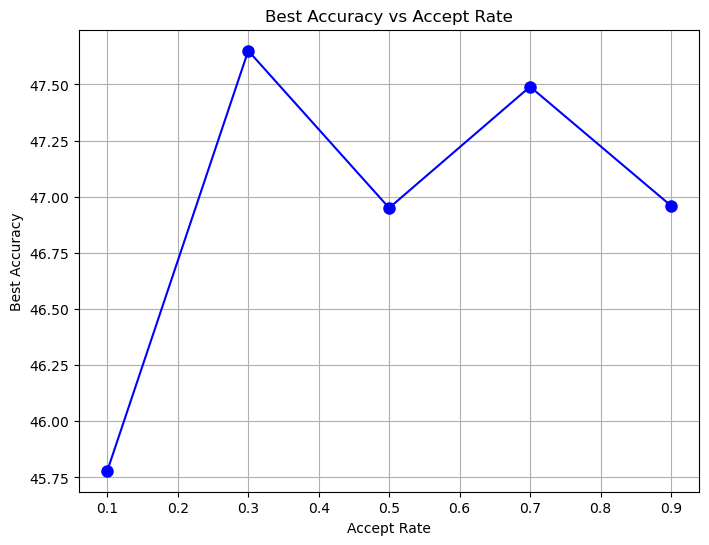

In [6]:
import matplotlib.pyplot as plt

accept_rate_values = [0.1, 0.3, 0.5, 0.7, 0.9]
best_acc_values = [45.78, 47.65, 46.95, 47.49, 46.96]

plt.figure(figsize=(8, 6))

plt.plot(accept_rate_values, best_acc_values, color='blue', linestyle='-', marker='o', markersize=8)

plt.title('Best Accuracy vs Accept Rate')
plt.xlabel('Accept Rate')
plt.ylabel('Best Accuracy'))
plt.show()